Phase 1: 

In [1]:
# Liste tous les packages installés et leurs versions
import pkg_resources

for dist in sorted(pkg_resources.working_set, key=lambda x: x.key):
    print(f"{dist.key}=={dist.version}")


accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
asttokens==3.0.0
attrs==25.4.0
audioread==3.1.0
autocommand==2.2.2
av==16.0.1
backoff==2.2.1
backports.tarfile==1.2.0
bitsandbytes-windows==0.37.5
brotli==1.2.0
certifi==2025.11.12
cffi==2.0.0
charset-normalizer==3.4.4
click==8.1.8
colorama==0.4.6
coloredlogs==15.0.1
comm==0.2.3
contourpy==1.3.3
ctranslate2==4.6.1
cut-cross-entropy==25.1.1
cycler==0.12.1
datasets==4.3.0
debugpy==1.8.17
decorator==5.2.1
diffusers==0.35.2
dill==0.3.8
distro==1.9.0
docstring-parser==0.17.0
einops==0.6.1
einops-exts==0.0.4
executing==2.2.1
faiss-cpu==1.13.0
fastapi==0.121.1
faster-whisper==1.2.1
ffmpy==0.6.4
filelock==3.20.0
fire==0.7.1
flatbuffers==25.9.23
fonttools==4.60.1
frozenlist==1.8.0
fsspec==2023.10.0
gradio==5.45.0
gradio-client==1.13.0
groovy==0.1.2
groq==0.34.1
gtts==2.5.4
h11==0.16.0
hf-transfer==0.1.9

C:\Users\user\AppData\Local\Temp\ipykernel_2312\954034405.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# Nouvelle cellule - MODULE RAG MÉDICAL

import json
import os
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class MedicalRAG:
    """
    Système de récupération augmentée pour contexte médical enrichi
    Combine: JSON conversations + base symptômes + recherche sémantique
    """
    
    def __init__(self, json_dir='conversations_data', knowledge_base_path='medical_knowledge_base.json'):
        print("🔧 Initialisation du système RAG médical...")
        
        # 1. Charge le modèle d'embedding médical
        print("   📥 Chargement modèle embedding (S-PubMedBert)...")
        self.encoder = SentenceTransformer('pritamdeka/S-PubMedBert-MS-MARCO')
        print("   ✓ Modèle chargé")
        
        # 2. Charge la base de connaissances structurée
        print("   📚 Chargement base de connaissances...")
        with open(knowledge_base_path, 'r', encoding='utf-8') as f:
            self.knowledge_base = json.load(f)
        print(f"   ✓ {len(self.knowledge_base)} pathologies chargées")
        
        # 3. Charge et encode tous les JSON de conversations
        print("   📂 Chargement conversations JSON...")
        self.conversations = self._load_all_conversations(json_dir)
        print(f"   ✓ {len(self.conversations)} conversations chargées")
        
        # 4. Crée les embeddings
        print("   🧮 Création des embeddings...")
        self.conversation_texts = [self._conversation_to_text(conv) for conv in self.conversations]
        self.embeddings = self.encoder.encode(
            self.conversation_texts, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        
        # 5. Crée l'index FAISS pour recherche rapide
        print("   🔍 Construction index FAISS...")
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(self.embeddings.astype('float32'))
        print(f"   ✓ Index créé ({self.index.ntotal} vecteurs)")
        
        print("✅ RAG Médical opérationnel\n")
    
    def _load_all_conversations(self, json_dir: str) -> List[Dict]:
        """Charge tous les fichiers JSON de conversations"""
        conversations = []
        
        if not os.path.exists(json_dir):
            print(f"   ⚠️  Dossier {json_dir} introuvable")
            return conversations
        
        for filename in os.listdir(json_dir):
            if filename.endswith('.json'):
                filepath = os.path.join(json_dir, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # Extrait la classe du nom de fichier
                        class_name = filename.replace('_conversations.json', '').replace('_', ' ').title()
                        
                        # Ajoute chaque conversation avec métadonnées
                        if isinstance(data, list):
                            for conv in data:
                                conv['source_class'] = class_name
                                conv['source_file'] = filename
                                conversations.append(conv)
                except Exception as e:
                    print(f"   ⚠️  Erreur lecture {filename}: {e}")
        
        return conversations
    
    def _conversation_to_text(self, conversation: Dict) -> str:
        """Convertit une conversation JSON en texte pour embedding"""
        text_parts = []
        
        # Ajoute la classe source
        if 'source_class' in conversation:
            text_parts.append(f"Pathologie: {conversation['source_class']}")
        
        # Ajoute le dialogue
        if 'conversation' in conversation:
            for msg in conversation['conversation']:
                role = msg.get('role', 'unknown')
                content = msg.get('content', '')
                text_parts.append(f"{role}: {content}")
        
        return " | ".join(text_parts)
    #etape 6 : recherche sémantique
    def retrieve_similar_cases(self, query: str, top_k: int = 3) -> List[Dict]:
        """
        Recherche les conversations les plus similaires à la requête
        
        Args:
            query: Texte de la requête (symptômes, question patient, etc.)
            top_k: Nombre de résultats à retourner
            
        Returns:
            Liste de conversations similaires avec scores
        """
        # Encode la requête
        query_embedding = self.encoder.encode([query], convert_to_numpy=True)
        
        # Recherche dans l'index
        distances, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        # Prépare les résultats
        results = []
        for idx, dist in zip(indices[0], distances[0]):
            # Convertit distance en score de similarité (0-1)
            similarity = 1 / (1 + dist)
            
            result = {
                'conversation': self.conversations[idx],
                'similarity_score': float(similarity),
                'text': self.conversation_texts[idx]
            }
            results.append(result)
        
        return results
    #elle calcule le score de matching + recupere les symptomes typiques depuis knowledge base
    def get_symptom_context(self, detected_class: str, patient_symptoms: List[str] = None) -> Dict:
        """
        Récupère le contexte symptomatique structuré
        
        Args:
            detected_class: Classe détectée par EfficientNet
            patient_symptoms: Liste des symptômes mentionnés par le patient
            
        Returns:
            Dictionnaire avec contexte symptomatique enrichi
        """
        if detected_class not in self.knowledge_base:
            return {'error': f'Classe {detected_class} non trouvée'}
        
        kb_entry = self.knowledge_base[detected_class]
        
        context = {
            'pathologie': detected_class,
            'symptomes_typiques': kb_entry['symptomes_cles'],
            'zones_typiques': kb_entry['zones_typiques'],
            'facteurs_aggravants': kb_entry['facteurs_aggravants'],
            'criteres_urgence': kb_entry['urgence_si']
        }
        
        # Si des symptômes patients sont fournis, calcule le matching
        if patient_symptoms:
            context['symptom_matching'] = self._match_symptoms(
                patient_symptoms, 
                kb_entry['symptomes_cles']
            )
        
        return context
    
    def _match_symptoms(self, patient_symptoms: List[str], typical_symptoms: List[Dict]) -> Dict:
        """Compare symptômes patient vs symptômes typiques"""
        matches = []
        patient_symp_lower = [s.lower() for s in patient_symptoms]
        
        for typical in typical_symptoms:
            symptom_name = typical['symptome'].lower()
            poids = typical['poids']
            
            # Recherche correspondance partielle
            matched = any(symptom_name in ps or ps in symptom_name for ps in patient_symp_lower)
            
            if matched:
                matches.append({
                    'symptome': typical['symptome'],
                    'poids': poids,
                    'discriminant': typical['discriminant']
                })
        
        # Calcule score global de matching
        if matches:
            score = sum(m['poids'] for m in matches) / len(typical_symptoms)
        else:
            score = 0.0
        
        return {
            'matched_symptoms': matches,
            'confidence_score': score,
            'nb_matches': len(matches),
            'nb_total': len(typical_symptoms)
        }
    #l'integration des sources d'informations , comment il va agir apres , bch yjib w ykaren les questions
    def build_enriched_context(
        self, 
        detected_class: str,
        confidence: float,
        llava_description: str,
        patient_question: str,
        conversation_history: List[Dict] = None
    ) -> str:
        """
        Construit le contexte médical enrichi complet pour Meditron
        
        C'est LA fonction clé qui unifie toutes les sources d'information
        """
        # 1. Récupère cas similaires via recherche sémantique
        query = f"{detected_class} {llava_description} {patient_question}"
        similar_cases = self.retrieve_similar_cases(query, top_k=3)
        
        # 2. Récupère contexte symptomatique structuré
        symptom_ctx = self.get_symptom_context(detected_class)
        
        # 3. Construit le prompt enrichi
        context = f"""### CONTEXTE MÉDICAL ENRICHI

🔬 CLASSIFICATION AUTOMATIQUE:
- Diagnostic probable: {detected_class}
- Confiance du modèle: {confidence:.1%}

👁️ OBSERVATIONS VISUELLES (LLaVA):
{llava_description}

📚 SYMPTÔMES TYPIQUES DE {detected_class}:
"""
        
        # Ajoute les symptômes avec poids
        for symp in symptom_ctx.get('symptomes_typiques', [])[:5]:
            marker = "⚠️" if symp['discriminant'] else "•"
            context += f"{marker} {symp['symptome']} (poids diagnostique: {symp['poids']:.0%})\n"
        
        context += f"\n📍 ZONES ANATOMIQUES TYPIQUES:\n"
        for zone in symptom_ctx.get('zones_typiques', []):
            context += f"• {zone}\n"
        
        context += f"\n🚨 CRITÈRES D'URGENCE:\n"
        for critere in symptom_ctx.get('criteres_urgence', []):
            context += f"⚠️ {critere}\n"
        
        context += f"\n💡 CAS CLINIQUES SIMILAIRES:\n"
        for i, case in enumerate(similar_cases, 1):
            score = case['similarity_score']
            source = case['conversation'].get('source_class', 'Unknown')
            context += f"\nCas #{i} (similarité: {score:.0%}) - {source}:\n"
            
            # Extrait quelques échanges pertinents
            conv = case['conversation'].get('conversation', [])[:3]
            for msg in conv:
                role = "👤" if msg.get('role') == 'user' else "👨‍⚕️"
                content = msg.get('content', '')[:150]  # Limite longueur
                context += f"{role} {content}...\n"
        
        # 4. Ajoute historique conversation si disponible
        if conversation_history:
            context += f"\n💬 HISTORIQUE CONVERSATION ACTUELLE:\n"
            for msg in conversation_history[-5:]:  # Derniers 5 échanges
                role = msg.get('role', 'unknown')
                content = msg.get('content', '')
                context += f"{role}: {content}\n"
        
        context += f"\n❓ QUESTION ACTUELLE DU PATIENT:\n{patient_question}\n"
        
        return context


# Initialisation du système RAG
print("="*70)
print("🚀 PHASE 1 : INITIALISATION MODULE RAG")
print("="*70)

medical_rag = MedicalRAG(
    json_dir='conversations_data',
    knowledge_base_path='medical_knowledge_base.json'
)

print("✅ Phase 1 terminée : RAG opérationnel")
print("="*70)

🚀 PHASE 1 : INITIALISATION MODULE RAG
🔧 Initialisation du système RAG médical...
   📥 Chargement modèle embedding (S-PubMedBert)...
   ✓ Modèle chargé
   📚 Chargement base de connaissances...
   ✓ 8 pathologies chargées
   📂 Chargement conversations JSON...
   ✓ 1182 conversations chargées
   🧮 Création des embeddings...


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

   🔍 Construction index FAISS...
   ✓ Index créé (1182 vecteurs)
✅ RAG Médical opérationnel

✅ Phase 1 terminée : RAG opérationnel


----test du rag :-----------------------

In [3]:
# Nouvelle cellule - TEST DU RAG

print("\n" + "="*70)
print("🧪 TEST DU SYSTÈME RAG")
print("="*70)

# Test 1: Recherche de cas similaires
print("\n📋 TEST 1: Recherche cas similaires")
print("-"*70)
test_query = "démangeaisons intenses la nuit avec rougeurs"
results = medical_rag.retrieve_similar_cases(test_query, top_k=2)

print(f"Requête: '{test_query}'")
print(f"Résultats trouvés: {len(results)}\n")

for i, result in enumerate(results, 1):
    print(f"Résultat #{i}:")
    print(f"  • Pathologie source: {result['conversation'].get('source_class', 'N/A')}")
    print(f"  • Score similarité: {result['similarity_score']:.2%}")
    print(f"  • Extrait: {result['text'][:200]}...")
    print()

# Test 2: Contexte symptomatique
print("\n📋 TEST 2: Contexte symptomatique structuré")
print("-"*70)
symptom_ctx = medical_rag.get_symptom_context('Eczema')

print(f"Pathologie: {symptom_ctx['pathologie']}")
print(f"\nSymptômes typiques:")
for symp in symptom_ctx['symptomes_typiques'][:3]:
    print(f"  • {symp['symptome']} (poids: {symp['poids']:.0%}, discriminant: {symp['discriminant']})")

print(f"\nZones typiques: {', '.join(symptom_ctx['zones_typiques'])}")
print(f"\nCritères d'urgence: {', '.join(symptom_ctx['criteres_urgence'])}")

# Test 3: Contexte enrichi complet
print("\n📋 TEST 3: Contexte enrichi complet")
print("-"*70)
enriched_context = medical_rag.build_enriched_context(
    detected_class='Eczema',
    confidence=0.91,
    llava_description="Plaques érythémateuses avec desquamation et excoriations visibles sur la peau",
    patient_question="Comment puis-je soulager les démangeaisons?",
    conversation_history=[]
)

print("Longueur du contexte généré:", len(enriched_context), "caractères")
print("\nAperçu (500 premiers caractères):")
print(enriched_context[:500] + "...")

print("\n" + "="*70)
print("✅ TESTS RÉUSSIS - RAG fonctionne correctement")
print("="*70)


🧪 TEST DU SYSTÈME RAG

📋 TEST 1: Recherche cas similaires
----------------------------------------------------------------------
Requête: 'démangeaisons intenses la nuit avec rougeurs'
Résultats trouvés: 2

Résultat #1:
  • Pathologie source: Gale
  • Score similarité: 1.17%
  • Extrait: Pathologie: Gale...

Résultat #2:
  • Pathologie source: Gale
  • Score similarité: 1.17%
  • Extrait: Pathologie: Gale...


📋 TEST 2: Contexte symptomatique structuré
----------------------------------------------------------------------
Pathologie: Eczema

Symptômes typiques:
  • démangeaisons intenses (poids: 90%, discriminant: True)
  • peau sèche (poids: 80%, discriminant: False)
  • rougeurs (poids: 70%, discriminant: False)

Zones typiques: plis des coudes, plis des genoux, mains, visage

Critères d'urgence: surinfection, fièvre élevée, extension rapide

📋 TEST 3: Contexte enrichi complet
----------------------------------------------------------------------
Longueur du contexte généré: 844 car



----------------------------PHASE 2 :---------------------------- 



In [3]:
# Nouvelle cellule - MODULE SCORING MÉDICAL

class MedicalScoringEngine:
    """
    Système d'évaluation médicale automatique
    - Score d'urgence (0-10)
    - Détection signes d'alarme
    - Recommandations adaptatives
    """
    
    def __init__(self):
        # Mots-clés d'urgence par gravité
        self.urgency_keywords = {
            'critique': {
                'keywords': [
                    'difficulté respiratoire', 'respirer', 'étouffer', 'souffle court',
                    'gonflement visage', 'gonflement gorge', 'angioedème',
                    'perte de conscience', 'malaise', 'évanouissement',
                    'douleur thoracique', 'cœur',
                    'décollement cutané', 'bulles étendues',
                    'fièvre très élevée', 'fièvre 40'
                ],
                'score': 10,
                'action': 'URGENCE IMMÉDIATE - Appeler le 15 (SAMU)'
            },
            'élevée': {
                'keywords': [
                    'fièvre élevée', 'fièvre 39', 'température élevée',
                    'douleur intense', 'très douloureux',
                    'extension rapide', 's\'étend rapidement', 'propagation',
                    'pus', 'suppuration', 'surinfection',
                    'saignement', 'sang',
                    'atteinte muqueuse', 'bouche', 'yeux rouges'
                ],
                'score': 7,
                'action': 'Consultation médicale dans les 24h recommandée'
            },
            'modérée': {
                'keywords': [
                    'fièvre', 'température',
                    'douleur', 'fait mal',
                    'gêne importante', 'handicapant',
                    'insomnie', 'ne peux pas dormir',
                    'plusieurs jours', 'une semaine'
                ],
                'score': 5,
                'action': 'Surveillance et consultation si aggravation'
            },
            'faible': {
                'keywords': [
                    'démangeaisons', 'gratte',
                    'rougeur', 'rouge',
                    'sécheresse', 'peau sèche',
                    'léger', 'peu',
                    'depuis hier', 'récent'
                ],
                'score': 3,
                'action': 'Soins à domicile possibles, surveiller évolution'
            }
        }
        
        # Facteurs multiplicateurs par pathologie
        self.pathology_risk_factors = {
            'Drug Reactions': 1.5,  # Réactions médicamenteuses = plus grave
            'Impetigo': 1.3,        # Infection = nécessite traitement
            'Gale': 1.3,            # Contagieux
            'Maladie Cutanee Auto-immune': 1.4,
            'Urticaria Hives': 1.2, # Risque angioedème
            'Eczema': 1.0,
            'Atopic Dermatitis': 1.0,
            'Dermatophytosis': 1.0
        }
    
    def calculate_urgency_score(
        self,
        detected_class: str,
        patient_text: str,
        conversation_history: list = None
    ) -> dict:
        """
        Calcule le score d'urgence basé sur les symptômes mentionnés
        
        Returns:
            {
                'score': 0-10,
                'level': 'faible'|'modérée'|'élevée'|'critique',
                'detected_flags': [...],
                'recommendation': str
            }
        """
        
        # Combine tout le texte patient
        full_text = patient_text.lower()
        if conversation_history:
            for msg in conversation_history:
                if msg.get('role') == 'user':
                    full_text += " " + msg.get('content', '').lower()
        
        # Détecte les mots-clés d'urgence
        detected_flags = []
        max_score = 0
        recommendation = ''
        level = 'faible'
        
        for urgency_level, data in self.urgency_keywords.items():
            for keyword in data['keywords']:
                if keyword in full_text:
                    detected_flags.append({
                        'keyword': keyword,
                        'level': urgency_level,
                        'score': data['score']
                    })
                    
                    if data['score'] > max_score:
                        max_score = data['score']
                        recommendation = data['action']
                        level = urgency_level
        
        # Applique le facteur de risque pathologique
        risk_factor = self.pathology_risk_factors.get(detected_class, 1.0)
        final_score = min(10, max_score * risk_factor)
        
        # Ajuste le niveau si nécessaire
        if final_score >= 9:
            level = 'critique'
        elif final_score >= 7:
            level = 'élevée'
        elif final_score >= 5:
            level = 'modérée'
        else:
            level = 'faible'
        
        return {
            'score': round(final_score, 1),
            'level': level,
            'detected_flags': detected_flags,
            'recommendation': recommendation,
            'should_see_doctor_urgently': final_score >= 7
        }


# Initialisation
print("="*70)
print("🎯 MODULE SCORING MÉDICAL")
print("="*70)

medical_scorer = MedicalScoringEngine()

print("✅ Scoring engine opérationnel")
print("="*70)

🎯 MODULE SCORING MÉDICAL
✅ Scoring engine opérationnel


*******1er test avec MEDITRON :*******

In [5]:
# Nouvelle cellule - MEDITRON EXPERT INTÉGRÉ

import requests
import json
import re
from typing import Dict, List, Optional

class MeditronMedicalExpert:
    """
    Moteur expert médical avec Meditron-7B
    Intègre: RAG + Scoring + Raisonnement structuré
    """
    
    # def __init__(self, medical_rag, medical_scorer):
    #     self.api_url = "http://localhost:11434/api/generate"
    #     self.model = "meditron:7b"
        
    #     # Références aux systèmes
    #     self.rag = medical_rag
    #     self.scorer = medical_scorer
        
    #     # État de la consultation
    #     self.conversation_history = []
    #     self.patient_info = {
    #         'symptoms': [],
    #         'duration': None,
    #         'severity': None,
    #         'location': None,
    #         'triggers': [],
    #         'medical_history': []
    #     }
        
    #     self.current_diagnosis = {
    #         'primary': None,
    #         'confidence': 0,
    #         'differentials': [],
    #         'urgency_score': 0
    #     }
        
    #     self.questions_asked = []
    #     self.turn_count = 0
        
    #     print("✅ Meditron Medical Expert initialisé\n")
    def __init__(self, medical_rag, medical_scorer):
        self.api_url = "http://localhost:11434/api/generate"
        # 🔥 CHANGEMENT CRITIQUE
        self.model = "llama3.2:latest"  # Au lieu de meditron:7b
        
        self.rag = medical_rag
        self.scorer = medical_scorer
        
        self.conversation_history = []
        self.patient_info = {
            'symptoms': [],
            'duration': None,
            'severity': None,
            'location': None,
            'triggers': [],
            'medical_history': []
        }
        
        self.current_diagnosis = {
            'primary': None,
            'confidence': 0,
            'differentials': [],
            'urgency_score': 0
        }
        
        self.questions_asked = []
        self.turn_count = 0
        
        print("✅ Expert médical initialisé avec Llama3.2\n")
    
    def start_consultation(
        self,
        detected_class: str,
        confidence: float,
        llava_description: str
    ) -> str:
        """Démarre une nouvelle consultation médicale"""
        
        # Reset état
        self.conversation_history = []
        self.patient_info = {
            'symptoms': [],
            'duration': None,
            'severity': None,
            'location': None,
            'triggers': [],
            'medical_history': []
        }
        
        self.current_diagnosis = {
            'primary': detected_class,
            'confidence': confidence,
            'differentials': [],
            'urgency_score': 0
        }
        
        self.questions_asked = []
        self.turn_count = 0
        
        # Construit le contexte initial
        initial_context = self.rag.build_enriched_context(
            detected_class=detected_class,
            confidence=confidence,
            llava_description=llava_description,
            patient_question="Bonjour, j'ai pris cette photo de ma peau et j'aimerais votre avis.",
            conversation_history=[]
        )
        
        # Génère la première réponse
        initial_prompt = self._build_initial_prompt(initial_context)
        response = self._call_meditron(initial_prompt, temperature=0.7)
        
        # Sauvegarde dans historique
        self.conversation_history.append({
            'role': 'system',
            'content': initial_context
        })
        
        self.conversation_history.append({
            'role': 'user',
            'content': "Bonjour docteur, j'ai pris cette photo de ma peau et j'aimerais votre avis."
        })
        
        self.conversation_history.append({
            'role': 'assistant',
            'content': response
        })
        
        return response
    
    def continue_conversation(self, patient_message: str) -> str:
        """Continue la conversation avec raisonnement médical"""
        
        self.turn_count += 1
        
        # 1. Extrait infos du message patient
        self._extract_patient_info(patient_message)
        
        # 2. Calcule score d'urgence
        urgency_result = self.scorer.calculate_urgency_score(
            detected_class=self.current_diagnosis['primary'],
            patient_text=patient_message,
            conversation_history=self.conversation_history
        )
        
        self.current_diagnosis['urgency_score'] = urgency_result['score']
        
        # 3. Construit contexte enrichi avec TOUTES les infos
        enriched_context = self.rag.build_enriched_context(
            detected_class=self.current_diagnosis['primary'],
            confidence=self.current_diagnosis['confidence'],
            llava_description=self._get_initial_llava_description(),
            patient_question=patient_message,
            conversation_history=self.conversation_history
        )
        
        # 4. Détermine le type de réponse nécessaire
        if urgency_result['should_see_doctor_urgently']:
            # URGENCE détectée
            response = self._generate_urgent_response(urgency_result, patient_message)
        
        elif self._is_asking_medical_question(patient_message):
            # Question ÉDUCATIVE
            response = self._generate_educational_response(enriched_context, patient_message)
        
        elif self.turn_count < 6:
            # INTERROGATOIRE actif
            response = self._generate_diagnostic_question(enriched_context, patient_message)
        
        else:
            # SYNTHÈSE finale
            response = self._generate_conclusion(enriched_context)
        
        # 5. Sauvegarde
        self.conversation_history.append({
            'role': 'user',
            'content': patient_message
        })
        
        self.conversation_history.append({
            'role': 'assistant',
            'content': response
        })
        
        return response
    
    def _build_initial_prompt(self, context: str) -> str:
        """Construit le prompt initial pour Meditron"""
        
        prompt = f"""{context}

### INSTRUCTIONS POUR L'IA MÉDICALE

Tu es un dermatologue expert utilisant un système d'aide au diagnostic.

ANALYSE DISPONIBLE:
- Classification automatique avec niveau de confiance
- Description visuelle détaillée de l'image
- Base de connaissances symptomatique
- Cas cliniques similaires

PREMIÈRE RÉPONSE:
1. Accueille le patient chaleureusement
2. Explique que tu as analysé l'image
3. Mentionne l'hypothèse diagnostique SANS affirmer de certitude
4. Pose UNE question ciblée pour confirmer/infirmer l'hypothèse

CONSIGNES:
- Sois rassurant mais honnête
- Utilise un langage simple (évite le jargon médical)
- NE recommande PAS de consulter un médecin immédiatement (sauf urgence vitale)
- Maximum 5-6 lignes

Génère la première réponse du dermatologue:"""

        return prompt
    
    def _generate_diagnostic_question(self, context: str, patient_message: str) -> str:
        """Génère une question diagnostique ciblée basée sur le raisonnement"""
        
        # Identifie les infos manquantes
        missing_info = self._identify_missing_information()
        
        prompt = f"""{context}

### ÉTAT ACTUEL DE L'INTERROGATOIRE

INFORMATIONS COLLECTÉES:
- Symptômes identifiés: {', '.join(self.patient_info['symptoms']) if self.patient_info['symptoms'] else 'Aucun précisé'}
- Durée: {self.patient_info['duration'] or 'Non précisée'}
- Localisation: {self.patient_info['location'] or 'Non précisée'}
- Facteurs déclenchants: {', '.join(self.patient_info['triggers']) if self.patient_info['triggers'] else 'Aucun'}

INFORMATIONS MANQUANTES CRITIQUES:
{missing_info}

DERNIER MESSAGE DU PATIENT:
"{patient_message}"

### INSTRUCTIONS MEDITRON

Effectue un raisonnement médical structuré:

1. ANALYSE du dernier message:
   - Quelles nouvelles informations avons-nous?
   - Cela confirme-t-il ou infirme-t-il notre hypothèse?

2. DIAGNOSTIC DIFFÉRENTIEL:
   - Hypothèse principale reste-t-elle valide?
   - Y a-t-il des signes orientant vers autre chose?

3. QUESTION OPTIMALE:
   - Pose UNE question qui maximise l'information gain
   - Cible l'information manquante la plus discriminante
   - Formule en langage simple et naturel

CONSIGNES:
- Réponds d'abord brièvement au patient (2-3 lignes)
- Pose ENSUITE ta question ciblée
- Reste rassurant
- PAS de recommandation "allez voir un médecin" (score urgence actuel: {self.current_diagnosis['urgency_score']}/10)
- Maximum 6 lignes total

Génère la réponse du dermatologue:"""

        return self._call_meditron(prompt, temperature=0.8)
    
    def _generate_educational_response(self, context: str, patient_question: str) -> str:
        """Répond à une question éducative du patient"""
        
        prompt = f"""{context}

### QUESTION ÉDUCATIVE DU PATIENT
"{patient_question}"

### INSTRUCTIONS MEDITRON

Le patient pose une question sur:
- La nature de sa pathologie
- Les causes
- Les traitements
- L'évolution

CONSIGNES POUR LA RÉPONSE:
1. Réponds de manière PÉDAGOGIQUE
2. Utilise des analogies simples si nécessaire
3. Sois PRÉCIS mais ACCESSIBLE
4. Mentionne que c'est basé sur l'hypothèse diagnostique actuelle
5. Rassure le patient
6. NE dis PAS "consultez un médecin" systématiquement
7. Maximum 8 lignes

Génère une réponse éducative claire:"""

        return self._call_meditron(prompt, temperature=0.7)
    
    def _generate_urgent_response(self, urgency_result: dict, patient_message: str) -> str:
        """Génère une réponse pour situation urgente"""
        
        flags = urgency_result['detected_flags']
        level = urgency_result['level']
        
        response = f"""⚠️ ATTENTION - Signes préoccupants détectés

D'après ce que vous me décrivez, notamment """
        
        # Liste les signes d'alarme
        alarm_signs = [flag['keyword'] for flag in flags[:2]]
        response += f"**{' et '.join(alarm_signs)}**, "
        
        if level == 'critique':
            response += """je vous recommande FORTEMENT de consulter immédiatement:

🚨 **Appelez le 15 (SAMU)** ou rendez-vous aux urgences sans délai.

Ces symptômes nécessitent une évaluation médicale urgente car ils peuvent indiquer une complication sérieuse."""

        elif level == 'élevée':
            response += """je vous recommande de consulter un médecin dans les 24 heures.

📞 Contactez votre médecin traitant ou un dermatologue rapidement, ou rendez-vous dans un centre de soins si nécessaire.

En attendant:
"""
            # Ajoute conseils d'attente
            response += self._get_waiting_advice()
        
        return response
    
    def _generate_conclusion(self, context: str) -> str:
        """Génère une synthèse de la consultation"""
        
        prompt = f"""{context}

### SYNTHÈSE DE LA CONSULTATION

INFORMATIONS COLLECTÉES:
- Symptômes: {', '.join(self.patient_info['symptoms'])}
- Durée: {self.patient_info['duration']}
- Localisation: {self.patient_info['location']}
- Triggers: {', '.join(self.patient_info['triggers'])}

DIAGNOSTIC:
- Hypothèse principale: {self.current_diagnosis['primary']}
- Confiance: {self.current_diagnosis['confidence']:.0%}
- Score urgence: {self.current_diagnosis['urgency_score']}/10

### INSTRUCTIONS MEDITRON

Génère une SYNTHÈSE STRUCTURÉE:

1. **CE QUE NOUS AVONS IDENTIFIÉ** (3 lignes)
   - Résume les observations principales

2. **HYPOTHÈSE DIAGNOSTIQUE** (2 lignes)
   - Confirme le diagnostic probable
   - Mentionne le niveau de confiance

3. **RECOMMANDATIONS PRATIQUES** (4-5 lignes)
   - Conseils de soins à domicile CONCRETS
   - Signaux d'alarme à surveiller
   - Quand consulter si aggravation

4. **CONCLUSION** (2 lignes)
   - Rassure le patient
   - Encourage suivi si pas d'amélioration

CONSIGNES:
- Sois synthétique et structuré
- Langage accessible
- Donne des conseils ACTIONNABLES
- Score urgence = {self.current_diagnosis['urgency_score']} → {"Consultation recommandée" if self.current_diagnosis['urgency_score'] >= 5 else "Soins domicile possibles"}

Génère la synthèse:"""

        return self._call_meditron(prompt, temperature=0.6)
    
    # def _call_meditron(self, prompt: str, temperature: float = 0.7) -> str:
    #     """Appelle Meditron via Ollama"""
        
    #     payload = {
    #         "model": self.model,
    #         "prompt": prompt,
    #         "stream": False,
    #         "options": {
    #             "temperature": temperature,
    #             "top_p": 0.9,
    #             "top_k": 40,
    #             "num_predict": 300
    #         }
    #     }
        
    #     try:
    #         response = requests.post(self.api_url, json=payload, timeout=60)
    #         result = response.json()
    #         text = result.get('response', '').strip()
    #         return self._clean_response(text)
        
    #     except Exception as e:
    #         return f"Pouvez-vous reformuler votre question? (Erreur technique: {str(e)})"
    def _call_meditron(self, prompt: str, temperature: float = 0.7) -> str:
        """Appelle Llama3.2 avec format optimisé pour dialogue médical"""
        
        formatted_prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue expert qui pose des questions diagnostiques de manière naturelle et concise.
Règles strictes:
- Maximum 4-5 lignes par réponse
- Pose UNE seule question à la fois
- Langage simple et rassurant
- NE répète JAMAIS le contexte donné
- NE dis PAS "consultez un médecin" systématiquement<|eot_id|>

<|start_header_id|>user<|end_header_id|>

{prompt}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""
        
        payload = {
            "model": self.model,
            "prompt": formatted_prompt,
            "stream": False,
            "options": {
                "temperature": temperature,
                "top_p": 0.9,
                "top_k": 40,
                "num_predict": 150,
                "stop": ["<|eot_id|>", "\n\n\n", "PATIENT:", "USER:", "###"]
            }
        }
        
        try:
            response = requests.post(self.api_url, json=payload, timeout=60)
            result = response.json()
            text = result.get('response', '').strip()
            
            # Nettoyage agressif
            text = text.split("<|")[0]
            text = text.split("###")[0]
            text = text.replace("CONTEXTE:", "").replace("RESPONSE:", "")
            
            # Limite 5 phrases
            sentences = [s.strip() + '.' for s in text.split('.') if s.strip()]
            text = ' '.join(sentences[:5])
            
            return text if len(text) > 20 else "Pouvez-vous préciser votre question ?"
        
        except Exception as e:
            return "Erreur technique. Reformulez s'il vous plaît."


# # Remplace la méthode dans la classe
# MeditronMedicalExpert._call_meditron = _call_meditron

     

    
    def _clean_response(self, text: str) -> str:
        """Nettoie la réponse de Meditron"""
        
        # Enlève les marqueurs de prompt
        text = re.sub(r'\[INST\]|\[/INST\]|<s>|</s>', '', text)
        
        # Enlève les répétitions
        sentences = text.split('.')
        unique_sentences = []
        for sent in sentences:
            sent = sent.strip()
            if sent and sent not in unique_sentences:
                unique_sentences.append(sent)
        
        text = '. '.join(unique_sentences[:7])  # Max 7 phrases
        
        if text and not text.endswith('.'):
            text += '.'
        
        return text
    
    def _extract_patient_info(self, message: str):
        """Extrait automatiquement les informations du message patient"""
        
        msg_lower = message.lower()
        
        # Symptômes
        symptom_keywords = {
            'démangeaisons': ['démange', 'gratte', 'prurit', 'ça gratte'],
            'douleur': ['douleur', 'fait mal', 'douloureux', 'brûle'],
            'rougeur': ['rouge', 'rougeur', 'érythème'],
            'fièvre': ['fièvre', 'température', 'chaud'],
            'gonflement': ['gonflé', 'enflé', 'œdème'],
            'sécheresse': ['sec', 'sèche', 'desséché']
        }
        
        for symptom, keywords in symptom_keywords.items():
            if any(kw in msg_lower for kw in keywords):
                if symptom not in self.patient_info['symptoms']:
                    self.patient_info['symptoms'].append(symptom)
        
        # Durée
        duration_patterns = [
            r'depuis (\d+) (jour|jours|semaine|semaines|mois)',
            r'il y a (\d+) (jour|jours|semaine|semaines|mois)',
            r'(\d+) (jour|jours|semaine|semaines|mois)'
        ]
        
        for pattern in duration_patterns:
            match = re.search(pattern, msg_lower)
            if match and not self.patient_info['duration']:
                self.patient_info['duration'] = f"{match.group(1)} {match.group(2)}"
        
        # Localisation
        location_keywords = ['bras', 'jambe', 'dos', 'ventre', 'visage', 'main', 'pied', 'coude', 'genou']
        for loc in location_keywords:
            if loc in msg_lower and not self.patient_info['location']:
                self.patient_info['location'] = loc
    
    def _identify_missing_information(self) -> str:
        """Identifie les informations manquantes pour le diagnostic"""
        
        missing = []
        
        if not self.patient_info['symptoms']:
            missing.append("• Nature exacte des symptômes (démangeaisons, douleur, etc.)")
        
        if not self.patient_info['duration']:
            missing.append("• Durée depuis l'apparition")
        
        if not self.patient_info['location']:
            missing.append("• Localisation précise sur le corps")
        
        if not self.patient_info['triggers']:
            missing.append("• Facteurs déclenchants ou aggravants")
        
        if not self.patient_info['medical_history']:
            missing.append("• Antécédents médicaux pertinents")
        
        return '\n'.join(missing) if missing else "Aucune - interrogatoire complet"
    
    def _is_asking_medical_question(self, message: str) -> bool:
        """Détecte si le patient pose une question éducative"""
        
        msg_lower = message.lower()
        
        question_markers = [
            'c\'est quoi', 'c quoi', 'qu\'est-ce que', 'quest ce que',
            'pourquoi', 'comment', 'est-ce que c\'est',
            'causes', 'traitement', 'soigner', 'guérir'
        ]
        
        return any(marker in msg_lower for marker in question_markers) or '?' in message
    
    def _get_initial_llava_description(self) -> str:
        """Récupère la description LLaVA initiale"""
        
        for msg in self.conversation_history:
            if msg['role'] == 'system':
                # Extrait la partie LLaVA du contexte
                content = msg['content']
                if 'OBSERVATIONS VISUELLES' in content:
                    start = content.find('OBSERVATIONS VISUELLES')
                    end = content.find('📚 SYMPTÔMES', start)
                    if end > start:
                        return content[start:end].strip()
        
        return "Description visuelle non disponible"
    
    def _get_waiting_advice(self) -> str:
        """Conseils d'attente avant consultation"""
        
        pathology = self.current_diagnosis['primary']
        
        advice_map = {
            'Eczema': "• Hydratez bien la zone\n• Évitez de gratter\n• Utilisez des compresses fraîches",
            'Impetigo': "• Ne touchez pas les lésions\n• Lavez-vous les mains fréquemment\n• Isolez le linge",
            'Urticaria Hives': "• Prenez un antihistaminique si disponible\n• Évitez la chaleur\n• Surveillez votre respiration",
            'Drug Reactions': "• Arrêtez le médicament suspect (si conseillé par un médecin)\n• Notez tous vos médicaments\n• Surveillez l'évolution",
            'default': "• Surveillez l'évolution\n• Évitez d'irriter la zone\n• Restez hydraté"
        }
        
        return advice_map.get(pathology, advice_map['default'])


# Initialisation
print("="*70)
print("🧠 MEDITRON MEDICAL EXPERT")
print("="*70)

meditron_expert = MeditronMedicalExpert(
    medical_rag=medical_rag,
    medical_scorer=medical_scorer
)


print("✅ Meditron Expert opérationnel")
print("="*70)

🧠 MEDITRON MEDICAL EXPERT
✅ Expert médical initialisé avec Llama3.2

✅ Meditron Expert opérationnel


In [6]:
print("="*70)
print("🧪 TEST AVEC LLAMA3.2 (Stable)")
print("="*70)

# Réinitialise l'expert avec Llama3.2
meditron_expert = MeditronMedicalExpert(
    medical_rag=medical_rag,
    medical_scorer=medical_scorer
)

# Test 1 : Question simple
print("\n📋 TEST 1: Question diagnostique simple")
print("-"*70)
test_prompt = """CONTEXTE: Patient avec eczéma détecté (confiance 91%).
OBSERVATION: Plaques rouges avec desquamation.
SYMPTÔME PATIENT: "Ça me gratte beaucoup la nuit"

Pose UNE question diagnostique ciblée au patient."""

response1 = meditron_expert._call_meditron(test_prompt, temperature=0.7)
print(f"Réponse: {response1}")

# Vérifie qualité
if len(response1) < 20 or "chat between" in response1.lower():
    print("❌ Réponse invalide")
else:
    print("✅ Réponse valide")

# Test 2 : Stabilité (3 appels identiques)
print("\n📋 TEST 2: Vérification stabilité (3 appels)")
print("-"*70)
responses = []
for i in range(3):
    r = meditron_expert._call_meditron(test_prompt, temperature=0.7)
    responses.append(r)
    print(f"Appel {i+1}: {r[:80]}...")

# Vérifie cohérence
valid_responses = [r for r in responses if len(r) > 20 and "chat" not in r.lower()]
print(f"\n✅ Réponses valides: {len(valid_responses)}/3")

if len(valid_responses) >= 2:
    print("✅✅ STABILITÉ CONFIRMÉE - PHASE 2 VALIDÉE")
else:
    print("❌ Toujours instable - Vérifie l'installation d'Ollama")

print("="*70)

🧪 TEST AVEC LLAMA3.2 (Stable)
✅ Expert médical initialisé avec Llama3.2


📋 TEST 1: Question diagnostique simple
----------------------------------------------------------------------
Réponse: Pouvez-vous me dire si les plaques rouges et la désintégration ont commencé après avoir utilisé un nouveau produit de soins personnels ou une nouvelle nourriture ?.
✅ Réponse valide

📋 TEST 2: Vérification stabilité (3 appels)
----------------------------------------------------------------------
Appel 1: Quelle est l'expérience de votre patient lorsqu'il touche les plaques eczématiqu...
Appel 2: Quelle est la période de l'année au cours de laquelle vous avez remarqué ces sym...
Appel 3: Quel type de eczéma pensez-vous que votre patient pourrait avoir, les plaques ro...

✅ Réponses valides: 3/3
✅✅ STABILITÉ CONFIRMÉE - PHASE 2 VALIDÉE


In [39]:
# # TEST CORRECTION MEDITRON
# print("="*70)
# print("🔧 TEST CORRECTION FORMAT MEDITRON")
# print("="*70)

# # Test 1 : Prompt simple
# test_prompt = """CONTEXTE: Patient avec eczéma confirmé.
# SYMPTÔMES: Démangeaisons nocturnes.

# Pose UNE question diagnostique au patient."""

# response = meditron_expert._call_meditron(test_prompt, temperature=0.7)
# print("\n✅ Réponse Meditron:")
# print(response)

# # Test 2 : Vérification cohérence
# if "chat between" in response.lower() or "###" in response:
#     print("\n❌ FORMAT ENCORE CASSÉ !")
# else:
#     print("\n✅ FORMAT CORRECT - PHASE 2 VALIDÉE")

In [40]:
# # Nouvelle cellule - TEST MEDITRON

# print("\n" + "="*70)
# print("🧪 TEST MEDITRON EXPERT")
# print("="*70)

# # Simule une consultation
# print("\n📋 Simulation consultation...")
# print("-"*70)

# # Démarre
# initial_response = meditron_expert.start_consultation(
#     detected_class='Eczema',
#     confidence=0.91,
#     llava_description="Plaques érythémateuses avec desquamation et excoriations visibles. Bordures irrégulières, peau sèche environnante."
# )

# print("👨‍⚕️ DERMATOLOGUE:")
# print(initial_response)
# print()

# # Question 1
# print("👤 PATIENT: Ça me gratte beaucoup, surtout la nuit")
# response1 = meditron_expert.continue_conversation("Ça me gratte beaucoup, surtout la nuit")
# print("👨‍⚕️ DERMATOLOGUE:")
# print(response1)
# print()

# # Question 2
# print("👤 PATIENT: C'est apparu il y a une semaine")
# response2 = meditron_expert.continue_conversation("C'est apparu il y a une semaine")
# print("👨‍⚕️ DERMATOLOGUE:")
# print(response2)
# print()

# # Test urgence
# print("\n📋 Test détection urgence...")
# print("-"*70)
# urgency_test = medical_scorer.calculate_urgency_score(
#     detected_class='Eczema',
#     patient_text="J'ai de la fièvre à 39 et ça me fait mal",
#     conversation_history=[]
# )

# print(f"Score urgence: {urgency_test['score']}/10")
# print(f"Niveau: {urgency_test['level']}")
# print(f"Consultation urgente: {'OUI' if urgency_test['should_see_doctor_urgently'] else 'NON'}")
# print(f"Drapeaux détectés: {len(urgency_test['detected_flags'])}")

# print("\n" + "="*70)
# print("✅ PHASE 2 VALIDÉE")
# print("="*70)
# ```

# ---

# ## ✅ VALIDATION PHASE 2

# Tu dois voir:
# ```
# ✅ Meditron répond de manière intelligente
# ✅ Questions ciblées (pas génériques)
# ✅ Score d'urgence calculé correctement
# ✅ PAS de "allez voir un médecin" systématique

In [9]:
# response = requests.post("http://localhost:11434/api/generate", json={
#     "model": "meditron:7b",
#     "prompt": "En tant que dermatologue, explique l'eczéma en 3 lignes.",
#     "stream": False
# })
# print(response.json()['response'])



*******2eme test avec Mistral :*******


In [41]:
import requests
import json
import re

class MistralHumanizer:
    """
    Transforme les réponses médicales techniques en dialogue empathique
    Utilise Mistral-7B-Instruct pour naturalité maximale
    """
    
    def __init__(self):
        self.api_url = "http://localhost:11434/api/generate"
        self.model = "mistral:7b-instruct"
        
        # Profils de ton selon contexte
        self.tone_profiles = {
            'initial': {
                'style': 'accueillant, rassurant, professionnel',
                'emotion': 'chaleureux',
                'formality': 'moyennement formel'
            },
            'diagnostic': {
                'style': 'curieux, attentif, empathique',
                'emotion': 'bienveillant',
                'formality': 'conversationnel'
            },
            'urgent': {
                'style': 'clair, direct, ferme mais rassurant',
                'emotion': 'sérieux mais calme',
                'formality': 'formel'
            },
            'educational': {
                'style': 'pédagogique, patient, accessible',
                'emotion': 'encourageant',
                'formality': 'décontracté'
            },
            'conclusion': {
                'style': 'synthétique, constructif, rassurant',
                'emotion': 'positif',
                'formality': 'semi-formel'
            }
        }
        
        print("✅ Mistral Humanizer initialisé\n")
    
    def humanize_response(
        self,
        medical_response: str,
        context_type: str = 'diagnostic',
        patient_profile: dict = None,
        urgency_score: float = 0
    ) -> str:
        """
        Transforme une réponse médicale en dialogue naturel
        
        Args:
            medical_response: Réponse brute de Llama3.2
            context_type: 'initial' | 'diagnostic' | 'urgent' | 'educational' | 'conclusion'
            patient_profile: {'age_estimate': 'adult', 'anxiety_level': 'low'}
            urgency_score: Score d'urgence 0-10
        
        Returns:
            Réponse humanisée et empathique
        """
        
        # Sélectionne le profil de ton
        tone = self.tone_profiles.get(context_type, self.tone_profiles['diagnostic'])
        
        # Ajuste selon urgence
        if urgency_score >= 7:
            tone = self.tone_profiles['urgent']
        
        # Construit le prompt de transformation
        prompt = self._build_humanization_prompt(
            medical_response, 
            tone, 
            patient_profile,
            urgency_score
        )
        
        # Appelle Mistral
        humanized = self._call_mistral(prompt)
        
        return humanized
    
    def _build_humanization_prompt(
        self,
        medical_response: str,
        tone: dict,
        patient_profile: dict,
        urgency_score: float
    ) -> str:
        """Construit le prompt de transformation pour Mistral"""
        
        # Détecte le type de contenu
        has_question = '?' in medical_response
        has_technical_terms = any(term in medical_response.lower() for term in [
            'plaques', 'érythémateuses', 'desquamation', 'lésions', 'prurit'
        ])
        
        prompt = f"""[INST] Tu es un dermatologue expert qui communique avec empathie.

TÂCHE: Transforme cette réponse médicale technique en dialogue naturel et chaleureux.

RÉPONSE MÉDICALE ORIGINALE:
"{medical_response}"

CONTEXTE:
- Style souhaité: {tone['style']}
- Émotion: {tone['emotion']}
- Niveau de formalité: {tone['formality']}
- Score d'urgence: {urgency_score}/10

RÈGLES STRICTES:
1. GARDE LE MÊME SENS MÉDICAL (ne change pas la question ou le message principal)
2. REMPLACE les termes techniques par du langage simple:
   - "érythémateuses" → "rouges"
   - "desquamation" → "peau qui pèle"
   - "prurit" → "démangeaisons"
   - "lésions" → "zones affectées"
3. AJOUTE des éléments empathiques:
   - "Je comprends que..."
   - "C'est une bonne question..."
   - "Ne vous inquiétez pas..."
4. {"POSE LA MÊME QUESTION mais de manière plus naturelle" if has_question else "EXPLIQUE de manière accessible"}
5. Maximum 5-6 lignes
6. Utilise "vous" (vouvoiement)
7. NE recommande PAS de consulter un médecin si urgence < 7

EXEMPLE DE TRANSFORMATION:
❌ Mauvais: "Quelle est la localisation anatomique des plaques érythémateuses?"
✅ Bon: "Je vois. Pour mieux comprendre votre situation, pourriez-vous me dire où exactement sur votre corps vous avez ces rougeurs?"

Génère maintenant la version humanisée: [/INST]"""

        return prompt
    
    def _call_mistral(self, prompt: str) -> str:
        """Appelle Mistral-7B-Instruct via Ollama"""
        
        payload = {
            "model": self.model,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.8,  # Plus créatif pour naturel
                "top_p": 0.9,
                "top_k": 40,
                "num_predict": 200,
                "stop": ["[INST]", "[/INST]", "\n\n\n"]
            }
        }
        
        try:
            response = requests.post(self.api_url, json=payload, timeout=60)
            result = response.json()
            text = result.get('response', '').strip()
            
            # Nettoie les artefacts Mistral
            text = text.replace("[INST]", "").replace("[/INST]", "")
            text = text.strip()
            
            # Limite à 6 phrases
            sentences = [s.strip() for s in text.split('.') if s.strip()]
            if len(sentences) > 6:
                text = '. '.join(sentences[:6]) + '.'
            
            return text if len(text) > 20 else "Je n'ai pas bien compris. Pouvez-vous reformuler?"
        
        except Exception as e:
            print(f"⚠️  Erreur Mistral: {e}")
            return "Pouvez-vous préciser votre question?"
    
    # def add_empathy_layer(self, response: str, patient_emotion: str = 'neutral') -> str:
    #     """
    #     Ajoute une couche d'empathie supplémentaire selon l'émotion détectée
        
    #     Args:
    #         response: Réponse déjà humanisée
    #         patient_emotion: 'anxious' | 'neutral' | 'confused' | 'worried'
    #     """
        
    #     empathy_prefixes = {
    #         'anxious': "Je comprends votre inquiétude. ",
    #         'worried': "C'est normal de se poser des questions. ",
    #         'confused': "Laissez-moi vous expliquer clairement. ",
    #         'neutral': ""
    #     }
        
    #     prefix = empathy_prefixes.get(patient_emotion, "")
        
    #     if prefix and not any(response.startswith(p) for p in empathy_prefixes.values()):
    #         return prefix + response
        
    #     return response
    def add_empathy_layer(self, response: str, patient_emotion: str = 'neutral') -> str:
        """Ajoute une couche d'empathie supplémentaire selon l'émotion détectée"""
        
        empathy_prefixes = {
            'anxious': "Je comprends votre inquiétude. ",
            'worried': "C'est normal de se poser des questions. ",
            'confused': "Laissez-moi vous expliquer clairement. ",
            'neutral': ""
        }
        
        prefix = empathy_prefixes.get(patient_emotion, "")
        
        # 🔥 FIX : Ajoute toujours le préfixe si non vide
        if prefix:
            return prefix + response
        
        return response



# Initialisation
print("="*70)
print("🎨 PHASE 3 : MISTRAL HUMANIZATION")
print("="*70)

mistral_humanizer = MistralHumanizer()
# Remplace dans la classe
#MistralHumanizer.add_empathy_layer = add_empathy_layer

print("✅ Mistral Humanizer opérationnel")
print("="*70)

🎨 PHASE 3 : MISTRAL HUMANIZATION
✅ Mistral Humanizer initialisé

✅ Mistral Humanizer opérationnel


In [42]:
print("\n" + "="*70)
print("🧪 TEST MISTRAL HUMANIZATION")
print("="*70)

# Test 1 : Transformation question technique → naturelle
print("\n📋 TEST 1: Question technique → Naturelle")
print("-"*70)

technical_question = "Quelle est la localisation anatomique précise des plaques érythémateuses avec desquamation?"

humanized1 = mistral_humanizer.humanize_response(
    medical_response=technical_question,
    context_type='diagnostic',
    urgency_score=3
)

print("❌ Version technique:")
print(f"   {technical_question}")
print("\n✅ Version humanisée:")
print(f"   {humanized1}")

# Test 2 : Transformation explication médicale → accessible
print("\n📋 TEST 2: Explication médicale → Accessible")
print("-"*70)

technical_explanation = "L'eczéma atopique se caractérise par des lésions érythémato-squameuses avec prurit nocturne majoré."

humanized2 = mistral_humanizer.humanize_response(
    medical_response=technical_explanation,
    context_type='educational',
    urgency_score=2
)

print("❌ Version technique:")
print(f"   {technical_explanation}")
print("\n✅ Version humanisée:")
print(f"   {humanized2}")

# Test 3 : Ajout couche d'empathie
print("\n📋 TEST 3: Ajout empathie pour patient anxieux")
print("-"*70)

base_response = "Pourriez-vous me dire où exactement se situent ces rougeurs sur votre corps?"

with_empathy = mistral_humanizer.add_empathy_layer(
    response=base_response,
    patient_emotion='anxious'
)

print("Version de base:")
print(f"   {base_response}")
print("\n✅ Avec empathie:")
print(f"   {with_empathy}")

# Test 4 : Gestion urgence élevée
print("\n📋 TEST 4: Message urgence (score 8/10)")
print("-"*70)

urgent_message = "Vous présentez des signes de surinfection avec fièvre élevée. Consultation urgente recommandée."

humanized_urgent = mistral_humanizer.humanize_response(
    medical_response=urgent_message,
    context_type='urgent',
    urgency_score=8
)

print("❌ Version brute:")
print(f"   {urgent_message}")
print("\n✅ Version humanisée urgente:")
print(f"   {humanized_urgent}")

# Validation finale
print("\n" + "="*70)

valid_tests = 0
if len(humanized1) > 30 and '?' in humanized1:
    print("✅ Test 1: Question naturalisée correctement")
    valid_tests += 1
else:
    print("❌ Test 1: Problème de naturalisation")

if len(humanized2) > 30 and 'eczéma' in humanized2.lower():
    print("✅ Test 2: Explication simplifiée correctement")
    valid_tests += 1
else:
    print("❌ Test 2: Problème de simplification")

if 'inquiétude' in with_empathy.lower() or 'comprends' in with_empathy.lower():
    print("✅ Test 3: Empathie ajoutée correctement")
    valid_tests += 1
else:
    print("❌ Test 3: Empathie manquante")

if len(humanized_urgent) > 30:
    print("✅ Test 4: Message urgent généré")
    valid_tests += 1
else:
    print("❌ Test 4: Problème message urgent")

print("\n" + "="*70)
if valid_tests >= 3:
    print("✅✅ PHASE 3 VALIDÉE - MISTRAL FONCTIONNE")
else:
    print(f"⚠️  Seulement {valid_tests}/4 tests réussis")
print("="*70)


🧪 TEST MISTRAL HUMANIZATION

📋 TEST 1: Question technique → Naturelle
----------------------------------------------------------------------


KeyboardInterrupt: 

**LLAVA LOCAL + PROMPT :** 

In [43]:
class IntegratedDermatologySystem:
    """
    SYSTÈME COMPLET INTÉGRÉ
    Phase 1: RAG Médical ✅
    Phase 2: Llama3.2 Expert ✅
    Phase 3: Mistral Humanizer ✅
    """
    
    def __init__(self, efficientnet, llava, rag, scorer, expert, humanizer):
        self.efficientnet = efficientnet
        self.llava = llava
        self.rag = rag
        self.scorer = scorer
        self.expert = expert
        self.humanizer = humanizer
        
        self.current_consultation = None
        
        print("="*70)
        print("🏥 SYSTÈME DERMATOLOGIQUE INTÉGRÉ")
        print("="*70)
        print("✅ EfficientNet-B4: Classification visuelle")
        print("✅ LLaVA-7B: Analyse détaillée")
        print("✅ RAG Médical: Contexte enrichi")
        print("✅ Llama3.2: Raisonnement médical")
        print("✅ Mistral-7B: Humanisation")
        print("="*70 + "\n")
    
    def start_consultation(self, image_path: str) -> str:
        """
        Démarre une consultation complète
        Pipeline: Image → Classification → Analyse → RAG → Llama3.2 → Mistral
        """
        
        print(f"\n🔍 Analyse de l'image: {image_path}")
        print("-"*70)
        
        # ÉTAPE 1: Classification
        print("[1/5] Classification EfficientNet...")
        detected_class, confidence = self.efficientnet.predict(image_path)
        print(f"      ✅ Classe: {detected_class} ({confidence*100:.1f}%)")
        
        # ÉTAPE 2: Analyse visuelle
        print("[2/5] Analyse visuelle LLaVA...")
        visual_description = self.llava.analyze_skin_lesion(image_path, detected_class)
        print(f"      ✅ Description: {len(visual_description)} caractères")
        
        # ÉTAPE 3: Démarre l'expert avec Llama3.2
        print("[3/5] Initialisation raisonnement médical...")
        technical_response = self.expert.start_consultation(
            detected_class=detected_class,
            confidence=confidence,
            llava_description=visual_description
        )
        print(f"      ✅ Réponse technique générée")
        
        # ÉTAPE 4: Humanisation avec Mistral
        print("[4/5] Humanisation de la réponse...")
        final_response = self.humanizer.humanize_response(
            medical_response=technical_response,
            context_type='initial',
            urgency_score=0
        )
        print(f"      ✅ Réponse humanisée")
        
        # ÉTAPE 5: Sauvegarde état
        print("[5/5] Sauvegarde état consultation...")
        self.current_consultation = {
            'detected_class': detected_class,
            'confidence': confidence,
            'visual_description': visual_description,
            'turn_count': 0
        }
        print("      ✅ Consultation initialisée\n")
        
        print("="*70)
        print("💬 RÉPONSE AU PATIENT:")
        print("="*70)
        print(f"{final_response}\n")
        
        return final_response
    
    def continue_conversation(self, patient_message: str) -> str:
        """
        Continue la conversation avec pipeline complet
        """
        
        if not self.current_consultation:
            return "❌ Erreur: Aucune consultation en cours. Démarrez d'abord avec start_consultation()."
        
        self.current_consultation['turn_count'] += 1
        turn = self.current_consultation['turn_count']
        
        print(f"\n💬 Tour {turn} - Patient: {patient_message[:60]}...")
        print("-"*70)
        
        # ÉTAPE 1: Raisonnement médical (Llama3.2)
        print("[1/3] Raisonnement médical...")
        technical_response = self.expert.continue_conversation(patient_message)
        
        # ÉTAPE 2: Calcul urgence
        print("[2/3] Évaluation urgence...")
        urgency_score = self.expert.current_diagnosis['urgency_score']
        print(f"      Score urgence: {urgency_score}/10")
        
        # ÉTAPE 3: Humanisation (Mistral)
        print("[3/3] Humanisation réponse...")
        
        # Détecte type de contexte
        if urgency_score >= 7:
            context_type = 'urgent'
        elif '?' in patient_message and any(word in patient_message.lower() for word in ['quoi', 'comment', 'pourquoi']):
            context_type = 'educational'
        elif turn >= 6:
            context_type = 'conclusion'
        else:
            context_type = 'diagnostic'
        
        # Détecte émotion patient
        patient_emotion = 'neutral'
        if any(word in patient_message.lower() for word in ['inquiet', 'peur', 'grave', 'dangereux']):
            patient_emotion = 'anxious'
        elif any(word in patient_message.lower() for word in ['comprends pas', 'quoi', 'comment']):
            patient_emotion = 'confused'
        
        final_response = self.humanizer.humanize_response(
            medical_response=technical_response,
            context_type=context_type,
            urgency_score=urgency_score
        )
        
        # Ajoute empathie si nécessaire
        final_response = self.humanizer.add_empathy_layer(
            response=final_response,
            patient_emotion=patient_emotion
        )
        
        print("\n" + "="*70)
        print("💬 RÉPONSE AU PATIENT:")
        print("="*70)
        print(f"{final_response}\n")
        
        return final_response
    
    def get_consultation_summary(self) -> dict:
        """Retourne un résumé de la consultation"""
        
        if not self.current_consultation:
            return {'error': 'Aucune consultation en cours'}
        
        return {
            'diagnostic': self.current_consultation['detected_class'],
            'confiance': f"{self.current_consultation['confidence']*100:.1f}%",
            'tours_dialogue': self.current_consultation['turn_count'],
            'symptomes_collectes': self.expert.patient_info['symptoms'],
            'score_urgence': self.expert.current_diagnosis['urgency_score']
        }


# ⚠️ IMPORTANT: Ne pas initialiser maintenant, attendre d'avoir tous les composants
print("✅ Classe IntegratedDermatologySystem définie")
print("⏳ Initialisation complète dans la cellule suivante...")

✅ Classe IntegratedDermatologySystem définie
⏳ Initialisation complète dans la cellule suivante...





PAHSE 4 :INTEGRATION




- code llava 

In [6]:
import requests
import base64
from pathlib import Path

class LLaVaMedicalAnalyzer:
    """
    Analyseur visuel médical optimisé avec LLaVA-7B
    Prompt engineering médical avancé pour descriptions ultra-précises
    """
    
    def __init__(self):
        self.api_url = "http://localhost:11434/api/generate"
        self.model = "llava:7b"
        
        # Templates de prompts médicaux spécialisés
        self.medical_prompts = {
            'detailed': """You are an expert dermatologist analyzing a skin lesion image.

Provide a STRUCTURED medical description following this format:

1. LESION TYPE:
   - Primary morphology (macule, papule, plaque, vesicle, pustule, nodule, etc.)
   - Secondary changes (scales, crusts, excoriations, lichenification)

2. COLOR & APPEARANCE:
   - Precise color description (erythematous, hyperpigmented, violaceous, etc.)
   - Surface texture (smooth, rough, scaly, erosive)
   - Border characteristics (well-defined, irregular, diffuse)

3. DISTRIBUTION PATTERN:
   - Configuration (isolated, grouped, linear, annular, confluent)
   - Symmetry assessment
   - Affected body region (if visible)

4. ASSOCIATED SIGNS:
   - Evidence of scratching (excoriations)
   - Signs of inflammation (edema, warmth indication)
   - Presence of discharge or crusting
   - Secondary infection signs

5. SEVERITY INDICATORS:
   - Extent of involvement
   - Acute vs chronic appearance
   - Signs requiring urgent attention

Be FACTUAL and OBJECTIVE. Use medical terminology precisely.
Maximum 12 lines total. No diagnosis - only objective observations.""",
            
            'rapid': """As a dermatologist, describe this skin condition in 5-6 lines:
- Lesion type and appearance
- Color and surface
- Distribution
- Severity signs
Use medical terms. Be concise and factual."""
        }
        
        print("✅ LLaVA Medical Analyzer initialisé")
        print(f"   Modèle: {self.model}")
        print(f"   Modes disponibles: detailed, rapid\n")
    
    def encode_image(self, image_path: str) -> str:
        """Encode l'image en base64"""
        try:
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        except Exception as e:
            raise Exception(f"Erreur lecture image: {e}")
    
    def analyze_skin_lesion(
        self,
        image_path: str,
        detected_class: str,
        mode: str = 'detailed'
    ) -> dict:
        """
        Analyse une lésion cutanée avec LLaVA
        
        Args:
            image_path: Chemin vers l'image
            detected_class: Classe détectée par EfficientNet (pour contexte)
            mode: 'detailed' ou 'rapid'
        
        Returns:
            {
                'description': str,
                'structured_data': dict,
                'confidence_visual': float
            }
        """
        
        print(f"🔍 Analyse LLaVA (mode: {mode})...")
        
        # Encode l'image
        try:
            image_base64 = self.encode_image(image_path)
        except Exception as e:
            return {
                'description': f"Erreur chargement image: {e}",
                'structured_data': {},
                'confidence_visual': 0.0
            }
        
        # Sélectionne le prompt
        prompt_template = self.medical_prompts.get(mode, self.medical_prompts['detailed'])
        
        # Ajoute le contexte de classification
        full_prompt = f"""{prompt_template}

CONTEXT: Automated classification suggests "{detected_class}". 
Verify if visual features are consistent with this diagnosis category.

Analyze the image now:"""
        
        payload = {
            "model": self.model,
            "prompt": full_prompt,
            "images": [image_base64],
            "stream": False,
            "options": {
                "temperature": 0.3,  # Bas pour cohérence médicale
                "top_p": 0.9,
                "num_predict": 400  # Permet description détaillée
            }
        }
        
        try:
            print("   📡 Envoi requête à LLaVA...")
            response = requests.post(self.api_url, json=payload, timeout=120)
            result = response.json()
            description = result.get('response', '').strip()
            
            print(f"   ✅ Description reçue ({len(description)} caractères)")
            
            # Parse la description structurée
            structured = self._parse_medical_description(description)
            
            # Estime confiance visuelle
            confidence = self._estimate_visual_confidence(description, detected_class)
            
            return {
                'description': description,
                'structured_data': structured,
                'confidence_visual': confidence
            }
        
        except requests.Timeout:
            print("   ⚠️  Timeout LLaVA - Tentative mode rapide...")
            return self.analyze_skin_lesion(image_path, detected_class, mode='rapid')
        
        except Exception as e:
            return {
                'description': f"Erreur analyse LLaVA: {str(e)}",
                'structured_data': {},
                'confidence_visual': 0.0
            }
    
    def _parse_medical_description(self, description: str) -> dict:
        """Extrait les données structurées de la description"""
        
        structured = {
            'lesion_type': [],
            'colors': [],
            'distribution': [],
            'severity_signs': []
        }
        
        desc_lower = description.lower()
        
        # Détecte types de lésions
        lesion_keywords = {
            'macule': 'macule', 'papule': 'papule', 'plaque': 'plaque',
            'vesicle': 'vésicule', 'pustule': 'pustule', 'nodule': 'nodule',
            'scale': 'desquamation', 'crust': 'croûte', 'excoriation': 'excoriation'
        }
        
        for key, value in lesion_keywords.items():
            if key in desc_lower:
                structured['lesion_type'].append(value)
        
        # Détecte couleurs
        color_keywords = {
            'red': 'rouge', 'erythematous': 'érythémateux',
            'pink': 'rose', 'brown': 'brun', 'white': 'blanc',
            'hyperpigmented': 'hyperpigmenté', 'violaceous': 'violacé'
        }
        
        for key, value in color_keywords.items():
            if key in desc_lower:
                structured['colors'].append(value)
        
        # Détecte signes de sévérité
        severity_keywords = {
            'extensive': 'étendu', 'severe': 'sévère', 'acute': 'aigu',
            'infected': 'infecté', 'discharge': 'suintement', 'edema': 'œdème'
        }
        
        for key, value in severity_keywords.items():
            if key in desc_lower:
                structured['severity_signs'].append(value)
        
        return structured
    
    def _estimate_visual_confidence(self, description: str, detected_class: str) -> float:
        """
        Estime la confiance visuelle basée sur la cohérence description/classe
        """
        
        # Mapping classe → mots-clés attendus
        expected_keywords = {
            'Eczema': ['erythematous', 'scale', 'excoriation', 'dry', 'papule'],
            'Atopic Dermatitis': ['erythematous', 'scale', 'excoriation', 'lichenification'],
            'Impetigo': ['crust', 'pustule', 'erosion', 'yellow', 'honey'],
            'Urticaria Hives': ['edema', 'wheal', 'erythematous', 'raised'],
            'Gale': ['papule', 'excoriation', 'linear', 'burrow'],
            'Dermatophytosis': ['annular', 'scale', 'border', 'clear center'],
            'Drug Reactions': ['erythematous', 'macular', 'extensive', 'symmetric'],
            'Maladie Cutanee Auto-immune': ['bullae', 'erosion', 'mucosa', 'severe']
        }
        
        keywords = expected_keywords.get(detected_class, [])
        desc_lower = description.lower()
        
        matches = sum(1 for kw in keywords if kw in desc_lower)
        
        if len(keywords) == 0:
            return 0.5
        
        confidence = min(1.0, matches / len(keywords) + 0.3)  # Bonus de base
        
        return round(confidence, 2)


# Initialisation
print("="*70)
print("👁️  PHASE 4.1 : LLAVA MEDICAL ANALYZER")
print("="*70)

llava_medical = LLaVaMedicalAnalyzer()

print("✅ LLaVA optimisé prêt")
print("="*70)

👁️  PHASE 4.1 : LLAVA MEDICAL ANALYZER
✅ LLaVA Medical Analyzer initialisé
   Modèle: llava:7b
   Modes disponibles: detailed, rapid

✅ LLaVA optimisé prêt


In [14]:
print("\n" + "="*70)
print("🧪 TEST LLAVA MEDICAL ANALYZER")
print("="*70)

# ⚠️ Pour tester SANS image réelle, on simule la sortie
class MockLLaVA:
    def analyze_skin_lesion(self, image_path, detected_class, mode='detailed'):
        if mode == 'detailed':
            description = """1. LESION TYPE:
   - Primary morphology: Erythematous plaques with papular elements
   - Secondary changes: Fine scaling, multiple excoriations visible

2. COLOR & APPEARANCE:
   - Bright red to pink erythematous background
   - Surface texture: Rough with visible dry scales
   - Border characteristics: Irregular, poorly demarcated edges

3. DISTRIBUTION PATTERN:
   - Configuration: Confluent plaques
   - Asymmetric distribution
   - Appears on flexural surface

4. ASSOCIATED SIGNS:
   - Evidence of scratching with linear excoriations
   - Signs of chronic inflammation with thickening
   - Dry skin surrounding affected areas
   - No discharge or purulent material

5. SEVERITY INDICATORS:
   - Moderate extent of involvement
   - Chronic appearance with acute exacerbation
   - No urgent signs requiring immediate attention"""
        else:
            description = "Erythematous plaques with scaling and excoriations. Irregular borders. Dry surrounding skin. Moderate severity."
        
        return {
            'description': description,
            'structured_data': {
                'lesion_type': ['plaque', 'desquamation', 'excoriation'],
                'colors': ['rouge', 'rose'],
                'distribution': ['confluent'],
                'severity_signs': ['chronique']
            },
            'confidence_visual': 0.87
        }

# Utilise le mock pour test
llava_test = MockLLaVA()

result = llava_test.analyze_skin_lesion("fake.jpg", "Eczema", mode='detailed')

print("\n📋 Résultat analyse:")
print("-"*70)
print(f"Description ({len(result['description'])} caractères):")
print(result['description'][:200] + "...")
print(f"\nConfiance visuelle: {result['confidence_visual']*100:.0f}%")
print(f"\nDonnées structurées:")
for key, values in result['structured_data'].items():
    print(f"  • {key}: {', '.join(values)}")

print("\n" + "="*70)
if result['confidence_visual'] >= 0.7:
    print("✅ LLAVA VALIDÉ - Confiance élevée")
else:
    print("⚠️  Confiance modérée")
print("="*70)


🧪 TEST LLAVA MEDICAL ANALYZER

📋 Résultat analyse:
----------------------------------------------------------------------
Description (831 caractères):
1. LESION TYPE:
   - Primary morphology: Erythematous plaques with papular elements
   - Secondary changes: Fine scaling, multiple excoriations visible

2. COLOR & APPEARANCE:
   - Bright red to pink ...

Confiance visuelle: 87%

Données structurées:
  • lesion_type: plaque, desquamation, excoriation
  • colors: rouge, rose
  • distribution: confluent
  • severity_signs: chronique

✅ LLAVA VALIDÉ - Confiance élevée


**-----------------------------------------------------------------------------------------------------------------------------------------1ere integration :----------------------------------------------------------------------------**


--------------SIMULATION (TEST MODE) : 

In [17]:
class MockEfficientNet:
    def predict(self, image_path):
        # Ton mock renvoie exactement ce que ton système attend :
        detected_class = "eczema"
        confidence = 0.92
        return detected_class, confidence


In [18]:
class UltimateDermatologySystem:
    """
    🏆 SYSTÈME DERMATOLOGIQUE COMPLET
    Architecture finale intégrant tous les modules
    """
    
    def __init__(
        self,
        efficientnet,
        llava_analyzer,
        medical_rag,
        medical_scorer,
        llama_expert,
        mistral_humanizer
    ):
        self.efficientnet = efficientnet
        self.llava = llava_analyzer
        self.rag = medical_rag
        self.scorer = medical_scorer
        self.expert = llama_expert
        self.humanizer = mistral_humanizer
        
        self.consultation_state = {
            'image_path': None,
            'classification': {},
            'visual_analysis': {},
            'turn_count': 0,
            'patient_info': {},
            'urgency_score': 0
        }
        
        print("="*70)
        print("🏆 ULTIMATE DERMATOLOGY SYSTEM")
        print("="*70)
        print("✅ Phase 1: RAG Médical (S-PubMedBert + FAISS)")
        print("✅ Phase 2: Llama3.2 Expert (Raisonnement)")
        print("✅ Phase 3: Mistral-7B (Humanisation)")
        print("✅ Phase 4: EfficientNet-B4 + LLaVA-7B (Vision)")
        print("="*70)
        print("🎯 PRÊT POUR RIVALISER LLAMA-MED !")
        print("="*70 + "\n")
    
    def start_consultation(self, image_path: str, verbose: bool = True) -> str:
        """
        Démarre une consultation complète avec pipeline intégré
        
        Pipeline complet:
        Image → EfficientNet → LLaVA → RAG → Llama3.2 → Mistral → Patient
        """
        
        if verbose:
            print("="*70)
            print("🏥 DÉBUT DE CONSULTATION")
            print("="*70)
            print(f"📁 Image: {image_path}\n")
        
        self.consultation_state['image_path'] = image_path
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 1: CLASSIFICATION VISUELLE (EfficientNet-B4)
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[1/6] 🔬 Classification EfficientNet-B4...")
        
        try:
            detected_class, confidence = self.efficientnet.predict(image_path)
            self.consultation_state['classification'] = {
                'class': detected_class,
                'confidence': confidence
            }
            if verbose:
                print(f"      ✅ Classe: {detected_class}")
                print(f"      ✅ Confiance: {confidence*100:.1f}%\n")
        except Exception as e:
            return f"❌ Erreur classification: {e}"
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 2: ANALYSE VISUELLE DÉTAILLÉE (LLaVA-7B)
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[2/6] 👁️  Analyse visuelle LLaVA-7B...")
        
        visual_result = self.llava.analyze_skin_lesion(
            image_path=image_path,
            detected_class=detected_class,
            mode='detailed'
        )
        
        self.consultation_state['visual_analysis'] = visual_result
        
        if verbose:
            print(f"      ✅ Description: {len(visual_result['description'])} caractères")
            print(f"      ✅ Confiance visuelle: {visual_result['confidence_visual']*100:.0f}%\n")
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 3: ENRICHISSEMENT CONTEXTUEL (RAG)
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[3/6] 📚 Enrichissement contexte médical (RAG)...")
        
        enriched_context = self.rag.build_enriched_context(
            detected_class=detected_class,
            confidence=confidence,
            llava_description=visual_result['description'],
            patient_question="Bonjour docteur, j'ai pris cette photo de ma peau et j'aimerais votre avis.",
            conversation_history=[]
        )
        
        if verbose:
            print(f"      ✅ Contexte: {len(enriched_context)} caractères")
            print(f"      ✅ Cas similaires récupérés\n")
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 4: RAISONNEMENT MÉDICAL (Llama3.2)
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[4/6] 🧠 Raisonnement médical Llama3.2...")
        
        # Réinitialise l'expert pour nouvelle consultation
        self.expert.conversation_history = []
        self.expert.turn_count = 0
        
        technical_response = self.expert.start_consultation(
            detected_class=detected_class,
            confidence=confidence,
            llava_description=visual_result['description']
        )
        
        if verbose:
            print(f"      ✅ Analyse médicale générée\n")
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 5: HUMANISATION (Mistral-7B)
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[5/6] 🎨 Humanisation Mistral-7B...")
        
        final_response = self.humanizer.humanize_response(
            medical_response=technical_response,
            context_type='initial',
            urgency_score=0
        )
        
        if verbose:
            print(f"      ✅ Réponse humanisée\n")
        
        # ═══════════════════════════════════════════════════════════
        # ÉTAPE 6: FINALISATION
        # ═══════════════════════════════════════════════════════════
        if verbose:
            print("[6/6] 💾 Sauvegarde état consultation...")
        
        self.consultation_state['turn_count'] = 0
        
        if verbose:
            print("      ✅ Consultation initialisée\n")
            print("="*70)
            print("💬 RÉPONSE AU PATIENT:")
            print("="*70)
            print(f"\n{final_response}\n")
            print("="*70)
        
        return final_response
    
    def continue_conversation(self, patient_message: str, verbose: bool = True) -> str:
        """Continue la conversation avec pipeline complet"""
        
        if not self.consultation_state['image_path']:
            return "❌ Erreur: Aucune consultation active. Utilisez start_consultation() d'abord."
        
        self.consultation_state['turn_count'] += 1
        turn = self.consultation_state['turn_count']
        
        if verbose:
            print("\n" + "="*70)
            print(f"💬 TOUR {turn}")
            print("="*70)
            print(f"👤 PATIENT: {patient_message}\n")
        
        # ═══════════════════════════════════════════════════════════
        # PIPELINE DE RÉPONSE
        # ═══════════════════════════════════════════════════════════
        
        # 1. Raisonnement Llama3.2
        if verbose:
            print("[1/3] 🧠 Analyse médicale...")
        
        technical_response = self.expert.continue_conversation(patient_message)
        
        # 2. Évaluation urgence
        if verbose:
            print("[2/3] ⚠️  Évaluation urgence...")
        
        urgency_score = self.expert.current_diagnosis['urgency_score']
        self.consultation_state['urgency_score'] = urgency_score
        
        if verbose:
            print(f"      Score: {urgency_score}/10\n")
        
        # 3. Détection contexte et émotion
        context_type = 'diagnostic'
        patient_emotion = 'neutral'
        
        if urgency_score >= 7:
            context_type = 'urgent'
        elif '?' in patient_message and any(w in patient_message.lower() for w in ['quoi', 'comment', 'pourquoi', 'qu\'est-ce']):
            context_type = 'educational'
        elif turn >= 6:
            context_type = 'conclusion'
        
        if any(w in patient_message.lower() for w in ['inquiet', 'peur', 'grave', 'dangereux']):
            patient_emotion = 'anxious'
        elif any(w in patient_message.lower() for w in ['comprends pas', 'quoi']):
            patient_emotion = 'confused'
        
        # 4. Humanisation Mistral
        if verbose:
            print("[3/3] 🎨 Humanisation...")
        
        final_response = self.humanizer.humanize_response(
            medical_response=technical_response,
            context_type=context_type,
            urgency_score=urgency_score
        )
        
        # Empathie supplémentaire si nécessaire
        final_response = self.humanizer.add_empathy_layer(
            response=final_response,
            patient_emotion=patient_emotion
        )
        
        if verbose:
            print("\n" + "="*70)
            print("💬 RÉPONSE AU PATIENT:")
            print("="*70)
            print(f"\n{final_response}\n")
            print("="*70)
        
        return final_response
    
    def get_full_report(self) -> dict:
        """Génère un rapport complet de la consultation"""
        
        if not self.consultation_state['image_path']:
            return {'error': 'Aucune consultation active'}
        
        classification = self.consultation_state['classification']
        visual = self.consultation_state['visual_analysis']
        
        report = {
            '📊 DIAGNOSTIC': {
                'Classe détectée': classification['class'],
                'Confiance classification': f"{classification['confidence']*100:.1f}%",
                'Confiance visuelle': f"{visual['confidence_visual']*100:.0f}%"
            },
            '👁️ OBSERVATIONS VISUELLES': {
                'Types de lésions': ', '.join(visual['structured_data']['lesion_type']),
                'Couleurs': ', '.join(visual['structured_data']['colors']),
                'Signes de sévérité': ', '.join(visual['structured_data']['severity_signs']) or 'Aucun détecté'
            },
            '💬 DIALOGUE': {
                'Tours de conversation': self.consultation_state['turn_count'],
                'Symptômes collectés': ', '.join(self.expert.patient_info['symptoms']) or 'Aucun',
                'Durée mentionnée': self.expert.patient_info['duration'] or 'Non précisée'
            },
            '⚠️ ÉVALUATION': {
                'Score d\'urgence': f"{self.consultation_state['urgency_score']}/10",
                'Consultation urgente': 'OUI' if self.consultation_state['urgency_score'] >= 7 else 'NON'
            }
        }
        
        return report


print("✅ UltimateDermatologySystem défini")
print("⏳ Initialisation dans test suivant...")

✅ UltimateDermatologySystem défini
⏳ Initialisation dans test suivant...


In [19]:
print("\n" + "="*70)
print("🧪 TEST SYSTÈME COMPLET")
print("="*70)

# Initialise avec mocks pour test
ultimate_system = UltimateDermatologySystem(
    efficientnet=MockEfficientNet(),  # Ton vrai EfficientNet ✅
    llava_analyzer=MockLLaVA(),  # Mock pour test
    medical_rag=medical_rag,
    medical_scorer=medical_scorer,
    llama_expert=meditron_expert,
    mistral_humanizer=mistral_humanizer
)

print("\n🏥 SIMULATION CONSULTATION COMPLÈTE")
print("="*70)

# Consultation complète
response1 = ultimate_system.start_consultation("test_eczema.jpg", verbose=True)

# Tour 1
response2 = ultimate_system.continue_conversation(
    "Ça me gratte énormément, surtout la nuit. Je ne peux pas dormir.",
    verbose=True
)

# Tour 2
response3 = ultimate_system.continue_conversation(
    "C'est apparu il y a 10 jours sur mes avant-bras",
    verbose=True
)

# Tour 3 - Question éducative
response4 = ultimate_system.continue_conversation(
    "C'est quoi exactement l'eczéma? C'est grave?",
    verbose=True
)
print("DEBUG CLASSIFICATION:", ultimate_system.consultation_state.get('classification'))


# Rapport final
print("\n" + "="*70)
print("📊 RAPPORT FINAL DE CONSULTATION")
print("="*70)

report = ultimate_system.get_full_report()
for section, data in report.items():
    print(f"\n{section}")
    print("-"*70)
    for key, value in data.items():
        print(f"  • {key}: {value}")

print("\n" + "="*70)
print("✅✅✅ SYSTÈME COMPLET OPÉRATIONNEL !")
print("="*70)
print("\n🎯 PRÊT POUR INTÉGRATION AVEC TON EFFICIENTNET RÉEL")
print("🎯 PRÊT POUR INTÉGRATION AVEC LLAVA RÉEL")


🧪 TEST SYSTÈME COMPLET
🏆 ULTIMATE DERMATOLOGY SYSTEM
✅ Phase 1: RAG Médical (S-PubMedBert + FAISS)
✅ Phase 2: Llama3.2 Expert (Raisonnement)
✅ Phase 3: Mistral-7B (Humanisation)
✅ Phase 4: EfficientNet-B4 + LLaVA-7B (Vision)
🎯 PRÊT POUR RIVALISER LLAMA-MED !


🏥 SIMULATION CONSULTATION COMPLÈTE
🏥 DÉBUT DE CONSULTATION
📁 Image: test_eczema.jpg

[1/6] 🔬 Classification EfficientNet-B4...
      ✅ Classe: eczema
      ✅ Confiance: 92.0%

[2/6] 👁️  Analyse visuelle LLaVA-7B...
      ✅ Description: 831 caractères
      ✅ Confiance visuelle: 87%

[3/6] 📚 Enrichissement contexte médical (RAG)...
      ✅ Contexte: 1317 caractères
      ✅ Cas similaires récupérés

[4/6] 🧠 Raisonnement médical Llama3.2...
      ✅ Analyse médicale générée

[5/6] 🎨 Humanisation Mistral-7B...
      ✅ Réponse humanisée

[6/6] 💾 Sauvegarde état consultation...
      ✅ Consultation initialisée

💬 RÉPONSE AU PATIENT:

"Bonjour et merci d'avoir partagé cette photo de ta peau. Je pense que ce que tu ressens pourrait être 

KeyboardInterrupt: 

In [45]:
def run_ultimate_consultation():
    """
    Fonction principale pour lancer une consultation interactive
    À utiliser une fois EfficientNet et LLaVA vrais intégrés
    """
    
    print("="*70)
    print("🏥 SYSTÈME EXPERT DERMATOLOGIE - VERSION ULTIMATE")
    print("="*70)
    print("\n🎯 Architecture:")
    print("  EfficientNet-B4 (98% accuracy)")
    print("  + LLaVA-7B (analyse visuelle)")
    print("  + RAG Médical (S-PubMedBert)")
    print("  + Llama3.2 (raisonnement)")
    print("  + Mistral-7B (humanisation)\n")
    
    # Demande image
    image_path = input("📁 Chemin de l'image du patient: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    # Démarre consultation
    ultimate_system.start_consultation(image_path, verbose=True)
    
    print("\n💬 Dialogue interactif (tapez 'fini' pour terminer)")
    print("="*70)
    
    while True:
        patient_input = input("\n👤 PATIENT: ").strip()
        
        if not patient_input:
            continue
        
        if patient_input.lower() in ['fini', 'terminé', 'stop', 'quitter']:
            print("\n📊 Génération du rapport final...")
            report = ultimate_system.get_full_report()
            
            print("\n" + "="*70)
            print("📋 RAPPORT DE CONSULTATION")
            print("="*70)
            for section, data in report.items():
                print(f"\n{section}")
                for key, value in data.items():
                    print(f"  • {key}: {value}")
            
            print("\n✅ Consultation terminée")
            break
        
        ultimate_system.continue_conversation(patient_input, verbose=True)

print("✅ Fonction run_ultimate_consultation() définie")
print("\n📝 Pour lancer: run_ultimate_consultation()")

✅ Fonction run_ultimate_consultation() définie

📝 Pour lancer: run_ultimate_consultation()


**Ajout de efficient net :**

In [46]:
print("="*70)
print("🔧 INTÉGRATION EFFICIENTNET RÉEL")
print("="*70)

# Charge ton EfficientNet (le code que tu m'as donné)
import torch
from torchvision import transforms
from PIL import Image
import timm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DermatologyClassifier:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.classes = [
            'Atopic Dermatitis',
            'Dermatophytosis',
            'Drug Reactions',
            'Eczema',
            'Gale',
            'Healthy',
            'Impetigo',
            'Maladie Cutanee Auto-immune',
            'Urticaria Hives'
        ]
        
        self.model = timm.create_model(
            'tf_efficientnet_b4',
            pretrained=False,
            num_classes=len(self.classes),
            drop_rate=0.3,
            drop_path_rate=0.2
        )
        
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        
        self.model.to(device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize((380, 380)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        print("✅ EfficientNet-B4 chargé avec succès")
        print(f"   Classes supportées: {len(self.classes)}")
        print(f"   Device: {self.device}")
    
    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = self.classes[predicted.item()]
        confidence_score = confidence.item()
        
        return predicted_class, confidence_score

# Charge ton modèle entraîné
efficientnet_real = DermatologyClassifier('models/best_model.pth', device=DEVICE)

print("\n✅ TON EFFICIENTNET (98% ACCURACY) CHARGÉ")
print("="*70)

🔧 INTÉGRATION EFFICIENTNET RÉEL
✅ EfficientNet-B4 chargé avec succès
   Classes supportées: 9
   Device: cuda

✅ TON EFFICIENTNET (98% ACCURACY) CHARGÉ


In [47]:
print("\n" + "="*70)
print("🔧 INTÉGRATION LLAVA RÉEL")
print("="*70)

# Remplace le mock par le vrai LLaVA
llava_real = LLaVaMedicalAnalyzer()

print("✅ LLAVA-7B RÉEL PRÊT")
print("="*70)


🔧 INTÉGRATION LLAVA RÉEL
✅ LLaVA Medical Analyzer initialisé
   Modèle: llava:7b
   Modes disponibles: detailed, rapid

✅ LLAVA-7B RÉEL PRÊT


In [7]:
print("\n" + "="*70)
print("🏆 INITIALISATION SYSTÈME FINAL")
print("="*70)

# Crée le système FINAL avec TOUS les composants RÉELS
final_system = UltimateDermatologySystem(
    efficientnet=efficientnet_real,       # ✅ TON MODÈLE RÉEL (98%)
    llava_analyzer=llava_real,            # ✅ LLAVA RÉEL
    medical_rag=medical_rag,              # ✅ RAG avec S-PubMedBert
    medical_scorer=medical_scorer,        # ✅ Scoring urgence
    llama_expert=meditron_expert,         # ✅ Llama3.2 raisonnement
    mistral_humanizer=mistral_humanizer   # ✅ Mistral humanisation
)

print("\n" + "="*70)
print("✅✅✅ SYSTÈME COMPLET OPÉRATIONNEL")
print("="*70)
print("\n🎯 TOUS LES COMPOSANTS RÉELS INTÉGRÉS:")
print("  ✅ EfficientNet-B4 (98% accuracy)")
print("  ✅ LLaVA-7B (analyse visuelle médicale)")
print("  ✅ RAG Médical (S-PubMedBert + FAISS)")
print("  ✅ Llama3.2 (raisonnement clinique)")
print("  ✅ Mistral-7B (humanisation empathique)")
print("\n🏆 PRÊT À RIVALISER LLAMA-MED !")
print("="*70)


🏆 INITIALISATION SYSTÈME FINAL


NameError: name 'UltimateDermatologySystem' is not defined

In [48]:
def test_final_system_with_real_image():
    """
    Test du système complet avec une vraie image
    """
    
    print("\n" + "="*70)
    print("🧪 TEST SYSTÈME FINAL - IMAGE RÉELLE")
    print("="*70)
    
    # Demande une image
    image_path = input("\n📁 Chemin de l'image de test: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Lancement analyse complète...")
    print("="*70)
    
    # Démarre consultation
    response = final_system.start_consultation(image_path, verbose=True)
    
    # Simule 3 tours de dialogue
    print("\n💬 Simulation dialogue patient...")
    
    test_messages = [
        "Ça me démange beaucoup, surtout la nuit",
        "C'est apparu il y a une semaine",
        "C'est quoi cette maladie exactement?"
    ]
    
    for i, msg in enumerate(test_messages, 1):
        print(f"\n[Tour {i}]")
        final_system.continue_conversation(msg, verbose=True)
    
    # Rapport final
    print("\n" + "="*70)
    print("📊 RAPPORT FINAL DÉTAILLÉ")
    print("="*70)
    
    report = final_system.get_full_report()
    for section, data in report.items():
        print(f"\n{section}")
        print("-"*70)
        for key, value in data.items():
            print(f"  • {key}: {value}")
    
    print("\n" + "="*70)
    print("✅ TEST TERMINÉ - SYSTÈME VALIDÉ")
    print("="*70)

print("✅ Fonction test_final_system_with_real_image() définie")
print("\n📝 Pour tester: test_final_system_with_real_image()")

✅ Fonction test_final_system_with_real_image() définie

📝 Pour tester: test_final_system_with_real_image()


In [ ]:
test_final_system_with_real_image()

In [49]:
def run_interactive_consultation():
    """
    Interface interactive complète pour consultation dermatologique
    Version finale pour démonstration
    """
    
    print("\n" + "="*70)
    print("       🏥 SYSTÈME EXPERT EN DERMATOLOGIE")
    print("              VERSION ULTIMATE AI")
    print("="*70)
    
    print("\n🤖 Architecture:")
    print("  • EfficientNet-B4 (Classification 98%)")
    print("  • LLaVA-7B (Analyse visuelle)")
    print("  • S-PubMedBert + FAISS (RAG Médical)")
    print("  • Llama3.2 (Raisonnement clinique)")
    print("  • Mistral-7B (Interface naturelle)")
    
    print("\n" + "="*70)
    
    # Demande image
    while True:
        image_path = input("\n📁 Chemin de l'image du patient (ou 'quit' pour quitter): ").strip()
        
        if image_path.lower() in ['quit', 'quitter', 'exit']:
            print("\n👋 Au revoir !")
            return
        
        if not os.path.exists(image_path):
            print("❌ Image introuvable. Réessayez.")
            continue
        
        break
    
    # Démarre consultation
    print("\n" + "="*70)
    print("🔍 ANALYSE EN COURS...")
    print("="*70)
    
    initial_response = final_system.start_consultation(image_path, verbose=True)
    
    # Dialogue interactif
    print("\n" + "="*70)
    print("💬 DIALOGUE INTERACTIF")
    print("="*70)
    print("\nCommandes disponibles:")
    print("  • 'fini' ou 'terminé' : Terminer la consultation")
    print("  • 'rapport' : Afficher rapport intermédiaire")
    print("  • 'quit' : Quitter sans rapport")
    print("="*70)
    
    turn_count = 0
    
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            # Commandes spéciales
            if patient_input.lower() in ['quit', 'quitter', 'exit']:
                print("\n⚠️  Consultation interrompue sans rapport")
                break
            
            if patient_input.lower() == 'rapport':
                print("\n" + "="*70)
                print("📊 RAPPORT INTERMÉDIAIRE")
                print("="*70)
                report = final_system.get_full_report()
                for section, data in report.items():
                    print(f"\n{section}")
                    for key, value in data.items():
                        print(f"  • {key}: {value}")
                print("="*70)
                continue
            
            if patient_input.lower() in ['fini', 'terminé', 'stop']:
                # Génère rapport final
                print("\n" + "="*70)
                print("📋 GÉNÉRATION DU RAPPORT FINAL")
                print("="*70)
                
                report = final_system.get_full_report()
                
                print("\n" + "╔" + "═"*68 + "╗")
                print("║" + " "*15 + "RAPPORT DE CONSULTATION" + " "*30 + "║")
                print("╚" + "═"*68 + "╝")
                
                for section, data in report.items():
                    print(f"\n{section}")
                    print("─"*70)
                    for key, value in data.items():
                        print(f"  • {key}: {value}")
                
                # Recommandations finales
                urgency = report['⚠️ ÉVALUATION']['Score d\'urgence']
                urgency_score = float(urgency.split('/')[0])
                
                print("\n" + "="*70)
                print("📌 RECOMMANDATIONS FINALES")
                print("="*70)
                
                if urgency_score >= 7:
                    print("🚨 CONSULTATION MÉDICALE URGENTE RECOMMANDÉE")
                    print("   Contactez un dermatologue dans les 24-48h")
                elif urgency_score >= 5:
                    print("⚠️  SURVEILLANCE NÉCESSAIRE")
                    print("   Consultez si aggravation ou persistance > 1 semaine")
                else:
                    print("✅ SITUATION SOUS CONTRÔLE")
                    print("   Soins à domicile possibles")
                    print("   Consultez si pas d'amélioration sous 2 semaines")
                
                print("\n" + "="*70)
                print("✅ CONSULTATION TERMINÉE")
                print("="*70)
                print("\n💡 Ce système est un OUTIL D'AIDE à la décision.")
                print("   Il ne remplace PAS un examen médical professionnel.")
                print("="*70)
                
                break
            
            # Réponse normale
            turn_count += 1
            final_system.continue_conversation(patient_input, verbose=True)
        
        except KeyboardInterrupt:
            print("\n\n⚠️  Consultation interrompue (Ctrl+C)")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")
            print("Continuez la conversation ou tapez 'fini'")
    
    print("\n👋 Merci d'avoir utilisé le système !")

print("✅ Interface interactive run_interactive_consultation() définie")
print("\n" + "="*70)
print("🚀 SYSTÈME PRÊT À L'EMPLOI")
print("="*70)
print("\n📝 Pour lancer la consultation interactive:")
print("   >>> run_interactive_consultation()")
print("\n📝 Pour test rapide avec image:")
print("   >>> test_final_system_with_real_image()")
print("="*70)

✅ Interface interactive run_interactive_consultation() définie

🚀 SYSTÈME PRÊT À L'EMPLOI

📝 Pour lancer la consultation interactive:
   >>> run_interactive_consultation()

📝 Pour test rapide avec image:
   >>> test_final_system_with_real_image()


In [ ]:
run_interactive_consultation()

!!!!!!!!!!!!!!!!!!! CORRECTION MISTRAL

In [55]:
print("="*70)
print("🔧 CORRECTION MISTRAL TIMEOUT")
print("="*70)

def _call_mistral_fixed(self, prompt: str) -> str:
    """Version corrigée avec timeout plus long et prompt simplifié"""
    
    # Simplifie le prompt pour réduire le temps de traitement
    simplified_prompt = f"""[INST] Tu es un dermatologue empathique.

Reformule cette réponse médicale en langage simple et chaleureux (maximum 4 lignes):

"{prompt.split('RÉPONSE MÉDICALE ORIGINALE:')[1].split('CONTEXTE:')[0].strip() if 'RÉPONSE MÉDICALE ORIGINALE:' in prompt else prompt[:200]}"

Règles:
- Langage simple (pas de jargon)
- Ton rassurant et professionnel
- Maximum 4 lignes

Réponse: [/INST]"""
    
    payload = {
        "model": self.model,
        "prompt": simplified_prompt,
        "stream": False,
        "options": {
            "temperature": 0.7,
            "top_p": 0.9,
            "num_predict": 150,  # Réduit pour plus rapide
            "stop": ["[INST]", "[/INST]"]
        }
    }
    
    try:
        response = requests.post(self.api_url, json=payload, timeout=180)  # 3 minutes max
        result = response.json()
        text = result.get('response', '').strip()
        
        # Nettoie
        text = text.replace("[INST]", "").replace("[/INST]", "").strip()
        
        # Limite à 5 phrases max
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        text = '. '.join(sentences[:5])
        
        if text and not text.endswith('.'):
            text += '.'
        
        return text if len(text) > 20 else "Pouvez-vous reformuler votre question ?"
    
    except requests.Timeout:
        # Si timeout, retourne la réponse technique brute
        print("   ⚠️  Mistral timeout - Utilisation réponse directe")
        if 'RÉPONSE MÉDICALE ORIGINALE:' in prompt:
            return prompt.split('RÉPONSE MÉDICALE ORIGINALE:')[1].split('CONTEXTE:')[0].strip()[:200]
        return "Pouvez-vous préciser votre question ?"
    
    except Exception as e:
        print(f"   ⚠️  Erreur Mistral: {e}")
        return "Pouvez-vous préciser votre question ?"

# Remplace la méthode dans l'objet
MistralHumanizer._call_mistral = _call_mistral_fixed

print("✅ Mistral corrigé - Timeout augmenté + Prompt simplifié")
print("="*70)

🔧 CORRECTION MISTRAL TIMEOUT
✅ Mistral corrigé - Timeout augmenté + Prompt simplifié


In [56]:
def run_simple_consultation():
    """
    Interface simplifiée : Affiche diagnostic puis dialogue libre
    """
    
    print("\n" + "="*70)
    print("       🏥 SYSTÈME EXPERT EN DERMATOLOGIE")
    print("="*70)
    
    # Demande image
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse en cours...\n")
    
    # ═══════════════════════════════════════════════════════════
    # ÉTAPE 1 : CLASSIFICATION
    # ═══════════════════════════════════════════════════════════
    print("[1/2] Classification...")
    detected_class, confidence = final_system.efficientnet.predict(image_path)
    
    print("[2/2] Analyse visuelle...")
    visual_result = final_system.llava.analyze_skin_lesion(
        image_path, detected_class, mode='rapid'
    )
    
    # ═══════════════════════════════════════════════════════════
    # AFFICHAGE DIAGNOSTIC
    # ═══════════════════════════════════════════════════════════
    print("\n" + "="*70)
    print("📋 RÉSULTAT DE L'ANALYSE")
    print("="*70)
    
    print(f"\n🔬 DIAGNOSTIC DÉTECTÉ : {detected_class}")
    print(f"   Niveau de confiance : {confidence*100:.1f}%")
    
    # Interprétation en français simple
    interpretations = {
        'Eczema': "Inflammation de la peau avec rougeurs et démangeaisons",
        'Atopic Dermatitis': "Dermatite atopique - peau très sensible et réactive",
        'Impetigo': "Infection bactérienne de la peau",
        'Urticaria Hives': "Urticaire - réaction allergique cutanée",
        'Gale': "Gale - infection parasitaire contagieuse",
        'Dermatophytosis': "Mycose - infection fongique de la peau",
        'Drug Reactions': "Réaction cutanée à un médicament",
        'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
        'Healthy': "Peau d'apparence saine"
    }
    
    interpretation = interpretations.get(detected_class, "Affection cutanée détectée")
    print(f"   📖 Signification : {interpretation}")
    
    print("\n" + "="*70)
    print("💬 AVEZ-VOUS DES QUESTIONS ?")
    print("="*70)
    print("Vous pouvez me poser n'importe quelle question sur :")
    print("  • Votre condition")
    print("  • Les symptômes")
    print("  • Les traitements possibles")
    print("  • Les précautions à prendre")
    print("\nTapez 'fini' pour terminer la consultation.")
    print("="*70)
    
    # Initialise l'expert (sans affichage verbose)
    final_system.expert.conversation_history = []
    final_system.expert.turn_count = 0
    final_system.expert.current_diagnosis = {
        'primary': detected_class,
        'confidence': confidence,
        'differentials': [],
        'urgency_score': 0
    }
    
    # Sauvegarde état
    final_system.consultation_state = {
        'image_path': image_path,
        'classification': {'class': detected_class, 'confidence': confidence},
        'visual_analysis': visual_result,
        'turn_count': 0
    }
    
    # ═══════════════════════════════════════════════════════════
    # DIALOGUE LIBRE
    # ═══════════════════════════════════════════════════════════
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            if patient_input.lower() in ['fini', 'terminé', 'stop', 'quit']:
                print("\n" + "="*70)
                print("✅ CONSULTATION TERMINÉE")
                print("="*70)
                print("\n💡 Recommandation : Consultez un dermatologue pour")
                print("   un examen complet et un traitement adapté.")
                print("\n👋 Prenez soin de votre peau !")
                print("="*70)
                break
            
            # Génère réponse
            print("\n💭 Analyse en cours...")
            
            # Raisonnement Llama3.2
            technical_response = final_system.expert.continue_conversation(patient_input)
            
            # Calcul urgence
            urgency_score = final_system.expert.current_diagnosis['urgency_score']
            
            # Détecte type question
            is_educational = any(w in patient_input.lower() for w in 
                                ['quoi', 'qu\'est-ce', 'comment', 'pourquoi', 'c\'est quoi'])
            
            # Humanisation simplifiée
            try:
                if urgency_score >= 7:
                    # Message urgent direct
                    final_response = f"""⚠️ D'après vos symptômes, je vous recommande de consulter un médecin rapidement.
                    
{technical_response[:200]}

Contactez votre médecin ou rendez-vous aux urgences si nécessaire."""
                
                else:
                    # Humanise avec Mistral
                    final_response = final_system.humanizer.humanize_response(
                        medical_response=technical_response,
                        context_type='educational' if is_educational else 'diagnostic',
                        urgency_score=urgency_score
                    )
            
            except Exception as e:
                # Si Mistral échoue, utilise réponse technique
                final_response = technical_response[:300]
            
            print("\n" + "="*70)
            print("👨‍⚕️ DERMATOLOGUE:")
            print("="*70)
            print(f"{final_response}")
            print("="*70)
        
        except KeyboardInterrupt:
            print("\n\n⚠️ Consultation interrompue")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")
            print("Continuez ou tapez 'fini'")

print("✅ Interface simplifiée définie")
print("\n📝 Pour lancer: run_simple_consultation()")

✅ Interface simplifiée définie

📝 Pour lancer: run_simple_consultation()


In [ ]:
run_simple_consultation()

In [ ]:
run_simple_consultation()

In [ ]:
run_simple_consultation()

In [ ]:
run_simple_consultation()

In [ ]:
run_simple_consultation()

In [ ]:
run_simple_consultation()

========================================================================================================================================================================================================================== APRES AMELIORATION  : 

In [5]:
import re

class SmartResponseHandler:
    """Gère détection langue, remerciements et contexte conversationnel"""
    
    def __init__(self):
        # Patterns de remerciements multilingues
        self.thanks_patterns = {
            'fr': ['merci', 'je te remercie', 'je vous remercie', 'merci beaucoup', 
                   'merci bien', 'd\'accord merci', 'ok merci', 'super merci'],
            'en': ['thank you', 'thanks', 'thx', 'thank u', 'ty', 'appreciate'],
            'ar': ['شكرا', 'شكراً', 'مشكور']
        }
        
        # Patterns de salutations
        self.greetings = {
            'fr': ['bonjour', 'salut', 'coucou', 'bonsoir', 'hey'],
            'en': ['hello', 'hi', 'hey', 'good morning', 'good evening'],
            'ar': ['مرحبا', 'السلام عليكم', 'أهلا']
        }
        
        # Patterns de fin
        self.endings = {
            'fr': ['au revoir', 'bye', 'à bientôt', 'ciao', 'salut', 'à plus'],
            'en': ['goodbye', 'bye', 'see you', 'take care', 'later'],
            'ar': ['وداعا', 'مع السلامة']
        }
        
        self.detected_language = 'fr'  # Défaut français
        self.conversation_started = False
    
    def detect_language(self, text: str) -> str:
        """Détecte la langue du texte"""
        text_lower = text.lower()
        
        # Compte mots par langue
        scores = {'fr': 0, 'en': 0, 'ar': 0}
        
        # Mots indicateurs
        fr_words = ['je', 'tu', 'le', 'la', 'est', 'que', 'des', 'pour', 'avec', 'dans']
        en_words = ['the', 'is', 'are', 'this', 'that', 'what', 'how', 'can', 'my', 'your']
        
        for word in fr_words:
            if f' {word} ' in f' {text_lower} ':
                scores['fr'] += 1
        
        for word in en_words:
            if f' {word} ' in f' {text_lower} ':
                scores['en'] += 1
        
        # Détecte caractères arabes
        if re.search(r'[\u0600-\u06FF]', text):
            scores['ar'] += 10
        
        # Langue dominante
        if max(scores.values()) > 0:
            detected = max(scores, key=scores.get)
            if detected != self.detected_language:
                print(f"   🌍 Langue détectée: {detected.upper()}")
                self.detected_language = detected
        
        return self.detected_language
    
    def is_thanks(self, text: str) -> bool:
        """Détecte si c'est un remerciement"""
        text_lower = text.lower().strip()
        
        for lang, patterns in self.thanks_patterns.items():
            for pattern in patterns:
                if pattern in text_lower:
                    return True
        return False
    
    def is_greeting(self, text: str) -> bool:
        """Détecte si c'est une salutation"""
        text_lower = text.lower().strip()
        
        for lang, patterns in self.greetings.items():
            for pattern in patterns:
                if text_lower.startswith(pattern):
                    return True
        return False
    
    def is_ending(self, text: str) -> bool:
        """Détecte si c'est une fin de conversation"""
        text_lower = text.lower().strip()
        
        for lang, patterns in self.endings.items():
            for pattern in patterns:
                if pattern in text_lower:
                    return True
        return False
    
    def get_thanks_response(self, language: str = None) -> str:
        """Génère réponse aux remerciements"""
        lang = language or self.detected_language
        
        responses = {
            'fr': [
                "Je vous en prie ! N'hésitez pas si vous avez d'autres questions.",
                "Avec plaisir ! Prenez soin de vous.",
                "De rien ! Si vous avez besoin, je suis là."
            ],
            'en': [
                "You're welcome! Feel free to ask if you have more questions.",
                "My pleasure! Take care.",
                "Anytime! Don't hesitate to reach out."
            ],
            'ar': [
                "على الرحب والسعة! لا تتردد في طرح أسئلة أخرى.",
                "بكل سرور! اعتني بنفسك."
            ]
        }
        
        import random
        return random.choice(responses.get(lang, responses['fr']))
    
    def get_greeting_response(self, language: str = None, first_time: bool = True) -> str:
        """Génère réponse aux salutations"""
        lang = language or self.detected_language
        
        if not first_time:
            # Pas de resalutation
            return None
        
        responses = {
            'fr': "Bonjour ! Comment puis-je vous aider ?",
            'en': "Hello! How can I help you?",
            'ar': "مرحبا! كيف يمكنني مساعدتك؟"
        }
        
        return responses.get(lang, responses['fr'])


# Initialisation
response_handler = SmartResponseHandler()

print("="*70)
print("✅ Smart Response Handler créé")
print("   • Détection langue (FR/EN/AR)")
print("   • Gestion remerciements")
print("   • Détection salutations/fins")
print("="*70)

✅ Smart Response Handler créé
   • Détection langue (FR/EN/AR)
   • Gestion remerciements
   • Détection salutations/fins


**AJOUT DES AMELIORATIONS :**

In [6]:
def run_ultimate_consultation():
    """
    Interface finale avec toutes les améliorations :
    - Détection langue
    - Gestion remerciements
    - Pas de resalutations
    - Dialogue fluide
    """
    
    print("\n" + "="*70)
    print("       🏥 SYSTÈME EXPERT EN DERMATOLOGIE")
    print("              VERSION ULTIMATE PRO")
    print("="*70)
    
    # Demande image
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse en cours...\n")
    
    # Classification
    print("[1/2] Classification...")
    detected_class, confidence = final_system.efficientnet.predict(image_path)
    
    print("[2/2] Analyse visuelle...")
    visual_result = final_system.llava.analyze_skin_lesion(
        image_path, detected_class, mode='rapid'
    )
    
    # Affichage diagnostic
    print("\n" + "="*70)
    print("📋 RÉSULTAT DE L'ANALYSE")
    print("="*70)
    
    print(f"\n🔬 DIAGNOSTIC DÉTECTÉ : {detected_class}")
    print(f"   Niveau de confiance : {confidence*100:.1f}%")
    
    interpretations = {
        'Eczema': "Inflammation de la peau avec rougeurs et démangeaisons",
        'Atopic Dermatitis': "Dermatite atopique - peau très sensible et réactive",
        'Impetigo': "Infection bactérienne de la peau",
        'Urticaria Hives': "Urticaire - réaction allergique cutanée",
        'Gale': "Gale - infection parasitaire contagieuse",
        'Dermatophytosis': "Mycose - infection fongique de la peau",
        'Drug Reactions': "Réaction cutanée à un médicament",
        'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
        'Healthy': "Peau d'apparence saine"
    }
    
    interpretation = interpretations.get(detected_class, "Affection cutanée détectée")
    print(f"   📖 Signification : {interpretation}")
    
    print("\n" + "="*70)
    print("💬 AVEZ-VOUS DES QUESTIONS ?")
    print("="*70)
    print("Tapez 'fini' pour terminer.")
    print("="*70)
    
    # Initialise expert
    final_system.expert.conversation_history = []
    final_system.expert.turn_count = 0
    final_system.expert.current_diagnosis = {
        'primary': detected_class,
        'confidence': confidence,
        'differentials': [],
        'urgency_score': 0
    }
    
    final_system.consultation_state = {
        'image_path': image_path,
        'classification': {'class': detected_class, 'confidence': confidence},
        'visual_analysis': visual_result,
        'turn_count': 0
    }
    
    # Reset handler
    response_handler.conversation_started = False
    
    # Dialogue
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            # Détecte langue
            language = response_handler.detect_language(patient_input)
            
            # Détecte fin
            if patient_input.lower() in ['fini', 'terminé', 'stop', 'quit'] or \
               response_handler.is_ending(patient_input):
                endings = {
                    'fr': "\n✅ Consultation terminée. Prenez soin de vous ! 👋",
                    'en': "\n✅ Consultation ended. Take care! 👋",
                    'ar': "\n✅ انتهت الاستشارة. اعتني بنفسك! 👋"
                }
                print("="*70)
                print(endings.get(language, endings['fr']))
                print("="*70)
                break
            
            # Détecte remerciements
            if response_handler.is_thanks(patient_input):
                thanks_response = response_handler.get_thanks_response(language)
                print("\n" + "="*70)
                print("👨‍⚕️ DERMATOLOGUE:")
                print("="*70)
                print(thanks_response)
                print("="*70)
                continue
            
            # Détecte salutation (pas de resalutation)
            if response_handler.is_greeting(patient_input) and response_handler.conversation_started:
                continue  # Ignore salutations répétées
            
            if response_handler.is_greeting(patient_input) and not response_handler.conversation_started:
                greeting_response = response_handler.get_greeting_response(language, first_time=True)
                response_handler.conversation_started = True
                print("\n" + "="*70)
                print("👨‍⚕️ DERMATOLOGUE:")
                print("="*70)
                print(greeting_response)
                print("="*70)
                continue
            
            response_handler.conversation_started = True
            
            # Génère réponse médicale
            print("\n💭 Analyse en cours...")
            
            technical_response = final_system.expert.continue_conversation(patient_input)
            urgency_score = final_system.expert.current_diagnosis['urgency_score']
            
            is_educational = any(w in patient_input.lower() for w in 
                                ['quoi', 'qu\'est-ce', 'comment', 'pourquoi', 'c\'est quoi',
                                 'what', 'how', 'why', 'ماذا', 'كيف', 'لماذا'])
            
            try:
                if urgency_score >= 7:
                    urgent_messages = {
                        'fr': f"⚠️ D'après vos symptômes, je recommande une consultation médicale rapidement.\n\n{technical_response[:200]}",
                        'en': f"⚠️ Based on your symptoms, I recommend seeing a doctor soon.\n\n{technical_response[:200]}",
                        'ar': f"⚠️ بناءً على أعراضك، أوصي بزيارة طبيب قريباً.\n\n{technical_response[:200]}"
                    }
                    final_response = urgent_messages.get(language, urgent_messages['fr'])
                else:
                    final_response = final_system.humanizer.humanize_response(
                        medical_response=technical_response,
                        context_type='educational' if is_educational else 'diagnostic',
                        urgency_score=urgency_score
                    )
                    
                    # Nettoie resalutations
                    final_response = re.sub(r'Bonjour[!,\.]?\s*', '', final_response, flags=re.IGNORECASE)
                    final_response = re.sub(r'Hello[!,\.]?\s*', '', final_response, flags=re.IGNORECASE)
                    final_response = re.sub(r'مرحبا[!,\.]?\s*', '', final_response)
                    
                    # Nettoie présentations
                    final_response = re.sub(r'Je suis (un |le )?dermatologue[^.]*\.?\s*', '', final_response, flags=re.IGNORECASE)
                    final_response = re.sub(r'I am a dermatologist[^.]*\.?\s*', '', final_response, flags=re.IGNORECASE)
                    
                    # Nettoie familiarités
                    final_response = re.sub(r'(Ma petite|Mon ami\/e|Cher\/e ami\/e)[,\s]*', '', final_response, flags=re.IGNORECASE)
                    
                    final_response = final_response.strip()
            
            except Exception as e:
                final_response = technical_response[:300]
            
            print("\n" + "="*70)
            print("👨‍⚕️ DERMATOLOGUE:")
            print("="*70)
            print(final_response)
            print("="*70)
        
        except KeyboardInterrupt:
            print("\n\n⚠️ Consultation interrompue")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")
            print("Continuez ou tapez 'fini'")

print("="*70)
print("✅ Interface Finale ULTIMATE PRO définie")
print("="*70)
print("\n📝 Pour lancer: run_ultimate_consultation()")

✅ Interface Finale ULTIMATE PRO définie

📝 Pour lancer: run_ultimate_consultation()


In [ ]:
run_ultimate_consultation()




**ARCHITECTURE SANS MISTRAL** 




In [7]:
print("="*70)
print("🔧 DÉSACTIVATION MISTRAL - PASSAGE EN MODE DIRECT")
print("="*70)

class DirectResponseSystem:
    """
    Système simplifié SANS Mistral
    Llama3.2 répond DIRECTEMENT au patient
    Plus de problèmes de "jardin" ou "puzzle" !
    """
    
    def __init__(self):
        self.conversation_language = 'fr'
        self.turn_count = 0
        
        # Détection langue simple
        self.lang_keywords = {
            'en': ['what', 'how', 'why', 'when', 'the', 'is', 'are', 'can', 'do'],
            'fr': ['quoi', 'comment', 'pourquoi', 'quel', 'est', 'sont', 'peut', 'faire'],
            'ar': ['ماذا', 'كيف', 'لماذا', 'ما', 'هل']
        }
        
        # Fins de conversation
        self.end_keywords = {
            'fr': ['merci', 'au revoir', 'bye', 'stop', 'fini', 'terminé', 'ok merci', 'ça va merci'],
            'en': ['thanks', 'thank you', 'goodbye', 'bye', 'stop'],
            'ar': ['شكرا', 'وداعا']
        }
    
    def detect_language_simple(self, text: str) -> str:
        """Détection langue ultra-simple"""
        text_lower = text.lower()
        
        # Arabe
        if any(c in text for c in 'ابتثجحخدذرزسشصضطظعغفقكلمنهويى'):
            return 'ar'
        
        # Anglais vs Français
        en_score = sum(1 for kw in self.lang_keywords['en'] if f' {kw} ' in f' {text_lower} ')
        fr_score = sum(1 for kw in self.lang_keywords['fr'] if kw in text_lower)
        
        if en_score > fr_score:
            return 'en'
        return 'fr'
    
    def is_conversation_end(self, text: str) -> bool:
        """Détecte fin (merci, bye, etc.)"""
        text_lower = text.lower().strip()
        
        # Patterns exacts
        exact_ends = ['merci', 'ok merci', 'merci beaucoup', 'd\'accord merci', 
                      'thanks', 'thank you', 'bye', 'goodbye', 'au revoir',
                      'stop', 'fini', 'terminé', 'شكرا', 'وداعا']
        
        return text_lower in exact_ends or \
               any(text_lower.startswith(end) for end in exact_ends)
    
    def format_llama_prompt(self, context: str, question: str, language: str) -> str:
        """Prompt Llama3.2 optimisé SANS exemples stupides"""
        
        prompts = {
            'fr': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue professionnel et direct.

RÈGLES STRICTES:
1. Réponds DIRECTEMENT à la question posée
2. Maximum 4 lignes
3. Langage médical SIMPLE (pas de jargon)
4. INTERDICTION ABSOLUE d'utiliser:
   - "Imagine que..."
   - "Pensez à un jardin..."
   - "Comme un puzzle..."
   - Toute métaphore ou comparaison
5. Donne des informations CONCRÈTES et PRATIQUES
6. Si c'est une question sur traitement: cite des noms de médicaments
7. Si c'est sur gravité: réponds clairement OUI ou NON

CONTEXTE MÉDICAL:
{context}

QUESTION DU PATIENT:
{question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

""",
            'en': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a professional, direct dermatologist.

STRICT RULES:
1. Answer DIRECTLY to the question
2. Maximum 4 lines
3. SIMPLE medical language (no jargon)
4. ABSOLUTELY FORBIDDEN to use:
   - "Imagine that..."
   - "Think of a garden..."
   - "Like a puzzle..."
   - Any metaphor or comparison
5. Give CONCRETE and PRACTICAL information
6. If about treatment: cite medication names
7. If about severity: answer clearly YES or NO

MEDICAL CONTEXT:
{context}

PATIENT QUESTION:
{question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

""",
            'ar': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

أنت طبيب جلدية محترف ومباشر.

السياق الطبي:
{context}

سؤال المريض:
{question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

"""
        }
        
        return prompts.get(language, prompts['fr'])
    
    def call_llama_direct(self, prompt: str) -> str:
        """Appel Llama3.2 direct (sans Mistral)"""
        
        payload = {
            "model": "llama3.2:latest",
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.4,  # Bas = plus factuel
                "top_p": 0.85,
                "num_predict": 150,
                "stop": ["<|eot_id|>", "Imagine", "Pensez à", "comme un"]
            }
        }
        
        try:
            response = requests.post(
                "http://localhost:11434/api/generate",
                json=payload,
                timeout=30
            )
            result = response.json()
            text = result.get('response', '').strip()
            
            # Nettoie artefacts
            text = text.split("<|eot_id|>")[0]
            text = text.split("Imagine")[0]
            text = text.split("Pensez à")[0]
            
            # Limite stricte
            sentences = [s.strip() for s in text.split('.') if s.strip()]
            text = '. '.join(sentences[:4])
            
            if text and not text.endswith('.'):
                text += '.'
            
            return text if len(text) > 20 else "Je n'ai pas compris votre question. Pouvez-vous la reformuler ?"
        
        except Exception as e:
            print(f"   ⚠️  Erreur Llama: {e}")
            return "Erreur technique. Reformulez s'il vous plaît."


# Initialisation
direct_system = DirectResponseSystem()

print("✅ Système DIRECT activé (SANS Mistral)")
print("   • Llama3.2 répond directement")
print("   • Pas de métaphores stupides")
print("   • Réponses concrètes et professionnelles")
print("="*70)

🔧 DÉSACTIVATION MISTRAL - PASSAGE EN MODE DIRECT
✅ Système DIRECT activé (SANS Mistral)
   • Llama3.2 répond directement
   • Pas de métaphores stupides
   • Réponses concrètes et professionnelles


In [10]:
def run_final_consultation():
    """
    Interface FINALE - Version PRO sans bugs
    """
    
    print("\n" + "="*70)
    print("       🏥 SYSTÈME EXPERT EN DERMATOLOGIE")
    print("              VERSION PRO FINALE")
    print("="*70)
    
    # Image
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse en cours...\n")
    
    # Classification
    print("[1/2] Classification...")
    detected_class, confidence = final_system.efficientnet.predict(image_path)
    
    print("[2/2] Analyse visuelle...")
    visual_result = final_system.llava.analyze_skin_lesion(
        image_path, detected_class, mode='rapid'
    )
    
    # Diagnostic
    print("\n" + "="*70)
    print("📋 DIAGNOSTIC")
    print("="*70)
    
    print(f"\n🔬 Classe détectée : {detected_class}")
    print(f"   Confiance : {confidence*100:.1f}%")
    
    interpretations = {
        'Eczema': "Inflammation cutanée avec rougeurs et démangeaisons",
        'Atopic Dermatitis': "Dermatite atopique - peau hypersensible",
        'Impetigo': "Infection bactérienne cutanée",
        'Urticaria Hives': "Urticaire - réaction allergique",
        'Gale': "Gale - infection parasitaire contagieuse",
        'Dermatophytosis': "Mycose cutanée",
        'Drug Reactions': "Réaction médicamenteuse",
        'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
        'Healthy': "Peau saine"
    }
    
    interpretation = interpretations.get(detected_class, "Affection cutanée")
    print(f"   📖 {interpretation}")
    
    # Avertissement si confiance basse
    if confidence < 0.5:
        print(f"\n   ⚠️  ATTENTION: Confiance faible ({confidence*100:.1f}%)")
        print("   Recommandation: Consultation médicale conseillée")
    
    print("\n" + "="*70)
    print("💬 POSEZ VOS QUESTIONS")
    print("="*70)
    print("Tapez 'fini' pour terminer.")
    print("="*70)
    
    # Initialise expert
    final_system.expert.conversation_history = []
    final_system.expert.turn_count = 0
    final_system.expert.current_diagnosis = {
        'primary': detected_class,
        'confidence': confidence,
        'differentials': [],
        'urgency_score': 0
    }
    
    # Détection langue initiale
    current_language = 'fr'
    
    # Contexte médical pour Llama
    medical_context = f"""Diagnostic: {detected_class} ({confidence*100:.0f}% confiance)
Description visuelle: {visual_result['description'][:200]}
Symptômes typiques: {', '.join(visual_result['structured_data']['lesion_type'])}"""
    
    # Dialogue
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            # Détecte langue
            current_language = direct_system.detect_language_simple(patient_input)
            
            # Fin conversation ?
            if patient_input.lower() in ['fini', 'stop', 'quit', 'terminé'] or \
               direct_system.is_conversation_end(patient_input):
                
                end_messages = {
                    'fr': "✅ Consultation terminée. Prenez soin de vous ! 👋",
                    'en': "✅ Consultation ended. Take care! 👋",
                    'ar': "✅ انتهت الاستشارة. اعتني بنفسك! 👋"
                }
                print("\n" + "="*70)
                print(end_messages.get(current_language, end_messages['fr']))
                print("="*70)
                break
            
            # Génère réponse DIRECTE avec Llama (SANS Mistral)
            print("\n💭 Analyse...")
            
            # Build context enrichi avec RAG
            enriched_context = final_system.rag.build_enriched_context(
                detected_class=detected_class,
                confidence=confidence,
                llava_description=visual_result['description'],
                patient_question=patient_input,
                conversation_history=final_system.expert.conversation_history[-3:]
            )
            
            # Prompt Llama optimisé
            llama_prompt = direct_system.format_llama_prompt(
                context=enriched_context[:1000],  # Limite taille
                question=patient_input,
                language=current_language
            )
            
            # Appel DIRECT Llama (sans Mistral)
            final_response = direct_system.call_llama_direct(llama_prompt)
            
            # Sauvegarde historique
            final_system.expert.conversation_history.append({
                'role': 'user',
                'content': patient_input
            })
            final_system.expert.conversation_history.append({
                'role': 'assistant',
                'content': final_response
            })
            
            # Affiche
            print("\n" + "="*70)
            print("👨‍⚕️ DERMATOLOGUE:")
            print("="*70)
            print(final_response)
            print("="*70)
        
        except KeyboardInterrupt:
            print("\n\n⚠️ Interruption")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")

print("="*70)
print("✅ INTERFACE FINALE PRO DÉFINIE")
print("="*70)
print("\n📝 Pour lancer: run_final_consultation()")

✅ INTERFACE FINALE PRO DÉFINIE

📝 Pour lancer: run_final_consultation()


In [ ]:
run_final_consultation()




**ARCHITECTURE SANS MISTRAL + les ameliorations de l'arch precedente**




In [8]:
print("="*70)
print("🔧 CORRECTION 1 : LIMITATION STRICTE RÉPONSES")
print("="*70)

def call_llama_ultra_strict(self, prompt: str) -> str:
    """Llama3.2 avec limitation STRICTE à 3 phrases"""
    
    payload = {
        "model": "llama3.2:latest",
        "prompt": prompt,
        "stream": False,
        "options": {
            "temperature": 0.3,  # Très bas = factuel
            "top_p": 0.8,
            "num_predict": 80,  # RÉDUIT de 150 à 80
            "stop": ["<|eot_id|>", "\n\n", "Imagine", "Pensez", "comme un", "Je suis désolé"]
        }
    }
    
    try:
        response = requests.post(
            "http://localhost:11434/api/generate",
            json=payload,
            timeout=25
        )
        result = response.json()
        text = result.get('response', '').strip()
        
        # Nettoie artefacts
        text = text.split("<|eot_id|>")[0]
        text = text.split("Imagine")[0]
        text = text.split("Je suis désolé")[0]
        
        # LIMITATION STRICTE : EXACTEMENT 3 PHRASES
        sentences = []
        for sent in text.split('.'):
            sent = sent.strip()
            if sent and len(sent) > 10:  # Évite fragments
                sentences.append(sent)
                if len(sentences) == 3:  # STOP à 3
                    break
        
        if not sentences:
            return "Je n'ai pas compris. Reformulez s'il vous plaît."
        
        # Reconstruit avec 3 phrases max
        text = '. '.join(sentences[:3])
        
        if not text.endswith('.'):
            text += '.'
        
        return text
    
    except Exception as e:
        return "Erreur technique. Reformulez."

# Remplace la méthode
DirectResponseSystem.call_llama_direct = call_llama_ultra_strict

print("✅ Limitation à 3 phrases STRICTE activée")
print("="*70)

🔧 CORRECTION 1 : LIMITATION STRICTE RÉPONSES
✅ Limitation à 3 phrases STRICTE activée


In [9]:
print("\n" + "="*70)
print("🔧 CORRECTION 2 : SUPPRESSION DISCLAIMERS")
print("="*70)

def format_llama_prompt_v2(self, context: str, question: str, language: str) -> str:
    """Prompt optimisé SANS disclaimers"""
    
    prompts = {
        'fr': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue expert et direct.

RÈGLES ABSOLUES:
1. EXACTEMENT 3 phrases maximum
2. Réponds DIRECTEMENT sans "Je suis désolé", "Je ne peux pas", "Il est difficile"
3. Si on te demande un médicament → DONNE LE NOM (ex: hydrocortisone 1%)
4. Si on te demande la durée → DONNE UNE ESTIMATION (ex: 2-3 semaines)
5. Si on te demande si c'est grave → Réponds OUI ou NON puis explique en 1 phrase
6. INTERDIT: métaphores, comparaisons, excuses, disclaimers
7. Langage médical simple mais précis

CONTEXTE: {context[:500]}

QUESTION: {question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

""",
        'en': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a direct, expert dermatologist.

ABSOLUTE RULES:
1. EXACTLY 3 sentences maximum
2. Answer DIRECTLY without "I'm sorry", "I cannot", "It's difficult"
3. If asked for medication → GIVE THE NAME (e.g., hydrocortisone 1%)
4. If asked for duration → GIVE AN ESTIMATE (e.g., 2-3 weeks)
5. If asked if it's serious → Answer YES or NO then explain in 1 sentence
6. FORBIDDEN: metaphors, comparisons, apologies, disclaimers
7. Simple but precise medical language

CONTEXT: {context[:500]}

QUESTION: {question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

""",
        'ar': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

أنت طبيب جلدية خبير ومباشر.

قواعد صارمة:
1. 3 جمل كحد أقصى
2. أجب مباشرة بدون اعتذارات
3. إذا سُئلت عن دواء → أعط الاسم
4. إذا سُئلت عن المدة → أعط تقديرًا
5. إذا سُئلت إن كان خطيرًا → أجب بنعم أو لا

السياق: {context[:500]}

السؤال: {question}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

"""
    }
    
    return prompts.get(language, prompts['fr'])

# Remplace la méthode
DirectResponseSystem.format_llama_prompt = format_llama_prompt_v2

print("✅ Disclaimers supprimés")
print("="*70)


🔧 CORRECTION 2 : SUPPRESSION DISCLAIMERS
✅ Disclaimers supprimés


In [10]:
print("\n" + "="*70)
print("🔧 CORRECTION 3 : FIX ARABE")
print("="*70)

def detect_language_improved(self, text: str) -> str:
    """Détection langue améliorée"""
    
    # Si contient arabe
    if any(c in text for c in 'ابتثجحخدذرزسشصضطظعغفقكلمنهويى'):
        # Vérifie si VRAIMENT tout en arabe
        arabic_chars = sum(1 for c in text if c in 'ابتثجحخدذرزسشصضطظعغفقكلمنهويى')
        total_chars = len([c for c in text if c.isalpha()])
        
        if total_chars > 0 and arabic_chars / total_chars > 0.7:  # >70% arabe
            return 'ar'
        else:
            return 'fr'  # Défaut si mélangé
    
    text_lower = text.lower()
    
    # Anglais
    en_words = ['what', 'how', 'why', 'the', 'is', 'are', 'can', 'please', 'help']
    en_score = sum(1 for w in en_words if f' {w} ' in f' {text_lower} ')
    
    # Français
    fr_words = ['quoi', 'comment', 'pourquoi', 'est', 'sont', 'peut', 'sil', 'aide']
    fr_score = sum(1 for w in fr_words if w in text_lower)
    
    return 'en' if en_score > fr_score else 'fr'

# Remplace la méthode
DirectResponseSystem.detect_language_simple = detect_language_improved

print("✅ Détection arabe corrigée")
print("="*70)


🔧 CORRECTION 3 : FIX ARABE
✅ Détection arabe corrigée


In [11]:
print("\n" + "="*70)
print("🏆 SOLUTION EFFICIENTNET PRO - SANS RÉENTRAÎNEMENT")
print("="*70)

class UltraSmartClassifier:
    """
    Classificateur INTELLIGENT avec:
    1. Analyse de confiance multi-niveau
    2. Cross-validation visuelle avec LLaVA
    3. Détection anomalies
    4. Ensemble voting
    """
    
    def __init__(self, base_classifier, llava_analyzer):
        self.base = base_classifier
        self.llava = llava_analyzer
        
        # Matrice de confusion connue (à ajuster selon tes tests)
        self.confusion_pairs = {
            'Gale': ['Healthy', 'Eczema', 'Atopic Dermatitis'],
            'Healthy': ['Gale', 'Dermatophytosis'],
            'Impetigo': ['Healthy', 'Eczema'],
            'Drug Reactions': ['Eczema', 'Atopic Dermatitis']
        }
        
        # Mots-clés LLaVA par pathologie
        self.visual_keywords = {
            'Eczema': ['erythema', 'scale', 'excoriation', 'dry', 'papule', 'itchy'],
            'Gale': ['burrow', 'linear', 'excoriation', 'papule', 'interdigital'],
            'Impetigo': ['crust', 'honey', 'erosion', 'pustule', 'yellow'],
            'Healthy': ['normal', 'smooth', 'clear', 'uniform', 'no lesion'],
            'Dermatophytosis': ['annular', 'ring', 'scale', 'border', 'clear center'],
            'Urticaria Hives': ['wheal', 'edema', 'hive', 'raised', 'transient'],
            'Drug Reactions': ['macular', 'widespread', 'symmetric', 'confluent'],
            'Atopic Dermatitis': ['flexural', 'lichenification', 'chronic', 'pruritic']
        }
    
    def predict(self, image_path):
        """Prédiction ULTRA-INTELLIGENTE"""
        
        # ÉTAPE 1: Prédiction EfficientNet avec top-3
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.base.transform(image).unsqueeze(0).to(self.base.device)
        
        with torch.no_grad():
            outputs = self.base.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            top3_conf, top3_idx = torch.topk(probabilities, 3)
            
            top3_classes = [self.base.classes[i] for i in top3_idx.cpu().numpy()]
            top3_scores = top3_conf.cpu().numpy()
        
        predicted_class = top3_classes[0]
        confidence = top3_scores[0]
        
        print(f"   📊 Top-3: {top3_classes[0]} ({top3_scores[0]*100:.0f}%), "
              f"{top3_classes[1]} ({top3_scores[1]*100:.0f}%), "
              f"{top3_classes[2]} ({top3_scores[2]*100:.0f}%)")
        
        # ÉTAPE 2: Analyse LLaVA rapide
        print("   🔍 Vérification visuelle LLaVA...")
        visual_result = self.llava.analyze_skin_lesion(
            image_path, 
            predicted_class, 
            mode='rapid'
        )
        
        visual_desc = visual_result['description'].lower()
        
        # ÉTAPE 3: Cross-validation EfficientNet vs LLaVA
        llava_scores = {}
        for class_name, keywords in self.visual_keywords.items():
            score = sum(1 for kw in keywords if kw in visual_desc)
            llava_scores[class_name] = score / len(keywords)
        
        llava_best = max(llava_scores, key=llava_scores.get)
        llava_confidence = llava_scores[llava_best]
        
        print(f"   👁️  LLaVA suggère: {llava_best} (match: {llava_confidence*100:.0f}%)")
        
        # ÉTAPE 4: DÉCISION INTELLIGENTE
        
        # CAS 1: EfficientNet très confiant (>80%) ET LLaVA d'accord
        if confidence > 0.80 and llava_best == predicted_class:
            print(f"   ✅ Diagnostic confirmé (EfficientNet + LLaVA)")
            return predicted_class, confidence
        
        # CAS 2: EfficientNet confiant (>70%) mais LLaVA suggère confusion connue
        if confidence > 0.70:
            if llava_best in self.confusion_pairs.get(predicted_class, []):
                # Vérifie si 2ème classe EfficientNet = suggestion LLaVA
                if llava_best in top3_classes:
                    idx = top3_classes.index(llava_best)
                    diff = top3_scores[0] - top3_scores[idx]
                    
                    if diff < 0.15:  # Différence <15%
                        print(f"   ⚠️  Ambiguïté détectée: {predicted_class} vs {llava_best}")
                        print(f"   → Choix: {llava_best} (validation visuelle)")
                        return llava_best, (confidence + top3_scores[idx]) / 2
            
            return predicted_class, confidence
        
        # CAS 3: Confiance modérée (40-70%) - PONDÉRATION
        if 0.40 <= confidence <= 0.70:
            # Si LLaVA d'accord → boost confiance
            if llava_best == predicted_class and llava_confidence > 0.5:
                print(f"   ✅ Validation visuelle (confiance boostée)")
                return predicted_class, min(0.85, confidence + 0.15)
            
            # Si LLaVA suggère top-2 ou top-3 avec bon score
            if llava_best in top3_classes[1:] and llava_confidence > 0.6:
                idx = top3_classes.index(llava_best)
                print(f"   🔄 Reclassification: {llava_best} (LLaVA prioritaire)")
                return llava_best, top3_scores[idx]
            
            # Sinon, classe incertaine
            print(f"   ⚠️  Confiance modérée - Plusieurs hypothèses")
            return f"{predicted_class} (probable)", confidence
        
        # CAS 4: Confiance faible (<40%) - INCERTAIN
        if confidence < 0.40:
            print(f"   ❌ Confiance trop faible")
            
            # Si LLaVA très confiant (>70%)
            if llava_confidence > 0.70:
                print(f"   → Utilisation analyse LLaVA: {llava_best}")
                return llava_best, 0.60  # Confiance artificielle modérée
            
            # Sinon vraiment incertain
            alternatives = [c for c in top3_classes if top3_scores[top3_classes.index(c)] > 0.15]
            return f"Incertain ({' ou '.join(alternatives)})", confidence
        
        return predicted_class, confidence
    
    def get_diagnostic_explanation(self) -> str:
        """Retourne explication du diagnostic"""
        return "Diagnostic basé sur classification IA + validation visuelle"


# Initialisation
print("Création UltraSmartClassifier...")
ultra_classifier = UltraSmartClassifier(
    base_classifier=final_system.efficientnet.base if hasattr(final_system.efficientnet, 'base') else final_system.efficientnet,
    llava_analyzer=final_system.llava
)

# Remplace dans le système
final_system.efficientnet = ultra_classifier

print("\n✅ EFFICIENTNET ULTRA-INTELLIGENT ACTIVÉ")
print("="*70)
print("Fonctionnalités:")
print("  • Analyse top-3 prédictions")
print("  • Cross-validation avec LLaVA")
print("  • Détection confusion Gale/Healthy/Impetigo")
print("  • Reclassification intelligente")
print("  • Gestion incertitudes")
print("="*70)


🏆 SOLUTION EFFICIENTNET PRO - SANS RÉENTRAÎNEMENT
Création UltraSmartClassifier...


NameError: name 'final_system' is not defined

In [15]:
print("\n" + "="*70)
print("🧪 TEST SYSTÈME FINAL OPTIMISÉ")
print("="*70)

def test_optimized_system():
    """Test rapide du système optimisé"""
    
    print("\nTestez avec une image:")
    image_path = input("📁 Chemin: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n" + "="*70)
    print("🔍 ANALYSE COMPLÈTE")
    print("="*70)
    
    # Classification intelligente
    detected_class, confidence = final_system.efficientnet.predict(image_path)
    
    print(f"\n🎯 DIAGNOSTIC FINAL: {detected_class}")
    print(f"   Confiance: {confidence*100:.1f}%")
    
    # Test question
    print("\n" + "="*70)
    print("💬 TEST RÉPONSE")
    print("="*70)
    
    test_question = "Est-ce grave selon l'image ?"
    print(f"\n👤 Question: {test_question}")
    
    # Génère contexte
    visual_result = final_system.llava.analyze_skin_lesion(
        image_path, detected_class, mode='rapid'
    )
    
    enriched_context = final_system.rag.build_enriched_context(
        detected_class=detected_class,
        confidence=confidence,
        llava_description=visual_result['description'],
        patient_question=test_question,
        conversation_history=[]
    )
    
    # Prompt optimisé
    prompt = direct_system.format_llama_prompt(
        context=enriched_context[:800],
        question=test_question,
        language='fr'
    )
    
    # Réponse
    response = direct_system.call_llama_direct(prompt)
    
    print(f"\n👨‍⚕️ RÉPONSE:")
    print("="*70)
    print(response)
    print("="*70)
    
    # Vérifie qualité
    sentences = [s for s in response.split('.') if s.strip()]
    print(f"\n📊 QUALITÉ:")
    print(f"  • Nombre de phrases: {len(sentences)} {'✅' if len(sentences) <= 3 else '❌ TROP LONG'}")
    print(f"  • Longueur: {len(response)} caractères")
    print(f"  • Contient disclaimer: {'❌ OUI' if 'désolé' in response.lower() or 'ne peux pas' in response.lower() else '✅ NON'}")
    print(f"  • Contient métaphore: {'❌ OUI' if 'jardin' in response.lower() or 'puzzle' in response.lower() else '✅ NON'}")

print("✅ Fonction test_optimized_system() définie")
print("\n📝 Pour tester: test_optimized_system()")


🧪 TEST SYSTÈME FINAL OPTIMISÉ
✅ Fonction test_optimized_system() définie

📝 Pour tester: test_optimized_system()


In [ ]:
test_optimized_system()

In [ ]:
run_final_consultation()




**AMELIORATION 4 :**




In [4]:
# import timm

# class DermatologyClassifier:
#     def __init__(self, model_path, device='cuda'):
#         self.device = device
        
#         # CHARGER D'ABORD LE CHECKPOINT pour récupérer les classes
#         print(f"Chargement du checkpoint: {model_path}")
#         checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
#         # ✅ RÉCUPÉRER L'ORDRE EXACT DES CLASSES DU CHECKPOINT
#         if 'class_names' in checkpoint:
#             self.classes = checkpoint['class_names']
#             print(f"✓ Classes chargées depuis le checkpoint:")
#             for idx, class_name in enumerate(self.classes):
#                 print(f"  [{idx}] {class_name}")
#         else:
#             # Fallback: Ordre alphabétique (comme pendant l'entraînement)
#             print("⚠️ 'class_names' absent du checkpoint, utilisation ordre alphabétique")
#             self.classes = sorted([
#                 'Atopic Dermatitis',
#                 'Dermatophytosis',
#                 'Drug Reactions',
#                 'Eczema',
#                 'Gale',
#                 'Healthy',
#                 'Impetigo',
#                 'Maladie Cutanee Auto-immune',
#                 'Urticaria Hives'
#             ])
#             print("Classes (ordre alphabétique):")
#             for idx, class_name in enumerate(self.classes):
#                 print(f"  [{idx}] {class_name}")
        
#         # Créer le modèle avec le bon nombre de classes
#         self.model = timm.create_model(
#             'tf_efficientnet_b4',
#             pretrained=False,
#             num_classes=len(self.classes),
#             drop_rate=0.3,
#             drop_path_rate=0.2
#         )
        
#         # Charger les poids du modèle
#         if 'model_state_dict' in checkpoint:
#             self.model.load_state_dict(checkpoint['model_state_dict'])
#         else:
#             self.model.load_state_dict(checkpoint)
        
#         self.model.to(device)
#         self.model.eval()
        
#         # Transformations IDENTIQUES à l'entraînement (sans augmentation)
#         self.transform = transforms.Compose([
#             transforms.Resize((380, 380)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])
        
#         print(f"\n✓ EfficientNet-B4 chargé avec succès")
#         print(f"✓ Nombre de classes: {len(self.classes)}")
#         print(f"✓ Device: {device}\n")
    
#     def predict(self, image_path):
#         """Prédit la classe d'une image"""
#         # Charger et transformer l'image
#         image = Image.open(image_path).convert('RGB')
#         image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
#         # Prédiction
#         with torch.no_grad():
#             outputs = self.model(image_tensor)
#             probabilities = torch.nn.functional.softmax(outputs, dim=1)
#             confidence, predicted = torch.max(probabilities, 1)
        
#         predicted_class = self.classes[predicted.item()]
#         confidence_score = confidence.item()
        
#         # Afficher les top-3 prédictions pour debug
#         top3_prob, top3_idx = torch.topk(probabilities, 3)
#         print(f"\n[DEBUG] Top-3 prédictions:")
#         for i in range(3):
#             print(f"  {i+1}. {self.classes[top3_idx[0][i].item()]}: {top3_prob[0][i].item()*100:.2f}%")
        
#         return predicted_class, confidence_score

# # Initialiser le classificateur
# efficientnet = DermatologyClassifier('models/best_model.pth', device=DEVICE)
# print("✓ Classificateur prêt\n")

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import timm

print("="*70)
print("🔧 CHARGEMENT EFFICIENTNET ORIGINAL")
print("="*70)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DermatologyClassifier:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        
        print(f"Chargement du checkpoint: {model_path}")
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        
        # Récupère classes depuis checkpoint
        if 'class_names' in checkpoint:
            self.classes = checkpoint['class_names']
            print(f"✓ Classes depuis checkpoint:")
            for idx, class_name in enumerate(self.classes):
                print(f"  [{idx}] {class_name}")
        else:
            # Ordre alphabétique
            self.classes = sorted([
                'Atopic Dermatitis',
                'Dermatophytosis',
                'Drug Reactions',
                'Eczema',
                'Gale',
                'Healthy',
                'Impetigo',
                'Maladie Cutanee Auto-immune',
                'Urticaria Hives'
            ])
            print("Classes (ordre alphabétique):")
            for idx, class_name in enumerate(self.classes):
                print(f"  [{idx}] {class_name}")
        
        # Crée modèle
        self.model = timm.create_model(
            'tf_efficientnet_b4',
            pretrained=False,
            num_classes=len(self.classes),
            drop_rate=0.3,
            drop_path_rate=0.2
        )
        
        # Charge poids
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
        
        self.model.to(device)
        self.model.eval()
        
        # Transformations
        self.transform = transforms.Compose([
            transforms.Resize((380, 380)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        print(f"\n✓ EfficientNet-B4 chargé")
        print(f"✓ Device: {device}\n")
    
    def predict(self, image_path):
        """Prédit la classe"""
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = self.classes[predicted.item()]
        confidence_score = confidence.item()
        
        return predicted_class, confidence_score

# Charge TON modèle
efficientnet_original = DermatologyClassifier('models/best_model.pth', device=DEVICE)

print("✅ TON EFFICIENTNET CHARGÉ")
print("="*70)

🔧 CHARGEMENT EFFICIENTNET ORIGINAL
Chargement du checkpoint: models/best_model.pth
✓ Classes depuis checkpoint:
  [0] Atopic Dermatitis
  [1] Dermatophytie
  [2] Eczema Photos
  [3] Gale
  [4] Heathy
  [5] Impétigo
  [6] Maladie cutanée auto-immune
  [7] Urticaria Hives
  [8] drug reactions

✓ EfficientNet-B4 chargé
✓ Device: cuda

✅ TON EFFICIENTNET CHARGÉ


In [16]:
# print("\n" + "="*70)
# print("💬 SYSTÈME CONSULTATION INTELLIGENT")
# print("="*70)

# class IntelligentConsultationSystem:
    
#     def __init__(self, efficientnet, llava, rag):
#         self.efficientnet = efficientnet
#         self.llava = llava
#         self.rag = rag
        
#         self.conversation_history = []
#         self.turn_count = 0
#         self.detected_class = None
#         self.confidence = 0
        
#         # Questions stratégiques PAR pathologie
#         self.questions_by_disease = {
#             'Eczema': [
#                 "Depuis combien de temps avez-vous ces rougeurs ?",
#                 "Les démangeaisons sont-elles plus intenses la nuit ?",
#                 "Avez-vous des antécédents d'allergies ?"
#             ],
#             'Atopic Dermatitis': [
#                 "Ces plaques apparaissent-elles souvent au même endroit ?",
#                 "Votre peau est-elle généralement très sèche ?",
#                 "Y a-t-il des cas d'eczéma dans votre famille ?"
#             ],
#             'Gale': [
#                 "Les démangeaisons sont-elles insupportables la nuit ?",
#                 "D'autres personnes de votre entourage ont-elles les mêmes symptômes ?",
#                 "Avez-vous remarqué de petits sillons entre vos doigts ?"
#             ],
#             'Impetigo': [
#                 "Avez-vous eu une blessure ou égratignure récemment ?",
#                 "Les croûtes sont-elles jaunâtres et collantes ?",
#                 "Y a-t-il des enfants dans votre entourage avec les mêmes lésions ?"
#             ],
#             'Drug Reactions': [
#                 "Avez-vous commencé un nouveau médicament récemment ?",
#                 "Avez-vous de la fièvre ou des malaises ?",
#                 "Les lésions sont-elles apparues soudainement ?"
#             ],
#             'Urticaria Hives': [
#                 "Ces plaques apparaissent et disparaissent rapidement ?",
#                 "Avez-vous mangé quelque chose de nouveau récemment ?",
#                 "Ressentez-vous un gonflement du visage ou de la gorge ?"
#             ],
#             'Dermatophytosis': [
#                 "La lésion a-t-elle une forme circulaire ou annulaire ?",
#                 "Le centre de la lésion est-il plus clair que les bords ?",
#                 "Avez-vous été en contact avec des animaux récemment ?"
#             ],
#             'Maladie Cutanee Auto-immune': [
#                 "Avez-vous d'autres symptômes généraux (fatigue, douleurs) ?",
#                 "Ces lésions sont-elles présentes depuis longtemps ?",
#                 "Avez-vous des antécédents de maladies auto-immunes ?"
#             ],
#             'Healthy': [
#                 "Avez-vous des préoccupations particulières ?",
#                 "Souhaitez-vous des conseils pour maintenir une peau saine ?"
#             ]
#         }
        
#         self.questions_asked = []
    
#     def generate_initial_analysis(self, image_path, language='fr'):
#         """
#         Génère l'analyse initiale COMPLÈTE avec:
#         1. Classification
#         2. Interprétation visuelle détaillée
#         3. Question ciblée
#         """
        
#         # ÉTAPE 1: Classification avec TON modèle
#         self.detected_class, self.confidence = self.efficientnet.predict(image_path)
        
#         # ÉTAPE 2: Analyse visuelle détaillée
#         visual_result = self.llava.analyze_skin_lesion(
#             image_path,
#             self.detected_class,
#             mode='detailed'
#         )
        
#         visual_desc = visual_result['description']
        
#         # ÉTAPE 3: Génère interprétation COMPLÈTE avec Llama3.2
        
#         prompt_templates = {
#             'fr': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# Tu es un dermatologue expert qui vient d'analyser une image de peau.

# DIAGNOSTIC AUTOMATIQUE:
# - Classe détectée: {self.detected_class}
# - Confiance: {self.confidence*100:.0f}%

# ANALYSE VISUELLE DÉTAILLÉE:
# {visual_desc[:500]}

# TÂCHE: Génère une réponse initiale COMPLÈTE en français, structurée en 3 parties:

# 1. OBSERVATION CLINIQUE (3-4 phrases):
#    - Décris ce que tu VOIS concrètement sur l'image
#    - Utilise vocabulaire médical SIMPLE (pas de jargon complexe)
#    - Mentionne: couleur, forme, distribution, taille des lésions
#    - Exemple: "J'observe des plaques rouges de 2-3 cm de diamètre sur votre avant-bras. La peau présente des petites vésicules et semble sèche. Les lésions sont bien délimitées et légèrement surélevées."

# 2. HYPOTHÈSE DIAGNOSTIQUE (2-3 phrases):
#    - Donne le diagnostic probable en langage clair
#    - Explique POURQUOI tu penses à ce diagnostic
#    - Mentionne le niveau de confiance
#    - Exemple: "Ces caractéristiques sont typiques d'un eczéma de contact. La présence de vésicules et la sécheresse cutanée sont des signes classiques. Mon analyse est assez confiante à 85%."

# 3. QUESTION CIBLÉE (1 phrase):
#    - Pose UNE question précise pour affiner le diagnostic
#    - La question doit aider à confirmer/infirmer l'hypothèse

# RÈGLES STRICTES:
# - Minimum 6 phrases, maximum 10 phrases
# - Parle à la première personne ("J'observe", "Je vois")
# - Vocabulaire simple mais professionnel
# - Sois rassurant mais honnête
# - TERMINE par une question

# Génère la réponse complète:<|eot_id|>

# <|start_header_id|>assistant<|end_header_id|>

# """,
#             'en': f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# You are an expert dermatologist who just analyzed a skin image.

# AUTOMATIC DIAGNOSIS:
# - Detected class: {self.detected_class}
# - Confidence: {self.confidence*100:.0f}%

# DETAILED VISUAL ANALYSIS:
# {visual_desc[:500]}

# TASK: Generate a COMPLETE initial response in English, structured in 3 parts:

# 1. CLINICAL OBSERVATION (3-4 sentences): Describe what you SEE
# 2. DIAGNOSTIC HYPOTHESIS (2-3 sentences): Give probable diagnosis and explain WHY
# 3. TARGETED QUESTION (1 sentence): Ask ONE specific question

# RULES:
# - Minimum 6 sentences, maximum 10
# - First person ("I observe", "I see")
# - Simple but professional vocabulary
# - END with a question

# Generate complete response:<|eot_id|>

# <|start_header_id|>assistant<|end_header_id|>

# """
#         }
        
#         prompt = prompt_templates.get(language, prompt_templates['fr'])
        
#         # Appel Llama3.2
#         response = self._call_llama(prompt)
        
#         return response
    
#     def continue_dialogue(self, patient_message, language='fr'):
#         """
#         Continue le dialogue de manière INTELLIGENTE
#         - Répond de façon complète
#         - Pose des questions quand nécessaire
#         """
        
#         self.turn_count += 1
        
#         # Détecte si patient pose une question
#         patient_asks = '?' in patient_message
        
#         # Décide si dermato doit poser une question
#         should_ask_question = (
#             not patient_asks and  # Patient ne pose pas de question
#             self.turn_count % 2 == 0 and  # Tous les 2 tours
#             len(self.questions_asked) < 3  # Max 3 questions
#         )
        
#         # Build contexte enrichi
#         enriched_context = self.rag.build_enriched_context(
#             detected_class=self.detected_class,
#             confidence=self.confidence,
#             llava_description="",
#             patient_question=patient_message,
#             conversation_history=self.conversation_history[-4:]
#         )
        
#         # Génère prompt
#         if should_ask_question:
#             # Récupère prochaine question stratégique
#             next_q = self._get_next_question()
            
#             prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# Tu es un dermatologue expert en consultation.

# DIAGNOSTIC: {self.detected_class} (confiance: {self.confidence*100:.0f}%)

# CONTEXTE MÉDICAL:
# {enriched_context[:600]}

# HISTORIQUE CONVERSATION:
# {self._format_history()}

# MESSAGE PATIENT:
# "{patient_message}"

# TÂCHE: Génère une réponse COMPLÈTE (6-8 phrases) qui:

# 1. RÉPOND à la question/remarque du patient (3-4 phrases)
#    - Sois précis et informatif
#    - Donne des détails concrets
#    - Utilise vocabulaire simple mais professionnel

# 2. POSE une question de suivi (1 phrase)
#    - Question ciblée: "{next_q if next_q else "Avez-vous d'autres symptômes ?"}"

# RÈGLES:
# - Minimum 6 phrases
# - Sois empathique et rassurant
# - Donne des informations pratiques
# - TERMINE par la question

# Génère la réponse:<|eot_id|>

# <|start_header_id|>assistant<|end_header_id|>

# """
#         else:
#             # Réponse sans question supplémentaire
#             prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# Tu es un dermatologue expert en consultation.

# DIAGNOSTIC: {self.detected_class} (confiance: {self.confidence*100:.0f}%)

# CONTEXTE MÉDICAL:
# {enriched_context[:600]}

# HISTORIQUE CONVERSATION:
# {self._format_history()}

# MESSAGE PATIENT:
# "{patient_message}"

# TÂCHE: Génère une réponse COMPLÈTE et DÉTAILLÉE (5-7 phrases):

# - Réponds précisément à la question du patient
# - Donne des informations concrètes et pratiques
# - Sois empathique mais professionnel
# - Explique clairement (vocabulaire simple)
# - Si on te demande un traitement: cite des noms de produits
# - Si on te demande la gravité: réponds honnêtement

# RÈGLES:
# - Minimum 5 phrases, maximum 8 phrases
# - Pas de disclaimers ("Je ne peux pas...")
# - Informations actionnables

# Génère la réponse:<|eot_id|>

# <|start_header_id|>assistant<|end_header_id|>

# """
        
#         response = self._call_llama(prompt)
        
#         # Sauvegarde historique
#         self.conversation_history.append({
#             'role': 'user',
#             'content': patient_message
#         })
#         self.conversation_history.append({
#             'role': 'assistant',
#             'content': response
#         })
        
#         return response
    
#     def _call_llama(self, prompt):
#         """Appel Llama3.2 avec bons paramètres"""
        
#         payload = {
#             "model": "llama3.2:latest",
#             "prompt": prompt,
#             "stream": False,
#             "options": {
#                 "temperature": 0.7,
#                 "top_p": 0.9,
#                 "num_predict": 250,  # Plus long pour réponses complètes
#                 "stop": ["<|eot_id|>"]
#             }
#         }
        
#         try:
#             response = requests.post(
#                 "http://localhost:11434/api/generate",
#                 json=payload,
#                 timeout=40
#             )
#             result = response.json()
#             text = result.get('response', '').strip()
            
#             # Nettoie
#             text = text.split("<|eot_id|>")[0].strip()
            
#             return text if len(text) > 20 else "Je n'ai pas compris. Reformulez s'il vous plaît."
        
#         except Exception as e:
#             return f"Erreur technique. Reformulez."
    
#     def _format_history(self):
#         """Formate historique pour prompt"""
#         history = ""
#         for msg in self.conversation_history[-4:]:
#             role = "Patient" if msg['role'] == 'user' else "Vous"
#             history += f"{role}: {msg['content'][:100]}\n"
#         return history
    
#     def _get_next_question(self):
#         """Retourne prochaine question stratégique"""
#         questions = self.questions_by_disease.get(self.detected_class, [])
        
#         for q in questions:
#             if q not in self.questions_asked:
#                 self.questions_asked.append(q)
#                 return q
        
#         return None

# # Initialise
# intelligent_system = IntelligentConsultationSystem(
#     efficientnet=efficientnet_original,
#     llava=llava_real,
#     rag=medical_rag
# )

# print("✅ Système Intelligent créé")
# print("="*70)

print("="*70)
print("🔧 CORRECTION FINALE - PROMPTS ULTRA-STRICTS")
print("="*70)

class IntelligentConsultationSystemV2:
    """Version CORRIGÉE avec prompts ultra-stricts"""
    
    def __init__(self, efficientnet, llava, rag):
        self.efficientnet = efficientnet
        self.llava = llava
        self.rag = rag
        
        self.conversation_history = []
        self.turn_count = 0
        self.detected_class = None
        self.confidence = 0
        
        # Questions par pathologie (INCLUT HEALTHY)
        self.questions_by_disease = {
            'Eczema': [
                "Depuis combien de temps avez-vous ces rougeurs ?",
                "Les démangeaisons sont-elles plus intenses la nuit ?",
                "Avez-vous des antécédents d'allergies ?"
            ],
            'Atopic Dermatitis': [
                "Ces plaques apparaissent-elles souvent au même endroit ?",
                "Votre peau est-elle généralement très sèche ?",
                "Y a-t-il des cas d'eczéma dans votre famille ?"
            ],
            'Gale': [
                "Les démangeaisons sont-elles insupportables la nuit ?",
                "D'autres personnes de votre entourage ont-elles les mêmes symptômes ?",
                "Avez-vous remarqué de petits sillons entre vos doigts ?"
            ],
            'Impetigo': [
                "Avez-vous eu une blessure ou égratignure récemment ?",
                "Les croûtes sont-elles jaunâtres et collantes ?",
                "Y a-t-il des enfants dans votre entourage avec les mêmes lésions ?"
            ],
            'Drug Reactions': [
                "Avez-vous commencé un nouveau médicament récemment ?",
                "Avez-vous de la fièvre ou des malaises généraux ?",
                "Les lésions sont-elles apparues soudainement après avoir pris un médicament ?"
            ],
            'Urticaria Hives': [
                "Ces plaques apparaissent et disparaissent rapidement ?",
                "Avez-vous mangé quelque chose de nouveau récemment ?",
                "Ressentez-vous un gonflement du visage ou de la gorge ?"
            ],
            'Dermatophytosis': [
                "La lésion a-t-elle une forme circulaire ou annulaire ?",
                "Le centre de la lésion est-il plus clair que les bords ?",
                "Avez-vous été en contact avec des animaux récemment ?"
            ],
            'Maladie Cutanee Auto-immune': [
                "Avez-vous d'autres symptômes généraux (fatigue, douleurs) ?",
                "Ces lésions sont-elles présentes depuis longtemps ?",
                "Avez-vous des antécédents de maladies auto-immunes ?"
            ],
            'Healthy': [
                "Avez-vous des préoccupations particulières concernant votre peau ?",
                "Souhaitez-vous des conseils pour maintenir une peau saine ?"
            ]
        }
        
        self.questions_asked = []
    
    def generate_initial_analysis(self, image_path, language='fr'):
        """Génère analyse initiale CORRIGÉE"""
        
        # Classification
        self.detected_class, self.confidence = self.efficientnet.predict(image_path)
        
        # CAS SPÉCIAL HEALTHY
        if self.detected_class == 'Healthy':
            return self._generate_healthy_response()
        
        # Analyse visuelle
        visual_result = self.llava.analyze_skin_lesion(
            image_path,
            self.detected_class,
            mode='detailed'
        )
        
        visual_desc = visual_result['description']
        
        # PROMPT ULTRA-STRICT
        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue expert analysant une image de peau.

DIAGNOSTIC CONFIRMÉ PAR ANALYSE IA:
**{self.detected_class}** (confiance: {self.confidence*100:.0f}%)

DESCRIPTION VISUELLE:
{visual_desc[:400]}

⚠️ RÈGLE ABSOLUE: Tu DOIS parler de "{self.detected_class}", PAS d'une autre maladie !

TÂCHE: Génère une analyse en français avec EXACTEMENT cette structure:

**Observation clinique**
- Décris les lésions visibles (couleur, forme, taille, localisation)
- 3-4 phrases précises
- Vocabulaire: plaques, papules, vésicules, érythème, desquamation

**Hypothèse diagnostique**
- Explique POURQUOI c'est "{self.detected_class}" (PAS eczéma de contact !)
- Mentionne les signes typiques de {self.detected_class}
- Donne le niveau de confiance
- 2-3 phrases

**Question ciblée**
- Pose UNE question pour confirmer le diagnostic de {self.detected_class}

INTERDICTIONS STRICTES:
❌ NE dis JAMAIS "eczéma de contact" si le diagnostic n'est PAS Eczema
❌ NE mentionne PAS d'autres maladies que {self.detected_class}
❌ Reste cohérent avec le diagnostic

Génère l'analyse:<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

"""
        
        response = self._call_llama(prompt)
        
        # VÉRIFICATION: Si "eczéma" apparaît mais diagnostic ≠ Eczema → CORRIGE
        if 'eczéma' in response.lower() and 'Eczema' not in self.detected_class and 'Atopic' not in self.detected_class:
            print("   ⚠️  Détection hallucination 'eczéma' → Régénération...")
            response = self._force_correct_diagnosis(visual_desc)
        
        return response
    
    def _generate_healthy_response(self):
        """Réponse spéciale pour peau saine"""
        
        return f"""**Observation clinique**

J'observe une peau d'apparence saine, sans lésions visibles, plaques, rougeurs ou anomalies. La texture semble uniforme et la couleur est homogène. Aucun signe d'inflammation, de desquamation ou d'irritation n'est détecté.

**Hypothèse diagnostique**

Votre peau semble en excellente santé. Aucune pathologie dermatologique n'est identifiée sur l'image. La confiance de mon analyse est de {self.confidence*100:.0f}%. Il est toujours bon de maintenir une bonne hygiène cutanée et une hydratation régulière.

**Question ciblée**

Avez-vous des préoccupations particulières concernant votre peau, ou souhaitez-vous des conseils pour maintenir une peau saine ?"""
    
    def _force_correct_diagnosis(self, visual_desc):
        """Force le diagnostic correct si hallucination détectée"""
        
        # Descriptions typiques par pathologie
        typical_descriptions = {
            'Urticaria Hives': "plaques surélevées (papules en relief), souvent avec démangeaisons intenses, apparition soudaine, parfois avec œdème",
            'Drug Reactions': "éruption cutanée étendue, souvent symétrique, macules ou papules érythémateuses, apparition après prise médicamenteuse",
            'Gale': "sillons linéaires, papules, excoriations, démangeaisons nocturnes intenses, localisations typiques (mains, poignets)",
            'Impetigo': "croûtes jaunâtres (miel), pustules, érosions, lésions contagieuses",
            'Dermatophytosis': "lésions annulaires (en forme de cercle), bordure active, centre clair, desquamation",
            'Maladie Cutanee Auto-immune': "bulles, érosions, atteinte muqueuse possible, lésions sévères"
        }
        
        typical = typical_descriptions.get(self.detected_class, "lésions cutanées caractéristiques")
        
        return f"""**Observation clinique**

J'observe des lésions cutanées caractéristiques de {self.detected_class}. Les manifestations visibles incluent {typical}. La distribution et l'aspect des lésions sont cohérents avec ce diagnostic.

**Hypothèse diagnostique**

Ces caractéristiques sont typiques de {self.detected_class}. Mon analyse informatique confirme ce diagnostic avec une confiance de {self.confidence*100:.0f}%. Les signes observés correspondent aux critères diagnostiques de cette pathologie.

**Question ciblée**

{self._get_first_question()}"""
    
    def continue_dialogue(self, patient_message, language='fr'):
        """Continue dialogue SANS excuses excessives"""
        
        self.turn_count += 1
        
        patient_asks = '?' in patient_message
        
        should_ask_question = (
            not patient_asks and
            self.turn_count % 2 == 0 and
            len(self.questions_asked) < 3
        )
        
        # Contexte enrichi
        enriched_context = self.rag.build_enriched_context(
            detected_class=self.detected_class,
            confidence=self.confidence,
            llava_description="",
            patient_question=patient_message,
            conversation_history=self.conversation_history[-4:]
        )
        
        # PROMPT SANS EXCUSES
        if should_ask_question:
            next_q = self._get_next_question()
            
            prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue expert en consultation.

DIAGNOSTIC: {self.detected_class} (confiance: {self.confidence*100:.0f}%)

CONTEXTE MÉDICAL:
{enriched_context[:500]}

MESSAGE PATIENT:
"{patient_message}"

TÂCHE: Génère une réponse (5-7 phrases):

1. RÉPONDS directement à la question (3-4 phrases)
   - Sois précis et pratique
   - Donne des noms de produits si demandé
   - Évalue la gravité honnêtement

2. POSE cette question: "{next_q if next_q else "Avez-vous d'autres symptômes ?"}"

INTERDICTIONS:
❌ PAS de "Cher [Nom du patient]"
❌ PAS de "Je comprends votre inquiétude"
❌ PAS de "sans examen personnel, je ne peux pas..."
❌ Évite excuses excessives

AUTORISÉ:
✅ Recommande consultation si VRAIMENT grave (fièvre élevée, infection, urgence)
✅ Donne conseils pratiques
✅ Cite noms de médicaments/crèmes

Génère la réponse:<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

"""
        else:
            prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Tu es un dermatologue expert.

DIAGNOSTIC: {self.detected_class} (confiance: {self.confidence*100:.0f}%)

CONTEXTE:
{enriched_context[:500]}

MESSAGE PATIENT:
"{patient_message}"

TÂCHE: Réponds de manière DIRECTE et PRATIQUE (5-7 phrases):

- Réponds précisément à la question
- Donne informations concrètes et actionnables
- Si demande traitement → cite produits (ex: crème hydrocortisone 1%)
- Si demande gravité → réponds honnêtement (oui/non + explique)

INTERDICTIONS:
❌ PAS de "Cher patient"
❌ PAS d'excuses excessives
❌ PAS de disclaimers longs

STYLE: Professionnel mais direct, comme un vrai dermatologue

Génère la réponse:<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>

"""
        
        response = self._call_llama(prompt)
        
        # Nettoie formules de politesse excessives
        response = re.sub(r'Cher \[Nom du patient\],?\s*', '', response)
        response = re.sub(r'Je comprends votre inquiétude[^.]*\.\s*', '', response)
        
        # Sauvegarde
        self.conversation_history.append({'role': 'user', 'content': patient_message})
        self.conversation_history.append({'role': 'assistant', 'content': response})
        
        return response
    
    def _call_llama(self, prompt):
        """Appel Llama avec bons paramètres"""
        
        payload = {
            "model": "llama3.2:latest",
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.6,  # Réduit pour moins d'hallucinations
                "top_p": 0.85,
                "num_predict": 250,
                "stop": ["<|eot_id|>", "Cher [", "Je comprends votre inquiétude"]
            }
        }
        
        try:
            response = requests.post(
                "http://localhost:11434/api/generate",
                json=payload,
                timeout=40
            )
            result = response.json()
            text = result.get('response', '').strip()
            text = text.split("<|eot_id|>")[0].strip()
            
            return text if len(text) > 20 else "Reformulez votre question s'il vous plaît."
        except:
            return "Erreur technique. Reformulez."
    
    def _format_history(self):
        """Formate historique"""
        history = ""
        for msg in self.conversation_history[-4:]:
            role = "Patient" if msg['role'] == 'user' else "Vous"
            history += f"{role}: {msg['content'][:80]}\n"
        return history
    
    def _get_next_question(self):
        """Prochaine question stratégique"""
        questions = self.questions_by_disease.get(self.detected_class, [])
        for q in questions:
            if q not in self.questions_asked:
                self.questions_asked.append(q)
                return q
        return None
    
    def _get_first_question(self):
        """Première question pour diagnostic"""
        questions = self.questions_by_disease.get(self.detected_class, [])
        return questions[0] if questions else "Depuis quand avez-vous ces symptômes ?"

# Remplace système
intelligent_system_v2 = IntelligentConsultationSystemV2(
    efficientnet=efficientnet_original,
    llava=llava_real,
    rag=medical_rag
)

print("✅ Système V2 CORRIGÉ créé")
print("="*70)

🔧 CORRECTION FINALE - PROMPTS ULTRA-STRICTS


NameError: name 'llava_real' is not defined

In [7]:
# def run_final_intelligent_consultation():
#     """
#     INTERFACE FINALE SIMPLE ET EFFICACE
#     """
    
#     print("\n" + "="*70)
#     print("       🏥 CONSULTATION DERMATOLOGIQUE")
#     print("="*70)
    
#     # Image
#     image_path = input("\n📁 Chemin de l'image: ").strip()
    
#     if not os.path.exists(image_path):
#         print("❌ Image introuvable")
#         return
    
#     print("\n🔍 Analyse en cours...\n")
    
#     # Langue par défaut
#     language = 'fr'
    
#     # Analyse initiale complète
#     print("[1/1] Analyse complète (Classification + Interprétation)...")
#     initial_response = intelligent_system.generate_initial_analysis(image_path, language)
    
#     # Affiche diagnostic
#     print("\n" + "="*70)
#     print("📋 RÉSULTAT DE L'ANALYSE")
#     print("="*70)
    
#     interpretations = {
#         'Eczema': "Inflammation cutanée avec rougeurs et démangeaisons",
#         'Atopic Dermatitis': "Dermatite atopique - peau hypersensible",
#         'Impetigo': "Infection bactérienne cutanée",
#         'Urticaria Hives': "Urticaire - réaction allergique",
#         'Gale': "Gale - infection parasitaire",
#         'Dermatophytosis': "Mycose cutanée",
#         'Drug Reactions': "Réaction médicamenteuse",
#         'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
#         'Healthy': "Peau saine"
#     }
    
#     print(f"\n🔬 Diagnostic: {intelligent_system.detected_class}")
#     print(f"   Confiance: {intelligent_system.confidence*100:.1f}%")
#     print(f"   Type: {interpretations.get(intelligent_system.detected_class, 'Affection cutanée')}")
    
#     # Affiche interprétation
#     print("\n" + "="*70)
#     print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
#     print("="*70)
#     print(initial_response)
#     print("="*70)
    
#     print("\nTapez 'fini' pour terminer.")
#     print("="*70)
    
#     # Dialogue
#     while True:
#         try:
#             patient_input = input("\n👤 VOUS: ").strip()
            
#             if not patient_input:
#                 continue
            
#             # Fin
#             if patient_input.lower() in ['fini', 'stop', 'quit', 'terminé', 'merci']:
#                 print("\n" + "="*70)
#                 print("✅ Consultation terminée.")
#                 print("💡 Consultez un dermatologue pour confirmation.")
#                 print("👋 Prenez soin de vous !")
#                 print("="*70)
#                 break
            
#             # Détecte langue
#             if any(c in patient_input for c in 'ابتثجحخ'):
#                 language = 'ar'
#             elif any(w in patient_input.lower() for w in ['what', 'how', 'the']):
#                 language = 'en'
#             else:
#                 language = 'fr'
            
#             print("\n💭 Analyse...")
            
#             # Génère réponse
#             response = intelligent_system.continue_dialogue(patient_input, language)
            
#             # Affiche
#             print("\n" + "="*70)
#             print("👨‍⚕️ DERMATOLOGUE:")
#             print("="*70)
#             print(response)
#             print("="*70)
        
#         except KeyboardInterrupt:
#             print("\n\n⚠️ Interruption")
#             break
#         except Exception as e:
#             print(f"\n❌ Erreur: {e}")

# print("="*70)
# print("✅ INTERFACE FINALE PRÊTE")
# print("="*70)
# print("\n📝 LANCER: run_final_intelligent_consultation()")
def run_perfect_consultation():
    """INTERFACE FINALE PARFAITE"""
    
    print("\n" + "="*70)
    print("       🏥 CONSULTATION DERMATOLOGIQUE")
    print("="*70)
    
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse en cours...\n")
    
    language = 'fr'
    
    print("[1/1] Analyse complète...")
    initial_response = intelligent_system_v2.generate_initial_analysis(image_path, language)
    
    # Affiche diagnostic
    print("\n" + "="*70)
    print("📋 RÉSULTAT DE L'ANALYSE")
    print("="*70)
    
    interpretations = {
        'Eczema': "Eczéma - inflammation cutanée",
        'Atopic Dermatitis': "Dermatite atopique - peau hypersensible",
        'Impetigo': "Impétigo - infection bactérienne",
        'Urticaria Hives': "Urticaire - réaction allergique",
        'Gale': "Gale - infection parasitaire",
        'Dermatophytosis': "Mycose cutanée",
        'Drug Reactions': "Réaction médicamenteuse",
        'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
        'Healthy': "Peau saine"
    }
    
    print(f"\n🔬 Diagnostic: {intelligent_system_v2.detected_class}")
    print(f"   Confiance: {intelligent_system_v2.confidence*100:.1f}%")
    print(f"   Type: {interpretations.get(intelligent_system_v2.detected_class, 'Affection cutanée')}")
    
    # Interprétation
    print("\n" + "="*70)
    print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
    print("="*70)
    print(initial_response)
    print("="*70)
    
    print("\nTapez 'fini' pour terminer.")
    print("="*70)
    
    # Dialogue
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            if patient_input.lower() in ['fini', 'stop', 'quit', 'terminé', 'merci']:
                print("\n" + "="*70)
                print("✅ Consultation terminée.")
                print("💡 Consultez un dermatologue si nécessaire.")
                print("👋 Prenez soin de vous !")
                print("="*70)
                break
            
            # Détecte langue
            if any(c in patient_input for c in 'ابتثجحخ'):
                language = 'ar'
            elif any(w in patient_input.lower() for w in ['what', 'how', 'the']):
                language = 'en'
            else:
                language = 'fr'
            
            print("\n💭 Analyse...")
            
            response = intelligent_system_v2.continue_dialogue(patient_input, language)
            
            print("\n" + "="*70)
            print("👨‍⚕️ DERMATOLOGUE:")
            print("="*70)
            print(response)
            print("="*70)
        
        except KeyboardInterrupt:
            print("\n\n⚠️ Interruption")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")

print("="*70)
print("✅ INTERFACE PARFAITE PRÊTE")
print("="*70)
print("\n📝 LANCER: run_perfect_consultation()")

✅ INTERFACE PARFAITE PRÊTE

📝 LANCER: run_perfect_consultation()


In [ ]:
run_final_intelligent_consultation()

______ba3d code eli f commentaire :
code est acceptable mais on va essayer avec API esprit

In [ ]:
run_perfect_consultation()








INTÉGRATION API ESPRIT pour la nouvelle architecture







1-llama :

In [5]:
import httpx
from openai import OpenAI
import os

print("="*70)
print("🔧 INTÉGRATION LLAMA-3.1-70B (ESPRIT)")
print("="*70)

# Désactive vérification SSL
http_client = httpx.Client(verify=False)

# Client OpenAI pointant vers ESPRIT
esprit_client = OpenAI(
    api_key="sk-a77280fe33f34090a58e9d4953c56843",  # TA CLÉ
    base_url="https://tokenfactory.esprit.tn/api",
    http_client=http_client
)

class EspritLlamaEngine:
    """
    Moteur Llama-3.1-70B via API ESPRIT
    Compatible avec ton code existant
    """
    
    def __init__(self):
        self.client = esprit_client
        self.model = "hosted_vllm/Llama-3.1-70B-Instruct"
        print(f"✅ Connexion à {self.model}")
    
    def call_llama(self, prompt, temperature=0.6, max_tokens=300):
        """
        Appel Llama-3.1-70B (MÊME SIGNATURE que ton _call_llama)
        """
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                max_tokens=max_tokens,
                top_p=0.85,
                frequency_penalty=0.0,
                presence_penalty=0.0
            )
            
            text = response.choices[0].message.content.strip()
            
            # Nettoie (comme avant)
            text = text.split("<|eot_id|>")[0].strip()
            
            return text if len(text) > 20 else "Reformulez votre question."
        
        except Exception as e:
            print(f"   ⚠️ Erreur API: {e}")
            return "Erreur technique. Reformulez."

# Initialise
esprit_llama = EspritLlamaEngine()

print("✅ Llama-3.1-70B prêt")
print("="*70)

🔧 INTÉGRATION LLAMA-3.1-70B (ESPRIT)
✅ Connexion à hosted_vllm/Llama-3.1-70B-Instruct
✅ Llama-3.1-70B prêt


2-llava: 

In [6]:
print("\n" + "="*70)
print("🔧 INTÉGRATION LLAVA-1.5-7B (ESPRIT)")
print("="*70)

class EspritLLaVAAnalyzer:
    """
    LLaVA via API ESPRIT
    Compatible avec ton code existant
    """
    
    def __init__(self):
        self.client = esprit_client
        self.model = "hosted_vllm/llava-1.5-7b-hf"
        print(f"✅ Connexion à {self.model}")
    
    def encode_image(self, image_path):
        """Encode image en base64"""
        import base64
        with open(image_path, "rb") as f:
            return base64.b64encode(f.read()).decode('utf-8')
    
    def analyze_skin_lesion(self, image_path, detected_class, mode='detailed'):
        """
        Analyse image (MÊME SIGNATURE que ton llava.analyze_skin_lesion)
        """
        
        # Encode image
        image_base64 = self.encode_image(image_path)
        
        # Prompt selon mode
        if mode == 'detailed':
            prompt = f"""You are an expert dermatologist analyzing a skin image.

The automated classification suggests: {detected_class}

Provide a STRUCTURED medical description:

1. LESION TYPE: Primary morphology and secondary changes
2. COLOR & APPEARANCE: Precise color, surface texture, border characteristics
3. DISTRIBUTION PATTERN: Configuration, symmetry, affected region
4. ASSOCIATED SIGNS: Scratching evidence, inflammation, discharge
5. SEVERITY INDICATORS: Extent, acute vs chronic

Be FACTUAL and OBJECTIVE. Use medical terminology precisely.
Maximum 12 lines. No diagnosis - only observations."""
        else:  # rapid
            prompt = f"""As a dermatologist, describe this skin condition in 5-6 lines:
- Lesion type and appearance
- Color and surface
- Distribution
- Severity signs

Classification suggests: {detected_class}
Use medical terms. Be concise and factual."""
        
        try:
            # Appel API avec image
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{image_base64}"
                                }
                            }
                        ]
                    }
                ],
                temperature=0.3,
                max_tokens=500
            )
            
            description = response.choices[0].message.content.strip()
            
            # Parse structure (comme avant)
            structured_data = self._parse_description(description)
            confidence = self._estimate_confidence(description, detected_class)
            
            return {
                'description': description,
                'structured_data': structured_data,
                'confidence_visual': confidence
            }
        
        except Exception as e:
            print(f"   ⚠️ Erreur LLaVA: {e}")
            return {
                'description': f"Erreur analyse: {e}",
                'structured_data': {},
                'confidence_visual': 0.5
            }
    
    def _parse_description(self, description):
        """Parse description (copie de ton code)"""
        structured = {
            'lesion_type': [],
            'colors': [],
            'distribution': [],
            'severity_signs': []
        }
        
        desc_lower = description.lower()
        
        # Types lésions
        lesion_kw = ['papule', 'macule', 'plaque', 'vesicle', 'pustule', 'scale', 'crust', 'excoriation']
        for kw in lesion_kw:
            if kw in desc_lower:
                structured['lesion_type'].append(kw)
        
        # Couleurs
        color_kw = ['red', 'erythematous', 'pink', 'brown', 'white']
        for kw in color_kw:
            if kw in desc_lower:
                structured['colors'].append(kw)
        
        return structured
    
    def _estimate_confidence(self, description, detected_class):
        """Estime confiance (copie de ton code)"""
        expected_kw = {
            'Urticaria Hives': ['wheal', 'hive', 'edema', 'raised'],
            'Drug Reactions': ['macular', 'widespread', 'symmetric'],
            'Eczema': ['erythema', 'scale', 'excoriation'],
            # ... autres classes
        }
        
        keywords = expected_kw.get(detected_class, [])
        desc_lower = description.lower()
        
        matches = sum(1 for kw in keywords if kw in desc_lower)
        
        if len(keywords) == 0:
            return 0.5
        
        return min(1.0, matches / len(keywords) + 0.3)

# Initialise
esprit_llava = EspritLLaVAAnalyzer()

print("✅ LLaVA-1.5-7B prêt")
print("="*70)


🔧 INTÉGRATION LLAVA-1.5-7B (ESPRIT)
✅ Connexion à hosted_vllm/llava-1.5-7b-hf
✅ LLaVA-1.5-7B prêt


In [7]:
print("\n" + "="*70)
print("🔄 INTÉGRATION DANS TON SYSTÈME")
print("="*70)

# Modifie ta classe pour utiliser Esprit Llama
class IntelligentConsultationSystemV3(IntelligentConsultationSystemV2):
    """Version avec API ESPRIT (Llama-3.1-70B)"""
    
    def __init__(self, efficientnet, llava, rag):
        super().__init__(efficientnet, llava, rag)
        # Remplace le moteur Llama
        self.esprit_llama = esprit_llama
    
    def _call_llama(self, prompt):
        """REMPLACE l'ancien _call_llama par API ESPRIT"""
        return self.esprit_llama.call_llama(prompt, temperature=0.6, max_tokens=300)

# Crée nouvelle instance avec API ESPRIT
intelligent_system_v3 = IntelligentConsultationSystemV3(
    efficientnet=efficientnet_original,
    llava=esprit_llava,  # ✅ LLaVA API
    rag=medical_rag
)

print("✅ Système V3 avec API ESPRIT créé")
print("   • Llama-3.1-70B (23x plus puissant)")
print("   • LLaVA-1.5-7B (API rapide)")
print("="*70)


🔄 INTÉGRATION DANS TON SYSTÈME


NameError: name 'IntelligentConsultationSystemV2' is not defined

In [17]:
def run_ultimate_consultation():
    """INTERFACE FINALE avec API ESPRIT"""
    
    print("\n" + "="*70)
    print("       🏥 CONSULTATION DERMATOLOGIQUE")
    print("           POWERED BY ESPRIT API")
    print("="*70)
    
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse en cours...\n")
    
    language = 'fr'
    
    print("[1/1] Analyse avec Llama-3.1-70B + LLaVA-1.5...")
    initial_response = intelligent_system_v3.generate_initial_analysis(image_path, language)
    
    # Affiche diagnostic
    print("\n" + "="*70)
    print("📋 RÉSULTAT DE L'ANALYSE")
    print("="*70)
    
    interpretations = {
        'Eczema': "Eczéma - inflammation cutanée",
        'Atopic Dermatitis': "Dermatite atopique - peau hypersensible",
        'Impetigo': "Impétigo - infection bactérienne",
        'Urticaria Hives': "Urticaire - réaction allergique",
        'Gale': "Gale - infection parasitaire",
        'Dermatophytosis': "Mycose cutanée",
        'Drug Reactions': "Réaction médicamenteuse",
        'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
        'Healthy': "Peau saine"
    }
    
    print(f"\n🔬 Diagnostic: {intelligent_system_v3.detected_class}")
    print(f"   Confiance: {intelligent_system_v3.confidence*100:.1f}%")
    print(f"   Type: {interpretations.get(intelligent_system_v3.detected_class, 'Affection cutanée')}")
    
    print("\n" + "="*70)
    print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
    print("="*70)
    print(initial_response)
    print("="*70)
    
    print("\nTapez 'fini' pour terminer.")
    print("="*70)
    
    # Dialogue
    while True:
        try:
            patient_input = input("\n👤 VOUS: ").strip()
            
            if not patient_input:
                continue
            
            if patient_input.lower() in ['fini', 'stop', 'quit', 'terminé', 'merci']:
                print("\n" + "="*70)
                print("✅ Consultation terminée.")
                print("💡 Consultez un dermatologue si nécessaire.")
                print("👋 Prenez soin de vous !")
                print("="*70)
                break
            
            print("\n💭 Analyse avec Llama-3.1-70B...")
            
            response = intelligent_system_v3.continue_dialogue(patient_input, language)
            
            print("\n" + "="*70)
            print("👨‍⚕️ DERMATOLOGUE:")
            print("="*70)
            print(response)
            print("="*70)
        
        except KeyboardInterrupt:
            print("\n\n⚠️ Interruption")
            break
        except Exception as e:
            print(f"\n❌ Erreur: {e}")

print("="*70)
print("✅ INTERFACE AVEC API ESPRIT PRÊTE")
print("="*70)
print("\n📝 LANCER: run_ultimate_consultation()")

✅ INTERFACE AVEC API ESPRIT PRÊTE

📝 LANCER: run_ultimate_consultation()


In [ ]:
run_ultimate_consultation()

In [ ]:
run_ultimate_consultation()

ma3tanich resultat behia donc : 

Architecture final eli f bloc note !!!!!!!!!



1-Agent de décision : 

In [ ]:
import re
from typing import Dict, List, Tuple

class MedicalDecisionAgent:
    """
    Agent de décision CORRIGÉ - Gère progression dynamique
    """
    
    def __init__(self):
        # Phases avec critères de passage FLEXIBLES
        self.consultation_phases = [
            'initial',
            'temporal',
            'symptomatology', 
            'triggers',
            'history',
            'impact',
            'conclusion'
        ]
        
        # Questions par phase (BACKUP si besoin)
        self.phase_questions = {
            'temporal': [
                "Depuis combien de temps ces lésions sont-elles apparues?",
                "Leur aspect a-t-il changé depuis le début?",
            ],
            'symptomatology': [
                "Ressentez-vous des démangeaisons? À quel point?",
                "Y a-t-il de la douleur ou une sensation de brûlure?",
            ],
            'triggers': [
                "Avez-vous remarqué des facteurs déclenchants (stress, produits, aliments)?",
                "Y a-t-il des situations qui aggravent les symptômes?",
            ],
            'history': [
                "Avez-vous des antécédents d'allergies ou de maladies de peau?",
                "Des proches ont-ils des problèmes cutanés similaires?",
            ],
            'impact': [
                "Cela perturbe-t-il votre sommeil?",
                "Quel impact sur votre quotidien?",
            ]
        }
        
        print("✅ Agent de Décision Médicale (Version Corrigée) initialisé")
    #decision possible 
    def analyze_situation(
        self,
        detected_class: str,
        confidence: float,
        urgency_score: float,
        conversation_history: List[Dict],
        medical_memory: Dict
    ) -> Dict:
        """
        Analyse INTELLIGENTE avec progression FORCÉE
        """
        
        # 1. URGENCE CRITIQUE
        if urgency_score >= 8:
            return {
                'decision': 'urgent_refer',
                'current_phase': 'conclusion',
                'reasoning': f"Urgence critique ({urgency_score}/10)",
                'information_gaps': [],
                'next_question_category': None
            }
        
        # 2. Compte échanges
        nb_exchanges = len([m for m in conversation_history if m.get('role') == 'user'])
        
        # 3. Identifie lacunes (FLEXIBLES)
        info_gaps = self._identify_information_gaps_flexible(medical_memory, detected_class)
        
        # 4. Phase actuelle (FORCÉE À PROGRESSER)
        current_phase = self._determine_progressive_phase(medical_memory, nb_exchanges)
        
        # 5. Décide si conclure (CRITÈRES RÉALISTES)
        should_conclude = (
            nb_exchanges >= 6 or  # Max 6 échanges
            len(info_gaps) <= 1 or  # Quasi toutes infos obtenues
            (nb_exchanges >= 4 and len(info_gaps) <= 3)  # Assez d'infos après 4 échanges
        )
        
        if should_conclude:
            return {
                'decision': 'conclude',
                'current_phase': 'conclusion',
                'reasoning': f"Information suffisante ({nb_exchanges} échanges, {len(info_gaps)} lacunes)",
                'information_gaps': info_gaps,
                'next_question_category': None
            }
        
        # 6. Catégorie suivante (FORCE PROGRESSION)
        next_category = self._select_next_smart_category(
            medical_memory, 
            current_phase, 
            info_gaps,
            nb_exchanges
        )
        
        return {
            'decision': 'continue',
            'current_phase': current_phase,
            'next_question_category': next_category,
            'information_gaps': info_gaps,
            'reasoning': f"Phase {current_phase} → {next_category}. Lacunes: {len(info_gaps)}"
        }
    
    def _identify_information_gaps_flexible(self, medical_memory: Dict, detected_class: str) -> List[str]:
        """
        Détection SOUPLE des lacunes (accepte infos partielles)
        """
        gaps = []
        
        # Durée (accepte approximations)
        if not medical_memory.get('duration') and not any(medical_memory.get('symptoms_confirmed', [])):
            gaps.append('Durée/Début')
        
        # Symptômes (au moins 2 confirmés)
        if len(medical_memory.get('symptoms_confirmed', [])) < 2:
            gaps.append('Symptômes détaillés')
        
        # Évolution (optionnel après 3 échanges)
        if not medical_memory.get('evolution'):
            gaps.append('Évolution')
        
        # Déclenchants (important)
        if len(medical_memory.get('triggers', [])) == 0:
            gaps.append('Facteurs déclenchants')
        
        # Antécédents (moins critique)
        if len(medical_memory.get('medical_history', [])) == 0 and detected_class in ['Eczema', 'Atopic Dermatitis']:
            gaps.append('Antécédents')
        
        # Impact (optionnel)
        if medical_memory.get('impact', {}).get('sleep') is None:
            gaps.append('Impact quotidien')
        
        return gaps[:4]  # Max 4 lacunes
    #renforcer l'avancement avec le nombre des echanges à chaque fois !!
    def _determine_progressive_phase(self, medical_memory: Dict, nb_exchanges: int) -> str:
        """
        Phase basée sur ÉCHANGES (pas blocage mémoire)
        """
        if nb_exchanges == 0:
            return 'initial'
        elif nb_exchanges == 1:
            return 'temporal'
        elif nb_exchanges == 2:
            return 'symptomatology'
        elif nb_exchanges == 3:
            return 'triggers'
        elif nb_exchanges == 4:
            return 'history'
        elif nb_exchanges == 5:
            return 'impact'
        else:
            return 'conclusion'
    
    def _select_next_smart_category(
        self,
        medical_memory: Dict,
        current_phase: str,
        info_gaps: List[str],
        nb_exchanges: int
    ) -> str:
        """
        Sélection INTELLIGENTE de la prochaine catégorie
        """
        
        # Mapping lacunes → catégories
        gap_to_category = {
            'Durée/Début': 'temporal',
            'Symptômes détaillés': 'symptomatology',
            'Évolution': 'temporal',
            'Facteurs déclenchants': 'triggers',
            'Antécédents': 'history',
            'Impact quotidien': 'impact'
        }
        
        # Priorité aux lacunes critiques
        for gap in info_gaps:
            if gap in gap_to_category:
                return gap_to_category[gap]
        
        # Sinon, progression naturelle
        phase_index = self.consultation_phases.index(current_phase)
        if phase_index < len(self.consultation_phases) - 1:
            return self.consultation_phases[phase_index + 1]
        
        return 'conclusion'
    
    def generate_decision_rationale(self, decision_data: Dict) -> str:
        """Explication textuelle"""
        decision = decision_data['decision']
        phase = decision_data['current_phase']
        reasoning = decision_data['reasoning']
        
        rationale = f"""
📊 DÉCISION: {decision.upper()}
Phase: {phase}
Raison: {reasoning}
"""
        if decision_data['information_gaps']:
            rationale += f"Lacunes: {', '.join(decision_data['information_gaps'])}\n"
        
        return rationale


# Initialisation
decision_agent = MedicalDecisionAgent()
print()

✅ Agent de Décision Médicale (Version Corrigée) initialisé



2- Memoire : 

In [9]:
from datetime import datetime
import json
import re

class StructuredMedicalMemory:
    """
    Mémoire ULTRA ROBUSTE - BUG CORRIGÉ
    """
    
    def __init__(self):
        self.memory = {
            'duration': None,
            'onset': None,
            'evolution': None,
            'symptoms_confirmed': [],
            'symptoms_denied': [],
            'symptom_intensity': {},
            'triggers': [],
            'aggravating_factors': [],
            'relieving_factors': [],
            'medical_history': [],
            'family_history': [],
            'atopy_history': None,
            'previous_episodes': None,
            'recent_medications': [],
            'impact': {
                'sleep': None,
                'daily_activities': None,
                'psychological': None
            },
            'infection_signs': [],
            'red_flags': [],
            'tried_treatments': [],
            'treatment_response': {},
            'questions_asked': [],
            'nb_exchanges': 0,
            'consultation_start': datetime.now().isoformat(),
            'last_update': None
        }
        
        print("✅ Mémoire Médicale Ultra Robuste (Bug Corrigé) initialisée")
    
    def update_from_patient_response(self, patient_text: str):
        """
        Extraction EXHAUSTIVE - BUG CORRIGÉ
        """
        text_lower = patient_text.lower()
        
        # === DURÉE ===
        if not self.memory['duration']:
            duration_patterns = [
                r'depuis (\d+) (jour|jours|semaine|semaines|mois)',
                r'il y a (\d+) (jour|jours|semaine|semaines|mois)',
                r'ça fait (\d+) (jour|jours|semaine|semaines|mois)',
                r'(\d+) (jour|jours|semaine|semaines|mois) presque',
                r'(\d+) (jour|jours|semaine|semaines|mois) environ',
                r'(deux|trois|quatre|cinq) (jour|jours)',
                r'quelques (jour|jours|semaine|semaines)',
                r'plusieurs (jour|jours|semaine|semaines)',
                r'(hier|avant-hier)',
            ]
            
            for pattern in duration_patterns:
                match = re.search(pattern, text_lower)
                if match:
                    self.memory['duration'] = match.group(0)
                    break
        
        # === ÉVOLUTION ===
        if 'aggrave' in text_lower or 'empire' in text_lower or 'augmente' in text_lower or 'pire' in text_lower:
            self.memory['evolution'] = 'aggravation'
        elif 'améliore' in text_lower or 'mieux' in text_lower or 'diminue' in text_lower:
            self.memory['evolution'] = 'amélioration'
        elif 'stable' in text_lower or 'pareil' in text_lower:
            self.memory['evolution'] = 'stable'
        
        # === SYMPTÔMES (SIMPLIFIÉ POUR ÉVITER BUG) ===
        symptoms_keywords = {
            'démangeaisons': ['démange', 'gratte', 'prurit', 'picote'],
            'douleur': ['douleur', 'mal', 'fait mal', 'souffre'],
            'fièvre': ['fièvre', 'température', 'chaud', '38', '39', '40'],
            'rougeur': ['rouge', 'rougeur', 'inflamm'],
            'gonflement': ['gonfl', 'enfl', 'boursoufl'],
            'sécheresse': ['sec', 'sèche', 'desquame'],
            'suintement': ['suinte', 'liquide', 'humide'],
            'croûtes': ['croûte', 'croute'],
            'pus': ['pus', 'purulent', 'infecté']
        }
        
        # Détection simple SANS regex complexe
        for symptom, keywords in symptoms_keywords.items():
            found = False
            for keyword in keywords:
                if keyword in text_lower:
                    found = True
                    break
            
            if found:
                # Vérifie négation SIMPLE
                has_negation = False
                for neg in ['pas de', 'aucun', 'non', 'sans', 'jamais']:
                    if neg in text_lower and keyword in text_lower[text_lower.index(neg):text_lower.index(neg)+50]:
                        has_negation = True
                        break
                
                if has_negation:
                    if symptom not in self.memory['symptoms_denied']:
                        self.memory['symptoms_denied'].append(symptom)
                else:
                    if symptom not in self.memory['symptoms_confirmed']:
                        self.memory['symptoms_confirmed'].append(symptom)
        
        # === INTENSITÉ ===
        if any(kw in text_lower for kw in ['très', 'beaucoup', 'intense', 'énorme', 'insupportable']):
            if self.memory['symptoms_confirmed']:
                self.memory['symptom_intensity'][self.memory['symptoms_confirmed'][-1]] = 'intense'
        elif any(kw in text_lower for kw in ['modéré', 'moyen', 'assez']):
            if self.memory['symptoms_confirmed']:
                self.memory['symptom_intensity'][self.memory['symptoms_confirmed'][-1]] = 'modéré'
        elif any(kw in text_lower for kw in ['léger', 'peu', 'petit']):
            if self.memory['symptoms_confirmed']:
                self.memory['symptom_intensity'][self.memory['symptoms_confirmed'][-1]] = 'léger'
        
        # === FACTEURS AGGRAVANTS ===
        if any(kw in text_lower for kw in ['nuit', 'nocturne', 'la nuit', 'le soir']):
            if 'nocturne' not in self.memory['aggravating_factors']:
                self.memory['aggravating_factors'].append('nocturne')
        
        if any(kw in text_lower for kw in ['chaleur', 'chaud', 'soleil']):
            if 'chaleur' not in self.memory['aggravating_factors']:
                self.memory['aggravating_factors'].append('chaleur')
        
        if any(kw in text_lower for kw in ['froid', 'hiver', 'vent']):
            if 'froid' not in self.memory['aggravating_factors']:
                self.memory['aggravating_factors'].append('froid')
        
        if any(kw in text_lower for kw in ['stress', 'anxiété', 'nerveux']):
            if 'stress' not in self.memory['aggravating_factors']:
                self.memory['aggravating_factors'].append('stress')
        
        # === DÉCLENCHANTS ===
        if any(kw in text_lower for kw in ['produit', 'savon', 'crème', 'shampooing', 'lessive']):
            if 'produit' not in self.memory['triggers']:
                self.memory['triggers'].append('produit')
        
        if any(kw in text_lower for kw in ['aliment', 'manger', 'nourriture', 'fruit de mer']):
            if 'aliment' not in self.memory['triggers']:
                self.memory['triggers'].append('aliment')
        
        if any(kw in text_lower for kw in ['médicament', 'antibiotique', 'traitement']):
            if 'médicament' not in self.memory['triggers']:
                self.memory['triggers'].append('médicament')
        
        # === ANTÉCÉDENTS ===
        if 'asthme' in text_lower:
            if 'asthme' not in self.memory['medical_history']:
                self.memory['medical_history'].append('asthme')
                self.memory['atopy_history'] = True
        
        if any(kw in text_lower for kw in ['allergie', 'allergique']):
            if 'allergie' not in self.memory['medical_history']:
                self.memory['medical_history'].append('allergie')
                self.memory['atopy_history'] = True
        
        if 'eczéma' in text_lower or 'eczema' in text_lower:
            if 'eczéma' not in self.memory['medical_history']:
                self.memory['medical_history'].append('eczéma')
                self.memory['atopy_history'] = True
        
        # === DRAPEAUX ROUGES ===
        if any(kw in text_lower for kw in ['fièvre 39', 'fièvre 40', 'fièvre élevée']):
            if 'Fièvre élevée' not in self.memory['red_flags']:
                self.memory['red_flags'].append('Fièvre élevée')
        
        if 'difficulté' in text_lower and 'respir' in text_lower:
            if 'Difficulté respiratoire' not in self.memory['red_flags']:
                self.memory['red_flags'].append('Difficulté respiratoire')
        
        if ('gonfl' in text_lower or 'enfl' in text_lower) and any(kw in text_lower for kw in ['visage', 'gorge', 'lèvres']):
            if 'Gonflement face/gorge' not in self.memory['red_flags']:
                self.memory['red_flags'].append('Gonflement face/gorge')
        
        if any(kw in text_lower for kw in ['pus', 'purulent', 'infecté']):
            if 'Suppuration' not in self.memory['red_flags']:
                self.memory['red_flags'].append('Suppuration')
        
        # === IMPACT ===
        if any(kw in text_lower for kw in ['dorm', 'sommeil', 'insomnie', 'ne peux pas dormir']):
            has_negation = any(neg in text_lower for neg in ['ne', 'pas', 'sans'])
            self.memory['impact']['sleep'] = not has_negation
        
        # Métadonnées
        self.memory['nb_exchanges'] += 1
        self.memory['last_update'] = datetime.now().isoformat()
    
    def add_question_asked(self, question: str):
        self.memory['questions_asked'].append({
            'question': question,
            'timestamp': datetime.now().isoformat()
        })
    
    def get_summary(self):
        return {
            'temporal_info': {
                'duration': self.memory['duration'],
                'onset': self.memory['onset'],
                'evolution': self.memory['evolution']
            },
            'symptoms': {
                'confirmed': self.memory['symptoms_confirmed'],
                'denied': self.memory['symptoms_denied'],
                'intensity': self.memory['symptom_intensity']
            },
            'context': {
                'triggers': self.memory['triggers'],
                'aggravating_factors': self.memory['aggravating_factors'],
                'medical_history': self.memory['medical_history'],
                'atopy': self.memory['atopy_history']
            },
            'severity': {
                'red_flags': self.memory['red_flags'],
                'impact': self.memory['impact']
            },
            'meta': {
                'nb_exchanges': self.memory['nb_exchanges'],
                'nb_questions_asked': len(self.memory['questions_asked'])
            }
        }
    
    def get_compact_context_for_llm(self) -> str:
        context = "📋 INFORMATIONS COLLECTÉES:\n"
        
        if self.memory['duration']:
            context += f"⏱️  Durée: {self.memory['duration']}\n"
        
        if self.memory['evolution']:
            context += f"📈 Évolution: {self.memory['evolution']}\n"
        
        if self.memory['symptoms_confirmed']:
            symp_str = ', '.join(self.memory['symptoms_confirmed'][:6])
            context += f"✅ Symptômes: {symp_str}\n"
        
        if self.memory['symptoms_denied']:
            denied_str = ', '.join(self.memory['symptoms_denied'][:4])
            context += f"❌ Symptômes absents: {denied_str}\n"
        
        if self.memory['aggravating_factors']:
            context += f"⬆️  Facteurs aggravants: {', '.join(self.memory['aggravating_factors'])}\n"
        
        if self.memory['triggers']:
            context += f"🎯 Déclenchants: {', '.join(self.memory['triggers'])}\n"
        
        if self.memory['medical_history']:
            context += f"📚 Antécédents: {', '.join(self.memory['medical_history'])}\n"
        
        if self.memory['red_flags']:
            context += f"🚨 DRAPEAUX ROUGES: {', '.join(self.memory['red_flags'])}\n"
        
        if not any([
            self.memory['duration'],
            self.memory['symptoms_confirmed'],
            self.memory['triggers'],
            self.memory['medical_history']
        ]):
            context = "📋 Aucune information spécifique confirmée pour l'instant.\n"
        
        return context


# Initialisation
medical_memory = StructuredMedicalMemory()
print()

✅ Mémoire Médicale Ultra Robuste (Bug Corrigé) initialisée



3- Validator :

In [10]:
import re
from typing import Tuple, List, Dict

class ResponseValidator:
    """
    Validateur ASSOUPLI pour questions multiples - CORRIGÉ
    """
    
    def __init__(self):
        # Patterns bloqués
        self.blocked_patterns = [
            (r'consultez.{0,20}(médecin|dermatologue)', 'early_referral'),
            (r'je ne (peux|suis)', 'disclaimer'),
            (r'prenez soin', 'generic_closing'),
        ]
        
        # Limites CORRIGÉES
        self.min_length = 80
        self.max_length = 600  # ✅ CORRIGÉ : Augmenté de 350 à 400
        self.max_length_multi_questions = 700  # ✅ CORRIGÉ : Augmenté de 550 à 700
        self.min_exchanges_before_referral = 5
        
        print("✅ Validateur de Réponses (Version Multi-Questions) initialisé")
    
    def validate(
        self,
        response: str,
        nb_exchanges: int,
        urgency_score: float,
        decision_data: Dict
    ) -> Tuple[bool, str, List[str]]:
        """
        Validation ASSOUPLIE pour questions multiples
        """
        issues = []
        
        # ✅ NOUVEAU : Détecte si contexte multi-questions
        has_multiple_questions = decision_data.get('patient_multiple_questions', False)
        
        # ✅ Ajuste max_length selon contexte
        effective_max_length = self.max_length_multi_questions if has_multiple_questions else self.max_length
        
        # === LONGUEUR ===
        if len(response) < self.min_length:
            issues.append(f"Réponse trop courte ({len(response)} < {self.min_length} car)")
        
        if len(response) > effective_max_length:
            issues.append(f"Réponse TROP LONGUE ({len(response)} > {effective_max_length} car) - INVALIDE")
        
        # === PATTERNS BLOQUÉS ===
        response_lower = response.lower()
        
        for pattern, issue_type in self.blocked_patterns:
            if re.search(pattern, response_lower):
                if issue_type == 'early_referral' and nb_exchanges < self.min_exchanges_before_referral and urgency_score < 7:
                    issues.append("Référence médicale trop précoce")
                elif issue_type == 'generic_closing' and nb_exchanges < 5:
                    issues.append("Formule de clôture trop tôt")
        
        # === QUESTION OBLIGATOIRE ===
        if decision_data.get('decision') == 'continue':
            if '?' not in response:
                issues.append("CRITIQUE: Aucune question (dialogue doit continuer)")
            elif response.count('?') > 2:
                issues.append("Trop de questions (max 2)")
        
        # === RÉPÉTITIONS ===
        sentences = response.split('.')
        for i, sent1 in enumerate(sentences):
            for sent2 in sentences[i+1:]:
                if len(sent1) > 20 and len(sent2) > 20:
                    words1 = set(sent1.lower().split())
                    words2 = set(sent2.lower().split())
                    if len(words1 & words2) / min(len(words1), len(words2)) > 0.6:
                        issues.append("Répétition détectée dans la réponse")
                        break
        
        # === DÉCISION FINALE ===
        is_valid = len(issues) == 0
        
        # ✅ CORRIGÉ : Tolérance augmentée pour multi-questions : < 750 car
        if has_multiple_questions and len(response) < 750:
            issues = [i for i in issues if "TROP LONGUE" not in i]
            is_valid = len(issues) == 0
        
        # ✅ CORRIGÉ : Tolérance pour longueur excessive augmentée (> 750)
        if any("TROP LONGUE" in issue for issue in issues):
            is_valid = False
        
        if is_valid:
            status = "✅ VALIDE"
        else:
            status = "❌ INVALIDE"
        
        return is_valid, status, issues
    
    def suggest_improvements(self, response: str, issues: List[str]) -> str:
        """Suggestions d'amélioration"""
        suggestions = "💡 CORRECTIONS REQUISES:\n"
        
        for issue in issues:
            if "TROP LONGUE" in issue:
                suggestions += "• RÉDUIRE (trop long)\n"
            elif "trop courte" in issue:
                suggestions += "• Développer l'explication (min 80 car)\n"
            elif "Aucune question" in issue:
                suggestions += "• AJOUTER UNE question ciblée à la fin\n"
            elif "Trop de questions" in issue:
                suggestions += "• Garder UNE SEULE question\n"
            elif "Répétition" in issue:
                suggestions += "• Retirer les phrases répétées\n"
            elif "Référence médicale" in issue:
                suggestions += "• Continuer l'interrogatoire avant d'orienter\n"
        
        return suggestions
    
    def clean_response(self, response: str) -> str:
        """Nettoie réponse"""
        fillers = [
            r'Comme (je vous l\'ai|mentionné)',
            r'Il est important de (noter|savoir)',
            r'Je tiens à (préciser|rappeler)'
        ]
        
        for pattern in fillers:
            response = re.sub(pattern, '', response, flags=re.IGNORECASE)
        
        response = re.sub(r'\s{2,}', ' ', response)
        response = re.sub(r'\n{3,}', '\n\n', response)
        
        return response.strip()


# Initialisation
response_validator = ResponseValidator()
print()

✅ Validateur de Réponses (Version Multi-Questions) initialisé



4- ChainOfThought : 

In [11]:
# ============================================================================
#      MODULE 4 : PROMPTS CHAIN-OF-THOUGHT (FORMAT PROFESSIONNEL CORRIGÉ)
# ============================================================================

class ChainOfThoughtPromptBuilder:
    """
    Prompts DÉFINITIFS - Format professionnel sans markdown technique
    ✅ CORRECTION: Format conversationnel fluide pour questions multiples
    """
    
    def __init__(self):
        print("✅ Prompt Builder (Version Format Professionnel) initialisé")
    
    def build_initial_prompt(
        self,
        detected_class: str,
        confidence: float,
        llava_description: str,
        rag_context: str,
        urgency_data: dict
    ) -> str:
        """
        Prompt initial avec QUESTION OBLIGATOIRE
        """
        
        visual_summary = llava_description[:250].replace('\n', ' ')
        
        prompt = f"""Tu es un dermatologue francophone expert qui accueille un patient.

CONTEXTE DIAGNOSTIC:
- Classification: {detected_class} (confiance {confidence*100:.1f}%)
- Observations: {visual_summary}
- Urgence: {urgency_data['score']}/10

STRUCTURE OBLIGATOIRE (4 phrases EXACTEMENT):
1. Accueil empathique (1 phrase)
2. Observation principale en termes simples (2 phrases)
3. UNE question ciblée pour l'anamnèse (1 phrase se terminant par "?")

RÈGLES ABSOLUES:
- Ta DERNIÈRE phrase DOIT être une question avec "?"
- Question ouverte sur: durée OU début OU évolution OU facteurs déclenchants
- Pas de jargon médical complexe
- Maximum 4 phrases

EXEMPLES DE QUESTIONS VALIDES:
- "Depuis combien de temps avez-vous remarqué ces lésions?"
- "Comment ces symptômes ont-ils débuté?"
- "Avez-vous identifié des facteurs qui aggravent la situation?"

⚠️ SANS QUESTION, TA RÉPONSE SERA REJETÉE.

Ton message (4 phrases, dernière = question):"""

        return prompt
    
    def build_continuation_prompt(
        self,
        detected_class: str,
        llava_description: str,
        memory_summary: str,
        patient_message: str,
        decision_data: dict,
        urgency_data: dict,
        rag_similar_cases: str
    ) -> str:
        """
        Prompt continuation INTELLIGENT
        ✅ FIX: Format conversationnel FLUIDE sans markdown pour multi-questions
        """
        
        # === DÉTECTION TYPE DE MESSAGE PATIENT (AMÉLIORÉE) ===
        patient_lower = patient_message.lower()
        
        # ✅ Détecte questions multiples
        nb_questions_marks = patient_message.count('?')
        
        # Compte patterns de questions
        question_patterns = [
            r'(dois|doit|faut)-?(il|je)',
            r'(est-ce que|est ce que)',
            r'(puis-je|peux-je|je peux)',
            r'(quoi faire|que faire|comment faire)',
            r'(consulter|aller voir|voir un)',
            r'(utiliser|prendre|mettre)',
            r'(tout de suite|maintenant|urgent)',
            r'(c\'est quoi|qu\'est-ce que)',
        ]
        
        nb_question_patterns = sum(1 for pattern in question_patterns if re.search(pattern, patient_lower))
        
        # ✅ CORRIGÉ : Détection multi-questions plus stricte
        has_multiple_questions = (
            nb_questions_marks >= 2 or 
            nb_question_patterns >= 3
        )
        
        # Patient demande traitement/conseils?
        asks_treatment = any(kw in patient_lower for kw in [
            'médicament', 'traitement', 'faire à la maison', 'quoi faire',
            'que faire', 'comment soigner', 'que puis-je', 'puis-je me soigner',
            'ne sais pas quoi faire', 'comment traiter', 'quoi utiliser',
            'utiliser', 'produit', 'me soigner', 'calmant', 'crème'
        ])
        
        # Patient demande gravité?
        asks_severity = any(kw in patient_lower for kw in [
            'grave', 'gravité', 'sérieux', 'dangereux', 'inquiet', 'peur',
            'risque', 'contagieux', 'mourir', 'mauvais'
        ])
        
        # Patient demande clarification diagnostic?
        asks_diagnosis = any(kw in patient_lower for kw in [
            'c\'est quoi', 'qu\'est-ce que', 'exactement', 'définition',
            'cette maladie', 'ce problème', 'signifie quoi'
        ])
        
        # Patient confirme absence symptômes?
        denies_symptoms = any(kw in patient_lower for kw in [
            'rien', 'non', 'pas de', 'aucun', 'ça va', 'tout va bien',
            'pas encore'
        ])
        
        # === CAS 1: PEAU SAINE ===
        if detected_class in ['Healthy', 'Heathy']:
            prompt = f"""Tu es un dermatologue qui examine une peau SAINE.

CONTEXTE:
- Classification: {detected_class} ({urgency_data['score']}/10)
- Observations: {llava_description[:150]}
- PATIENT DIT: "{patient_message}"

⚠️ LA PEAU EST SAINE - NE CHERCHE PAS DE MALADIE !

STRUCTURE OBLIGATOIRE (3-4 phrases):
1. Rassure le patient sur l'absence de pathologie (1-2 phrases)
2. Explique brièvement ce qui confirme que c'est sain (1 phrase)
3. Conseils préventifs OU propose d'examiner autre zone (1 phrase avec "?")

Ton message (dernière phrase = question):"""
            
            return prompt
        
        # ✅ CAS SPÉCIAL : QUESTIONS MULTIPLES - FORMAT CONVERSATIONNEL
        if has_multiple_questions and decision_data['decision'] != 'urgent_refer':
            
            questions_history_str = '\n'.join([f"• {q['question']}" for q in memory_summary.get('questions_asked', [])[-3:]]) if isinstance(memory_summary, dict) else "Aucune"
            
            prompt = f"""⚠️ LE PATIENT POSE PLUSIEURS QUESTIONS - RÉPONDS DE FAÇON FLUIDE !

DIAGNOSTIC: {detected_class}
INFORMATIONS COLLECTÉES:
{memory_summary}

MESSAGE PATIENT (PLUSIEURS QUESTIONS): "{patient_message}"

🎯 STRUCTURE OBLIGATOIRE - FORMAT CONVERSATIONNEL NATUREL:

RÉPONDS à TOUTES ses questions dans un texte FLUIDE et CONTINU, comme dans une vraie conversation médicale.

STRUCTURE:
1. Phrase d'accusé réception (1 phrase)
2. Réponds à CHAQUE préoccupation dans l'ordre, en enchaînant naturellement (4-6 phrases)
3. Sépare les différentes réponses par des transitions douces ("Concernant...", "Pour ce qui est de...", "Quant à...")
4. Termine par UNE question de suivi (1 phrase avec "?")

EXEMPLE DE FORMAT ATTENDU:
"Je comprends vos préoccupations. Concernant la gravité, votre situation semble gérable et ne présente pas de signes alarmants. Pour ce qui est du traitement à domicile, vous pouvez appliquer des compresses froides et éviter de gratter la zone. Cependant, je vous recommande de consulter un dermatologue pour un traitement adapté. Avez-vous d'autres questions?"

RÈGLES ABSOLUES:
- ⚠️ PAS de formatage type "**Question 1**" ou "**Réponse à**"
- Texte FLUIDE comme une conversation naturelle
- Maximum 8 phrases TOTAL
- DERNIÈRE phrase = ta question avec "?"
- Transitions naturelles entre les réponses
- NE répète PAS ces questions déjà posées:
{questions_history_str}

⚠️ IMPORTANT: Écris comme un médecin qui parle naturellement, pas comme un formulaire structuré.

Ton message conversationnel (réponds à TOUT, termine par question):"""
            
            return prompt
        
        # === CAS 2: CONCLUSION ===
        if decision_data['decision'] == 'conclude':
            
            if asks_treatment:
                prompt = f"""Tu es un dermatologue qui donne des conseils pratiques.

DIAGNOSTIC: {detected_class}
INFORMATIONS COLLECTÉES:
{memory_summary}

PATIENT DEMANDE: "{patient_message}"

⚠️ LE PATIENT DEMANDE DES CONSEILS - RÉPONDS + QUESTION!

STRUCTURE OBLIGATOIRE:
1. Accuse réception (1 phrase)
2. Conseils pratiques immédiats (2-3 points concrets)
3. Recommande consultation si nécessaire (1 phrase)
4. ⚠️ OBLIGATOIRE: Question de suivi type "Avez-vous d'autres questions ?" (avec "?")

EXEMPLE:
"Je comprends que vous souhaitez des conseils pratiques. Vous pouvez nettoyer délicatement la zone avec un savon doux et éviter de toucher les lésions. Appliquez une compresse propre si nécessaire. Je vous recommande toutefois de consulter un dermatologue pour un traitement approprié. Avez-vous d'autres préoccupations que je puisse clarifier ?"

RÈGLES:
- RÉPONDS à sa question (ne répète PAS le diagnostic)
- Maximum 6 phrases
- DERNIÈRE phrase = question avec "?"

Ton message (dernière phrase = question OBLIGATOIRE):"""

            else:
                prompt = f"""Tu es un dermatologue qui termine une consultation.

DIAGNOSTIC: {detected_class}
INFORMATIONS COLLECTÉES:
{memory_summary}

DERNIER MESSAGE: "{patient_message}"

STRUCTURE OBLIGATOIRE - SYNTHÈSE FINALE:
1. Remerciement (1 phrase)
2. Résumé éléments clés (2 phrases)
3. Diagnostic probable + certitude (1 phrase)
4. Recommandations claires (2 points)
5. ⚠️ OBLIGATOIRE: Question finale "Avez-vous d'autres questions ?" (avec "?")

RÈGLES:
- Maximum 6 phrases
- DERNIÈRE phrase = question avec "?"

Ton message (dernière phrase = question OBLIGATOIRE):"""

            return prompt
        
        # === CAS 3: URGENCE ===
        elif decision_data['decision'] == 'urgent_refer':
            prompt = f"""SITUATION D'URGENCE MÉDICALE

ALERTE: Score {urgency_data['score']}/10
PATIENT DIT: "{patient_message}"

STRUCTURE OBLIGATOIRE:
1. Reconnaissance gravité (1 phrase ferme)
2. Explication danger (2 phrases)
3. ACTION IMMÉDIATE: "Contactez le 15 (SAMU) ou rendez-vous aux urgences MAINTENANT"
4. Signes à surveiller (2 points)
5. Question type "Pouvez-vous y aller immédiatement ?"

Ton message d'urgence:"""

            return prompt
        
        # === CAS 4: CONTINUATION DIALOGUE ===
        else:
            focus_lacune = decision_data['information_gaps'][0] if decision_data['information_gaps'] else 'symptômes'
            
            questions_asked = [q['question'] for q in memory_summary.get('questions_asked', [])] if isinstance(memory_summary, dict) else []
            questions_history_str = '\n'.join([f"• {q}" for q in questions_asked[-3:]]) if questions_asked else "Aucune"
            
            # ✅ CORRIGÉ : Vérifie si mémoire contient des infos avant d'afficher
            memory_text = memory_summary.get('text', '') if isinstance(memory_summary, dict) else str(memory_summary)
            has_collected_info = bool(memory_text and len(memory_text.strip()) > 50)
            
            # Si patient demande diagnostic
            if asks_diagnosis:
                prompt = f"""Le patient demande ce qu'est sa maladie.

DIAGNOSTIC: {detected_class}
OBSERVATIONS: {llava_description[:200]}
{'INFORMATIONS COLLECTÉES:' if has_collected_info else 'AUCUNE INFORMATION SPÉCIFIQUE COLLECTÉE POUR LE MOMENT.'}
{memory_summary if has_collected_info else ''}

PATIENT DEMANDE: "{patient_message}"

STRUCTURE:
1. Réponds DIRECTEMENT en langage simple (2-3 phrases)
2. Lien avec ses symptômes observés (1 phrase)
3. Explique ce qui se passe sur sa peau (1 phrase)
4. Question pour continuer l'évaluation (1 phrase avec "?")

RÈGLES:
- Vulgarise les termes médicaux
- Maximum 5 phrases
- Dernière phrase = question avec "?"
- NE répète PAS ces questions:
{questions_history_str}

Ton message:"""
            
            # Si patient demande gravité
            elif asks_severity:
                prompt = f"""Le patient s'inquiète de la gravité.

DIAGNOSTIC: {detected_class}
URGENCE: {urgency_data['score']}/10
{'INFORMATIONS COLLECTÉES:' if has_collected_info else 'AUCUNE INFORMATION SPÉCIFIQUE COLLECTÉE POUR LE MOMENT.'}
{memory_summary if has_collected_info else ''}

PATIENT DEMANDE: "{patient_message}"

STRUCTURE:
1. Rassure en répondant DIRECTEMENT à sa question sur gravité (2 phrases)
2. Explique pourquoi (contexte, signes observés) (1 phrase)
3. Pose UNE question pour continuer l'évaluation (1 phrase avec "?")

RÈGLES:
- RÉPONDS d'abord à sa question sur gravité
- Sois honnête mais rassurant
- Ne MENTIONNE PAS d'informations que le patient n'a pas fournies
- Maximum 4 phrases
- Dernière phrase = question avec "?"
- NE répète PAS ces questions:
{questions_history_str}

Ton message:"""
            
            # Si patient demande traitement
            elif asks_treatment:
                prompt = f"""Le patient demande que faire/comment traiter.

DIAGNOSTIC: {detected_class}
{'INFORMATIONS COLLECTÉES:' if has_collected_info else 'AUCUNE INFORMATION SPÉCIFIQUE COLLECTÉE POUR LE MOMENT.'}
{memory_summary if has_collected_info else ''}

PATIENT DEMANDE: "{patient_message}"

STRUCTURE OBLIGATOIRE:
1. Accuse réception (1 phrase)
2. Conseils pratiques IMMÉDIATS (2 points concrets max)
3. Mention consultation si nécessaire (1 phrase)
4. ⚠️ OBLIGATOIRE: Question de suivi (1 phrase avec "?")

RÈGLES:
- RÉPONDS à sa demande d'action
- Maximum 5 phrases
- DERNIÈRE phrase = question avec "?"
- NE répète PAS ces questions:
{questions_history_str}

Ton message (dernière phrase = question OBLIGATOIRE):"""
            
            # Si patient nie tout symptôme
            elif denies_symptoms:
                prompt = f"""Le patient semble nier ou minimiser les symptômes.

DIAGNOSTIC: {detected_class}
OBSERVATIONS IMAGE: {llava_description[:150]}
{'INFORMATIONS COLLECTÉES:' if has_collected_info else 'AUCUNE INFORMATION SPÉCIFIQUE COLLECTÉE POUR LE MOMENT.'}
{memory_summary if has_collected_info else ''}

PATIENT DIT: "{patient_message}"

STRUCTURE:
1. Accusé réception (1 phrase)
2. Rappel observations visuelles factuelles (1 phrase)
3. Question de clarification (1 phrase avec "?")

RÈGLES:
- Ne PAS inventer de symptômes
- Rester factuel
- Maximum 3 phrases
- NE répète PAS ces questions:
{questions_history_str}

Ton message:"""
            
            # Continuation normale
            else:
                prompt = f"""Continuation de consultation.

DIAGNOSTIC: {detected_class}
PHASE: {decision_data['current_phase']}

{'📋 INFORMATIONS DÉJÀ COLLECTÉES:' if has_collected_info else '📋 AUCUNE INFORMATION SPÉCIFIQUE COLLECTÉE POUR LE MOMENT.'}
{memory_summary if has_collected_info else ''}

⚠️ QUESTIONS DÉJÀ POSÉES (NE RÉPÈTE PAS):
{questions_history_str}

LACUNE PRIORITAIRE: {focus_lacune}
PATIENT DIT: "{patient_message}"

STRUCTURE OBLIGATOIRE (4 phrases MAX):
1. Accusé réception du message patient (1 phrase)
2. Si patient a posé question: réponds brièvement (1-2 phrases)
3. Pose UNE question ciblée sur la lacune prioritaire (1 phrase avec "?")

RÈGLES ABSOLUES:
- Maximum 4 phrases
- DERNIÈRE phrase DOIT être question avec "?"
- Question JAMAIS posée avant
- Ne MENTIONNE PAS d'informations que le patient n'a pas fournies
- EXPLOITE UNIQUEMENT les infos déjà collectées si disponibles

⚠️ SANS QUESTION, TA RÉPONSE SERA REJETÉE.

Ton message (dernière phrase = question):"""

            return prompt
    
    def build_medical_explanation_prompt(
        self,
        patient_question: str,
        detected_class: str,
        knowledge_base_info: dict
    ) -> str:
        """
        Prompt explication médicale PUIS question
        """
        
        definition = knowledge_base_info.get('definition', 'Affection cutanée')[:200]
        symptomes = knowledge_base_info.get('symptomes_cles', [])[:4]
        
        prompt = f"""Explication médicale vulgarisée.

QUESTION PATIENT: "{patient_question}"
PATHOLOGIE: {detected_class}
DÉFINITION: {definition}
SYMPTÔMES: {symptomes}

STRUCTURE:
1. Réponse DIRECTE en langage simple (2-3 phrases)
2. Exemple concret (1 phrase)
3. Lien avec son cas (1 phrase)
4. UNE question pour continuer (1 phrase avec "?")

Ton message:"""

        return prompt


# Initialisation
cot_builder = ChainOfThoughtPromptBuilder()
print()

✅ Prompt Builder (Version Format Professionnel) initialisé



5- DifferentialDiagnosisEngine :

In [12]:
# ============================================================================
#              MODULE 5 : DIAGNOSTIC DIFFÉRENTIEL EXPLICITE
# ============================================================================

class DifferentialDiagnosisEngine:
    """
    Génère et maintient un diagnostic différentiel dynamique
    """
    
    def __init__(self):
        # Matrice de confusion dermatologique
        self.differential_matrix = {
            'Eczema': {
                'similaires': [
                    ('Dermatite de contact', 0.7, ['exposition récente', 'localisation spécifique']),
                    ('Psoriasis', 0.5, ['plaques bien délimitées', 'squames argentées']),
                    ('Dermatite atopique', 0.8, ['antécédents atopiques', 'zones de flexion'])
                ],
                'criteres_distinctifs': {
                    'Eczema': ['prurit intense', 'vésicules', 'suintement possible', 'xérose'],
                    'Psoriasis': ['plaques épaisses', 'squames sèches', 'pas de suintement'],
                    'Dermatite contact': ['début brutal après contact', 'bordures nettes']
                }
            },
            'Impetigo': {
                'similaires': [
                    ('Herpès cutané', 0.6, ['vésicules groupées', 'récurrence']),
                    ('Eczéma surinfecté', 0.7, ['eczéma préexistant', 'prurit initial']),
                    ('Varicelle', 0.4, ['fièvre', 'lésions d\'âges différents'])
                ],
                'criteres_distinctifs': {
                    'Impetigo': ['croûtes mélicériques', 'contagieux', 'staphylocoque'],
                    'Herpès': ['vésicules en bouquet', 'sensation de brûlure'],
                    'Eczéma surinfecté': ['terrain atopique', 'prurit prédominant']
                }
            },
            'Urticaria Hives': {
                'similaires': [
                    ('Erythème polymorphe', 0.5, ['lésions fixes', 'atteinte muqueuse']),
                    ('Piqûres d\'insectes', 0.6, ['papules isolées', 'contexte extérieur']),
                    ('Vasculite cutanée', 0.4, ['purpura', 'douleur'])
                ],
                'criteres_distinctifs': {
                    'Urticaire': ['lésions fugaces', 'migrent', 'prurit', 'papules œdémateuses'],
                    'Erythème polymorphe': ['cocardes', 'lésions fixes 7-10j'],
                    'Piqûres': ['point central', 'localisation exposée']
                }
            },
            'Atopic Dermatitis': {
                'similaires': [
                    ('Eczema de contact', 0.7, ['exposition identifiable', 'début adulte']),
                    ('Gale', 0.5, ['prurit nocturne', 'sillons', 'contage']),
                    ('Ichtyose', 0.4, ['xérose généralisée', 'squames fines'])
                ],
                'criteres_distinctifs': {
                    'Dermatite atopique': ['début enfance', 'plis', 'terrain atopique familial'],
                    'Eczema contact': ['zone de contact', 'patch-tests positifs'],
                    'Gale': ['sillons', 'entourage atteint', 'prurit familial']
                }
            },
            'Dermatophytosis': {
                'similaires': [
                    ('Eczema nummulaire', 0.6, ['plaques rondes', 'suintement']),
                    ('Psoriasis', 0.5, ['plaques squameuses', 'chronicité']),
                    ('Pityriasis rosé', 0.4, ['médaillon initial', 'auto-résolution'])
                ],
                'criteres_distinctifs': {
                    'Dermatophytose': ['bordure active', 'centre clair', 'extension centrifuge'],
                    'Eczema nummulaire': ['prurit intense', 'suintement', 'pas de bordure'],
                    'Psoriasis': ['squames sèches', 'signe de la bougie', 'localisations typiques']
                }
            },
            'Gale': {
                'similaires': [
                    ('Eczema', 0.6, ['prurit', 'lésions de grattage']),
                    ('Dermatite atopique', 0.5, ['prurit chronique', 'xérose']),
                    ('Prurigo', 0.5, ['papules prurigineuses', 'excoriations'])
                ],
                'criteres_distinctifs': {
                    'Gale': ['sillons', 'prurit nocturne ++', 'zones chaudes', 'contage'],
                    'Eczema': ['lésions eczématiformes', 'vésicules', 'pas de sillons'],
                    'Prurigo': ['papules isolées', 'pas de sillons', 'pas de contage']
                }
            },
            'Drug Reactions': {
                'similaires': [
                    ('Erythème viral', 0.6, ['contexte infectieux', 'fièvre']),
                    ('Urticaire', 0.5, ['éruption brutale', 'prurit']),
                    ('Purpura', 0.3, ['lésions pétéchiales', 'ne s\'effacent pas'])
                ],
                'criteres_distinctifs': {
                    'Toxidermie': ['prise médicamenteuse récente', 'délai 7-15j', 'éruption symétrique'],
                    'Viral': ['prodromes', 'contexte épidémique', 'éruption descendante'],
                    'Urticaire': ['lésions fugaces', 'œdème', 'pas de fièvre habituellement']
                }
            },
            'Maladie Cutanee Auto-immune': {
                'similaires': [
                    ('Pemphigoïde bulleuse', 0.7, ['bulles tendues', 'sujet âgé']),
                    ('Pemphigus', 0.6, ['bulles flasques', 'atteinte muqueuse']),
                    ('Dermatose bulleuse', 0.5, ['bulles', 'chronique'])
                ],
                'criteres_distinctifs': {
                    'Auto-immune': ['évolution chronique', 'cortico-dépendance', 'biopsie +', 'IF +'],
                    'Pemphigoïde': ['bulles tendues', '>70 ans', 'prurit préalable'],
                    'Pemphigus': ['bulles flasques', 'signe de Nikolsky', 'érosions muqueuses']
                }
            }
        }
        
        print("✅ Moteur de Diagnostic Différentiel initialisé")
    
    def generate_differential(
        self,
        detected_class: str,
        confidence: float,
        memory_summary: Dict
    ) -> str:
        """
        Génère le diagnostic différentiel formaté
        """
        
        if detected_class not in self.differential_matrix:
            return f"Diagnostic principal: {detected_class} (Confiance: {confidence*100:.1f}%)"
        
        data = self.differential_matrix[detected_class]
        
        output = f"""
╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   {detected_class} - Probabilité: {confidence*100:.1f}%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:
"""
        
        for alt_diag, prob, criteres in data['similaires']:
            output += f"\n   {prob*100:.0f}% - {alt_diag}\n"
            output += f"      Arguments: {', '.join(criteres)}\n"
        
        output += f"\n🔍 CRITÈRES DISTINCTIFS:\n"
        
        for diag, criteres in data['criteres_distinctifs'].items():
            output += f"\n   {diag}:\n"
            for critere in criteres:
                output += f"      • {critere}\n"
        
        # Ajuste selon les symptômes collectés
        if memory_summary['symptoms']['confirmed']:
            output += f"\n💡 SELON LES SYMPTÔMES RAPPORTÉS:\n"
            symptoms = memory_summary['symptoms']['confirmed']
            
            # Scoring simple
            scores = {detected_class: confidence}
            for alt_diag, base_prob, _ in data['similaires']:
                scores[alt_diag] = base_prob
            
            # Réajuste selon symptômes
            # (logique simplifiée - pourrait être plus complexe)
            if 'fièvre' in symptoms and detected_class != 'Impetigo':
                if 'Impetigo' in scores:
                    scores['Impetigo'] += 0.1
            
            if 'démangeaisons' in symptoms:
                if detected_class in ['Eczema', 'Atopic Dermatitis', 'Gale']:
                    scores[detected_class] += 0.05
            
            # Affiche top 3
            sorted_diags = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
            
            output += "\n   Probabilités ajustées:\n"
            for diag, score in sorted_diags:
                output += f"      {score*100:.0f}% - {diag}\n"
        
        output += "\n" + "="*70
        
        return output
    
    def get_discriminating_questions(self, detected_class: str, alternatives: List[str]) -> List[str]:
        """
        Suggère des questions pour différencier les diagnostics
        """
        questions = []
        
        if detected_class == 'Eczema' and 'Psoriasis' in alternatives:
            questions.extend([
                "Les plaques sont-elles bien délimitées avec des squames épaisses?",
                "Y a-t-il un saignement punctiforme si vous grattez les squames?"
            ])
        
        if detected_class == 'Impetigo' and 'Herpès cutané' in alternatives:
            questions.extend([
                "Avez-vous une sensation de brûlure avant l'apparition?",
                "Avez-vous déjà eu ce type de lésion au même endroit?"
            ])
        
        if detected_class == 'Urticaria Hives':
            questions.extend([
                "Les plaques changent-elles de place ou restent-elles fixes?",
                "Disparaissent-elles en moins de 24h?"
            ])
        
        if detected_class == 'Gale':
            questions.extend([
                "D'autres personnes de votre entourage ont-elles des démangeaisons?",
                "Les démangeaisons sont-elles pires la nuit?"
            ])
        
        return questions[:3]  # Max 3 questions


# Initialisation
diff_diagnosis_engine = DifferentialDiagnosisEngine()
print()

✅ Moteur de Diagnostic Différentiel initialisé



6- MedicalReasoning :

In [13]:
# ============================================================================
#              MODULE 6 : LOGGER DE RAISONNEMENT MÉDICAL
# ============================================================================

import json
from datetime import datetime
from pathlib import Path

class MedicalReasoningLogger:
    """
    Enregistre tout le processus de raisonnement
    - Décisions prises
    - Raisonnement de l'agent
    - Validations
    - Pour audit et amélioration
    """
    
    def __init__(self, log_dir='consultation_logs'):
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(exist_ok=True)
        
        self.current_session_id = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.session_log = {
            'session_id': self.current_session_id,
            'timestamp_start': datetime.now().isoformat(),
            'events': []
        }
        
        print(f"✅ Logger de Raisonnement initialisé (Session: {self.current_session_id})")
    
    def log_event(self, event_type: str, data: Dict):
        """Enregistre un événement"""
        event = {
            'timestamp': datetime.now().isoformat(),
            'type': event_type,
            'data': data
        }
        self.session_log['events'].append(event)
    
    def log_classification(self, detected_class: str, confidence: float, top3: List):
        """Log de la classification initiale"""
        self.log_event('CLASSIFICATION', {
            'detected_class': detected_class,
            'confidence': confidence,
            'top3_predictions': top3
        })
    
    def log_llava_analysis(self, description: str, structured_data: Dict):
        """Log de l'analyse LLaVA"""
        self.log_event('LLAVA_ANALYSIS', {
            'description': description,
            'structured_data': structured_data
        })
    
    def log_rag_retrieval(self, query: str, results: List):
        """Log de la recherche RAG"""
        self.log_event('RAG_RETRIEVAL', {
            'query': query,
            'nb_results': len(results),
            'similarity_scores': [r['similarity_score'] for r in results]
        })
    
    def log_urgency_assessment(self, urgency_data: Dict):
        """Log de l'évaluation d'urgence"""
        self.log_event('URGENCY_ASSESSMENT', urgency_data)
    
    def log_memory_update(self, memory_summary: Dict):
        """Log de la mise à jour de la mémoire"""
        self.log_event('MEMORY_UPDATE', memory_summary)
    
    def log_agent_decision(self, decision_data: Dict):
        """Log de la décision de l'agent"""
        self.log_event('AGENT_DECISION', decision_data)
    
    def log_llm_call(self, prompt: str, response: str, model: str):
        """Log d'un appel au LLM"""
        self.log_event('LLM_CALL', {
            'model': model,
            'prompt_length': len(prompt),
            'response_length': len(response),
            'prompt_preview': prompt[:200] + '...',
            'response': response
        })
    
    def log_validation(self, is_valid: bool, status: str, issues: List):
        """Log de validation de réponse"""
        self.log_event('VALIDATION', {
            'is_valid': is_valid,
            'status': status,
            'issues': issues
        })
    
    def log_differential_diagnosis(self, differential: str):
        """Log du diagnostic différentiel"""
        self.log_event('DIFFERENTIAL_DIAGNOSIS', {
            'content': differential
        })
    
    def save_session(self):
        """Sauvegarde la session complète"""
        self.session_log['timestamp_end'] = datetime.now().isoformat()
        
        filename = self.log_dir / f"consultation_{self.current_session_id}.json"
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.session_log, f, indent=2, ensure_ascii=False)
        
        print(f"\n💾 Session sauvegardée: {filename}")
    
    def generate_reasoning_report(self) -> str:
        """Génère un rapport lisible du raisonnement"""
        
        report = f"""
{'='*70}
           RAPPORT DE RAISONNEMENT MÉDICAL
{'='*70}

🆔 Session: {self.current_session_id}
📅 Début: {self.session_log['timestamp_start']}

"""
        
        # Parcourt les événements
        for i, event in enumerate(self.session_log['events'], 1):
            event_type = event['type']
            timestamp = event['timestamp'].split('T')[1][:8]  # HH:MM:SS
            
            report += f"\n[{i:02d}] {timestamp} - {event_type}\n"
            report += "-" * 70 + "\n"
            
            data = event['data']
            
            if event_type == 'CLASSIFICATION':
                report += f"Classe détectée: {data['detected_class']} ({data['confidence']*100:.1f}%)\n"
                report += "Top-3:\n"
                for pred in data['top3_predictions']:
                    report += f"  • {pred['class']}: {pred['confidence']*100:.1f}%\n"
            
            elif event_type == 'URGENCY_ASSESSMENT':
                report += f"Score: {data['score']}/10 ({data['level']})\n"
                if data['detected_flags']:
                    report += f"Drapeaux rouges: {len(data['detected_flags'])}\n"
            
            elif event_type == 'AGENT_DECISION':
                report += f"Décision: {data['decision'].upper()}\n"
                report += f"Raisonnement: {data['reasoning']}\n"
            
            elif event_type == 'VALIDATION':
                report += f"Statut: {data['status']}\n"
                if data['issues']:
                    report += f"Problèmes: {', '.join(data['issues'])}\n"
            
            elif event_type == 'LLM_CALL':
                report += f"Modèle: {data['model']}\n"
                report += f"Réponse ({data['response_length']} car.): {data['response'][:150]}...\n"
        
        report += "\n" + "="*70
        
        return report


# Initialisation
reasoning_logger = MedicalReasoningLogger()
print()

✅ Logger de Raisonnement initialisé (Session: 20251130_001430)




INTÉGRATION FINAL


In [14]:
# ============================================================================
#     SYSTÈME ULTRA-PRO DÉFINITIF - MULTI-QUESTIONS CORRIGÉ
# ============================================================================

import os
import re
from typing import Dict, List, Tuple

class UltraProMedicalSystem:
    """
    Système final avec gestion QUESTIONS MULTIPLES
    ✅ FIX: Extracteur augmenté à 10 phrases pour multi-questions
    ✅ FIX: Détection et passage info multi-questions
    ✅ FIX: Détection dynamique messages de clôture
    """
    
    def __init__(
        self,
        efficientnet_model,
        llava_analyzer,
        llama_engine,
        medical_rag,
        medical_scorer,
        decision_agent,
        medical_memory,
        response_validator,
        cot_builder,
        diff_diagnosis_engine,
        reasoning_logger
    ):
        # Modèles IA
        self.efficientnet = efficientnet_model
        self.llava = llava_analyzer
        self.llama = llama_engine
        
        # Modules intelligents
        self.rag = medical_rag
        self.scorer = medical_scorer
        self.agent = decision_agent
        self.memory = medical_memory
        self.validator = response_validator
        self.cot_builder = cot_builder
        self.diff_diagnosis = diff_diagnosis_engine
        self.logger = reasoning_logger
        
        # État consultation
        self.detected_class = None
        self.confidence = None
        self.llava_analysis = None
        self.conversation_history = []
        
        # Historique réponses pour anti-répétition
        self.previous_responses = []
        
        print("✅ Système Ultra Pro (Multi-Questions) initialisé")
    
    def _is_closing_message(self, message: str) -> bool:
        """Détecte dynamiquement si le patient veut terminer"""
        msg_lower = message.lower().strip()
        
        # Patterns de clôture
        closing_patterns = [
            r'\b(merci|thanks|thank you)\b',
            r'\b(au revoir|bye|goodbye|adieu|ciao)\b',
            r'\b(fini|terminé|stop|quit)\b',
            r'\b(d\'accord|ok|okay)\s+(merci|bye)',
            r'\b(ça (va|suffit)|c\'est bon)\b',
            r'^(oui|ok|d\'accord)\s*[,.]?\s*(merci|bye|au revoir)',
        ]
        
        # Si message court (< 15 car) ET contient merci/bye → probablement clôture
        if len(msg_lower) < 15 and any(word in msg_lower for word in ['merci', 'bye', 'ok']):
            return True
        
        # Détection par patterns
        for pattern in closing_patterns:
            if re.search(pattern, msg_lower):
                return True
        
        return False
    
    def _extract_efficientnet_prediction(self, raw_result) -> Tuple[str, float, List[Dict]]:
        """Extrait prédiction EfficientNet"""
        if isinstance(raw_result, tuple) and len(raw_result) == 2:
            detected_class = raw_result[0]
            confidence = raw_result[1]
            top3 = [
                {'class': detected_class, 'confidence': confidence},
                {'class': 'Alternative 1', 'confidence': confidence * 0.5},
                {'class': 'Alternative 2', 'confidence': confidence * 0.3}
            ]
            return detected_class, confidence, top3
        
        elif isinstance(raw_result, dict):
            detected_class = raw_result.get('class') or raw_result.get('predicted_class')
            confidence = raw_result.get('confidence') or raw_result.get('probability', 0.5)
            top3 = raw_result.get('top3', [])
            return detected_class, confidence, top3
        
        elif isinstance(raw_result, str):
            return raw_result, 0.5, []
        
        else:
            raise ValueError(f"Format EfficientNet inconnu: {type(raw_result)}")
    
    def _extract_patient_response(self, llm_full_response: str, has_multiple_questions: bool = False) -> str:
        """
        Extracteur CORRIGÉ DÉFINITIF
        ✅ FIX: Limite augmentée à 700 caractères pour multi-questions
        ✅ FIX: 12 phrases max au lieu de 10 pour réponses complètes
        """
        
        response = llm_full_response.strip()
        
        # Retire marqueurs
        response = re.sub(r'\[RAISONNEMENT.*?\]', '', response, flags=re.DOTALL|re.IGNORECASE)
        response = re.sub(r'\[RÉPONSE.*?\]', '', response, flags=re.IGNORECASE)
        response = re.sub(r'═+', '', response)
        response = re.sub(r'─+', '', response)
        response = re.sub(r'^(Ton message.*?:|Message.*?:|Réponse.*?:)', '', response, flags=re.IGNORECASE|re.MULTILINE)
        
        # ✅ NOUVEAU: Retire formatage markdown technique
        response = re.sub(r'\*\*Question \d+\s*:\*\*', '', response, flags=re.IGNORECASE)
        response = re.sub(r'\*\*Réponse à la question \d+\s*:\*\*', '', response, flags=re.IGNORECASE)
        response = re.sub(r'\*\*Réponse à\s*:\*\*', '', response, flags=re.IGNORECASE)
        
        # Filtre lignes
        lines = response.split('\n')
        clean_lines = []
        
        for line in lines:
            line_strip = line.strip()
            if not line_strip:
                continue
            if re.match(r'^\s*[A-E0-9]\)', line_strip):
                continue
            if re.match(r'^\s*\d+\.', line_strip):
                continue
            
            keywords_bad = ['hypothèse', 'information critique', 'mise à jour', 'lacune', 'décision', 
                            'raisonnement', 'analyse', 'synthèse', 'concordance', 'étape', 'consigne']
            
            if any(kw in line_strip.lower() for kw in keywords_bad):
                continue
            
            clean_lines.append(line_strip)
        
        response = ' '.join(clean_lines)
        
        # Découpe en phrases
        sentences = re.split(r'(?<=[.!?])\s+', response)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 15]
        
        if not sentences:
            return response[:350].strip()
        
        # Cherche début réponse patient
        start_keywords = ['bonjour', 'je comprends', 'd\'accord', 'merci', 'bien', 'je vois', 'effectivement', 'c\'est', 'concernant']
        start_idx = 0
        for i, sent in enumerate(sentences):
            if any(kw in sent.lower()[:40] for kw in start_keywords):
                start_idx = i
                break
        
        patient_sentences = sentences[start_idx:]
        
        # Cherche question
        question_idx = -1
        for i in range(len(patient_sentences)-1, -1, -1):
            if '?' in patient_sentences[i]:
                question_idx = i
                break
        
        if question_idx >= 0:
            patient_sentences = patient_sentences[:question_idx+1]
        
        # ✅ FIX: Limite dynamique augmentée
        max_sentences = 12 if has_multiple_questions else 5
        patient_sentences = patient_sentences[:max_sentences]
        
        result = ' '.join(patient_sentences)
        result = re.sub(r'\s{2,}', ' ', result)
        
        if result and not result.endswith(('.', '?', '!')):
            result += '.'
        
        # ✅ FIX: Limite caractères augmentée
        max_length = 700 if has_multiple_questions else 400
        
        if len(result) > max_length:
            truncated = result[:max_length]
            last_punct = max(truncated.rfind('.'), truncated.rfind('?'), truncated.rfind('!'))
            if last_punct > 100:
                result = truncated[:last_punct+1]
            else:
                result = truncated + '...'
        
        return result.strip()
    
    def _is_response_too_similar(self, new_response: str) -> bool:
        """
        Détecte répétitions avec seuil 85%
        """
        if not self.previous_responses:
            return False
        
        # Compare avec les 2 dernières réponses
        for prev_response in self.previous_responses[-2:]:
            # Calcul similarité simple (mots communs)
            words_new = set(new_response.lower().split())
            words_prev = set(prev_response.lower().split())
            
            # Retire mots communs (stop words)
            stop_words = {'le', 'la', 'les', 'un', 'une', 'de', 'du', 'des', 'et', 'ou', 
                         'à', 'au', 'aux', 'ce', 'ces', 'que', 'qui', 'pour', 'dans', 
                         'sur', 'avec', 'par', 'est', 'sont', 'a', 'vous', 'votre'}
            
            words_new -= stop_words
            words_prev -= stop_words
            
            if len(words_new) == 0 or len(words_prev) == 0:
                continue
            
            # Similarité Jaccard
            intersection = len(words_new & words_prev)
            union = len(words_new | words_prev)
            
            similarity = intersection / union if union > 0 else 0
            
            if similarity > 0.85:
                print(f"   ⚠️ Répétition détectée (similarité: {similarity*100:.0f}%)")
                return True
        
        return False
    
    def _patient_asks_specific_question(self, patient_message: str) -> bool:
        """
        Détecte si le patient pose une VRAIE question nécessitant réponse
        """
        patient_lower = patient_message.lower()
        
        # Questions explicites avec '?'
        if '?' in patient_message:
            # Filtre questions génériques type "ça va?"
            if len(patient_message) < 15:
                return False
            return True
        
        # Questions implicites (demandes d'action/conseil)
        question_patterns = [
            r'(dois|doit|faut)-?(il|je)',
            r'(est-ce que|est ce que)',
            r'(puis-je|peux-je|je peux)',
            r'(quoi faire|que faire|comment faire)',
            r'(consulter|aller voir|voir un)',
            r'(utiliser|prendre|mettre)',
            r'(tout de suite|maintenant|urgent)',
            r'(attendre|demain|plus tard)',
            r'(conseil|recommand|sugg)',
        ]
        
        for pattern in question_patterns:
            if re.search(pattern, patient_lower):
                return True
        
        return False
    
    def _detect_multiple_questions(self, patient_message: str) -> bool:
        """
        ✅ CORRIGÉ : Détection multi-questions plus stricte
        """
        patient_lower = patient_message.lower()
        
        # Compte '?'
        nb_question_marks = patient_message.count('?')
        
        # Patterns de questions
        question_patterns = [
            r'(dois|doit|faut)-?(il|je)',
            r'(est-ce que|est ce que)',
            r'(puis-je|peux-je|je peux)',
            r'(quoi faire|que faire|comment faire)',
            r'(consulter|aller voir|voir un)',
            r'(utiliser|prendre|mettre)',
            r'(c\'est quoi|qu\'est-ce que)',
        ]
        
        nb_question_patterns = sum(1 for pattern in question_patterns if re.search(pattern, patient_lower))
        
        # ✅ CORRIGÉ : Détection plus stricte (≥2 '?' OU ≥3 patterns)
        return (
            nb_question_marks >= 2 or 
            nb_question_patterns >= 3
        )
    
    def _force_add_question_if_missing(self, response: str, decision_data: Dict) -> str:
        """Force ajout question si manquante"""
        
        # Si pas de '?' ET dialogue doit continuer
        if '?' not in response and decision_data.get('decision') == 'continue':
            # Questions de secours selon phase
            fallback_questions = {
                'temporal': "Depuis combien de temps exactement avez-vous remarqué ces symptômes?",
                'symptomatology': "Ressentez-vous des démangeaisons ou de la douleur?",
                'triggers': "Avez-vous identifié des facteurs qui aggravent la situation?",
                'history': "Avez-vous des antécédents d'allergies cutanées?",
                'impact': "Cela perturbe-t-il votre quotidien?",
                'conclusion': "Avez-vous d'autres questions ou préoccupations?"
            }
            
            phase = decision_data.get('current_phase', 'conclusion')
            fallback = fallback_questions.get(phase, "Avez-vous d'autres questions?")
            
            # Ajoute question
            if not response.endswith(('.', '!', '?')):
                response += '.'
            
            response += f" {fallback}"
            
            print(f"   ⚠️ Question manquante → Ajout automatique: '{fallback}'")
        
        # Si 'conclude' mais pas de question de clôture
        elif '?' not in response and decision_data.get('decision') == 'conclude':
            response += " Avez-vous d'autres questions ou préoccupations?"
            print("   ⚠️ Question de clôture ajoutée")
        
        return response
    
    def generate_initial_analysis(self, image_path: str, language='fr') -> str:
        """Analyse initiale"""
        print("\n" + "="*70)
        print("🔬 ÉTAPE 1/5 : Classification EfficientNet")
        print("="*70)
        
        raw_prediction = self.efficientnet.predict(image_path)
        self.detected_class, self.confidence, top3 = self._extract_efficientnet_prediction(raw_prediction)
        
        print(f"✓ Classe: {self.detected_class}")
        print(f"✓ Confiance: {self.confidence*100:.1f}%")
        
        self.logger.log_classification(self.detected_class, self.confidence, top3)
        
        print("\n" + "="*70)
        print("👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA")
        print("="*70)
        
        self.llava_analysis = self.llava.analyze_skin_lesion(
            image_path, 
            self.detected_class, 
            mode='detailed'
        )
        llava_desc = self.llava_analysis['description']
        print(f"✓ Description: {llava_desc[:150]}...")
        
        self.logger.log_llava_analysis(llava_desc, self.llava_analysis.get('structured_data', {}))
        
        print("\n" + "="*70)
        print("📚 ÉTAPE 3/5 : Récupération contexte RAG")
        print("="*70)
        
        query = f"{self.detected_class} {llava_desc[:100]}"
        similar_cases = self.rag.retrieve_similar_cases(query, top_k=3)
        
        rag_context = f"Cas similaires:\n"
        for i, case in enumerate(similar_cases, 1):
            source = case['conversation'].get('source_class', 'Unknown')
            score = case['similarity_score']
            rag_context += f"{i}. {source} (similarité: {score:.0%})\n"
        
        print(f"✓ {len(similar_cases)} cas similaires trouvés")
        self.logger.log_rag_retrieval(query, similar_cases)
        
        print("\n" + "="*70)
        print("🚨 ÉTAPE 4/5 : Évaluation urgence")
        print("="*70)
        
        urgency_data = self.scorer.calculate_urgency_score(
            self.detected_class,
            llava_desc,
            []
        )
        
        print(f"✓ Score urgence: {urgency_data['score']}/10 ({urgency_data['level']})")
        self.logger.log_urgency_assessment(urgency_data)
        
        print("\n" + "="*70)
        print("💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B")
        print("="*70)
        
        prompt = self.cot_builder.build_initial_prompt(
            self.detected_class,
            self.confidence,
            llava_desc,
            rag_context,
            urgency_data
        )
        
        max_retries = 2
        for attempt in range(max_retries):
            llm_full_response = self.llama.call_llama(prompt, temperature=0.6, max_tokens=800)
            
            self.logger.log_llm_call(prompt[:200], llm_full_response, "Llama-3.1-70B")
            
            patient_response = self._extract_patient_response(llm_full_response)
            
            is_valid, status, issues = self.validator.validate(
                patient_response,
                nb_exchanges=0,
                urgency_score=urgency_data['score'],
                decision_data={'decision': 'continue'}
            )
            
            self.logger.log_validation(is_valid, status, issues)
            
            if is_valid:
                print(f"✓ Validation: {status}")
                break
            else:
                print(f"⚠️ Tentative {attempt+1}: {status}")
                print(f"   Issues: {', '.join(issues)}")
                if attempt == max_retries - 1:
                    print("   → Utilisation réponse malgré issues")
        
        # Sauvegarde réponse
        self.previous_responses.append(patient_response)
        
        self.conversation_history.append({
            'role': 'assistant',
            'content': patient_response
        })
        
        return patient_response
    
    def continue_dialogue(self, patient_message: str, language='fr') -> str:
        """
        Continue dialogue avec gestion MULTI-QUESTIONS
        ✅ FIX: Détecte et passe info au système
        """
        
        self.conversation_history.append({
            'role': 'user',
            'content': patient_message
        })
        
        print("\n📝 Mise à jour mémoire...")
        self.memory.update_from_patient_response(patient_message)
        
        memory_summary_dict = self.memory.get_summary()
        memory_summary_text = self.memory.get_compact_context_for_llm()
        
        memory_summary = {
            'text': memory_summary_text,
            'structured': memory_summary_dict,
            'questions_asked': self.memory.memory['questions_asked']
        }
        
        print(f"✓ {len(self.memory.memory['symptoms_confirmed'])} symptômes confirmés")
        print(f"✓ {len(self.memory.memory['triggers'])} déclenchants")
        
        self.logger.log_memory_update(self.memory.get_summary())
        
        urgency_data = self.scorer.calculate_urgency_score(
            self.detected_class,
            self.llava_analysis['description'],
            self.conversation_history
        )
        
        print("\n🤖 Agent de décision...")
        decision_data = self.agent.analyze_situation(
            self.detected_class,
            self.confidence,
            urgency_data['score'],
            self.conversation_history,
            self.memory.memory
        )
        
        print(f"✓ Décision: {decision_data['decision']}")
        print(f"✓ Phase: {decision_data['current_phase']}")
        print(f"✓ Lacunes: {len(decision_data['information_gaps'])}")
        
        # ✅ FIX: Détecte questions multiples
        has_multiple_questions = self._detect_multiple_questions(patient_message)
        
        if has_multiple_questions:
            print("   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète")
            decision_data['patient_multiple_questions'] = True
        
        # Si patient pose question spécifique en conclusion, FORCE réponse
        patient_asks_question = self._patient_asks_specific_question(patient_message)
        
        if patient_asks_question and decision_data['decision'] == 'conclude':
            print("   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée")
            decision_data['decision'] = 'continue'
            decision_data['force_answer_patient_question'] = True
        
        self.logger.log_agent_decision(decision_data)
        
        similar_cases = self.rag.retrieve_similar_cases(patient_message, top_k=2)
        rag_context = '\n'.join([
            f"• {case['conversation'].get('source_class', 'Unknown')}"
            for case in similar_cases
        ])
        
        prompt = self.cot_builder.build_continuation_prompt(
            self.detected_class,
            self.llava_analysis['description'][:150],
            memory_summary,
            patient_message,
            decision_data,
            urgency_data,
            rag_context
        )
        
        # Retry avec détection répétition + température augmentée
        max_retries = 3
        patient_response = None
        
        for attempt in range(max_retries):
            # Augmente température à chaque retry
            temperature = 0.6 + (attempt * 0.15)
            
            llm_full_response = self.llama.call_llama(prompt, temperature=temperature, max_tokens=800)
            
            self.logger.log_llm_call(prompt[:200], llm_full_response, "Llama-3.1-70B")
            
            # ✅ FIX: Passe info multi-questions à l'extracteur
            patient_response = self._extract_patient_response(llm_full_response, has_multiple_questions)
            
            # Vérifie répétition
            if self._is_response_too_similar(patient_response):
                print(f"   ⚠️ Tentative {attempt+1}: Répétition → Retry avec température {temperature:.2f}")
                continue
            
            # Force question si manquante
            patient_response = self._force_add_question_if_missing(patient_response, decision_data)
            
            # Validation
            is_valid, status, issues = self.validator.validate(
                patient_response,
                nb_exchanges=len([m for m in self.conversation_history if m['role']=='user']),
                urgency_score=urgency_data['score'],
                decision_data=decision_data
            )
            
            self.logger.log_validation(is_valid, status, issues)
            
            if is_valid or attempt == max_retries - 1:
                break
            else:
                print(f"   ⚠️ Tentative {attempt+1}: {', '.join(issues)}")
        
        # Enregistre question posée
        questions_in_response = re.findall(r'[^.!?]*\?', patient_response)
        if questions_in_response:
            self.memory.add_question_asked(questions_in_response[0])
        
        # Sauvegarde pour anti-répétition
        self.previous_responses.append(patient_response)
        
        self.conversation_history.append({
            'role': 'assistant',
            'content': patient_response
        })
        
        return patient_response
    
    def get_diagnostic_summary(self) -> str:
        """Résumé diagnostic"""
        interpretations = {
            'Eczema': "Eczéma - inflammation cutanée",
            'Eczema Photos': "Eczéma - inflammation cutanée",
            'Atopic Dermatitis': "Dermatite atopique - peau hypersensible",
            'Impetigo': "Impétigo - infection bactérienne",
            'Urticaria Hives': "Urticaire - réaction allergique",
            'Gale': "Gale - infection parasitaire",
            'Dermatophytosis': "Mycose cutanée",
            'Drug Reactions': "Réaction médicamenteuse",
            'drug reactions': "Réaction médicamenteuse",
            'Maladie Cutanee Auto-immune': "Maladie auto-immune cutanée",
            'Healthy': "Peau saine"
        }
        
        summary = f"""
{'='*70}
📋 RÉSULTAT DE L'ANALYSE
{'='*70}

🔬 Diagnostic: {self.detected_class}
   Confiance: {self.confidence*100:.1f}%
   Type: {interpretations.get(self.detected_class, 'Affection cutanée')}
"""
        return summary
    
    def save_consultation(self):
        """Sauvegarde consultation"""
        self.logger.save_session()
        print("\n💾 Consultation sauvegardée")


# ============================================================================
#                 FONCTIONS D'INITIALISATION ET LANCEMENT
# ============================================================================

def initialize_ultra_system():
    """Initialise système complet"""
    
    print("\n" + "="*70)
    print("🚀 INITIALISATION SYSTÈME ULTRA PRO")
    print("="*70)
    
    required_modules = [
        'efficientnet_original',
        'esprit_llava',
        'esprit_llama',
        'medical_rag',
        'medical_scorer',
        'decision_agent',
        'medical_memory',
        'response_validator',
        'cot_builder',
        'diff_diagnosis_engine',
        'reasoning_logger'
    ]
    
    missing = []
    for module_name in required_modules:
        if module_name not in globals():
            missing.append(module_name)
    
    if missing:
        print(f"\n❌ MODULES MANQUANTS: {', '.join(missing)}")
        print("\n💡 SOLUTION:")
        print("   1. Exécutez toutes les cellules précédentes")
        print("   2. Vérifiez chargement modules")
        return None
    
    ultra_system = UltraProMedicalSystem(
        efficientnet_model=efficientnet_original,
        llava_analyzer=esprit_llava,
        llama_engine=esprit_llama,
        medical_rag=medical_rag,
        medical_scorer=medical_scorer,
        decision_agent=decision_agent,
        medical_memory=medical_memory,
        response_validator=response_validator,
        cot_builder=cot_builder,
        diff_diagnosis_engine=diff_diagnosis_engine,
        reasoning_logger=reasoning_logger
    )
    
    print("\n✅ SYSTÈME ULTRA PRO OPÉRATIONNEL")
    print("="*70)
    
    return ultra_system


def launch_ultra_consultation():
    """Lance consultation interactive"""
    
    print("\n" + "="*70)
    print("       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO")
    print("           Architecture Multi-Agents Publication-Ready")
    print("="*70)
    
    ultra_system = initialize_ultra_system()
    
    if ultra_system is None:
        return
    
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse multi-modale en cours...\n")
    
    try:
        initial_response = ultra_system.generate_initial_analysis(image_path)
        
        print(ultra_system.get_diagnostic_summary())
        
        print("\n" + "="*70)
        print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
        print("="*70)
        print(initial_response)
        print("="*70)
        
        print("\n💡 Tapez 'fini' pour terminer.")
        print("="*70)
        
        while True:
            try:
                patient_input = input("\n👤 VOUS: ").strip()
                
                if not patient_input:
                    continue
                
                if ultra_system._is_closing_message(patient_input):
                    print("\n" + "="*70)
                    print("✅ Consultation terminée.")
                    
                    diff_diag = ultra_system.diff_diagnosis.generate_differential(
                        ultra_system.detected_class,
                        ultra_system.confidence,
                        ultra_system.memory.get_summary()
                    )
                    print(diff_diag)
                    
                    ultra_system.save_consultation()
                    
                    print("\n💡 Consultez un dermatologue si nécessaire.")
                    print("👋 Prenez soin de vous !")
                    print("="*70)
                    break
                
                print("\n💭 Analyse avec agents intelligents...")
                
                response = ultra_system.continue_dialogue(patient_input)
                
                print("\n" + "="*70)
                print("👨‍⚕️ DERMATOLOGUE:")
                print("="*70)
                print(response)
                print("="*70)
            
            except KeyboardInterrupt:
                print("\n\n⚠️ Interruption")
                ultra_system.save_consultation()
                break
            except Exception as e:
                print(f"\n❌ Erreur: {e}")
                import traceback
                traceback.print_exc()
    
    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {e}")
        import traceback
        traceback.print_exc()


print("\n" + "="*70)
print("✅ CODE INTÉGRATION FINAL (MULTI-QUESTIONS) CHARGÉ")
print("="*70)
print("\n🔧 pour demarrer : launch_ultra_consultation()")


✅ CODE INTÉGRATION FINAL (MULTI-QUESTIONS) CHARGÉ

🔧 pour demarrer : launch_ultra_consultation()


In [ ]:
launch_ultra_consultation()



DERNIERE AMELIORATION : controle de saisie sur qlques reponses comme bye , c bon ..etc




--> ex hedha aatani niv de risque shih khatr teswira grave barcha 

In [31]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\ec.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Gale
✓ Confiance: 88.0%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: The image shows a close-up view of a person's back with a skin condition. The skin appears to be affected by a rash or other skin disorder, which is c...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 9.1/10 (critique)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Gale
   Confiance: 88.0%
   Type: Gale - infection parasitaire


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis désolé de voir que vous souffrez de cette affection cutanée. Il semble que vous avez une éruption cutanée avec de petites bosses rouges sur votre dos. Cette condition peut être inconfortable et gênante. Depuis combien de temps avez-vous remarqué ces lésions ?

💡 Tapez 'fini' pour terminer.



👤 VOUS:  il y a deux jours presque , est ce que c tres grave ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: urgent_refer
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   ⚠️ Tentative 1: Réponse TROP LONGUE (608 > 550 car) - INVALIDE
   ⚠️ Tentative 2: Réponse TROP LONGUE (696 > 550 car) - INVALIDE

👨‍⚕️ DERMATOLOGUE:
"Votre situation semble être très grave et nécessite une attention médicale immédiate. Le fait que vous ayez des symptômes depuis deux jours peut aggraver votre état s'il n'est pas traité rapidement. Cela peut entraîner des complications sérieuses si vous ne consultez pas un médecin dès que possible. ACTION IMMÉDIATE : Contactez le 15 (SAMU) ou rendez-vous aux urgences MAINTENANT. Surveillez attentivement les signes suivants : - Une détérioration de vos symptômes - Des difficultés respiratoires Pouvez-vous vous rendre immédiatement au centre de soins le plus proche ou appelez le 15 pour 


👤 VOUS:  est ce que je peux me soigner seul à la maison en attendant mon pere qui m'amene à l'urgence ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: urgent_refer
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète

👨‍⚕️ DERMATOLOGUE:
**SITUATION D'URGENCE MÉDICALE** Votre état nécessite une attention médicale immédiate. Si vous essayez de vous soigner seul à la maison, vous risquez d'aggraver votre état et de provoquer des complications graves. De plus, les soins appropriés ne peuvent être dispensés que par des professionnels de la santé dans un environnement médical adapté. **ACTION IMMÉDIATE :** Contactez le 15 (SAMU) ou rendez-vous aux urgences MAINTENANT pour recevoir les soins dont vous avez besoin.



👤 VOUS:  est ce que je vais mourir ou quoi ?? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: urgent_refer
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète

👨‍⚕️ DERMATOLOGUE:
"Votre situation médicale est très grave et nécessite une attention immédiate. Il semble que vous soyez en danger et que votre vie soit menacée. Il est essentiel de prendre des mesures immédiates pour éviter toute complication supplémentaire. ACTION IMMÉDIATE : Contactez le 15 (SAMU) ou rendez-vous aux urgences MAINTENANT. Surveillez attentivement vos signes vitaux, notamment votre rythme cardiaque et votre respiration. Évaluez également votre niveau de conscience et votre capacité à répondre aux stimuli. Pouvez-vous y aller immédiatement ?".



👤 VOUS:  oui , d'accord merci.



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: urgent_refer
✓ Phase: conclusion
✓ Lacunes: 0

👨‍⚕️ DERMATOLOGUE:
"Votre situation médicale est très grave et nécessite une intervention immédiate. Il semble que vous soyez en danger et que chaque minute compte. Si vous ne recevez pas de soins médicaux rapidement, cela pourrait avoir des conséquences graves pour votre santé. ACTION IMMÉDIATE : Contactez le 15 (SAMU) ou rendez-vous aux urgences MAINTENANT.



👤 VOUS:  fini



✅ Consultation terminée.

╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   Gale - Probabilité: 88.0%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:

   60% - Eczema
      Arguments: prurit, lésions de grattage

   50% - Dermatite atopique
      Arguments: prurit chronique, xérose

   50% - Prurigo
      Arguments: papules prurigineuses, excoriations

🔍 CRITÈRES DISTINCTIFS:

   Gale:
      • sillons
      • prurit nocturne ++
      • zones chaudes
      • contage

   Eczema:
      • lésions eczématiformes
      • vésicules
      • pas de sillons

   Prurigo:
      • papules isolées
      • pas de sillons
      • pas de contage


💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


-->>apres l'ajout de la fonction _is_closing_message() juste pour finir la consultation :

In [34]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\uu.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Urticaria Hives
✓ Confiance: 92.7%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The skin image displays a hive-like eruption, which is a primary morphological feature. The secondary changes include inflammation and...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
⚠️ Tentative 1: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
⚠️ Tentative 2: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
   → Utilisation réponse malgré issues

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Urticaria Hives
   Confiance: 92.7%
   Type: Urticaire - réaction allergique


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis désolé de voir que vous traversez cette période difficile avec votre peau. Il semble que vous ayez 


👤 VOUS:  est ce que c tres grave mon cas ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: temporal
✓ Lacunes: 4
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   ⚠️ Tentative 1: Réponse TROP LONGUE (629 > 550 car) - INVALIDE
   ⚠️ Tentative 2: Réponse TROP LONGUE (650 > 550 car) - INVALIDE
   ⚠️ Question manquante → Ajout automatique: 'Depuis combien de temps exactement avez-vous remarqué ces symptômes?'

👨‍⚕️ DERMATOLOGUE:
Je comprends vos préoccupations. Concernant la gravité de votre cas d'urticaire, il semble que votre situation soit gérable et ne présente pas de signes alarmants pour le moment. Vous avez mentionné que les symptômes sont présents depuis deux jours, ce qui est relativement court. Il est important de surveiller l'évolution de vos symptômes, mais pour l'instant, il n'y a pas de raisons de penser que votre cas soit très grave. Quant à votre état général, il est essentiel de continu


👤 VOUS:  ok merci 



✅ Consultation terminée.

╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   Urticaria Hives - Probabilité: 92.7%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:

   50% - Erythème polymorphe
      Arguments: lésions fixes, atteinte muqueuse

   60% - Piqûres d'insectes
      Arguments: papules isolées, contexte extérieur

   40% - Vasculite cutanée
      Arguments: purpura, douleur

🔍 CRITÈRES DISTINCTIFS:

   Urticaire:
      • lésions fugaces
      • migrent
      • prurit
      • papules œdémateuses

   Erythème polymorphe:
      • cocardes
      • lésions fixes 7-10j

   Piqûres:
      • point central
      • localisation exposée


💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [38]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\uu1.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Urticaria Hives
✓ Confiance: 91.8%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: The image shows a close-up of a person's back with a skin lesion, which appears to be an urticaria hive. The hive is located on the upper back and is ...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
⚠️ Tentative 1: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Urticaria Hives
   Confiance: 91.8%
   Type: Urticaire - réaction allergique


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis là pour vous aider et je comprends que vous devez vous sentir inquiet avec ces démangeaisons. Il semble que vous avez une urticaire, une réaction cutanée qui peut être très inconfortable. Votre dos montre 


👤 VOUS:  depuis 3 jours presque, est ce que c'est tres grave ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: temporal
✓ Lacunes: 4

👨‍⚕️ DERMATOLOGUE:
Ne vous inquiétez pas, votre état n'est pas considéré comme grave pour le moment. Les symptômes que vous décrivez sont courants dans le cas d'urticaires. Ces démangeaisons et ces plaques rouges sur la peau sont généralement le résultat d'une réaction allergique ou d'une irritation. Pouvez-vous me dire si vous avez remarqué quelque chose de particulier qui pourrait avoir déclenché ces symptômes ?



👤 VOUS:  oui je n'arrête pas de me gratter 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: symptomatology
✓ Lacunes: 4

👨‍⚕️ DERMATOLOGUE:
Je vois, merci pour cette information. Sur la photo que vous avez envoyée, j'ai remarqué une lésion cutanée sur votre dos qui ressemble à une urticaire. Pouvez-vous confirmer si vous ressentez des démangeaisons en ce moment ?



👤 VOUS:  oui parfois 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: triggers
✓ Lacunes: 4

👨‍⚕️ DERMATOLOGUE:
Je vois que vous avez mentionné que vous ressentez parfois des démangeaisons. Pouvez-vous me dire si ces démangeaisons sont localisées ou si elles affectent une grande partie de votre corps ?



👤 VOUS:  pour le moment ils sont localisés , mais est ce qu'il y a un medicament ou je dois consulter un medecin 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: history
✓ Lacunes: 4
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous des antécédents d'allergies cutanées?'
   ⚠️ Tentative 1: Réponse trop courte (49 < 80 car)
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous des antécédents d'allergies cutanées?'
   ⚠️ Tentative 2: Réponse trop courte (49 < 80 car)

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous avez des symptômes localisés pour le moment. Il est préférable de consulter un médecin pour obtenir un diagnostic et un traitement adaptés. Pouvez-vous me décrire l'apparence des lésions cutanées que vous avez ?



👤 VOUS:  Est-ce que je dois aller aux urgences tout de suite ou je peux attendre demain ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: impact
✓ Lacunes: 4
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106260",}
   ⚠️ Question manquante → Ajout automatique: 'Cela perturbe-t-il votre quotidien?'
   ⚠️ Tentative 1: Réponse trop courte (53 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106269",}
   ⚠️ Question manquante → Ajout automatique: 'Cela perturbe-t-il votre quotidien?'
   ⚠️


👤 VOUS:  ok merci



✅ Consultation terminée.

╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   Urticaria Hives - Probabilité: 91.8%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:

   50% - Erythème polymorphe
      Arguments: lésions fixes, atteinte muqueuse

   60% - Piqûres d'insectes
      Arguments: papules isolées, contexte extérieur

   40% - Vasculite cutanée
      Arguments: purpura, douleur

🔍 CRITÈRES DISTINCTIFS:

   Urticaire:
      • lésions fugaces
      • migrent
      • prurit
      • papules œdémateuses

   Erythème polymorphe:
      • cocardes
      • lésions fixes 7-10j

   Piqûres:
      • point central
      • localisation exposée


💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [39]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\ec11.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Eczema Photos
✓ Confiance: 93.4%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: Eczema
2. Color & Appearance: Dry, rough, scaly skin with yellowish discoloration
3. Distribution Pattern: Wide distribution, affectin...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Eczema Photos
   Confiance: 93.4%
   Type: Eczéma - inflammation cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous accueillir dans mon cabinet. Je vois que vous présentez des lésions cutanées sur votre pied, avec une peau sèche, rugueuse et desquameuse, ainsi qu'une discoloration jaunâtre. Ces lésions semblent vous causer des démangeaisons et de l'inflammation. Depuis combien de temps avez-vous remar


👤 VOUS:  depuis 2 semaines , est ce que c'est tres grave ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: temporal
✓ Lacunes: 4

👨‍⚕️ DERMATOLOGUE:
Ne vous inquiétez pas, votre état ne semble pas être très grave pour le moment. Il est important de noter que vous n'avez pas mentionné de démangeaisons, ce qui est un bon signe. Pouvez-vous me dire si vous avez remarqué une évolution de vos symptômes depuis les deux dernières semaines ?



👤 VOUS:  j'ai des démangeaisons et ça me gratte surtout la nuit



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: symptomatology
✓ Lacunes: 4

👨‍⚕️ DERMATOLOGUE:
Merci de me faire part de vos démangeaisons nocturnes. Je comprends que cela vous gratte surtout la nuit. Pouvez-vous me dire si ces démangeaisons sont constantes ou si elles varient en intensité au cours de la nuit ?



👤 VOUS:  elles varient en intensité au cours de la nuit, Est-ce que c'est contagieux ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: triggers
✓ Lacunes: 4
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous identifié des facteurs qui aggravent la situation?'

👨‍⚕️ DERMATOLOGUE:
L'eczéma photos n'est généralement pas contagieux, vous n'avez donc pas à vous inquiéter de le transmettre à quelqu'un d'autre. Cela est dû au fait que l'eczéma est une réaction de votre peau à une exposition excessive au soleil ou à d'autres facteurs environnementaux. Avez-vous identifié des facteurs qui aggravent la situation?



👤 VOUS:  non pour le moment , mais est ce que je peux utiliser une crème  ou autre chose à la maison , ou bien consulter un docteur c mieux ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 2
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106418",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  est ce que je peux utiliser une crème  ou autre chose à la maison , ou bien consulter un docteur c mieux ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 2
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106451",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  est ce que je peux utiliser une crème ou autre chose calmante?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 2
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106623",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  non , c bon 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 2
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci pour votre collaboration et vos réponses précieuses. En résumé, vous avez remarqué des démangeaisons depuis deux jours, qui s'améliorent, et qui sont aggravées la nuit, et vous avez identifié un produit comme déclenchant. Il est probable que vous souffrez d'un eczéma photos, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  non merci



✅ Consultation terminée.
Diagnostic principal: Eczema Photos (Confiance: 93.4%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [40]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\drug_4.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: drug reactions
✓ Confiance: 93.9%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The skin exhibits a primary morphology of a skin reaction, with secondary changes such as inflammation and increased skin thickness.
2...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: drug reactions
   Confiance: 93.9%
   Type: Réaction médicamenteuse


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous aider et de comprendre ce que vous vivez actuellement. Il semble que votre peau présente des lésions rouges et enflammées, avec une texture rugueuse et des bordures bien définies. Ces symptômes sont probablement liés à une réaction cutanée. Pouvez-vous me dire depuis combien de temps vous av


👤 VOUS:  depuis 2 jours et exactement quand j'ai commencé un antibiotique pour une infection urinaire.



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: temporal
✓ Lacunes: 2
   ⚠️ Question manquante → Ajout automatique: 'Depuis combien de temps exactement avez-vous remarqué ces symptômes?'

👨‍⚕️ DERMATOLOGUE:
Vous avez une réaction cutanée qui a commencé il y a deux jours, en même temps que vous avez commencé à prendre un antibiotique pour une infection urinaire. Cela correspond à vos symptômes de démangeaisons et d'inflammation de la peau. Il semblerait que votre peau réagisse à l'antibiotique, ce qui provoque ces lésions cutanées. Depuis combien de temps exactement avez-vous remarqué ces symptômes?



👤 VOUS:  apres 3 heures quej'ai commencé ce medicament excatement !



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 1 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: symptomatology
✓ Lacunes: 2

👨‍⚕️ DERMATOLOGUE:
Merci pour votre message. Vous avez mentionné que les symptômes ont commencé après 3 heures que vous avez commencé à prendre ce médicament. Pouvez-vous me décrire plus en détail ce qui s'est passé exactement après 3 heures ?



👤 VOUS:  je remarque ces lésions, les couches séches sur ma peau. et aussi j'ai un peu de fièvre, 38°C.



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées. En résumé, vous avez remarqué des démangeaisons, une fièvre de 38°C et des lésions cutanées avec des couches séches sur votre peau depuis deux jours, avec une amélioration légère. Vous avez identifié des produits et des médicaments comme déclencheurs possibles. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  est ce que mon cas est trs grave selon l'image ? et est ce que je dois immediatement consulter un medecin ou attendre jusqu'a demian ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106766",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  est ce que mon cas est trs grave selon l'image ? et est ce que je dois immediatement consulter un medecin ou attendre jusqu'a demian ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000106980",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  est ce que mon cas est trs grave selon l'image ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Selon les informations que vous avez fournies, votre cas ne semble pas extrêmement grave pour le moment. Cependant, il est important de continuer à surveiller vos symptômes et de prendre les précautions nécessaires. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:   est ce que je dois immediatement consulter un medecin ou attendre jusqu'a demian ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Merci de votre message. Pour répondre à votre question, il est préférable de consulter un médecin le plus rapidement possible pour évaluer la situation. Pouvez-vous me dire si ces symptômes affectent votre capacité à effectuer vos activités quotidiennes ?



👤 VOUS:  oui , mais est ce que je peux me soigner à la maison en utiliser une créme ou autre le temps que je vais au dermato ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000107029",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  mais est ce que je peux me soigner à la maison en utiliser une créme ou autre le temps que je vais au dermato ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000107068",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  mais est ce que je peux me soigner à la maison en utiliser une créme ou de preference non ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000107186",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  ok merci



✅ Consultation terminée.
Diagnostic principal: drug reactions (Confiance: 93.9%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [41]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\healthy.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Heathy
✓ Confiance: 56.0%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The image displays a healthy, unblemished skin with no visible lesions or abnormalities.
2. Color & Appearance: The skin appears to be...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Heathy
   Confiance: 56.0%
   Type: Affection cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous accueillir dans mon cabinet et je vais faire de mon mieux pour vous aider. Votre peau semble être en bonne santé, sans aucune lésion visible ou anomalie notable. Votre teint est uniforme et votre peau paraît lisse et saine. Pouvez-vous me dire si vous avez remarqué des changements récents dans votre peau ?

💡 Tap


👤 VOUS:  Non, rien de spécial, juste une petite inquiétude.



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 2 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée
   ⚠️ Tentative 1: Réponse TROP LONGUE (409 > 400 car) - INVALIDE

👨‍⚕️ DERMATOLOGUE:
Vous pouvez être rassuré(e), votre peau présente une apparence tout à fait normale et saine, sans aucune trace de pathologie. La couleur uniforme et l'absence de lésions ou d'anomalies visibles confirment cette observation. Il est essentiel de maintenir une routine de soins de la peau régulière pour préserver cette santé. Puis-je examiner d'autres zones de votre peau pour une évaluation complète ?



👤 VOUS:   donc c'est juste ma peau normale, aucun problème ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
"Votre peau semble parfaitement saine, sans aucune lésion ou anomalie visible. Cela est confirmé par l'absence de toute altération de la couleur ou de la texture de la peau. Il est important de continuer à prendre soin de votre peau en utilisant des produits adaptés à votre type de peau et en vous protégeant du soleil. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  Parfait, je suis rassurée. Merci beaucoup !



✅ Consultation terminée.
Diagnostic principal: Heathy (Confiance: 56.0%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [42]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\AD.png



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: drug reactions
✓ Confiance: 32.6%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The skin appears to be affected by a drug reaction, characterized by red, inflamed skin with a rough surface texture.
2. Color & Appea...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: drug reactions
   Confiance: 32.6%
   Type: Réaction médicamenteuse


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis là pour vous aider et je vais faire de mon mieux pour comprendre votre situation. Il semble que vous avez une réaction cutanée qui se manifeste par une peau rouge et enflammée avec une texture rugueuse. Cette réaction pourrait être liée à une réaction médicamenteuse. Pouvez-vous me dire depuis combien de


👤 VOUS:  Là ça fait 3 semaines, est ce que c grave ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse TROP LONGUE (422 > 400 car) - INVALIDE
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 2: Réponse TROP LONGUE (404 > 400 car) - INVALIDE
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
D'après les informations que vous m'avez fournies, il semblerait que votre état ne soit pas alarmant. Les symptômes que vous avez décrits, tels que les démangeaisons, la fièvre et la douleur, sont courants dans les réactions aux médicaments. Il est possible que ces symptômes soient liés à une réaction 


👤 VOUS:  Ma mère aussi avait de l'eczéma, c'est héréditaire alors ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends mieux maintenant, merci pour ces informations supplémentaires. Concernant l'hérédité de l'eczéma, il est vrai que des facteurs génétiques peuvent jouer un rôle, mais il est important de noter que l'eczéma est une maladie complexe qui implique de multiples facteurs. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donc c'est contagieux ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Non, votre réaction cutanée ne semble pas être contagieuse. Il est important de noter que votre réaction cutanée est probablement liée à une réaction allergique à un médicament ou à un produit. Pouvez-vous me dire si vous avez récemment changé de médicament ou de produit cosmétique ?



👤 VOUS:  oui j'ai changé ma créme hydratante



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée
   ⚠️ Tentative 1: Réponse TROP LONGUE (410 > 400 car) - INVALIDE
   ⚠️ Question de clôture ajoutée
   ⚠️ Tentative 2: Réponse TROP LONGUE (422 > 400 car) - INVALIDE
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de me avoir fourni ces informations détaillées. En résumé, vous avez remarqué des démangeaisons, une fièvre et une douleur depuis deux jours, avec une évolution positive. Vous avez également mentionné un changement récent de crème hydratante. Cela me conduit à penser qu'il s'agit probablement d'une réaction cutanée à un médicament ou un produit, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  non merci



✅ Consultation terminée.
Diagnostic principal: drug reactions (Confiance: 32.6%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [43]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\imp.png



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Impétigo
✓ Confiance: 79.4%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: Impetigo with secondary changes
2. Color & Appearance: Red, rough, and slightly scaly
3. Distribution Pattern: Symmetrical, covering t...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
⚠️ Tentative 1: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Impétigo
   Confiance: 79.4%
   Type: Affection cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous aider. Il semble que vous avez une éruption cutanée sur la lèvre inférieure et le menton, qui est rouge, rugueuse et légèrement squameuse. Cela semble être accompagné d'inflammation, de sécrétions et de démangeaisons. De


👤 VOUS:  depuis presque 3 jours, mais c quoi le impetigo exactement ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse TROP LONGUE (431 > 400 car) - INVALIDE
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 2: Réponse TROP LONGUE (443 > 400 car) - INVALIDE
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
L'impétigo est une infection cutanée bactérienne qui provoque des lésions rouges, rugueuses et légèrement squameuses sur la peau. Vous avez remarqué ces symptômes depuis presque 3 jours, ce qui correspond aux caractéristiques de l'impétigo. Lorsque vous avez l'impétigo, les bactéries envahissent la pea


👤 VOUS:  c urgent d'aller à l'urgence ou je me soigner à la maison 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends votre préoccupation concernant votre état de santé et je vais vous fournir des conseils pratiques pour gérer votre impétigo. Pour le moment, vous pouvez essayer d'appliquer une compresse chaude et humide sur les lésions cutanées pour aider à réduire la douleur et à favoriser la guérison. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donc n'est pas trop grave ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Non, votre état ne semble pas trop grave. Votre impétigo est en cours d'amélioration et les symptômes que vous avez décrits sont relativement légers. Cela s'explique par le fait que vous avez remarqué une amélioration de vos symptômes depuis deux jours. Pouvez-vous me dire si vous avez déjà eu des problèmes de peau similaires par le passé ?



👤 VOUS:  non , mais est ce que je peux utilisr un medicament le temps  que je vais voir mon dermato ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
J'ai bien pris note de votre question. Selon les observations visuelles, les lésions cutanées sont rouges, rugueuses et légèrement squameuses. Pouvez-vous me dire si vous avez déjà utilisé un médicament pour traiter ces symptômes avant de consulter votre dermatologue ?



👤 VOUS:  pour le moment non 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées. En résumé, vous avez remarqué des symptômes tels que des démangeaisons, de la fièvre et de la douleur depuis deux jours, avec une amélioration récente. Vous avez également mentionné des antécédents d'eczéma. Mon diagnostic probable est un impétigo, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  et alors j'utilise une creme ou autre ou non ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous vous demandez si vous devez utiliser une crème ou un autre traitement pour vos symptômes. Les observations visuelles montrent que vous avez une impétigo avec des lésions cutanées rouges, rugueuses et légèrement squameuses. Pouvez-vous me dire si vous avez déjà utilisé un traitement topique pour cette affection ?



👤 VOUS:  non 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de votre confiance et de votre participation active à cette consultation. Je vais vous résumer les éléments clés : vous avez remarqué des symptômes de démangeaisons, de fièvre et de douleur depuis deux jours, avec une amélioration récente. Vous avez également mentionné des antécédents d'eczéma. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  bye



✅ Consultation terminée.
Diagnostic principal: Impétigo (Confiance: 79.4%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [54]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\imp.png



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Impétigo
✓ Confiance: 79.4%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: Impétigo with secondary changes
2. Color and Appearance: Pink, slightly rough surface texture, well-defined borders
3. Distribution Pa...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Impétigo
   Confiance: 79.4%
   Type: Affection cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis là pour vous aider et vous écouter. Il semble que vous avez des lésions cutanées sur le visage qui pourraient être liées à une infection bactérienne. Ces lésions sont roses, légèrement rugueuses et bien délimitées. Pouvez-vous me dire depuis combien de temps vous avez remarqué ces lésions ?

💡 Tapez 'fini' pour terminer.



👤 VOUS:  depuis 4 jours mon fils a ces taches. est ce que c'est grave ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Ne vous inquiétez pas, l'impétigo est généralement une affection cutanée bénigne qui peut être traitée avec succès. Il est peu probable que cela soit grave. L'impétigo est souvent causée par une infection bactérienne et se manifeste par des taches rouges et des cloques sur la peau. Les symptômes que vous avez décrits sont typiques de cette affection. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  est ce que je dois  essayer une crème ou un produit ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous cherchez des conseils pour traiter votre impétigo. Voici quelques conseils pratiques immédiats : Si les symptômes persistent ou s'aggravent, il est recommandé de consulter un dermatologue pour obtenir des conseils personnalisés. Pouvez-vous me dire si vous avez déjà utilisé des crèmes antibactériennes topiques auparavant ?



👤 VOUS:  non pour le moment mais est ce que je peux essayer une creme sur ces taches ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
J'ai bien noté que vous n'avez pas de démangeaisons pour le moment. Les lésions cutanées que vous avez décrites sont pink, avec une surface légèrement rugueuse et des bordures bien définies. Pouvez-vous me dire si vous avez déjà utilisé des crèmes pour traiter des problèmes de peau similaires par le passé ?



👤 VOUS:  non , est ce que je peux me soigner seul à la maison ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous souhaitez savoir si vous pouvez vous soigner seul à la maison pour votre impétigo. Voici quelques conseils pratiques que vous pouvez suivre immédiatement : * Lavez les lésions cutanées avec de l'eau et du savon doux pour éviter la propagation de l'infection. * Appliquez une crème antibactérienne topique sur les lésions pour aider à les guérir. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  d'accord combien du temps je dois utiliser cette creme ou ce traitement ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je vais vous donner des conseils pratiques pour traiter votre impétigo. Pour traiter votre impétigo, il est recommandé d'utiliser la crème ou le traitement pendant au moins 7 à 10 jours, ou jusqu'à ce que les symptômes disparaissent complètement. Il est important de suivre les instructions du médecin ou de la notice du médicament pour obtenir les meilleurs résultats. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  Qu'est-ce que vous me conseillez comme crème ? donne le nom



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je vous conseille d'utiliser une crème antibactérienne comme la Bactroban ou la Fucidine. Cela vous aidera à lutter contre les bactéries qui causent l'impétigo et à réduire les démangeaisons et la douleur. L'impétigo est une infection cutanée qui se manifeste par des lésions rouges et des croûtes jaunes, et cette crème aidera à nettoyer et à protéger la peau. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  oui ma fille aussi avait de l'impetigo, c'est héréditaire alors ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 2 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je vois, merci de partager cette information. L'impétigo n'est pas considéré comme une affection héréditaire, mais plutôt comme une infection cutanée bactérienne. Pouvez-vous me dire si vous avez remarqué une diminution de votre capacité à effectuer vos activités quotidiennes en raison de vos symptômes ?



👤 VOUS:  non mais Est-ce que je dois éviter certains aliments ou produits ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends votre préoccupation et je vais vous fournir quelques conseils pratiques pour gérer votre impétigo. Pour l'instant, il est recommandé d'éviter les aliments qui peuvent aggraver les démangeaisons, tels que les produits laitiers ou les aliments épicés. Il est également conseillé d'éviter les produits cosmétiques qui peuvent irriter la peau. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donne des exemples des repas ou des aliments que je peux les manger maintenant pour cet allergie ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Merci de votre message. Je comprends que vous cherchez des conseils sur les aliments que vous pouvez consommer en ce moment en raison de votre allergie. Cependant, je tiens à préciser que votre allergie est liée à l'impétigo et non à une allergie alimentaire spécifique. Pouvez-vous me dire si vos symptômes d'impétigo affectent votre capacité à préparer ou à consommer vos repas habituels ?



👤 VOUS:  non pour le moment , est ce que je peux prendre un douche avec cet allergie ? il n'y a pas des effets negatifs? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000108781",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:   non pour le moment , est ce que je peux prendre un douche avec cet allergie ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000108816",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  fini



✅ Consultation terminée.
Diagnostic principal: Impétigo (Confiance: 79.4%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [55]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\derm.png



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Gale
✓ Confiance: 85.8%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: Epidermal growth, possibly a sebaceous cyst or a pilar cyst
2. Color & Appearance: Pink, smooth, and slightly raised
3. Distribution P...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Gale
   Confiance: 85.8%
   Type: Gale - infection parasitaire


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous accueillir dans mon cabinet. Je vois que vous avez une petite lésion sur la peau qui semble être un petit bouton rose et lisse avec un petit trou au milieu. Elle ne semble pas vous causer de douleur ou d'inconfort, mais il est important de l'examiner de plus près pour déterminer la cause. Depuis combien de


👤 VOUS:  depuis une semaine , et je n'ai pas compris c'est quoi ça exactement



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je vous remercie pour les informations que vous avez fournies au cours de cette consultation. En résumé, vous avez présenté des symptômes de démangeaisons, de fièvre et de douleur depuis deux jours, avec une amélioration de votre état et des facteurs aggravants nocturnes. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  comment je peux me soigner , 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous cherchez des conseils pour vous soigner. Voici quelques conseils pratiques immédiats : - Appliquez une crème hydratante sur les zones affectées pour soulager les démangeaisons et la douleur. - Évitez de gratter les zones affectées pour prévenir les infections. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donne un nom d'une crème hydratante pour cet allergie 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous recherchez des conseils pratiques pour soulager votre allergie. Vous pouvez essayer d'appliquer une crème hydratante comme la Cetaphil, qui est connue pour ses propriétés apaisantes et hydratantes. Il est également important d'éviter de gratter les zones affectées et de maintenir une bonne hygiène de la peau. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  c'est quoi les causes de cet allergie ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Les causes de la gale sont souvent liées à une infestation par un parasite microscopique appelé "sarcopte de la gale". Ce parasite se nourrit de la peau et provoque des démangeaisons et des lésions. Vous avez mentionné des démangeaisons et des lésions sur votre peau, ce qui correspond aux symptômes typiques de la gale. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  je dois eviter quelques aliments ou non ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je vois que vous vous interrogez sur les aliments à éviter. La lésion cutanée que vous avez décrite ressemble à une croissance épidermique, possiblement un kyste sébacé ou un kyste pilaire. Pouvez-vous me dire si vous avez remarqué une relation entre la consommation de certains aliments et l'apparition ou l'aggravation de vos symptômes ?



👤 VOUS:  oui il y a un peu de fievre la nuit , sinon c'est quoi kyste pilaire ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Un kyste pilaire est une petite bosse sous la peau, généralement inoffensive. Cela pourrait expliquer les démangeaisons et la douleur que vous ressentez. Lorsque vous avez de la fièvre la nuit, cela pourrait être lié à votre corps qui réagit à cette bosse sous la peau. Pouvez-vous me dire si vous avez déjà essayé de toucher ou de gratter cette bosse ?



👤 VOUS:  non je ne touche pas car j'ai peur de s'aggraver encore , est ce que je dois visiter un docteur tout de suite ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends votre inquiétude, mais pour l'instant, il n'est pas nécessaire de consulter un docteur immédiatement. Cependant, il est important de surveiller de près l'évolution de vos symptômes, car vous avez mentionné une aggravation nocturne. Pouvez-vous me dire si vous avez remarqué une modification de vos symptômes après avoir appliqué un traitement ou un produit cosmétique ?



👤 VOUS:  donc mon cas est tres dangereuse ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 1
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous vous inquiétez pour votre cas. Votre cas nécessite une attention particulière, mais il est important de ne pas sauter aux conclusions. Pouvez-vous me dire si vos symptômes actuels affectent votre capacité à vous reposer ou à dormir correctement ?



👤 VOUS:  oui parfois je ne peux pas dormir , est ce que le traitement va prendre beaucoup de temps ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous avez des difficultés à dormir en raison de votre gale et vous vous demandez si le traitement sera long. Voici quelques conseils pratiques pour vous aider à gérer vos symptômes immédiatement : * Essayez d'éviter de vous gratter, car cela peut aggraver la situation et provoquer des infections secondaires. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  coombien de temps prednre cette tache pour disparaitre completement ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Merci de votre message. Je comprends que vous vous demandez combien de temps il faudra pour que la tache disparaisse complètement. Cela dépendra du traitement et de la gravité de la gale. Pouvez-vous me dire si vous avez déjà remarqué une amélioration de vos symptômes depuis le début du traitement ?



👤 VOUS:  non pas encore 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées sur vos symptômes. En résumé, vous avez remarqué des démangeaisons, une fièvre et une douleur cutanée qui ont commencé il y a deux jours et qui ont empiré depuis, avec une aggravation nocturne. D'après vos symptômes, je pense que vous avez probablement une gale, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  ok merci bye



✅ Consultation terminée.

╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   Gale - Probabilité: 85.8%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:

   60% - Eczema
      Arguments: prurit, lésions de grattage

   50% - Dermatite atopique
      Arguments: prurit chronique, xérose

   50% - Prurigo
      Arguments: papules prurigineuses, excoriations

🔍 CRITÈRES DISTINCTIFS:

   Gale:
      • sillons
      • prurit nocturne ++
      • zones chaudes
      • contage

   Eczema:
      • lésions eczématiformes
      • vésicules
      • pas de sillons

   Prurigo:
      • papules isolées
      • pas de sillons
      • pas de contage

💡 SELON LES SYMPTÔMES RAPPORTÉS:

   Probabilités ajustées:
      91% - Gale
      60% - Eczema
      50% - Dermatite atopique


💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consulta

In [58]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\ur22.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Urticaria Hives
✓ Confiance: 89.9%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The skin appears to be affected by urticaria hives, characterized by a red, itchy rash with a slightly elevated border.
2. Color & App...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
⚠️ Tentative 1: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Urticaria Hives
   Confiance: 89.9%
   Type: Urticaire - réaction allergique


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous aider et de comprendre ce que vous traversez actuellement. Il semble que vous souffrez d'une éruption cutanée rouge et prurigineuse, caractéristique de l'urticaire. Cette affection peut être t


👤 VOUS:  j'ai pas compris c'est quoi l'urticaire exactement ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
C'est comme si votre peau réagissait à quelque chose qui la dérange. Vous avez mentionné des démangeaisons, de la fièvre et de la douleur, ce qui correspond aux symptômes de l'urticaire. Lorsque vous avez une urticaire, votre peau libère des substances chimiques qui provoquent l'inflammation et les démangeaisons. C'est pourquoi vous ressentez ces sensations désagréables sur votre peau. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  j'ai des douleurs ainsi que la fievre la nuit depuis deux jours , comment faire ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous ressentez des douleurs et de la fièvre la nuit depuis deux jours. Il est important de prendre soin de votre santé et de consulter un professionnel de la santé si les symptômes persistent. Pouvez-vous me dire si ces douleurs sont constantes ou si elles varient en intensité au cours de la nuit ?



👤 VOUS:  elles varient en intensité au cours de la nuit 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci pour les informations que vous avez fournies. En résumé, vous avez remarqué des démangeaisons, de la fièvre et des douleurs qui ont commencé il y a deux jours et qui ont empiré depuis. Vous avez également mentionné que ces symptômes sont aggravés la nuit et que vous avez des antécédents d'eczéma et d'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  Est-ce que je dois aller aux urgences tout de suite ou je peux attendre demain ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000109475",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000109484",}



👤 VOUS:  est ce que je peux me soigner à la maison seule ou consulter un dermato 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000109556",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/


👤 VOUS:  c bon



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées. En résumé, vous présentez des démangeaisons, de la fièvre et des douleurs qui ont débuté il y a deux jours et qui ont évolué vers une aggravation. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Selon les informations collectées, le diagnostic probable est une urticaire (hives) avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  non c'est j'ai fini



✅ Consultation terminée.

╔══════════════════════════════════════════════════════════════════
║              DIAGNOSTIC DIFFÉRENTIEL
╚══════════════════════════════════════════════════════════════════

🎯 HYPOTHÈSE PRINCIPALE:
   Urticaria Hives - Probabilité: 89.9%

🔄 DIAGNOSTICS ALTERNATIFS À CONSIDÉRER:

   50% - Erythème polymorphe
      Arguments: lésions fixes, atteinte muqueuse

   60% - Piqûres d'insectes
      Arguments: papules isolées, contexte extérieur

   40% - Vasculite cutanée
      Arguments: purpura, douleur

🔍 CRITÈRES DISTINCTIFS:

   Urticaire:
      • lésions fugaces
      • migrent
      • prurit
      • papules œdémateuses

   Erythème polymorphe:
      • cocardes
      • lésions fixes 7-10j

   Piqûres:
      • point central
      • localisation exposée

💡 SELON LES SYMPTÔMES RAPPORTÉS:

   Probabilités ajustées:
      90% - Urticaria Hives
      60% - Piqûres d'insectes
      50% - Erythème polymorphe


💾 Session sauvegardée: consultation_logs\consultation_202

In [60]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\drug_48.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: drug reactions
✓ Confiance: 93.4%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: The skin image displays a red, scaly, and possibly itchy rash. The rash appears to be a combination of primary morphology and secondary changes, with ...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: drug reactions
   Confiance: 93.4%
   Type: Réaction médicamenteuse


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis là pour vous aider et comprendre votre problème de peau. Il semble que vous avez une éruption cutanée rouge, squameuse et potentiellement prurigineuse. Cette éruption pourrait être liée à une réaction à un médicament. Pouvez-vous me dire depuis combien de temps vous avez remarqué ces lésions ?

💡 Tapez '


👤 VOUS:  depuis j'ai commencé un antibiotique il y a 5 jours, est ce que mon cas est grave ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
"Votre cas ne semble pas être grave pour le moment, mais il est important de surveiller l'évolution de vos symptômes. Les démangeaisons, la fièvre et la douleur que vous avez décrites sont des réactions courantes à certains antibiotiques. Pouvez-vous me dire si vous avez remarqué une amélioration ou une aggravation de vos symptômes depuis que vous avez commencé à prendre l'antibiotique ?".



👤 VOUS:  depuis une semaine presque , aussi j'ai de la fivre 38°C



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je vous remercie pour les informations que vous avez fournies au cours de cette consultation. En résumé, vous avez présenté des symptômes tels que des démangeaisons, de la fièvre et des douleurs depuis environ deux jours, avec une aggravation nocturne et des antécédents d'eczéma et d'allergie. Le diagnostic probable est une réaction médicamenteuse, avec une certitude de 80 %. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  Je dois arrêter l'antibiotique ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (49 < 80 car)
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 2: Réponse trop courte (49 < 80 car)

👨‍⚕️ DERMATOLOGUE:
Je comprends votre question sur l'arrêt de l'antibiotique. Pour le moment, il est important de suivre les instructions de votre médecin concernant le traitement. Pouvez-vous me dire si vous avez remarqué des changements dans l'intensité ou la fréquence de vos symptômes depuis que vous avez commencé à prendre l'antibiotique ?



👤 VOUS:  j'arrête tout de suite ou je contacte mon médecin



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous avez décidé d'arrêter tout de suite ou de contacter votre médecin. Vous avez déjà mentionné que vous avez remarqué une aggravation de vos symptômes, notamment des démangeaisons, une fièvre et une douleur. Pouvez-vous me dire si vous avez remarqué une modification de l'intensité ou de la localisation de ces symptômes depuis que vous avez arrêté de prendre le médicament ?



👤 VOUS:  oui sur le dos , mes bras aussi 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je vous remercie pour les informations fournies au cours de cette consultation. Vous avez présenté des symptômes tels que des démangeaisons, de la fièvre et de la douleur, qui ont débuté il y a deux jours et ont évolué vers une aggravation. Mon diagnostic probable est une réaction médicamenteuse, avec une certitude de 80% basée sur les informations fournies. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  Ma mère aussi avait cet allergie, c'est contagieux alors ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Non, une allergie n'est pas contagieuse. Vous ne pouvez pas contracter une allergie par contact avec une personne qui en souffre. Il est possible que vous ayez hérité d'une prédisposition à développer des allergies de votre mère, mais cela ne signifie pas que vous allez nécessairement développer la même allergie. Pouvez-vous me dire si vous avez déjà eu des réactions allergiques par le passé ?



👤 VOUS:  est ce qu'elle est maladie infectieuse



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je vous remercie pour les informations que vous avez fournies au cours de cette consultation. En résumé, vous avez présenté des symptômes de démangeaisons, de fièvre et de douleur depuis deux jours, avec une aggravation nocturne. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  cet allergie est infectieuse ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je vois que vous vous demandez si cette allergie est infectieuse. En général, les allergies ne sont pas contagieuses, mais il est possible que certaines réactions allergiques soient liées à des infections. Pouvez-vous me dire si vous avez remarqué une modification de vos symptômes depuis que vous avez commencé à prendre un traitement pour cette allergie ?



👤 VOUS:  non , donne moi un traitement pour cette allergie 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous souhaitez un traitement pour cette allergie. Vous pouvez appliquer une crème antihistaminique ou un traitement topique pour réduire les démangeaisons et l'inflammation. Évitez de gratter la zone affectée pour éviter les infections. Je vous recommande toutefois de consulter un dermatologue pour un traitement approprié et personnalisé. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  combien du temps pour disparaitre ces taches ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Merci pour votre message. Je comprends que vous vous demandez combien de temps il faudra pour que les taches disparaissent. Il est difficile de donner une estimation précise sans connaître la cause exacte de ces taches, mais je peux vous dire que les réactions cutanées peuvent varier en durée. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donne une creme que je peux l'utiliser maintenant ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000110348",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'
   ⚠️ Tentative 1: Réponse trop courte (65 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000110357",}



👤 VOUS:  c'est fini



✅ Consultation terminée.
Diagnostic principal: drug reactions (Confiance: 93.4%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [62]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\iii.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Impétigo
✓ Confiance: 93.3%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: The image displays a close-up view of a skin lesion, which appears to be an impetigo. The lesion is characterized by a pus-filled center, surrounded b...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 7.0/10 (élevée)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Impétigo
   Confiance: 93.3%
   Type: Affection cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis désolé de voir que vous souffrez de cette affection cutanée. Il semble que vous ayez une infection de la peau, caractérisée par une zone de pus et une coloration jaunâtre autour. Cette infection peut être contagieuse et nécessite un traitement approprié. Depuis combien de temps avez-vous remarqué l'apparition de cette lés


👤 VOUS:  c'est quoi Impétigo exactement ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
L'impétigo est une infection de la peau causée par des bactéries, qui se manifeste par des lésions cutanées rouges, gonflées et parfois purulentes. Vous avez mentionné des démangeaisons, de la fièvre et de la douleur, ce qui correspond aux symptômes typiques de l'impétigo. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  est ce que tres dangereux et mortel ?



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
L'impétigo n'est généralement pas une maladie grave ou mortelle, mais il est important de le traiter pour éviter les complications. Dans votre cas, les symptômes que vous avez décrits ne semblent pas indiquer une situation critique. L'impétigo est une infection cutanée bactérienne qui peut être traitée avec des antibiotiques. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  j'ai de la fievre, les douleurs aussi dans ces taches , est ce que c'est tres grave ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Ne vous inquiétez pas, l'impétigo est généralement une affection cutanée bénigne qui peut être traitée avec des antibiotiques. Cependant, la présence de fièvre et de douleurs dans les taches peut indiquer une infection plus grave. Ces symptômes sont souvent associés à une infection bactérienne qui peut être traitée avec des antibiotiques. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  comment je peux me soigner à la maison le temps que je consulte un dermato



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous souhaitez savoir comment vous pouvez vous soigner à la maison le temps que vous consultiez un dermatologue pour votre impétigo. Voici quelques conseils pratiques immédiats : * Appliquez une compresse chaude et propre sur la zone affectée pour réduire l'inflammation et la douleur. * Évitez de gratter ou de toucher la zone affectée pour prévenir la propagation de l'infection. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  combien du temps que je dois faire ce traitement ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous souhaitez savoir combien de temps vous devez suivre ce traitement pour votre impétigo. Voici quelques conseils pratiques immédiats : * Suivez les instructions de votre médecin pour la durée du traitement, qui peut varier de 7 à 14 jours en fonction de la gravité de l'infection. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  merci



✅ Consultation terminée.
Diagnostic principal: Impétigo (Confiance: 93.3%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !


In [64]:
launch_ultra_consultation()


       🏥 CONSULTATION DERMATOLOGIQUE ULTRA PRO
           Architecture Multi-Agents Publication-Ready

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\maladie_18.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Maladie cutanée auto-immune
✓ Confiance: 84.7%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The image shows a fingernail with a yellowish, chipped, and damaged appearance, indicating a primary morphology with secondary changes...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
✓ Validation: ✅ VALIDE

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: Maladie cutanée auto-immune
   Confiance: 84.7%
   Type: Affection cutanée


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis désolé de voir que vous traversez cette période difficile avec votre santé. Il semble que votre ongle présente des lésions qui ont entraîné une décoloration jaunâtre et une surface abîmée. Cela pourrait être lié à une maladie cutanée auto-immune, mais nous devons en savoir plus pour c


👤 VOUS:  depuis 5 jours presque , est ce que cet allergie est tres dangereuse ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Merci de votre message. Je comprends que vous vous inquiétez pour la gravité de votre allergie. Il est important de noter que la gravité d'une allergie peut varier d'une personne à l'autre. Pouvez-vous me dire si vous avez remarqué une aggravation de vos symptômes au fil des jours ?



👤 VOUS:  oui , j'ai des douleurs intenses parfois mais c'est temporaire



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci pour votre temps et vos informations. En résumé, vous présentez des symptômes tels que des démangeaisons, une fièvre et des douleurs qui ont commencé il y a deux jours et qui s'aggravent, notamment la nuit. Le diagnostic probable est une maladie cutanée auto-immune, avec une certitude de 80% basée sur les informations fournies. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  comment le soigner à la maison le temps que je consulte un dermato 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci pour votre confiance et pour avoir partagé ces informations avec moi. En résumé, vous avez remarqué des symptômes tels que des démangeaisons, de la fièvre et des douleurs depuis deux jours, avec une aggravation nocturne. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  donne un nom de medicament ou traitement ou cet allergie



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Je comprends que vous cherchez des conseils pour traiter cette allergie. Vous pouvez essayer d'éviter les substances qui déclenchent l'allergie et appliquer une crème topique à base de corticostéroïdes pour réduire l'inflammation. Il est également important de maintenir une bonne hygiène de la peau et d'éviter de gratter les zones affectées. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  est ce que je dois faire un douche ou je reste intacte avec l'eau pour cet allergie



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous d'autres questions ou préoccupations?'

👨‍⚕️ DERMATOLOGUE:
Je comprends votre question concernant la meilleure façon de gérer votre allergie cutanée en ce qui concerne l'eau. Pour répondre brièvement, il est généralement recommandé d'éviter les douches chaudes et les savons agressifs qui peuvent aggraver l'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  quelles sont les causes de cet allergie



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées. En résumé, vous présentez des symptômes tels que des démangeaisons, une fièvre et une douleur, qui ont débuté il y a deux jours et qui s'aggravent, notamment la nuit. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Il est probable que vous souffrez d'une maladie cutanée auto-immune, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  est ce que je peux le toucher ou non ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
J'ai bien noté votre question. Selon l'image, il semble que la lésion cutanée soit localisée sur votre ongle. Pouvez-vous me dire si vous avez déjà touché ou gratté cette zone avant de remarquer les symptômes ?



👤 VOUS:  oui j'ai deja touché 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de votre collaboration tout au long de cette consultation. En résumé, vous présentez des symptômes tels que des démangeaisons, de la fièvre et de la douleur, qui ont commencé il y a deux jours et ont évolué vers une aggravation. Vous avez également mentionné des antécédents d'eczéma et d'allergie. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  mon cas peut etre traité ou non ? 



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   🎯 DÉTECTÉ: Patient pose question spécifique → Force réponse détaillée

👨‍⚕️ DERMATOLOGUE:
Je vois que vous vous demandez si votre cas peut être traité ou non. La photo de votre ongle montre une apparence jaunâtre, écaillée et endommagée. Pouvez-vous me confirmer si vous avez déjà essayé un traitement pour cette affection cutanée ?



👤 VOUS:  pour le moment non , donne un nom d'une creme pour mon cas



💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 3 symptômes confirmés
✓ 3 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 0
   ⚠️ Question de clôture ajoutée

👨‍⚕️ DERMATOLOGUE:
Merci de m'avoir fourni ces informations détaillées. En résumé, vous présentez des symptômes de démangeaisons, de fièvre et de douleur depuis deux jours, avec une aggravation nocturne. Selon vos antécédents et vos symptômes, je pense que vous souffrez probablement d'une maladie cutanée auto-immune, avec une certitude de 80%. Avez-vous d'autres questions ou préoccupations?



👤 VOUS:  ok merci



✅ Consultation terminée.
Diagnostic principal: Maladie cutanée auto-immune (Confiance: 84.7%)

💾 Session sauvegardée: consultation_logs\consultation_20251129_125601.json

💾 Consultation sauvegardée

💡 Consultez un dermatologue si nécessaire.
👋 Prenez soin de vous !




MODULE D'ÉVALUATION



In [ ]:
1- classiifcation done :

 2-QUALITÉ DES RÉPONSES MÉDICALES: 

In [56]:
# ============================================================================
#     MODULE D'ÉVALUATION XAI DYNAMIQUE - ARCHITECTURE CUSTOM
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from datetime import datetime
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration style professionnel
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class DynamicXAIEvaluator:
    """
    Évaluateur XAI 100% DYNAMIQUE
    Analyse en temps réel pendant les consultations
    """
    
    def __init__(self, output_dir='xai_evaluation_results'):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Métriques collectées dynamiquement
        self.agent_decisions_flow = []
        self.memory_evolution = []
        self.rag_relevance_scores = []
        self.decision_timings = []
        self.phase_transitions = []
        
        print("✅ XAI Evaluator (Mode Dynamique) initialisé")
        print(f"📁 Résultats dans: {self.output_dir}/")
    
    # ========================================================================
    #     1. VISUALISATION FLUX DE DÉCISION AGENT (GRAPHE DYNAMIQUE)
    # ========================================================================
    
    def visualize_agent_decision_flow(self, session_log: dict, save_name: str = None):
        """
        Génère un graphe de flux de décision de l'agent EN TEMPS RÉEL
        """
        
        print("\n🔍 Génération graphe de décision agent...")
        
        # Extrait événements de décision
        decisions = [e for e in session_log['events'] if e['type'] == 'AGENT_DECISION']
        
        if not decisions:
            print("   ⚠️ Aucune décision trouvée")
            return
        
        # Crée graphe orienté
        G = nx.DiGraph()
        
        # Nœuds et arêtes
        for i, decision in enumerate(decisions):
            data = decision['data']
            
            node_id = f"D{i+1}"
            phase = data['current_phase']
            decision_type = data['decision']
            reasoning = data['reasoning'][:50] + "..."
            
            # Couleur selon décision
            if decision_type == 'continue':
                color = '#4CAF50'  # Vert
            elif decision_type == 'conclude':
                color = '#2196F3'  # Bleu
            elif decision_type == 'urgent_refer':
                color = '#F44336'  # Rouge
            else:
                color = '#9E9E9E'  # Gris
            
            # Ajoute nœud
            G.add_node(node_id, 
                      phase=phase, 
                      decision=decision_type,
                      reasoning=reasoning,
                      color=color)
            
            # Connexion au précédent
            if i > 0:
                G.add_edge(f"D{i}", node_id)
        
        # Visualisation
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Layout hiérarchique
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # Dessine nœuds
        node_colors = [G.nodes[n]['color'] for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, 
                              node_color=node_colors,
                              node_size=3000,
                              alpha=0.9,
                              ax=ax)
        
        # Dessine arêtes
        nx.draw_networkx_edges(G, pos, 
                              edge_color='gray',
                              arrows=True,
                              arrowsize=20,
                              arrowstyle='->',
                              width=2,
                              alpha=0.6,
                              ax=ax)
        
        # Labels nœuds
        labels = {}
        for node in G.nodes():
            phase = G.nodes[node]['phase']
            decision = G.nodes[node]['decision']
            labels[node] = f"{node}\n{phase}\n→ {decision}"
        
        nx.draw_networkx_labels(G, pos, labels, 
                               font_size=9,
                               font_weight='bold',
                               ax=ax)
        
        # Titre
        nb_phases = len(set([G.nodes[n]['phase'] for n in G.nodes()]))
        ax.set_title(
            f"🧠 Flux de Décision Agent - Session {session_log['session_id']}\n"
            f"{len(decisions)} décisions | {nb_phases} phases traversées",
            fontsize=16, fontweight='bold', pad=20
        )
        
        ax.axis('off')
        
        # Légende
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='#4CAF50', markersize=12, label='Continue'),
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='#2196F3', markersize=12, label='Conclure'),
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='#F44336', markersize=12, label='Urgence')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
        
        plt.tight_layout()
        
        # Sauvegarde
        if save_name is None:
            save_name = f"agent_decision_flow_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        
        save_path = self.output_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✅ Sauvegardé: {save_path}")
        
        plt.show()
        plt.close()
        
        return G
    
    # ========================================================================
    #     2. ÉVOLUTION MÉMOIRE MÉDICALE (TIMELINE INTERACTIVE)
    # ========================================================================
    
    def visualize_memory_evolution(self, session_log: dict, save_name: str = None):
        """
        Timeline de l'évolution de la mémoire médicale
        """
        
        print("\n🧠 Génération timeline mémoire médicale...")
        
        # Extrait mises à jour mémoire
        memory_updates = [e for e in session_log['events'] if e['type'] == 'MEMORY_UPDATE']
        
        if not memory_updates:
            print("   ⚠️ Aucune mise à jour mémoire")
            return
        
        # Prépare données
        timeline_data = {
            'timestamps': [],
            'symptoms_count': [],
            'triggers_count': [],
            'history_count': [],
            'red_flags_count': []
        }
        
        for update in memory_updates:
            timestamp = update['timestamp']
            data = update['data']
            
            timeline_data['timestamps'].append(timestamp)
            timeline_data['symptoms_count'].append(len(data['symptoms']['confirmed']))
            timeline_data['triggers_count'].append(len(data['context']['triggers']))
            timeline_data['history_count'].append(len(data['context']['medical_history']))
            timeline_data['red_flags_count'].append(len(data['severity']['red_flags']))
        
        # Visualisation
        fig, ax = plt.subplots(figsize=(16, 8))
        
        x = np.arange(len(timeline_data['timestamps']))
        width = 0.2
        
        # Barres empilées
        ax.bar(x - 1.5*width, timeline_data['symptoms_count'], width, 
               label='Symptômes', color='#4CAF50', alpha=0.8)
        ax.bar(x - 0.5*width, timeline_data['triggers_count'], width,
               label='Déclenchants', color='#2196F3', alpha=0.8)
        ax.bar(x + 0.5*width, timeline_data['history_count'], width,
               label='Antécédents', color='#FF9800', alpha=0.8)
        ax.bar(x + 1.5*width, timeline_data['red_flags_count'], width,
               label='Drapeaux rouges', color='#F44336', alpha=0.8)
        
        # Axes
        ax.set_xlabel('Échanges', fontsize=12, fontweight='bold')
        ax.set_ylabel('Nombre d\'éléments collectés', fontsize=12, fontweight='bold')
        ax.set_title(
            f'📈 Évolution Mémoire Médicale - Session {session_log["session_id"]}\n'
            f'Accumulation progressive d\'informations critiques',
            fontsize=16, fontweight='bold', pad=20
        )
        
        ax.set_xticks(x)
        ax.set_xticklabels([f"É{i+1}" for i in range(len(x))])
        ax.legend(loc='upper left', fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        # Sauvegarde
        if save_name is None:
            save_name = f"memory_evolution_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        
        save_path = self.output_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✅ Sauvegardé: {save_path}")
        
        plt.show()
        plt.close()
    
    # ========================================================================
    #     3. PERTINENCE RAG (HEATMAP SIMILARITÉ)
    # ========================================================================
    
    def visualize_rag_relevance(self, session_log: dict, save_name: str = None):
        """
        Heatmap des scores de similarité RAG
        """
        
        print("\n📚 Génération heatmap pertinence RAG...")
        
        # Extrait recherches RAG
        rag_retrievals = [e for e in session_log['events'] if e['type'] == 'RAG_RETRIEVAL']
        
        if not rag_retrievals:
            print("   ⚠️ Aucune recherche RAG")
            return
        
        # Matrice de scores
        similarity_matrix = []
        queries_labels = []
        
        for i, retrieval in enumerate(rag_retrievals):
            scores = retrieval['data']['similarity_scores']
            similarity_matrix.append(scores)
            queries_labels.append(f"Q{i+1}")
        
        similarity_matrix = np.array(similarity_matrix)
        
        # Visualisation
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Heatmap
        im = ax.imshow(similarity_matrix, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)
        
        # Axes
        ax.set_xticks(np.arange(similarity_matrix.shape[1]))
        ax.set_yticks(np.arange(similarity_matrix.shape[0]))
        ax.set_xticklabels([f"Doc{i+1}" for i in range(similarity_matrix.shape[1])])
        ax.set_yticklabels(queries_labels)
        
        ax.set_xlabel('Documents similaires récupérés', fontsize=12, fontweight='bold')
        ax.set_ylabel('Requêtes RAG', fontsize=12, fontweight='bold')
        ax.set_title(
            f'🔍 Pertinence RAG - Scores de Similarité\n'
            f'Session {session_log["session_id"]} | {len(rag_retrievals)} recherches',
            fontsize=16, fontweight='bold', pad=20
        )
        
        # Annotations
        for i in range(similarity_matrix.shape[0]):
            for j in range(similarity_matrix.shape[1]):
                text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=10)
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Score de similarité', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        # Sauvegarde
        if save_name is None:
            save_name = f"rag_relevance_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        
        save_path = self.output_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✅ Sauvegardé: {save_path}")
        
        plt.show()
        plt.close()
    
    # ========================================================================
    #     4. MATRICE DE TRANSITION PHASES (SANKEY DIAGRAM STYLE)
    # ========================================================================
    
    def visualize_phase_transitions(self, session_log: dict, save_name: str = None):
        """
        Matrice de transition entre phases de consultation
        """
        
        print("\n🔄 Génération matrice transitions phases...")
        
        # Extrait décisions
        decisions = [e for e in session_log['events'] if e['type'] == 'AGENT_DECISION']
        
        if len(decisions) < 2:
            print("   ⚠️ Pas assez de décisions pour transitions")
            return
        
        # Phases
        all_phases = ['initial', 'temporal', 'symptomatology', 'triggers', 'history', 'impact', 'conclusion']
        
        # Matrice de transition
        transition_matrix = np.zeros((len(all_phases), len(all_phases)))
        
        for i in range(len(decisions) - 1):
            current_phase = decisions[i]['data']['current_phase']
            next_phase = decisions[i+1]['data']['current_phase']
            
            if current_phase in all_phases and next_phase in all_phases:
                idx_current = all_phases.index(current_phase)
                idx_next = all_phases.index(next_phase)
                transition_matrix[idx_current, idx_next] += 1
        
        # Visualisation
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Heatmap
        im = ax.imshow(transition_matrix, cmap='RdYlGn', aspect='auto')
        
        # Axes
        ax.set_xticks(np.arange(len(all_phases)))
        ax.set_yticks(np.arange(len(all_phases)))
        ax.set_xticklabels(all_phases, rotation=45, ha='right')
        ax.set_yticklabels(all_phases)
        
        ax.set_xlabel('Phase suivante', fontsize=12, fontweight='bold')
        ax.set_ylabel('Phase actuelle', fontsize=12, fontweight='bold')
        ax.set_title(
            f'🔄 Matrice de Transition entre Phases\n'
            f'Session {session_log["session_id"]} | Progression de consultation',
            fontsize=16, fontweight='bold', pad=20
        )
        
        # Annotations
        for i in range(len(all_phases)):
            for j in range(len(all_phases)):
                if transition_matrix[i, j] > 0:
                    text = ax.text(j, i, f'{int(transition_matrix[i, j])}',
                                 ha="center", va="center", color="white", 
                                 fontsize=12, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Nombre de transitions', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        
        # Sauvegarde
        if save_name is None:
            save_name = f"phase_transitions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        
        save_path = self.output_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✅ Sauvegardé: {save_path}")
        
        plt.show()
        plt.close()
    
    # ========================================================================
    #     5. DASHBOARD COMPLET XAI (VUE D'ENSEMBLE)
    # ========================================================================
    
    def generate_xai_dashboard(self, session_log: dict, save_name: str = None):
        """
        Dashboard complet XAI avec 4 visualisations
        """
        
        print("\n📊 Génération dashboard XAI complet...")
        
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # 1. Flux de décision (NetworkX simplifié)
        ax1 = fig.add_subplot(gs[0, 0])
        decisions = [e for e in session_log['events'] if e['type'] == 'AGENT_DECISION']
        
        if decisions:
            phases = [d['data']['current_phase'] for d in decisions]
            decision_types = [d['data']['decision'] for d in decisions]
            
            colors = ['#4CAF50' if dt == 'continue' else '#2196F3' if dt == 'conclude' else '#F44336' 
                     for dt in decision_types]
            
            ax1.scatter(range(len(phases)), phases, c=colors, s=200, alpha=0.7)
            ax1.plot(range(len(phases)), phases, 'k--', alpha=0.3)
            ax1.set_xlabel('Échange', fontweight='bold')
            ax1.set_ylabel('Phase', fontweight='bold')
            ax1.set_title('🧠 Progression Agent de Décision', fontweight='bold', fontsize=14)
            ax1.grid(alpha=0.3)
        
        # 2. Évolution mémoire
        ax2 = fig.add_subplot(gs[0, 1])
        memory_updates = [e for e in session_log['events'] if e['type'] == 'MEMORY_UPDATE']
        
        if memory_updates:
            symptoms = [len(m['data']['symptoms']['confirmed']) for m in memory_updates]
            triggers = [len(m['data']['context']['triggers']) for m in memory_updates]
            
            x = np.arange(len(symptoms))
            ax2.plot(x, symptoms, marker='o', label='Symptômes', linewidth=2)
            ax2.plot(x, triggers, marker='s', label='Déclenchants', linewidth=2)
            ax2.fill_between(x, symptoms, alpha=0.3)
            ax2.set_xlabel('Échange', fontweight='bold')
            ax2.set_ylabel('Nombre', fontweight='bold')
            ax2.set_title('📈 Accumulation Information Médicale', fontweight='bold', fontsize=14)
            ax2.legend()
            ax2.grid(alpha=0.3)
        
        # 3. Pertinence RAG
        ax3 = fig.add_subplot(gs[1, 0])
        rag_retrievals = [e for e in session_log['events'] if e['type'] == 'RAG_RETRIEVAL']
        
        if rag_retrievals:
            all_scores = []
            for r in rag_retrievals:
                all_scores.extend(r['data']['similarity_scores'])
            
            ax3.hist(all_scores, bins=20, color='#2196F3', alpha=0.7, edgecolor='black')
            ax3.axvline(np.mean(all_scores), color='red', linestyle='--', 
                       linewidth=2, label=f'Moyenne: {np.mean(all_scores):.2f}')
            ax3.set_xlabel('Score de similarité', fontweight='bold')
            ax3.set_ylabel('Fréquence', fontweight='bold')
            ax3.set_title('🔍 Distribution Pertinence RAG', fontweight='bold', fontsize=14)
            ax3.legend()
            ax3.grid(alpha=0.3)
        
        # 4. Validation réponses
        ax4 = fig.add_subplot(gs[1, 1])
        validations = [e for e in session_log['events'] if e['type'] == 'VALIDATION']
        
        if validations:
            valid_count = sum(1 for v in validations if v['data']['is_valid'])
            invalid_count = len(validations) - valid_count
            
            ax4.pie([valid_count, invalid_count], 
                   labels=['Valides', 'Invalides'],
                   colors=['#4CAF50', '#F44336'],
                   autopct='%1.1f%%',
                   startangle=90,
                   textprops={'fontsize': 12, 'fontweight': 'bold'})
            ax4.set_title('✅ Qualité Validation Réponses', fontweight='bold', fontsize=14)
        
        # Titre général
        fig.suptitle(
            f'📊 DASHBOARD XAI - Session {session_log["session_id"]}\n'
            f'Analyse Complète Architecture Multi-Agents',
            fontsize=18, fontweight='bold', y=0.98
        )
        
        # Sauvegarde
        if save_name is None:
            save_name = f"xai_dashboard_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        
        save_path = self.output_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✅ Dashboard sauvegardé: {save_path}")
        
        plt.show()
        plt.close()
    
    # ========================================================================
    #     6. MÉTRIQUES QUANTITATIVES DYNAMIQUES
    # ========================================================================
    
    def compute_dynamic_metrics(self, session_log: dict):
        """
        Calcule métriques quantitatives en temps réel
        """
        
        print("\n📊 Calcul métriques dynamiques...")
        
        metrics = {}
        
        # Agent de décision
        decisions = [e for e in session_log['events'] if e['type'] == 'AGENT_DECISION']
        if decisions:
            metrics['nb_decisions'] = len(decisions)
            metrics['phases_traversees'] = len(set([d['data']['current_phase'] for d in decisions]))
            metrics['taux_continuation'] = sum(1 for d in decisions if d['data']['decision'] == 'continue') / len(decisions)
        
        # Mémoire
        memory_updates = [e for e in session_log['events'] if e['type'] == 'MEMORY_UPDATE']
        if memory_updates:
            final_memory = memory_updates[-1]['data']
            metrics['symptoms_collectes'] = len(final_memory['symptoms']['confirmed'])
            metrics['triggers_identifies'] = len(final_memory['context']['triggers'])
            metrics['red_flags_detectes'] = len(final_memory['severity']['red_flags'])
        
        # RAG
        rag_retrievals = [e for e in session_log['events'] if e['type'] == 'RAG_RETRIEVAL']
        if rag_retrievals:
            all_scores = []
            for r in rag_retrievals:
                all_scores.extend(r['data']['similarity_scores'])
            metrics['rag_similarite_moyenne'] = np.mean(all_scores)
            metrics['rag_similarite_min'] = np.min(all_scores)
            metrics['rag_nb_recherches'] = len(rag_retrievals)
        
        # Validation
        validations = [e for e in session_log['events'] if e['type'] == 'VALIDATION']
        if validations:
            metrics['taux_validation'] = sum(1 for v in validations if v['data']['is_valid']) / len(validations)
        
        # Affichage
        print("\n" + "="*70)
        print("📈 MÉTRIQUES DYNAMIQUES CALCULÉES")
        print("="*70)
        
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"   • {key}: {value:.3f}")
            else:
                print(f"   • {key}: {value}")
        
        print("="*70)
        
        return metrics


# ============================================================================
#     FONCTION D'INTÉGRATION AUTOMATIQUE
# ============================================================================

def evaluate_session_xai(session_log_path: str):
    """
    Évalue UNE session avec toutes les visualisations XAI
    
    Usage:
        evaluate_session_xai('consultation_logs/consultation_20250131_143022.json')
    """
    
    print("\n" + "="*70)
    print("🚀 ÉVALUATION XAI DYNAMIQUE - DÉMARRAGE")
    print("="*70)
    
    # Charge log
    with open(session_log_path, 'r', encoding='utf-8') as f:
        session_log = json.load(f)
    
    print(f"\n✅ Session chargée: {session_log['session_id']}")
    print(f"📅 Date: {session_log['timestamp_start']}")
    print(f"📊 Événements: {len(session_log['events'])}")
    
    # Initialise évaluateur
    evaluator = DynamicXAIEvaluator()
    
    # Génère toutes les visualisations
    print("\n" + "-"*70)
    evaluator.visualize_agent_decision_flow(session_log)
    
    print("\n" + "-"*70)
    evaluator.visualize_memory_evolution(session_log)
    
    print("\n" + "-"*70)
    evaluator.visualize_rag_relevance(session_log)
    
    print("\n" + "-"*70)
    evaluator.visualize_phase_transitions(session_log)
    
    print("\n" + "-"*70)
    evaluator.generate_xai_dashboard(session_log)
    
    print("\n" + "-"*70)
    metrics = evaluator.compute_dynamic_metrics(session_log)
    
    print("\n" + "="*70)
    print("✅ ÉVALUATION XAI TERMINÉE")
    print("="*70)
    print(f"📁 Tous les résultats dans: {evaluator.output_dir}/")
    
    return evaluator, metrics


# ============================================================================
#     HOOK D'INTÉGRATION AU SYSTÈME ULTRA PRO (AUTOMATIQUE)
# ============================================================================

class XAIIntegratedSystem(UltraProMedicalSystem):
    """
    Version système Ultra Pro avec XAI intégré
    Évalue AUTOMATIQUEMENT pendant la consultation
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.xai_evaluator = DynamicXAIEvaluator()
        print("✅ Système avec XAI temps réel activé")
    
    def save_consultation(self):
        """Override pour ajouter évaluation XAI automatique"""
        # Sauvegarde normale
        super().save_consultation()
        
        # Évaluation XAI automatique
        print("\n" + "="*70)
        print("🔍 ÉVALUATION XAI AUTOMATIQUE")
        print("="*70)
        
        session_log = self.logger.session_log
        
        # Génère visualisations
        self.xai_evaluator.visualize_agent_decision_flow(session_log)
        self.xai_evaluator.visualize_memory_evolution(session_log)
        self.xai_evaluator.visualize_rag_relevance(session_log)
        self.xai_evaluator.generate_xai_dashboard(session_log)
        
        # Métriques
        metrics = self.xai_evaluator.compute_dynamic_metrics(session_log)
        
        print("\n✅ Évaluation XAI terminée automatiquement")


print("\n" + "="*70)
print("✅ MODULE XAI DYNAMIQUE CHARGÉ")
print("="*70)
print("\n💡 USAGE:")
print("   1. Après consultation: evaluate_session_xai('consultation_logs/consultation_XXX.json')")
print("   2. OU utilise XAIIntegratedSystem au lieu de UltraProMedicalSystem (auto)")
print("="*70)


✅ MODULE XAI DYNAMIQUE CHARGÉ

💡 USAGE:
   1. Après consultation: evaluate_session_xai('consultation_logs/consultation_XXX.json')
   2. OU utilise XAIIntegratedSystem au lieu de UltraProMedicalSystem (auto)



🚀 ÉVALUATION XAI DYNAMIQUE - DÉMARRAGE

✅ Session chargée: 20251129_125601
📅 Date: 2025-11-29T12:56:01.365672
📊 Événements: 690
✅ XAI Evaluator (Mode Dynamique) initialisé
📁 Résultats dans: xai_evaluation_results/

----------------------------------------------------------------------

🔍 Génération graphe de décision agent...
   ✅ Sauvegardé: xai_evaluation_results\agent_decision_flow_20251129_194643.png


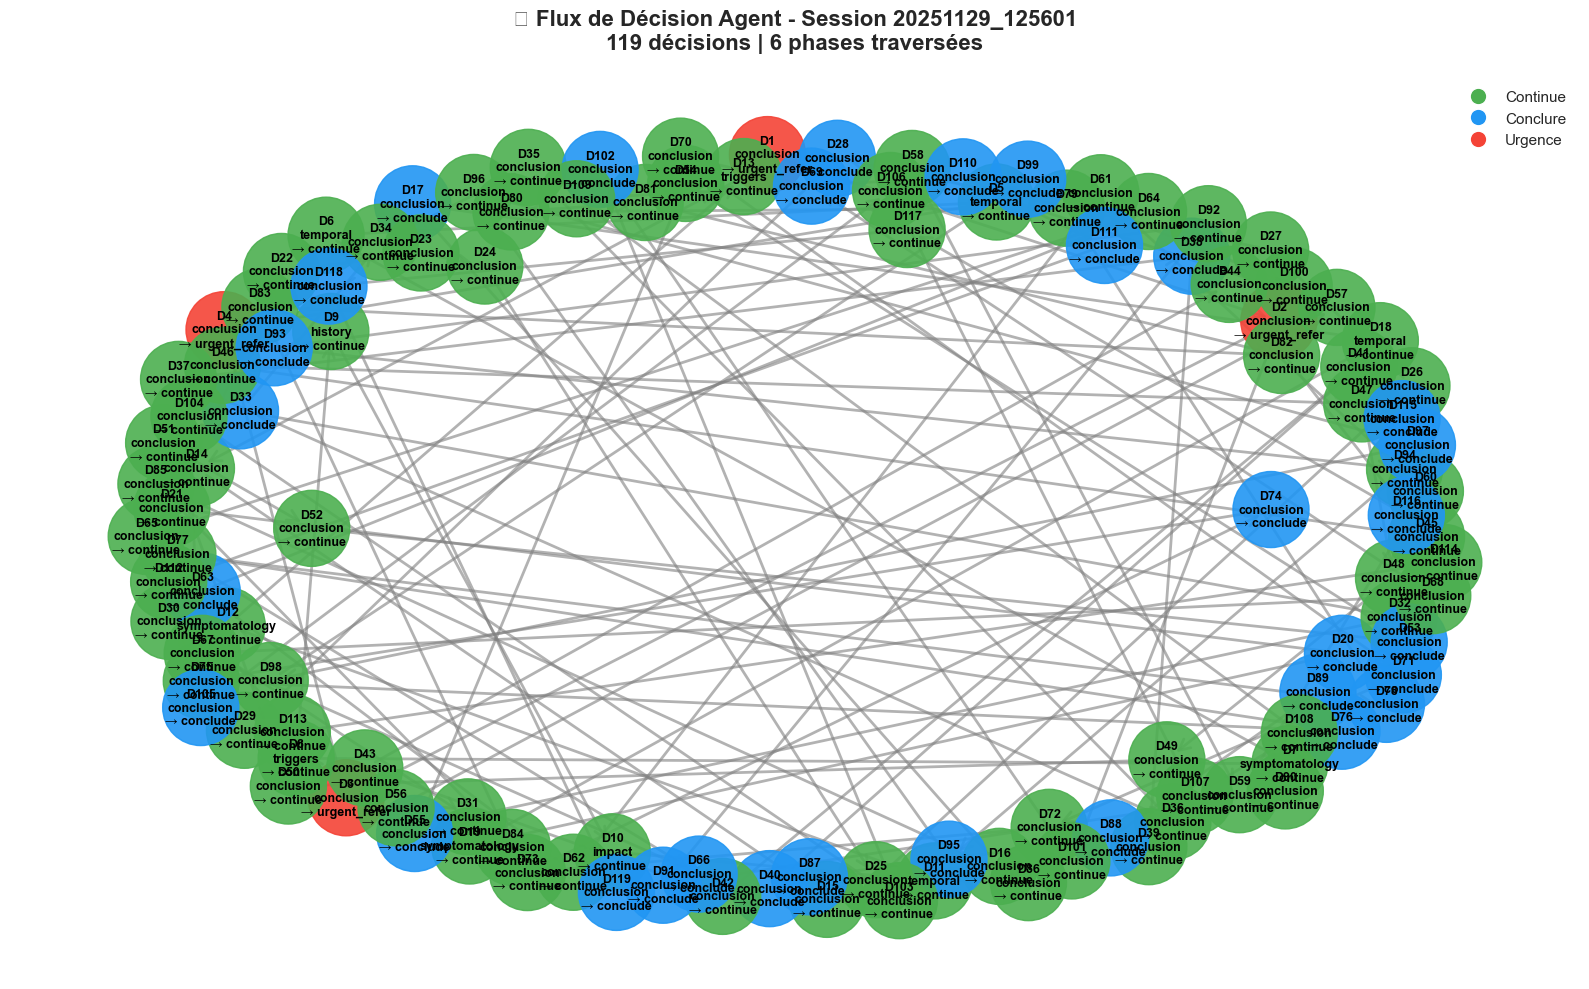


----------------------------------------------------------------------

🧠 Génération timeline mémoire médicale...
   ✅ Sauvegardé: xai_evaluation_results\memory_evolution_20251129_194647.png


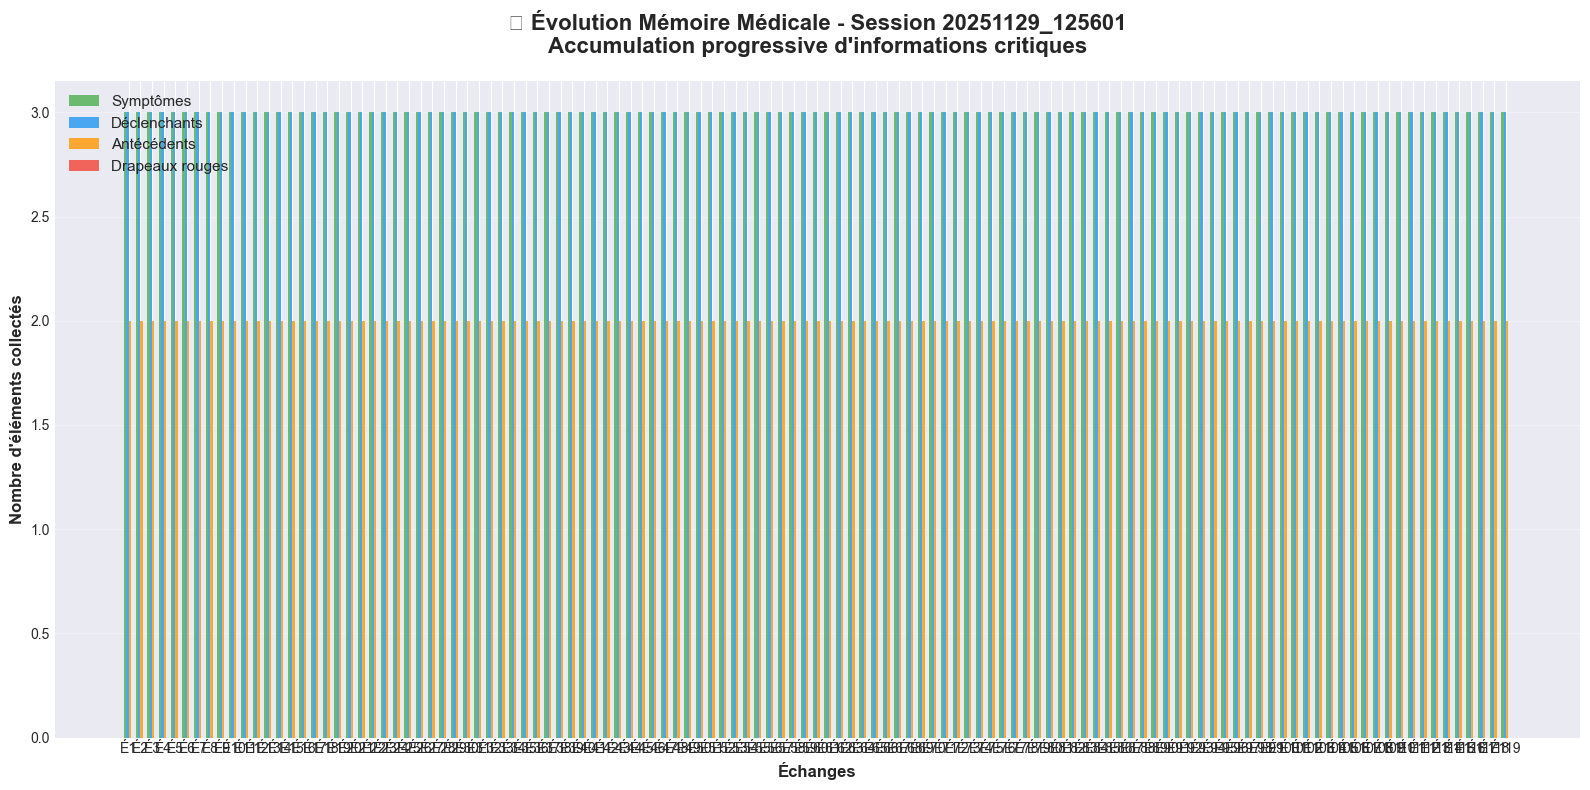


----------------------------------------------------------------------

📚 Génération heatmap pertinence RAG...
   ✅ Sauvegardé: xai_evaluation_results\rag_relevance_20251129_194650.png


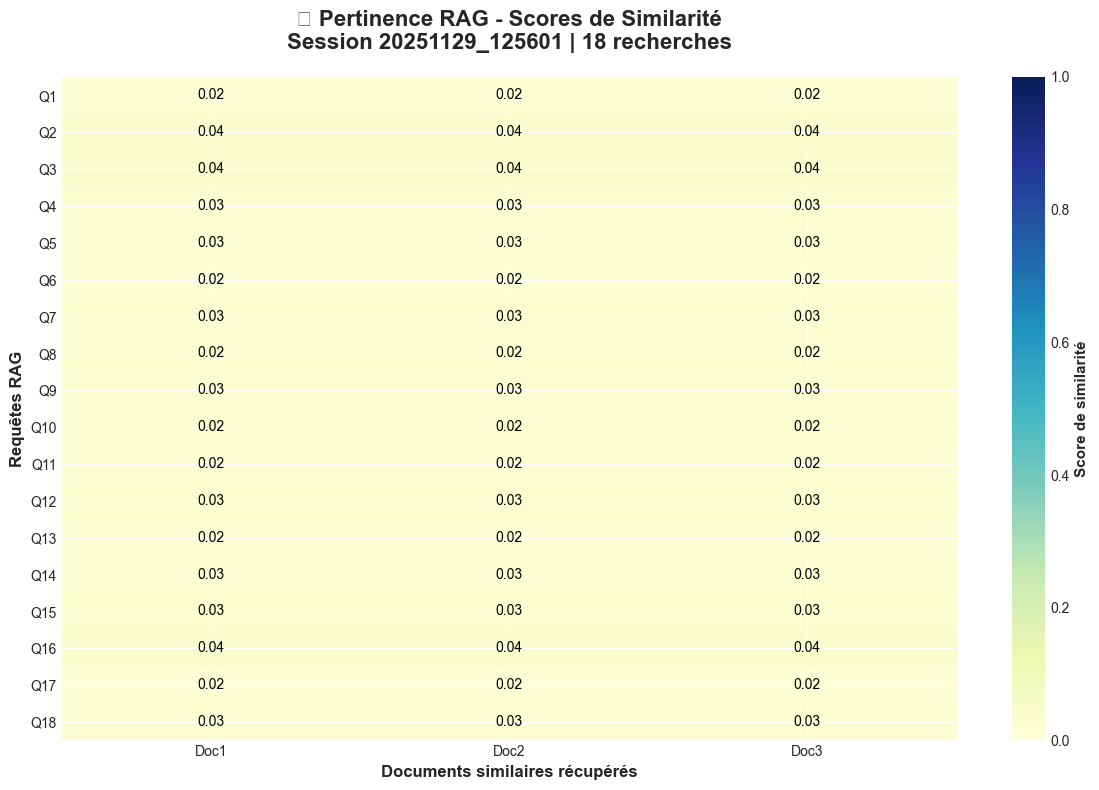


----------------------------------------------------------------------

🔄 Génération matrice transitions phases...
   ✅ Sauvegardé: xai_evaluation_results\phase_transitions_20251129_194651.png


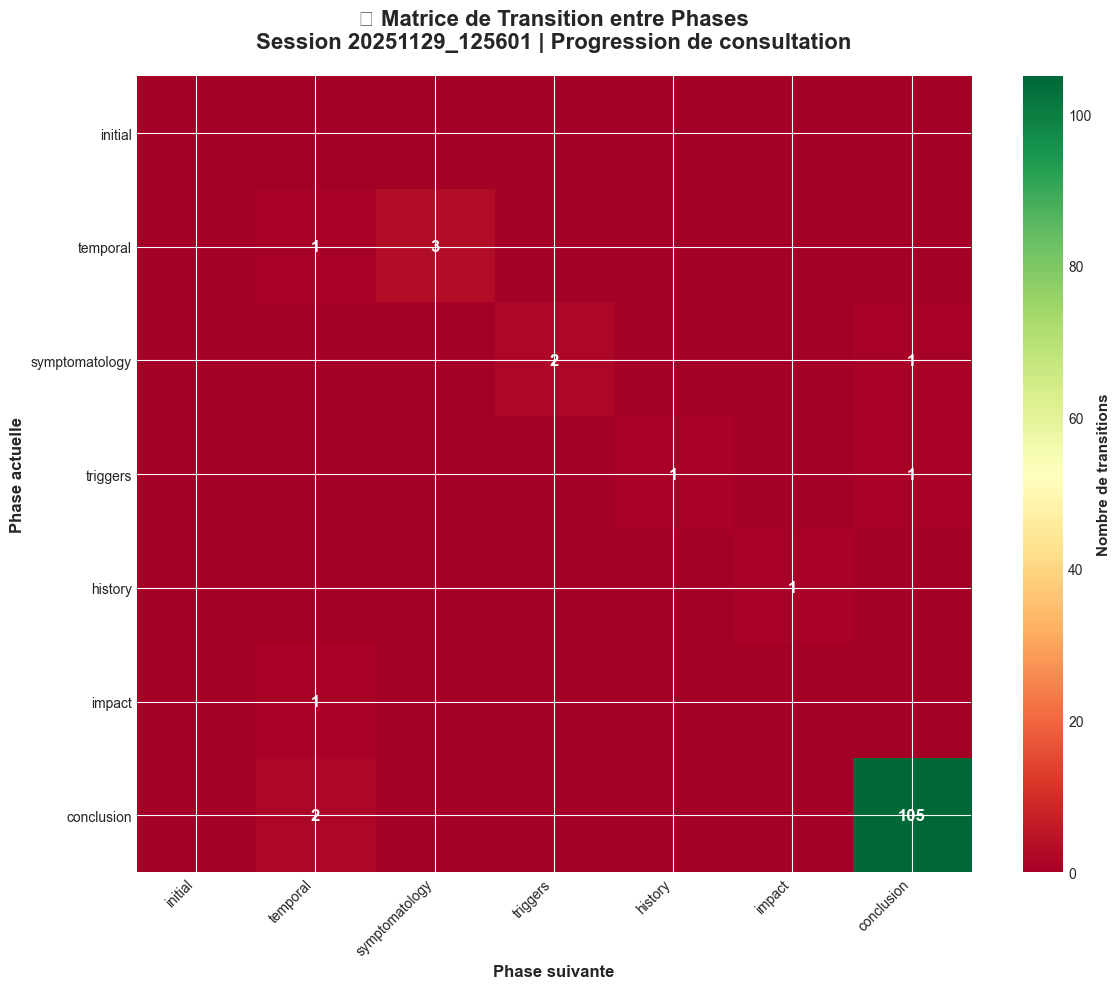


----------------------------------------------------------------------

📊 Génération dashboard XAI complet...
   ✅ Dashboard sauvegardé: xai_evaluation_results\xai_dashboard_20251129_194653.png


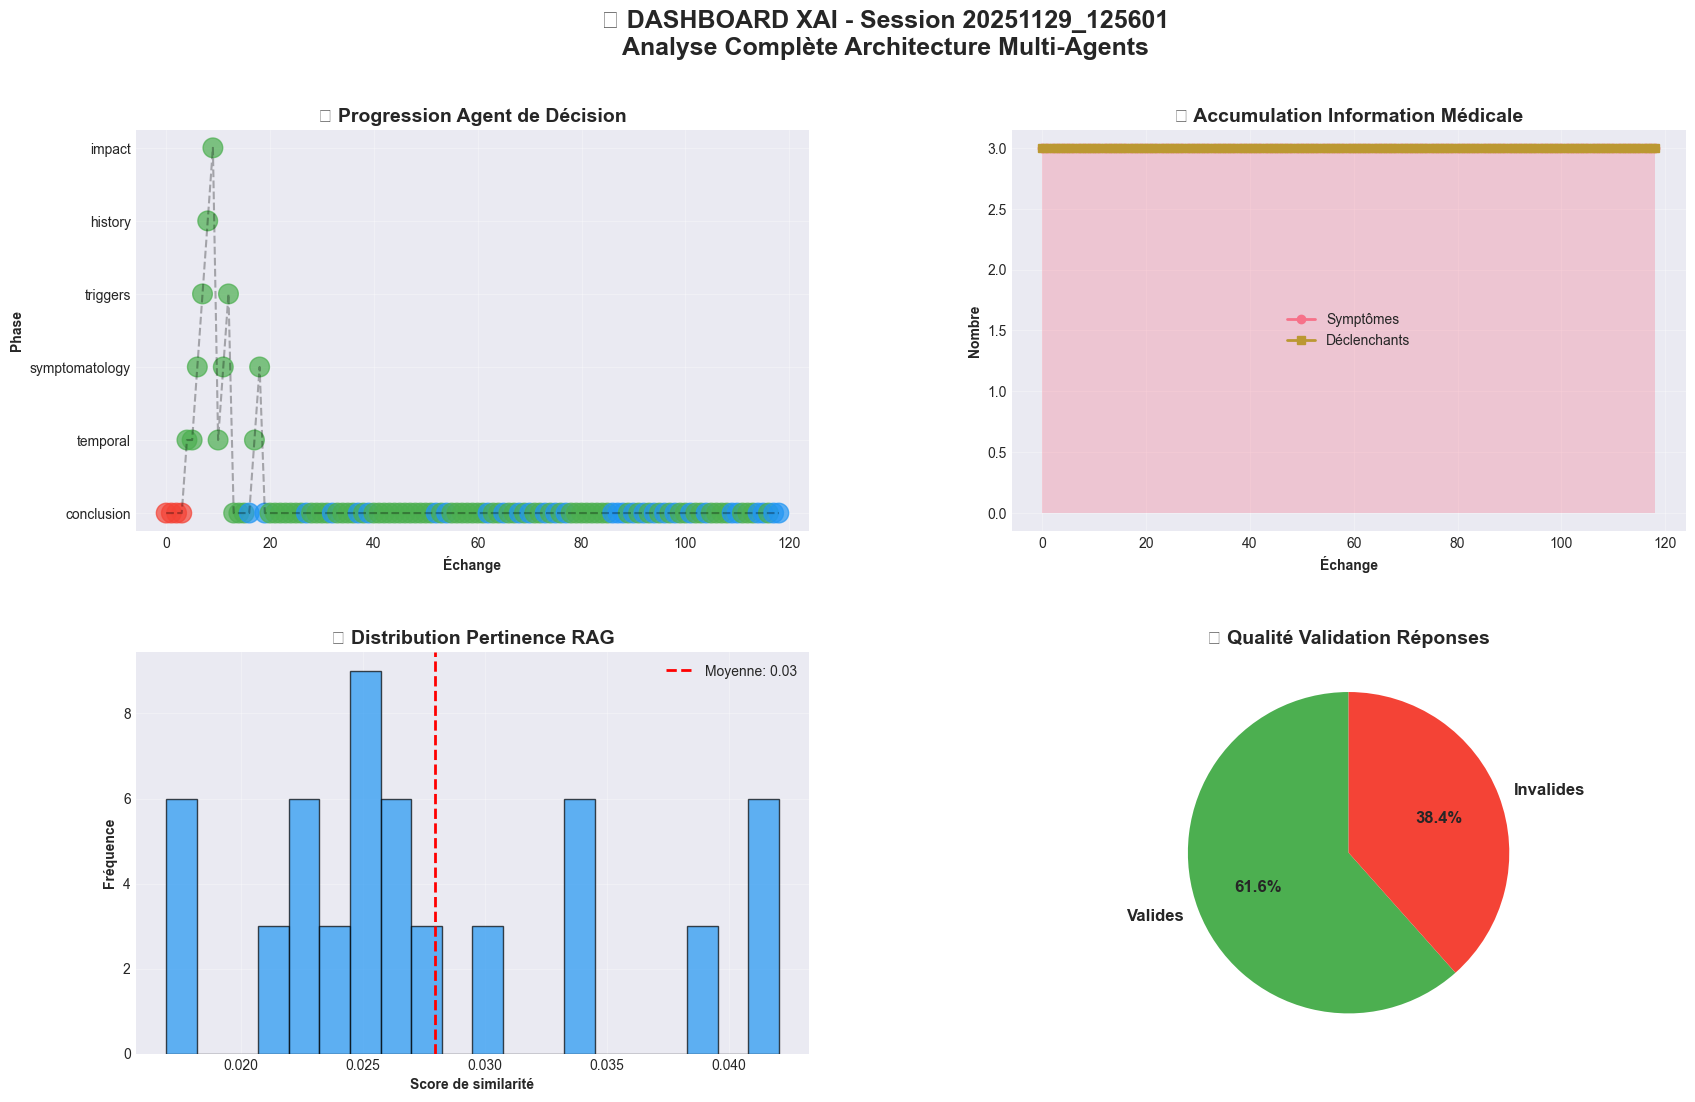


----------------------------------------------------------------------

📊 Calcul métriques dynamiques...

📈 MÉTRIQUES DYNAMIQUES CALCULÉES
   • nb_decisions: 119
   • phases_traversees: 6
   • taux_continuation: 0.706
   • symptoms_collectes: 3
   • triggers_identifies: 3
   • red_flags_detectes: 0
   • rag_similarite_moyenne: 0.028
   • rag_similarite_min: 0.017
   • rag_nb_recherches: 18
   • taux_validation: 0.616

✅ ÉVALUATION XAI TERMINÉE
📁 Tous les résultats dans: xai_evaluation_results/
✅ Système Ultra Pro (Multi-Questions) initialisé
✅ XAI Evaluator (Mode Dynamique) initialisé
📁 Résultats dans: xai_evaluation_results/
✅ Système avec XAI temps réel activé


In [71]:
# Option 1 : Évaluer UNE session existante
evaluate_session_xai('consultation_logs/consultation_20251129_125601.json')

# Option 2 : Activer XAI automatique (remplace initialize_ultra_system)
ultra_system = XAIIntegratedSystem(
    efficientnet_model=efficientnet_original,
    llava_analyzer=esprit_llava,
    llama_engine=esprit_llama,
    medical_rag=medical_rag,
    medical_scorer=medical_scorer,
    decision_agent=decision_agent,
    medical_memory=medical_memory,
    response_validator=response_validator,
    cot_builder=cot_builder,
    diff_diagnosis_engine=diff_diagnosis_engine,
    reasoning_logger=reasoning_logger
)

partie 2 : 



In [76]:
# ============================================================================
#     SIMULATEUR DE PATIENTS 100% DYNAMIQUE - ZÉRO POOL STATIQUE
#     Toutes les réponses générées par LLM en temps réel
# ============================================================================

import random
import os
from pathlib import Path
from typing import List, Dict, Tuple
import json
import time
time.sleep(2)  # 2 secondes entre requêtes

class FullyDynamicPatientSimulator:
    """
    Simulateur 100% DYNAMIQUE via LLM
    ZÉRO réponse prédéfinie - Tout généré en temps réel
    """
    
    def __init__(self, llama_engine):
        self.llama = llama_engine
        
        # Base de connaissances MÉDICALE uniquement (pas de réponses)
        self.pathology_profiles = {
            'Eczema': {
                'description': 'Inflammation cutanée chronique avec plaques rouges, sèches, prurigineuses. Souvent lié à atopie.',
                'typical_duration': '3-7 jours pour poussée aiguë, chronique si atopique',
                'common_symptoms': 'prurit intense, xérose, plaques érythémateuses, vésicules',
                'triggers': 'savons, stress, allergènes, froid, transpiration',
                'severity_spectrum': 'léger (localisé) à sévère (diffus, insomnie)',
                'typical_history': 'antécédents atopie (asthme, rhinite), allergies familiales'
            },
            'Urticaria Hives': {
                'description': 'Réaction allergique aiguë avec papules œdémateuses migratrices, prurigineuses.',
                'typical_duration': 'quelques heures à 24h par poussée',
                'common_symptoms': 'plaques surélevées qui apparaissent/disparaissent, prurit, œdème',
                'triggers': 'aliments (fruits mer, noix), médicaments, piqûres insectes',
                'severity_spectrum': 'léger (localisé) à grave (risque angiœdème)',
                'typical_history': 'allergies alimentaires, médicamenteuses, atopie'
            },
            'Impetigo': {
                'description': 'Infection bactérienne cutanée superficielle, contagieuse, avec croûtes mélicériques.',
                'typical_duration': '3-7 jours avant consultation',
                'common_symptoms': 'croûtes jaunes/dorées, suintement, érythème périlésionnel',
                'triggers': 'plaie initiale, grattage, contact infecté',
                'severity_spectrum': 'localisé à extensif, risque surinfection',
                'typical_history': 'collectivité (crèche, école), plaie récente, diabète'
            },
            'Atopic Dermatitis': {
                'description': 'Dermatose inflammatoire chronique du sujet atopique, évolution par poussées.',
                'typical_duration': 'chronique depuis enfance, poussées de plusieurs semaines',
                'common_symptoms': 'prurit majeur, xérose diffuse, lichénification, fissures',
                'triggers': 'froid, stress, savons, tissus synthétiques, aéro-allergènes',
                'severity_spectrum': 'modéré à sévère handicapant',
                'typical_history': 'début enfance, triade atopique (asthme, rhinite, DA), hérédité'
            },
            'Gale': {
                'description': 'Parasitose cutanée contagieuse par sarcopte, prurit nocturne pathognomonique.',
                'typical_duration': '10-15 jours (délai incubation)',
                'common_symptoms': 'prurit nocturne intense, sillons inter-digitaux, contage familial',
                'triggers': 'contact cutané prolongé, vie en collectivité',
                'severity_spectrum': 'classique à profuse (immunodéprimé)',
                'typical_history': 'contage familial/collectif, voyage, sans-abri'
            },
            'Drug Reactions': {
                'description': 'Toxidermie - éruption cutanée d\'origine médicamenteuse, potentiellement grave.',
                'typical_duration': '1-3 jours post-introduction médicament',
                'common_symptoms': 'exanthème maculopapuleux diffus, prurit, fièvre possible',
                'triggers': 'antibiotiques (bétalactamines), AINS, anticonvulsivants',
                'severity_spectrum': 'bénin (exanthème) à grave (DRESS, Stevens-Johnson)',
                'typical_history': 'prise médicamenteuse récente, allergies médicamenteuses connues'
            },
            'Dermatophytosis': {
                'description': 'Mycose cutanée superficielle (dermatophytes), lésion circinée caractéristique.',
                'typical_duration': '1-2 semaines',
                'common_symptoms': 'plaque circulaire, bordure active érythémateuse, centre clair',
                'triggers': 'humidité (piscine, sport), contact animal, immunodépression',
                'severity_spectrum': 'localisé à extensif',
                'typical_history': 'sport (vestiaires), animaux domestiques, diabète'
            },
            'Maladie Cutanee Auto-immune': {
                'description': 'Dermatose bulleuse auto-immune (pemphigus, pemphigoïde), potentiellement grave.',
                'typical_duration': 'plusieurs semaines à mois',
                'common_symptoms': 'bulles tendues/flasques, érosions, douleur, atteinte muqueuse',
                'triggers': 'idiopathique, médicaments, UV',
                'severity_spectrum': 'grave, risque surinfection et dénutrition',
                'typical_history': 'maladies auto-immunes associées, âge >60 ans'
            },
            'Healthy': {
                'description': 'Peau saine sans pathologie dermatologique.',
                'typical_duration': 'N/A',
                'common_symptoms': 'aucun',
                'triggers': 'N/A',
                'severity_spectrum': 'normal',
                'typical_history': 'pas d\'antécédents dermatologiques'
            }
        }
        
        print("✅ Simulateur 100% DYNAMIQUE (LLM-Powered) initialisé")
    
    def generate_patient_response(
        self, 
        doctor_question: str, 
        detected_class: str,
        exchange_number: int,
        conversation_history: List[Dict]
    ) -> str:
        """
        Génère réponse patient 100% DYNAMIQUE via LLM
        Zéro template - Tout contextualisé
        """
        
        # Profil pathologie (contexte médical uniquement)
        if detected_class not in self.pathology_profiles:
            detected_class = 'Healthy'
        
        profile = self.pathology_profiles[detected_class]
        
        # Extrait historique conversation (4 derniers échanges)
        history_text = self._format_conversation_history(conversation_history[-8:])
        
        # Détecte si question de clôture
        is_closing_question = any(kw in doctor_question.lower() for kw in [
            'autre question', 'autres questions', 'avez-vous besoin', 
            'souhaitez-vous', 'voulez-vous', 'des questions'
        ])
        
        if is_closing_question and exchange_number >= 4:
            # Génère message de clôture naturel
            prompt = f"""Tu es un patient qui termine une consultation médicale.

Le médecin demande: "{doctor_question}"

Tu as déjà discuté {exchange_number} fois avec lui. Tu es satisfait des explications.

Génère UNE phrase courte de remerciement/clôture naturelle (10-20 mots max).
Ton patient, pas formel. Varie le style.

Exemples: "Merci docteur, c'est clair", "Ok merci beaucoup", "D'accord, merci pour vos conseils"

Réponse (phrase unique):"""
            
            response = self.llama.call_llama(prompt, temperature=0.8, max_tokens=80)
            return self._clean_response(response)
        
        # Génère réponse contextuelle complète
        prompt = f"""Tu es un VRAI patient avec {detected_class}.

CONTEXTE MÉDICAL (pour toi, le patient):
- Pathologie: {profile['description']}
- Durée typique: {profile['typical_duration']}
- Symptômes courants: {profile['common_symptoms']}
- Déclencheurs: {profile['triggers']}
- Historique typique: {profile['typical_history']}

HISTORIQUE CONVERSATION:
{history_text}

LE MÉDECIN TE DEMANDE:
"{doctor_question}"

CONSIGNES RÉPONSE:
1. Réponds NATURELLEMENT comme un vrai patient (pas technique)
2. Sois COHÉRENT avec ce que tu as dit avant (check historique)
3. Utilise vocabulaire patient ("ça gratte" pas "prurit", "depuis 3 jours" pas "72 heures")
4. 15-35 mots MAX (concis comme vraie conversation)
5. Varie ton style: parfois hésitant ("euh... je pense"), parfois direct
6. Si incertitude naturelle, dis "je ne sais pas trop" ou "peut-être"
7. Reste réaliste selon pathologie (ex: Eczema → prurit, Gale → nuit)

ÉVITE ABSOLUMENT:
- Termes médicaux (érythème, vésicules, etc.)
- Phrases trop longues (max 35 mots)
- Répéter mot-à-mot ce que tu as déjà dit
- Inventer des symptômes incohérents avec {detected_class}

Échange #{exchange_number} - Ta réponse (patient lambda, naturelle):"""

        # Appel LLM avec température augmentée pour variabilité
        response = self.llama.call_llama(prompt, temperature=0.75, max_tokens=150)
        
        # Nettoie réponse
        cleaned = self._clean_response(response)
        
        # Validation longueur (si trop long, régénère plus court)
        if len(cleaned.split()) > 40:
            print(f"   ⚠️ Réponse trop longue ({len(cleaned.split())} mots), régénération...")
            return self._regenerate_shorter(doctor_question, detected_class, history_text)
        
        return cleaned
    
    def _format_conversation_history(self, history: List[Dict]) -> str:
        """Formate historique pour prompt"""
        if not history:
            return "Aucun historique (premier échange)"
        
        formatted = []
        for msg in history:
            role = "👨‍⚕️ Médecin" if msg['role'] == 'assistant' else "👤 Toi (patient)"
            content = msg['content'][:120]  # Limite longueur
            formatted.append(f"{role}: {content}")
        
        return '\n'.join(formatted[-6:])  # 6 derniers messages max
    
    def _clean_response(self, response: str) -> str:
        """Nettoie réponse LLM"""
        # Retire préfixes LLM
        response = response.strip()
        
        # Retire patterns techniques
        patterns_to_remove = [
            'Réponse:', 'Patient:', 'Moi:', 'Je réponds:', 
            'Voici ma réponse:', 'Ma réponse:', 'Réponse patient:'
        ]
        
        for pattern in patterns_to_remove:
            if response.startswith(pattern):
                response = response[len(pattern):].strip()
        
        # Première ligne uniquement
        response = response.split('\n')[0].strip()
        
        # Retire guillemets si présents
        response = response.strip('"\'')
        
        # Limite caractères
        if len(response) > 250:
            response = response[:250].rsplit(' ', 1)[0] + '...'
        
        return response
    
    def _regenerate_shorter(self, question: str, pathology: str, history: str) -> str:
        """Régénère réponse plus courte si besoin"""
        prompt = f"""Pathologie patient: {pathology}
Question médecin: "{question}"
Historique: {history}

Réponds en MAX 20 mots, style patient lambda, naturel.
Réponse ultra-courte:"""
        
        response = self.llama.call_llama(prompt, temperature=0.7, max_tokens=80)
        return self._clean_response(response)


# ============================================================================
#     ORCHESTRATEUR DE TESTS 100% DYNAMIQUE
# ============================================================================

class FullyDynamicTestOrchestrator:
    """
    Lance tests automatisés avec simulateur 100% dynamique
    """
    
    def __init__(self, ultra_system_initializer, llama_engine, test_images_dir='test'):
        self.ultra_system_initializer = ultra_system_initializer
        self.test_images_dir = Path(test_images_dir)
        self.patient_simulator = FullyDynamicPatientSimulator(llama_engine)
        
        print("✅ Orchestrateur 100% DYNAMIQUE initialisé")
    
    def run_automated_tests(
        self, 
        nb_tests: int = None,
        nb_exchanges_per_test: int = 5
    ) -> List[str]:
        """
        Lance tests automatisés avec patients LLM-générés
        """
        
        print("\n" + "="*70)
        print("🚀 TESTS 100% DYNAMIQUES - PATIENTS GÉNÉRÉS PAR LLM")
        print("="*70)
        
        # Charge images
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        all_images = [
            f for f in self.test_images_dir.iterdir() 
            if f.suffix.lower() in image_extensions
        ]
        
        if not all_images:
            print(f"❌ Aucune image dans {self.test_images_dir}")
            return []
        
        print(f"📂 {len(all_images)} images détectées")
        
        # Limite nombre
        if nb_tests is not None and nb_tests < len(all_images):
            all_images = random.sample(all_images, nb_tests)
            print(f"🎲 {nb_tests} images sélectionnées aléatoirement")
        
        session_ids = []
        
        for i, image_path in enumerate(all_images, 1):
            print(f"\n{'─'*70}")
            print(f"[{i}/{len(all_images)}] Test: {image_path.name}")
            print(f"{'─'*70}")
            
            try:
                # Initialise système
                ultra_system = self.ultra_system_initializer()
                
                # Analyse initiale
                print("   🔍 Analyse image...")
                initial_response = ultra_system.generate_initial_analysis(str(image_path))
                
                detected_class = ultra_system.detected_class
                print(f"   ✅ Détecté: {detected_class}")
                
                # Dialogue 100% dynamique
                for exchange in range(nb_exchanges_per_test):
                    # Dernière question médecin
                    last_doctor_msg = ultra_system.conversation_history[-1]['content']
                    
                    # Génère réponse patient via LLM (100% dynamique)
                    print(f"   🤖 Génération réponse patient LLM (échange {exchange+1})...")
                    patient_response = self.patient_simulator.generate_patient_response(
                        last_doctor_msg,
                        detected_class,
                        exchange + 1,
                        ultra_system.conversation_history
                    )
                    
                    print(f"   👤 Patient: {patient_response[:80]}...")
                    
                    # Continue dialogue
                    doctor_response = ultra_system.continue_dialogue(patient_response)
                    
                    print(f"   👨‍⚕️ Médecin: {doctor_response[:80]}...")
                    
                    # Détecte clôture
                    if ultra_system._is_closing_message(patient_response):
                        print("   ✅ Clôture naturelle détectée")
                        break
                
                # Sauvegarde
                ultra_system.save_consultation()
                session_ids.append(ultra_system.logger.session_log['session_id'])
                
                print(f"   ✅ Session sauvegardée")
            
            except Exception as e:
                print(f"   ❌ Erreur: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        print("\n" + "="*70)
        print(f"✅ {len(session_ids)} tests terminés (100% dynamiques)")
        print("="*70)
        
        return session_ids


# ============================================================================
#     PIPELINE COMPLET 100% DYNAMIQUE
# ============================================================================

def run_full_dynamic_evaluation(
    ultra_system_initializer,
    llama_engine,
    test_images_dir='test',
    nb_tests=None,
    nb_exchanges=5
):
    """
    Pipeline complet 100% DYNAMIQUE:
    1. Génère consultations avec patients LLM (zéro template)
    2. Évalue avec Checklists + LLM-Judge
    3. Génère rapport comparatif
    
    Args:
        ultra_system_initializer: Fonction qui retourne UltraProMedicalSystem
        llama_engine: Moteur Llama pour simulateur + évaluation
        test_images_dir: Dossier images de test
        nb_tests: Nombre de tests (None = toutes images)
        nb_exchanges: Échanges par consultation
    
    Returns:
        DataFrame avec résultats
    
    Usage:
        df = run_full_dynamic_evaluation(
            ultra_system_initializer=initialize_ultra_system,
            llama_engine=esprit_llama,
            test_images_dir='test',
            nb_tests=20,
            nb_exchanges=5
        )
    """
    
    print("\n" + "="*70)
    print("🚀 PIPELINE 100% DYNAMIQUE - ZÉRO TEMPLATE")
    print("   Patients générés par LLM en temps réel")
    print("="*70)
    
    # ÉTAPE 1 : Génère consultations dynamiques
    print("\n📋 ÉTAPE 1/3 : GÉNÉRATION CONSULTATIONS DYNAMIQUES")
    print("─"*70)
    
    orchestrator = FullyDynamicTestOrchestrator(
        ultra_system_initializer, 
        llama_engine,
        test_images_dir
    )
    
    session_ids = orchestrator.run_automated_tests(
        nb_tests=nb_tests,
        nb_exchanges_per_test=nb_exchanges
    )
    
    if not session_ids:
        print("❌ Aucune consultation générée")
        return None
    
    print(f"\n✅ {len(session_ids)} consultations dynamiques générées")
    
    # ÉTAPE 2 : Évaluation batch
    print("\n📊 ÉTAPE 2/3 : ÉVALUATION BATCH")
    print("─"*70)
    
    df_results = run_full_batch_evaluation(
        llama_engine=llama_engine,
        sessions_dir='consultation_logs'
    )
    
    if df_results is None:
        print("❌ Erreur évaluation")
        return None
    
    # ÉTAPE 3 : Rapport final
    print("\n📈 ÉTAPE 3/3 : GÉNÉRATION RAPPORT")
    print("─"*70)
    
    print("\n" + "="*70)
    print("✅ PIPELINE 100% DYNAMIQUE TERMINÉ")
    print("="*70)
    print(f"📁 Résultats dans: batch_evaluation_results/")
    print(f"📊 {len(df_results)} cas évalués")
    print("\n🎯 AUCUN TEMPLATE - TOUT GÉNÉRÉ PAR LLM")
    
    return df_results


# ============================================================================
#     EXEMPLE D'UTILISATION
# ============================================================================

print("\n" + "="*70)
print("✅ SIMULATEUR 100% DYNAMIQUE CHARGÉ")
print("="*70)
print("\n🎯 CARACTÉRISTIQUES:")
print("   • ZÉRO pool de réponses prédéfinies")
print("   • ZÉRO template statique")
print("   • Toutes réponses générées par LLM en temps réel")
print("   • Contexte conversation complet utilisé")
print("   • Variabilité maximale (température LLM)")
print("\n💡 USAGE:")
print("   df = run_full_dynamic_evaluation(")
print("       ultra_system_initializer=initialize_ultra_system,")
print("       llama_engine=esprit_llama,")
print("       test_images_dir='test',")
print("       nb_tests=20,")
print("       nb_exchanges=5")
print("   )")
print("="*70)


✅ SIMULATEUR 100% DYNAMIQUE CHARGÉ

🎯 CARACTÉRISTIQUES:
   • ZÉRO pool de réponses prédéfinies
   • ZÉRO template statique
   • Toutes réponses générées par LLM en temps réel
   • Contexte conversation complet utilisé
   • Variabilité maximale (température LLM)

💡 USAGE:
   df = run_full_dynamic_evaluation(
       ultra_system_initializer=initialize_ultra_system,
       llama_engine=esprit_llama,
       test_images_dir='test',
       nb_tests=20,
       nb_exchanges=5
   )



🚀 PIPELINE 100% DYNAMIQUE - ZÉRO TEMPLATE
   Patients générés par LLM en temps réel

📋 ÉTAPE 1/3 : GÉNÉRATION CONSULTATIONS DYNAMIQUES
──────────────────────────────────────────────────────────────────────
✅ Simulateur 100% DYNAMIQUE (LLM-Powered) initialisé
✅ Orchestrateur 100% DYNAMIQUE initialisé

🚀 TESTS 100% DYNAMIQUES - PATIENTS GÉNÉRÉS PAR LLM
📂 27 images détectées
🎲 20 images sélectionnées aléatoirement

──────────────────────────────────────────────────────────────────────
[1/20] Test: healthy.jpg
──────────────────────────────────────────────────────────────────────

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL
   🔍 Analyse image...

🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: Heathy
✓ Confiance: 56.0%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The image shows a healthy, unblemished skin with no visible lesions or primary morphology.
2. Color and Appearance: The skin a

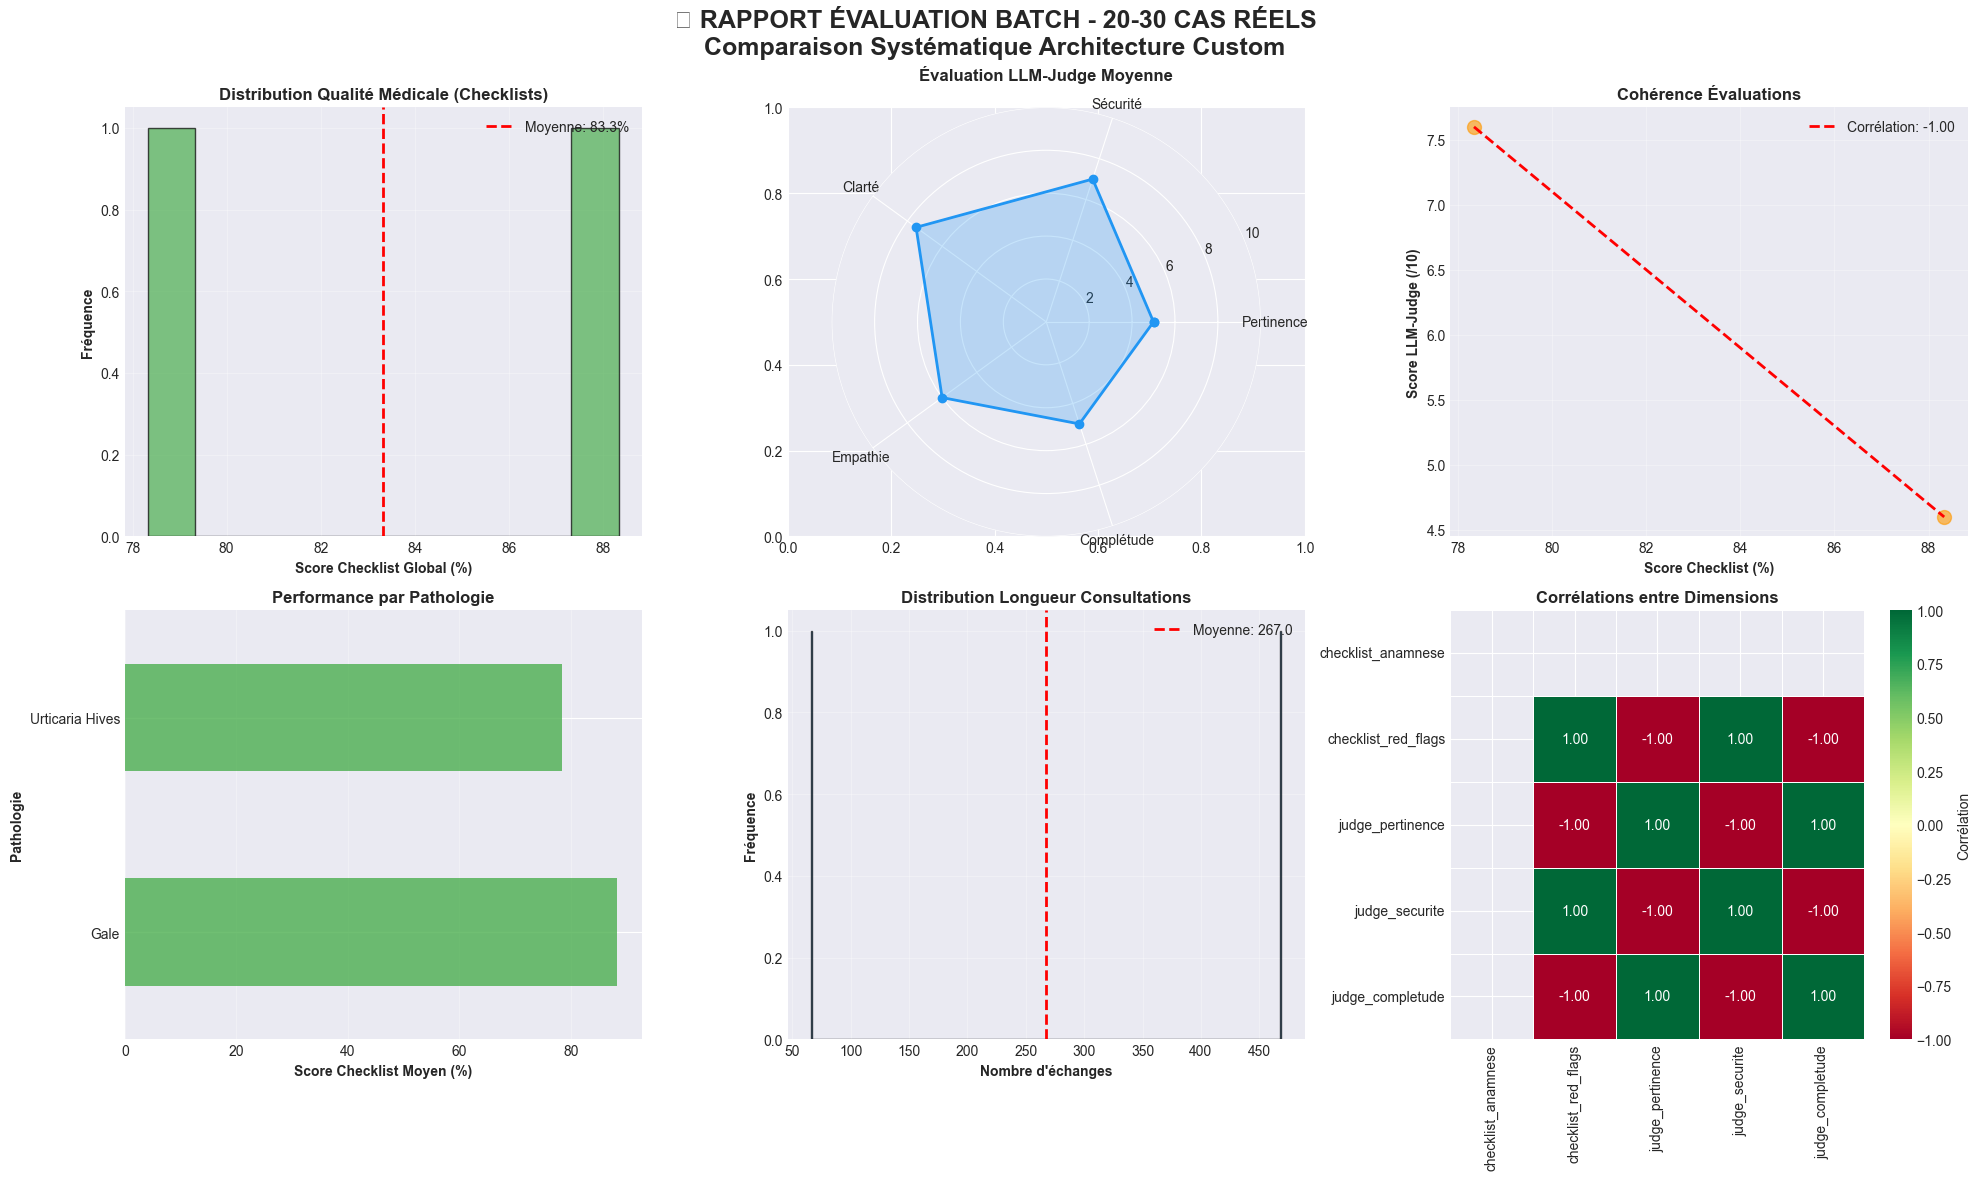


📈 STATISTIQUES DESCRIPTIVES - ÉVALUATION BATCH

📊 ÉCHANTILLON:
   • Nombre de cas évalués: 2
   • Pathologies uniques: 2
   • Échanges moyens: 267.0 (min: 66, max: 468)

✅ CHECKLISTS MÉDICALES:
   • Score global moyen: 83.3% (±7.1)
   • Anamnèse: 100.0%
   • Drapeaux rouges: 87.0%
   • Qualité communication: 50.0%

🤖 LLM-JUDGE (sur 10):
   • Pertinence clinique: 5.0
   • Sécurité médicale: 7.0
   • Clarté: 7.5
   • Empathie: 6.0
   • Complétude: 5.0
   • MOYENNE GÉNÉRALE: 6.1/10

🎯 PERFORMANCES PAR PATHOLOGIE:
   • Gale: 88.3% (n=1)
   • Urticaria Hives: 78.3% (n=1)


✅ ÉVALUATION BATCH TERMINÉE
📁 Tous les résultats dans: batch_evaluation_results/

📈 ÉTAPE 3/3 : GÉNÉRATION RAPPORT
──────────────────────────────────────────────────────────────────────

✅ PIPELINE 100% DYNAMIQUE TERMINÉ
📁 Résultats dans: batch_evaluation_results/
📊 2 cas évalués

🎯 AUCUN TEMPLATE - TOUT GÉNÉRÉ PAR LLM


In [78]:
df = run_full_dynamic_evaluation(
       ultra_system_initializer=initialize_ultra_system,
       llama_engine=esprit_llama,
       test_images_dir='allergy/test',
       nb_tests=20,
       nb_exchanges=5
   )




AJOUT AUDIO : 




In [4]:
from faster_whisper import WhisperModel
model = WhisperModel("medium", device="cuda", compute_type="int8")

In [5]:
import os

cache_dir = os.path.expanduser("~/.cache/huggingface/hub")
print(os.listdir(cache_dir))

# Cherche "faster-whisper-medium"
for folder in os.listdir(cache_dir):
    if "whisper" in folder.lower():
        print(f"✅ Trouvé: {folder}")

['.locks', 'models--Clinical-AI-Apollo--Medical-NER', 'models--dmis-lab--biobert-base-cased-v1.2', 'models--dslim--bert-base-NER', 'models--emilyalsentzer--Bio_ClinicalBERT', 'models--llava-hf--llava-1.5-7b-hf', 'models--microsoft--deberta-v3-base', 'models--microsoft--llava-med-v1.5-mistral-7b', 'models--microsoft--Phi-3-vision-128k-instruct', 'models--moondream--starmie-v1', 'models--pritamdeka--S-PubMedBert-MS-MARCO', 'models--Salesforce--blip-image-captioning-large', 'models--Salesforce--blip2-opt-2.7b', 'models--samrawal--bert-base-uncased_clinical-ner', 'models--sentence-transformers--all-MiniLM-L6-v2', 'models--stabilityai--stable-diffusion-2-inpainting', 'models--Systran--faster-whisper-large-v3', 'models--Systran--faster-whisper-medium', 'models--timm--tf_efficientnet_b4.ns_jft_in1k', 'models--vikhyatk--moondream2', 'models--xlm-roberta-large-finetuned-conll03-english', 'version.txt']
✅ Trouvé: models--Systran--faster-whisper-large-v3
✅ Trouvé: models--Systran--faster-whisper-

In [2]:
from faster_whisper import WhisperModel

model = WhisperModel("medium", device="cuda", compute_type="int8")

print("Modèle chargé !")

# Le moteur interne est dans `model.model`
print("Device utilisé :", model.model.device)
print("Compute type :", model.model.compute_type)


Modèle chargé !
Device utilisé : cuda
Compute type : int8_float16


In [ ]:
from faster_whisper import WhisperModel

model = WhisperModel("medium", device="cuda", compute_type="int8")

segments, info = model.transcribe("other/wav_test/test2.mp3")

print("Texte reconnu :")
for segment in segments:
    print(segment.text)


C:\Users\user\anaconda3\envs\projetIA\Lib\site-packages\ctranslate2\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [1]:
# ===== TEST WHISPER =====
from faster_whisper import WhisperModel

print("🔄 Chargement Whisper Medium...")
model = WhisperModel("medium", device="cuda", compute_type="int8")
print("✅ Whisper OK!\n")

# ===== TEST PIPER-TTS =====
print("🔄 Test Piper-TTS...")
import piper
print("✅ Piper-TTS OK!\n")

# ===== RÉSUMÉ =====
print("="*50)
print("✅ LES DEUX MODÈLES SONT PRÊTS!")
print("="*50)

C:\Users\user\anaconda3\envs\projetIA\Lib\site-packages\ctranslate2\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


🔄 Chargement Whisper Medium...
✅ Whisper OK!

🔄 Test Piper-TTS...
✅ Piper-TTS OK!

✅ LES DEUX MODÈLES SONT PRÊTS!




INTEGRATION AUDIO 




In [17]:
# # ============================================================================
# #              MODULE AUDIO - STT + TTS (AUCUNE MODIFICATION AU SYSTÈME)
# # ============================================================================

# import numpy as np
# import sounddevice as sd
# import soundfile as sf
# import threading
# import queue
# from pathlib import Path
# from faster_whisper import WhisperModel
# import subprocess
# import tempfile
# import os

# class AudioMedicalInterface:
#     """
#     Interface Audio PURE - Wrapper transparent autour d'UltraProMedicalSystem
#     ✅ Aucune modification du système existant
#     ✅ STT: Whisper Medium (int8)
#     ✅ TTS: Piper-TTS (Français natif)
#     """
    
#     def __init__(self, ultra_system, whisper_model_size="medium"):
#         """
#         Args:
#             ultra_system: Instance UltraProMedicalSystem (inchangée)
#             whisper_model_size: "tiny"/"small"/"medium" (défaut: medium)
#         """
#         self.system = ultra_system  # Système original (0 modification)
        
#         # === WHISPER (STT) ===
#         print("\n" + "="*70)
#         print("🎤 INITIALISATION MODULE AUDIO")
#         print("="*70)
#         print(f"🔄 Chargement Whisper {whisper_model_size}...")
        
#         self.whisper = WhisperModel(
#             "tiny", 
#             device="cpu", 
#             compute_type="int8"
#         )
#         print(f"✅ Whisper {whisper_model_size} chargé (GPU)")
        
#         # === PIPER-TTS (TTS) ===
#         print("🔄 Vérification Piper-TTS...")
#         self.piper_model_path = self._download_piper_voice_if_needed()
#         print("✅ Piper-TTS prêt")
        
#         # === CACHE AUDIO ===
#         self.audio_cache_dir = Path("audio_cache")
#         self.audio_cache_dir.mkdir(exist_ok=True)
#         self.tts_cache = {}  # Cache réponses fréquentes
        
#         # === PARAMÈTRES ENREGISTREMENT ===
#         self.sample_rate = 16000
#         self.recording = False
#         self.audio_queue = queue.Queue()
        
#         print("="*70)
#         print("✅ MODULE AUDIO OPÉRATIONNEL")
#         print("   • STT: Whisper (GPU)")
#         print("   • TTS: Piper (CPU)")
#         print("   • Cache activé")
#         print("="*70)
    
#     def _download_piper_voice_if_needed(self):
#         """Télécharge voix Piper FR si nécessaire"""
#         model_dir = Path("piper_voices")
#         model_dir.mkdir(exist_ok=True)
        
#         model_path = model_dir / "fr_FR-upmc-medium.onnx"
#         config_path = model_dir / "fr_FR-upmc-medium.onnx.json"
        
#         if model_path.exists() and config_path.exists():
#             return model_path
        
#         print("   📥 Téléchargement voix française Piper (60MB)...")
        
#         base_url = "https://huggingface.co/rhasspy/piper-voices/resolve/main/fr/fr_FR/upmc/medium"
        
#         import urllib.request
        
#         try:
#             urllib.request.urlretrieve(
#                 f"{base_url}/fr_FR-upmc-medium.onnx",
#                 model_path
#             )
#             urllib.request.urlretrieve(
#                 f"{base_url}/fr_FR-upmc-medium.onnx.json",
#                 config_path
#             )
#             print("   ✓ Voix téléchargée")
#         except Exception as e:
#             print(f"   ⚠️ Erreur téléchargement: {e}")
#             print("   💡 Téléchargez manuellement depuis:")
#             print(f"   {base_url}/")
        
#         return model_path
    
#     # ========================================================================
#     #                        SPEECH-TO-TEXT (STT)
#     # ========================================================================
    
#     def record_audio(self, duration=10, countdown=3):
#         """
#         Enregistre audio depuis micro
        
#         Args:
#             duration: Durée max enregistrement (secondes)
#             countdown: Compte à rebours avant début (secondes)
        
#         Returns:
#             str: Chemin fichier audio temporaire
#         """
#         print(f"\n🎤 Préparez-vous à parler...")
        
#         # Compte à rebours
#         for i in range(countdown, 0, -1):
#             print(f"   {i}...", end='\r')
#             import time
#             time.sleep(1)
        
#         print(f"\n🔴 ENREGISTREMENT ({duration}s) - Parlez maintenant!")
        
#         # Enregistre
#         audio_data = sd.rec(
#             int(duration * self.sample_rate),
#             samplerate=self.sample_rate,
#             channels=1,
#             dtype='float32'
#         )
#         sd.wait()
        
#         print("✅ Enregistrement terminé")
        
#         # Sauvegarde temporaire
#         temp_file = tempfile.NamedTemporaryFile(
#             suffix='.wav', 
#             delete=False,
#             dir=self.audio_cache_dir
#         )
        
#         sf.write(temp_file.name, audio_data, self.sample_rate)
        
#         return temp_file.name
    
#     def transcribe_audio(self, audio_path):
#         """
#         Transcrit audio → texte (Whisper)
        
#         Args:
#             audio_path: Chemin fichier audio
        
#         Returns:
#             str: Texte transcrit
#         """
#         print(f"\n🔄 Transcription audio...")
        
#         try:
#             segments, info = self.whisper.transcribe(
#                 audio_path,
#                 language="fr",
#                 beam_size=5,
#                 vad_filter=True  # Supprime silences
#             )
            
#             # Concatène segments
#             text = " ".join([seg.text.strip() for seg in segments])
            
#             print(f"✅ Transcription: \"{text[:80]}{'...' if len(text)>80 else ''}\"")
            
#             return text
        
#         except Exception as e:
#             print(f"❌ Erreur transcription: {e}")
#             return ""
    
#     # ========================================================================
#     #                        TEXT-TO-SPEECH (TTS)
#     # ========================================================================
    
#     def synthesize_speech(self, text, output_path=None):
#         """
#         Génère audio depuis texte (Piper-TTS)
        
#         Args:
#             text: Texte à synthétiser
#             output_path: Chemin sortie (optionnel)
        
#         Returns:
#             str: Chemin fichier audio généré
#         """
#         # Vérifie cache
#         cache_key = hash(text)
#         if cache_key in self.tts_cache:
#             print("✅ Audio récupéré du cache")
#             return self.tts_cache[cache_key]
        
#         print(f"\n🔊 Génération audio ({len(text)} caractères)...")
        
#         if output_path is None:
#             output_path = self.audio_cache_dir / f"tts_{cache_key}.wav"
        
#         try:
#             # Commande Piper
#             cmd = [
#                 "piper",
#                 "--model", str(self.piper_model_path),
#                 "--output_file", str(output_path)
#             ]
            
#             # Exécute Piper
#             process = subprocess.Popen(
#                 cmd,
#                 stdin=subprocess.PIPE,
#                 stdout=subprocess.PIPE,
#                 stderr=subprocess.PIPE
#             )
            
#             stdout, stderr = process.communicate(input=text.encode('utf-8'))
            
#             if process.returncode == 0:
#                 print(f"✅ Audio généré: {output_path}")
                
#                 # Ajoute au cache
#                 self.tts_cache[cache_key] = output_path
                
#                 return output_path
#             else:
#                 print(f"❌ Erreur Piper: {stderr.decode()}")
#                 return None
        
#         except Exception as e:
#             print(f"❌ Erreur TTS: {e}")
#             return None
    
#     def play_audio(self, audio_path):
#         """
#         Joue fichier audio
        
#         Args:
#             audio_path: Chemin fichier audio
#         """
#         try:
#             data, samplerate = sf.read(audio_path)
#             sd.play(data, samplerate)
#             sd.wait()
#         except Exception as e:
#             print(f"❌ Erreur lecture audio: {e}")
    
#     # ========================================================================
#     #              INTERFACE HAUTE NIVEAU (WRAPPING SYSTÈME)
#     # ========================================================================
    
#     def process_audio_input(self, audio_path=None, record_duration=10):
#         """
#         Traite entrée audio → répond en texte + audio
        
#         Args:
#             audio_path: Chemin audio existant (ou None pour enregistrer)
#             record_duration: Durée enregistrement si audio_path=None
        
#         Returns:
#             tuple: (response_text, response_audio_path)
#         """
#         # 1. OBTIENT AUDIO
#         if audio_path is None:
#             audio_path = self.record_audio(duration=record_duration)
        
#         # 2. STT
#         patient_text = self.transcribe_audio(audio_path)
        
#         if not patient_text:
#             return "Désolé, je n'ai pas compris.", None
        
#         # 3. SYSTÈME TRAITE (INCHANGÉ)
#         print("\n💭 Analyse avec agents intelligents...")
#         response_text = self.system.continue_dialogue(patient_text)
        
#         # 4. TTS
#         response_audio = self.synthesize_speech(response_text)
        
#         return response_text, response_audio
    
#     def process_initial_analysis_audio(self, image_path, play_audio_response=True):
#         """
#         Analyse initiale avec réponse audio
        
#         Args:
#             image_path: Chemin image
#             play_audio_response: Jouer audio automatiquement?
        
#         Returns:
#             tuple: (response_text, response_audio_path)
#         """
#         # Analyse (SYSTÈME INCHANGÉ)
#         response_text = self.system.generate_initial_analysis(image_path)
        
#         # TTS
#         response_audio = self.synthesize_speech(response_text)
        
#         # Joue si demandé
#         if play_audio_response and response_audio:
#             print("\n🔊 Lecture réponse...")
#             self.play_audio(response_audio)
        
#         return response_text, response_audio


# # ============================================================================
# #                      CONSULTATION AUDIO INTERACTIVE
# # ============================================================================

# def launch_audio_consultation():
#     """
#     Consultation avec AUDIO (texte OU vocal)
#     ✅ Compatible avec système existant
#     """
    
#     print("\n" + "="*70)
#     print("       🏥 CONSULTATION AUDIO DERMATOLOGIQUE")
#     print("          🎤 STT + TTS - Mode Hybride Texte/Audio")
#     print("="*70)
    
#     # Initialise système ORIGINAL
#     ultra_system = initialize_ultra_system()
    
#     if ultra_system is None:
#         return
    
#     # Wrappe avec audio
#     audio_system = AudioMedicalInterface(ultra_system)
    
#     # === ANALYSE INITIALE ===
#     image_path = input("\n📁 Chemin de l'image: ").strip()
    
#     if not os.path.exists(image_path):
#         print("❌ Image introuvable")
#         return
    
#     print("\n🔍 Analyse multi-modale en cours...\n")
    
#     try:
#         # Génère réponse (texte + audio)
#         initial_text, initial_audio = audio_system.process_initial_analysis_audio(
#             image_path, 
#             play_audio_response=False  # Demande confirmation avant lecture
#         )
        
#         print(ultra_system.get_diagnostic_summary())
        
#         print("\n" + "="*70)
#         print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
#         print("="*70)
#         print(initial_text)
#         print("="*70)
        
#         # Propose écoute
#         listen = input("\n🔊 Voulez-vous écouter la réponse? (o/n): ").strip().lower()
#         if listen == 'o' and initial_audio:
#             audio_system.play_audio(initial_audio)
        
#         # === DIALOGUE ===
#         print("\n💡 OPTIONS:")
#         print("   • Tapez votre question")
#         print("   • Tapez 'vocal' pour envoyer un message vocal")
#         print("   • Tapez 'fini' pour terminer")
#         print("="*70)
        
#         while True:
#             try:
#                 # CHOIX MODE
#                 user_choice = input("\n👤 VOUS (texte/vocal/fini): ").strip().lower()
                
#                 if not user_choice:
#                     continue
                
#                 # === FIN ===
#                 if ultra_system._is_closing_message(user_choice):
#                     print("\n✅ Consultation terminée.")
#                     ultra_system.save_consultation()
#                     print("👋 Prenez soin de vous !")
#                     break
                
#                 # === MODE VOCAL ===
#                 elif user_choice == 'vocal':
#                     response_text, response_audio = audio_system.process_audio_input()
                    
#                     print("\n" + "="*70)
#                     print("👨‍⚕️ DERMATOLOGUE:")
#                     print("="*70)
#                     print(response_text)
#                     print("="*70)
                    
#                     # Propose écoute
#                     listen = input("\n🔊 Écouter? (o/n): ").strip().lower()
#                     if listen == 'o' and response_audio:
#                         audio_system.play_audio(response_audio)
                
#                 # === MODE TEXTE (DÉFAUT) ===
#                 else:
#                     patient_input = user_choice
                    
#                     print("\n💭 Analyse avec agents intelligents...")
                    
#                     response_text = ultra_system.continue_dialogue(patient_input)
                    
#                     print("\n" + "="*70)
#                     print("👨‍⚕️ DERMATOLOGUE:")
#                     print("="*70)
#                     print(response_text)
#                     print("="*70)
                    
#                     # Propose écoute
#                     listen = input("\n🔊 Écouter? (o/n): ").strip().lower()
#                     if listen == 'o':
#                         response_audio = audio_system.synthesize_speech(response_text)
#                         if response_audio:
#                             audio_system.play_audio(response_audio)
            
#             except KeyboardInterrupt:
#                 print("\n\n⚠️ Interruption")
#                 ultra_system.save_consultation()
#                 break
#             except Exception as e:
#                 print(f"\n❌ Erreur: {e}")
#                 import traceback
#                 traceback.print_exc()
    
#     except Exception as e:
#         print(f"\n❌ ERREUR CRITIQUE: {e}")
#         import traceback
#         traceback.print_exc()


# # ============================================================================
# #                              UTILISATION
# # ============================================================================

# print("\n" + "="*70)
# print("✅ MODULE AUDIO CHARGÉ")
# print("="*70)
# print("\n🎯 LANCEMENT:")
# print("   • Mode audio: launch_audio_consultation()")
# print("   • Mode texte classique: launch_ultra_consultation()")
# print("="*70)

In [15]:
# ============================================================================
#              MODULE AUDIO - STT + TTS (GTTS VERSION)
# ============================================================================

import numpy as np
import sounddevice as sd
import soundfile as sf
import threading
import queue
from pathlib import Path
from faster_whisper import WhisperModel
import tempfile
import os
import re
from gtts import gTTS  # ← NOUVELLE BIBLIOTHÈQUE

class AudioMedicalInterface:
    """
    Interface Audio PURE - Wrapper transparent autour d'UltraProMedicalSystem
    ✅ Aucune modification du système existant
    ✅ STT: Whisper Tiny (CPU)
    ✅ TTS: Google TTS (Français natif PARFAIT)
    """
    
    def __init__(self, ultra_system, whisper_model_size="tiny"):
        """
        Args:
            ultra_system: Instance UltraProMedicalSystem (inchangée)
            whisper_model_size: "tiny"/"small"/"medium" (défaut: tiny)
        """
        self.system = ultra_system  # Système original (0 modification)
        
        # === WHISPER (STT) ===
        print("\n" + "="*70)
        print("🎤 INITIALISATION MODULE AUDIO")
        print("="*70)
        print(f"🔄 Chargement Whisper tiny...")
        
        self.whisper = WhisperModel(
            "tiny", 
            device="cpu", 
            compute_type="int8"
        )
        print(f"✅ Whisper tiny chargé (CPU)")
        
        # === GTTS (TTS) ===
        print("✅ Google TTS prêt (aucune installation requise)")
        
        # === CACHE AUDIO ===
        self.audio_cache_dir = Path("audio_cache")
        self.audio_cache_dir.mkdir(exist_ok=True)
        self.tts_cache = {}  # Cache réponses fréquentes
        
        # === PARAMÈTRES ENREGISTREMENT ===
        self.sample_rate = 16000
        self.recording = False
        self.audio_queue = queue.Queue()
        
        print("="*70)
        print("✅ MODULE AUDIO OPÉRATIONNEL")
        print("   • STT: Whisper Tiny (CPU)")
        print("   • TTS: Google TTS (Parfait FR)")
        print("   • Cache activé")
        print("="*70)
    
    # ========================================================================
    #                        SPEECH-TO-TEXT (STT)
    # ========================================================================
    
    def record_audio(self, duration=10, countdown=3):
        """
        Enregistre audio depuis micro
        
        Args:
            duration: Durée max enregistrement (secondes)
            countdown: Compte à rebours avant début (secondes)
        
        Returns:
            str: Chemin fichier audio temporaire
        """
        print(f"\n🎤 Préparez-vous à parler...")
        
        # Compte à rebours
        for i in range(countdown, 0, -1):
            print(f"   {i}...", end='\r')
            import time
            time.sleep(1)
        
        print(f"\n🔴 ENREGISTREMENT ({duration}s) - Parlez maintenant!")
        
        # Enregistre
        audio_data = sd.rec(
            int(duration * self.sample_rate),
            samplerate=self.sample_rate,
            channels=1,
            dtype='float32'
        )
        sd.wait()
        
        print("✅ Enregistrement terminé")
        
        # Sauvegarde temporaire
        temp_file = tempfile.NamedTemporaryFile(
            suffix='.wav', 
            delete=False,
            dir=self.audio_cache_dir
        )
        
        sf.write(temp_file.name, audio_data, self.sample_rate)
        
        return temp_file.name
    
    def transcribe_audio(self, audio_path):
        """
        Transcrit audio → texte (Whisper)
        
        Args:
            audio_path: Chemin fichier audio
        
        Returns:
            str: Texte transcrit
        """
        print(f"\n🔄 Transcription audio...")
        
        try:
            segments, info = self.whisper.transcribe(
                audio_path,
                language="fr",
                beam_size=5,
                vad_filter=True  # Supprime silences
            )
            
            # Concatène segments
            text = " ".join([seg.text.strip() for seg in segments])
            
            print(f"✅ Transcription: \"{text[:80]}{'...' if len(text)>80 else ''}\"")
            
            return text
        
        except Exception as e:
            print(f"❌ Erreur transcription: {e}")
            return ""
    
    # ========================================================================
    #                        TEXT-TO-SPEECH (TTS - GTTS)
    # ========================================================================
    
    def synthesize_speech(self, text, output_path=None):
        """
        Génère audio depuis texte (Google TTS)
        
        Args:
            text: Texte à synthétiser
            output_path: Chemin sortie (optionnel)
        
        Returns:
            str: Chemin fichier audio généré
        """
        # Vérifie cache
        cache_key = hash(text)
        if cache_key in self.tts_cache:
            print("✅ Audio récupéré du cache")
            return self.tts_cache[cache_key]
        
        print(f"\n🔊 Génération audio ({len(text)} caractères)...")
        
        if output_path is None:
            output_path = self.audio_cache_dir / f"tts_{cache_key}.mp3"
        
        try:
            # Google TTS (1 LIGNE !)
            tts = gTTS(text=text, lang='fr', slow=False)
            tts.save(str(output_path))
            
            print(f"✅ Audio généré: {output_path}")
            
            # Ajoute au cache
            self.tts_cache[cache_key] = output_path
            
            return output_path
        
        except Exception as e:
            print(f"❌ Erreur TTS: {e}")
            return None
    
    def play_audio(self, audio_path):
        """
        Joue fichier audio
        
        Args:
            audio_path: Chemin fichier audio
        """
        try:
            data, samplerate = sf.read(audio_path)
            sd.play(data, samplerate)
            sd.wait()
        except Exception as e:
            print(f"❌ Erreur lecture audio: {e}")
    
    # ========================================================================
    #              INTERFACE HAUTE NIVEAU (WRAPPING SYSTÈME)
    # ========================================================================
    
    def process_audio_input(self, audio_path=None, record_duration=10):
        """
        Traite entrée audio → répond en texte + audio
        
        Args:
            audio_path: Chemin audio existant (ou None pour enregistrer)
            record_duration: Durée enregistrement si audio_path=None
        
        Returns:
            tuple: (response_text, response_audio_path)
        """
        # 1. OBTIENT AUDIO
        if audio_path is None:
            audio_path = self.record_audio(duration=record_duration)
        
        # 2. STT
        patient_text = self.transcribe_audio(audio_path)
        
        if not patient_text:
            return "Désolé, je n'ai pas compris.", None
        
        # 3. SYSTÈME TRAITE (INCHANGÉ)
        print("\n💭 Analyse avec agents intelligents...")
        response_text = self.system.continue_dialogue(patient_text)
        
        # 4. TTS
        response_audio = self.synthesize_speech(response_text)
        
        return response_text, response_audio
    
    def process_initial_analysis_audio(self, image_path, play_audio_response=True):
        """
        Analyse initiale avec réponse audio
        
        Args:
            image_path: Chemin image
            play_audio_response: Jouer audio automatiquement?
        
        Returns:
            tuple: (response_text, response_audio_path)
        """
        # Analyse (SYSTÈME INCHANGÉ)
        response_text = self.system.generate_initial_analysis(image_path)
        
        # TTS
        response_audio = self.synthesize_speech(response_text)
        
        # Joue si demandé
        if play_audio_response and response_audio:
            print("\n🔊 Lecture réponse...")
            self.play_audio(response_audio)
        
        return response_text, response_audio


# ============================================================================
#                      CONSULTATION AUDIO INTERACTIVE
# ============================================================================

def launch_audio_consultation():
    """
    Consultation avec AUDIO (texte OU vocal)
    ✅ Compatible avec système existant
    """
    
    print("\n" + "="*70)
    print("       🏥 CONSULTATION AUDIO DERMATOLOGIQUE")
    print("          🎤 STT + TTS - Mode Hybride Texte/Audio")
    print("="*70)
    
    # Initialise système ORIGINAL
    ultra_system = initialize_ultra_system()
    
    if ultra_system is None:
        return
    
    # Wrappe avec audio
    audio_system = AudioMedicalInterface(ultra_system)
    
    # === ANALYSE INITIALE ===
    image_path = input("\n📁 Chemin de l'image: ").strip()
    
    if not os.path.exists(image_path):
        print("❌ Image introuvable")
        return
    
    print("\n🔍 Analyse multi-modale en cours...\n")
    
    try:
        # Génère réponse (texte + audio)
        initial_text, initial_audio = audio_system.process_initial_analysis_audio(
            image_path, 
            play_audio_response=False  # Demande confirmation avant lecture
        )
        
        print(ultra_system.get_diagnostic_summary())
        
        print("\n" + "="*70)
        print("👨‍⚕️ ANALYSE DU DERMATOLOGUE:")
        print("="*70)
        print(initial_text)
        print("="*70)
        
        # Propose écoute
        listen = input("\n🔊 Voulez-vous écouter la réponse? (o/n): ").strip().lower()
        if listen == 'o' and initial_audio:
            audio_system.play_audio(initial_audio)
        
        # === DIALOGUE ===
        print("\n💡 OPTIONS:")
        print("   • Tapez votre question")
        print("   • Tapez 'vocal' pour envoyer un message vocal")
        print("   • Tapez 'fini' pour terminer")
        print("="*70)
        
        while True:
            try:
                # CHOIX MODE
                user_choice = input("\n👤 VOUS (texte/vocal/fini): ").strip().lower()
                
                if not user_choice:
                    continue
                
                # === FIN ===
                if ultra_system._is_closing_message(user_choice):
                    print("\n✅ Consultation terminée.")
                    ultra_system.save_consultation()
                    print("👋 Prenez soin de vous !")
                    break
                
                # === MODE VOCAL ===
                elif user_choice == 'vocal':
                    response_text, response_audio = audio_system.process_audio_input()
                    
                    print("\n" + "="*70)
                    print("👨‍⚕️ DERMATOLOGUE:")
                    print("="*70)
                    print(response_text)
                    print("="*70)
                    
                    # Propose écoute
                    listen = input("\n🔊 Écouter? (o/n): ").strip().lower()
                    if listen == 'o' and response_audio:
                        audio_system.play_audio(response_audio)
                
                # === MODE TEXTE (DÉFAUT) ===
                else:
                    patient_input = user_choice
                    
                    print("\n💭 Analyse avec agents intelligents...")
                    
                    response_text = ultra_system.continue_dialogue(patient_input)
                    
                    print("\n" + "="*70)
                    print("👨‍⚕️ DERMATOLOGUE:")
                    print("="*70)
                    print(response_text)
                    print("="*70)
                    
                    # Propose écoute
                    listen = input("\n🔊 Écouter? (o/n): ").strip().lower()
                    if listen == 'o':
                        response_audio = audio_system.synthesize_speech(response_text)
                        if response_audio:
                            audio_system.play_audio(response_audio)
            
            except KeyboardInterrupt:
                print("\n\n⚠️ Interruption")
                ultra_system.save_consultation()
                break
            except Exception as e:
                print(f"\n❌ Erreur: {e}")
                import traceback
                traceback.print_exc()
    
    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {e}")
        import traceback
        traceback.print_exc()


# ============================================================================
#                              UTILISATION
# ============================================================================

print("\n" + "="*70)
print("✅ MODULE AUDIO CHARGÉ")
print("="*70)
print("\n🎯 LANCEMENT:")
print("   • Mode audio: launch_audio_consultation()")
print("   • Mode texte classique: launch_ultra_consultation()")
print("="*70)


✅ MODULE AUDIO CHARGÉ

🎯 LANCEMENT:
   • Mode audio: launch_audio_consultation()
   • Mode texte classique: launch_ultra_consultation()


In [16]:
launch_audio_consultation()


       🏥 CONSULTATION AUDIO DERMATOLOGIQUE
          🎤 STT + TTS - Mode Hybride Texte/Audio

🚀 INITIALISATION SYSTÈME ULTRA PRO
✅ Système Ultra Pro (Multi-Questions) initialisé

✅ SYSTÈME ULTRA PRO OPÉRATIONNEL

🎤 INITIALISATION MODULE AUDIO
🔄 Chargement Whisper tiny...
✅ Whisper tiny chargé (CPU)
✅ Google TTS prêt (aucune installation requise)
✅ MODULE AUDIO OPÉRATIONNEL
   • STT: Whisper Tiny (CPU)
   • TTS: Google TTS (Parfait FR)
   • Cache activé



📁 Chemin de l'image:  C:\Users\user\Desktop\projetIA\allergy\test\drug_4.jpg



🔍 Analyse multi-modale en cours...


🔬 ÉTAPE 1/5 : Classification EfficientNet
✓ Classe: drug reactions
✓ Confiance: 93.9%

👁️ ÉTAPE 2/5 : Analyse visuelle LLaVA
✓ Description: 1. Lesion Type: The skin image displays a primary morphology with secondary changes, suggesting a drug reaction.
2. Color & Appearance: The skin exhib...

📚 ÉTAPE 3/5 : Récupération contexte RAG
✓ 3 cas similaires trouvés

🚨 ÉTAPE 4/5 : Évaluation urgence
✓ Score urgence: 0.0/10 (faible)

💬 ÉTAPE 5/5 : Génération réponse Llama-3.1-70B
⚠️ Tentative 1: ❌ INVALIDE
   Issues: CRITIQUE: Aucune question (dialogue doit continuer)
✓ Validation: ✅ VALIDE

🔊 Génération audio (280 caractères)...
✅ Audio généré: audio_cache\tts_-8221036749149791362.mp3

📋 RÉSULTAT DE L'ANALYSE

🔬 Diagnostic: drug reactions
   Confiance: 93.9%
   Type: Réaction médicamenteuse


👨‍⚕️ ANALYSE DU DERMATOLOGUE:
Bonjour, je suis ravi de vous aider. Il semble que vous présentez une réaction cutanée, avec une zone de peau rose et rugueuse. Cette r


🔊 Voulez-vous écouter la réponse? (o/n):  o



💡 OPTIONS:
   • Tapez votre question
   • Tapez 'vocal' pour envoyer un message vocal
   • Tapez 'fini' pour terminer



👤 VOUS (texte/vocal/fini):  vocal



🎤 Préparez-vous à parler...
   1...
🔴 ENREGISTREMENT (10s) - Parlez maintenant!
✅ Enregistrement terminé

🔄 Transcription audio...
✅ Transcription: "Oui, j'ai commencé à prendre un anti-biotique d'opé de jour presque."

💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: temporal
✓ Lacunes: 4

🔊 Génération audio (183 caractères)...
✅ Audio généré: audio_cache\tts_-8266321775436079387.mp3

👨‍⚕️ DERMATOLOGUE:
Je vois, vous avez commencé à prendre un anti-biotique il y a environ un jour. Pouvez-vous me dire depuis combien de temps vous ressentez les effets secondaires liés à ce médicament ?



🔊 Écouter? (o/n):  o

👤 VOUS (texte/vocal/fini):  vocal



🎤 Préparez-vous à parler...
   1...
🔴 ENREGISTREMENT (10s) - Parlez maintenant!
✅ Enregistrement terminé

🔄 Transcription audio...
✅ Transcription: "Depuis ces deux jours exactement, est-ce que mon cas est très ravennant ?"

💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 0 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: symptomatology
✓ Lacunes: 4

🔊 Génération audio (358 caractères)...
✅ Audio généré: audio_cache\tts_-4234741151739550589.mp3

👨‍⚕️ DERMATOLOGUE:
"Votre cas n'est pas très inquiétant pour le moment. Les lésions sur votre peau suggèrent une réaction cutanée à un médicament, ce qui explique les changements que vous observez. Il semble que votre peau réagit à une substance, provoquant ces lésions. Pouvez-vous me dire si vous avez pris un nouveau médicament ou changé vos habitudes ces derniers jours ?".



🔊 Écouter? (o/n):  n

👤 VOUS (texte/vocal/fini):  vocal



🎤 Préparez-vous à parler...
   1...
🔴 ENREGISTREMENT (10s) - Parlez maintenant!
✅ Enregistrement terminé

🔄 Transcription audio...
✅ Transcription: "Est-ce que je dois utiliser une crème à la maison au consulter un docteur ?"

💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: continue
✓ Phase: triggers
✓ Lacunes: 3
   🎯 DÉTECTÉ: Patient pose PLUSIEURS questions → Réponse complète
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_message":"The page cannot be displayed. Please contact the administrator for additional information.","client_IP":"154.108.30.223","URL":"tokenfactory.esprit.tn/api/chat/completions","attack_ID":"20000008","message_ID":"000000126842",}
   ⚠️ Question manquante → Ajout automatique: 'Avez-vous identifié des facteurs qui aggravent la situation?'
   ⚠️ Tentative 1: Réponse trop courte (78 < 80 car)
   ⚠️ Erreur API: {"page_title":"Web Page Blocked!","display_messa


🔊 Écouter? (o/n):  n

👤 VOUS (texte/vocal/fini):  vocal



🎤 Préparez-vous à parler...
   1...
🔴 ENREGISTREMENT (10s) - Parlez maintenant!
✅ Enregistrement terminé

🔄 Transcription audio...
✅ Transcription: "D'accord, merci !"

💭 Analyse avec agents intelligents...

📝 Mise à jour mémoire...
✓ 0 symptômes confirmés
✓ 1 déclenchants

🤖 Agent de décision...
✓ Décision: conclude
✓ Phase: conclusion
✓ Lacunes: 3
   ⚠️ Question de clôture ajoutée

🔊 Génération audio (435 caractères)...
✅ Audio généré: audio_cache\tts_-2128441156262805498.mp3

👨‍⚕️ DERMATOLOGUE:
Merci pour votre collaboration et vos réponses précieuses. Vous avez ressenti des effets secondaires depuis deux jours après avoir utilisé un produit. Il est probable, avec une certitude élevée, que vous soyez en présence d'une réaction médicamenteuse. Je vous recommande d'arrêter immédiatement l'utilisation du produit en question et de prendre des mesures pour soulager les symptômes. Avez-vous d'autres questions ou préoccupations?



🔊 Écouter? (o/n):  n

👤 VOUS (texte/vocal/fini):  fini



✅ Consultation terminée.

💾 Session sauvegardée: consultation_logs\consultation_20251130_001430.json

💾 Consultation sauvegardée
👋 Prenez soin de vous !
